# Sprint21課題 セグメンテーション2

## 1.この課題の目的

- セグメンテーションの精度を改善する

In [1]:
import gc
import glob
import os, sys

import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras import backend as K
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model, Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
path = '/content/gdrive/My Drive/My Documents/Study/Programming/DIVE INTO CODE/Class/sprint21'

In [0]:
os.chdir(path)

In [5]:
!ls -1

03-models_pretrained_and_more.ipynb
clean-workflow-in-keras.ipynb
sample_submission.csv
sample_submission.gsheet
sprint21-segmentation2.ipynb
test
train
train.gsheet
unet_resnet.h5
unet_vgg.h5


## 2.セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengeのデータセットの学習・推定を行う。

[TGS Salt Identification Challenge | Kaggle](https://www.kaggle.com/c/tgs-salt-identification-challenge)

### 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行うこと。

- 視点例
  - Sprint20で使用した実装とはどのように違うのか
  - 転移学習をどのように行っているか

#### レビューする項目（U-Netと今回のモデル（ResNetベース）を比較）：<font color="firebrick">**なぜ精度が改善するのか？学習時間は短くなるのか？**</font>。

1. アーキテクチャー(Summaryは以下の通り)
  - レイヤーの数 ：今回のモデルは5層、U-Netは14層
  - concatenate(cropping) : 両モデルで実施
  - Dropout : 両モデルで実施
  - BatchNormalization : 今回のモデルのみ実施
  
2. 重みの初期値

3. 活性化関数

4. 損失関数

5. 最適化手法

6. 評価手法

7. 学習時間

8. 入力サイズ

9. 出力サイズ

### レビュー結果

**1. アーキテクチャー**

- レイヤーの構造
  - 今回のモデル：<font color="blue">ResNet50</font>をベースに構築（**unet_resnet()メソッド**で定義）
    - Down-sampling（encoding）：
      - ５層：paddingが"same"ではないので、層が深くになるにつれてoutput_sizeが縮小する
        1. activation_1', shape: (None, 112, 112, 64)
        2. 'activation_10', shape: (None, 56, 56, 256)
        3. 'activation_22', shape: (None, 28, 28, 512)
        4. 'activation_40', shape: (None, 14, 14, 1024)
        5. 'activation_49', shape: (None, 7, 7, 2048)
      
    - Up-sampling（de-coding）
      - 5層:
        1. center_conv: (7, 7, 512)
        2. decoder4_conv : (7, 7, 256)
        3. decoder3_conv : (14, 14, 128)
        4. decoder2_conv : (28, 28, 64)
        5. decoder1_conv : (56, 56, 64)
  
  - U-Net：
    - Down-sampling：いずれのconvolution layerでもpaddingを"same"としており、output_sizeは不変。
      - 14層：dropoutレイヤーを除く。
        1. conv1 : (64, 64, 3)
        2. conv1 : (64, 64, 3)
        3. pool1 : (2,2)
        4. conv2 : (128, 128, 3)
        5. conv2 : (128, 128, 3)
        6. pool2 : (2,2)
        7. conv3 : (256, 256, 3)
        8. conv3 : (256, 256, 3)
        9. pool3 : (2,2)
        10. conv4 : (512, 512, 3)
        11. conv4 : (512, 512, 3)
        12. pool4 : (2,2)
        13. conv5 : (1024, 1024, 3)
        14. conv5 : (1024, 1024, 3)
    
    - Up-sampling：
      - 14層：mergeレイヤー（concatenat）を除く。
        1. up6 : (512, 512, 2)
        2. conv6 : (512, 512, 3)
        3. conv6 : (512, 512, 3)
        4. up7 : (256, 256, 2)
        5. conv7 : (256, 256, 3)
        6. conv7 : (256, 256, 3)
        7. up8 : (128, 128, 2)
        8. conv8 : (128, 128, 3)
        9. conv8 : (128, 128, 3)
        10. up9 : (64, 64, 2)
        11. conv9 : (64, 3)
        12. conv9 : (64, 3)
        13. conv9 : (2, 3)
        14. conv10 : (1, 1)
    
  - concatenate（cropping）
    - 今回のモデル：実施
    - U-Net：実施

  - dropout : 
    - 今回のモデル : Up-samplingで実施
    - U-Net：Down-samplingで実施
    
  - batch_normalization:
    - 今回のモデル：あり
    - U-Net：なし

<br>

**2. 重み**
  - 今回のモデル：
    - **ImageNet**で学習した重みをpretrained_weightsとして使用している。
    - 転移学習は、ハイパーパラメータinclude_topを<font color="blue">False</font>にすることで実行している。
    
    
  - U-Net：
    - デフォルトはhe_initializer（標準偏差$√2/N$のガウス分布：Nは"ノード数"）で初期化。論文のとお理。
    - pretrained_weightsを用いることも可能（model.load_weights(pretrained_weights)で実装済）

<br>

**3. 活性化関数**
  - 今回のモデル：PReLU（Parametric Recitied Linear Unit）定義は以下の通り。（入力値$y$が負の場合でも調整可能）
    - ${f(y_i)=
\left\{
\begin{array}{l}
y_i,\,if\,y_i > 0.\\
a_i y_i,\,if\,y_i \leq 0
\end{array}
\right.
}$
  - U-Net：ReLU

<br>

**4.  損失関数**
  - 今回のモデル：binary_crossentropy
  - U-Net：binary_crossentropy

<br>

**5. 最適化手法**
  - 今回のモデル：Adam
  - U-Net：Adam

<br>

**6. 評価手法（metrics）**
  - 今回のモデル：IoU(Intersection over Union) => **my_iou_metrics()**メソッドで算出(デフォルトの閾値は0.5)
  - U-Net : accuracy

<br>

**7. 学習の所要時間（1 epochあたり）**
  - 今回のモデル：120s（早い）
  - U-Net：30分
  
<br>
  
**8. Input_size**
  - 今回のモデル：(224, 224, 3)
  - U-Net：(256, 256,)
 
<br>
  
**9. Output_size**
  - 今回のモデル : (224, 224, 1)
  - U-Net : (256, 256)

### 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更する。

In [0]:
os.chdir(path)

In [7]:
os.getcwd()

'/content/gdrive/My Drive/My Documents/Study/Programming/DIVE INTO CODE/Class/sprint21'

### KerasにおけるResNet、及びVGG19のアーキテクチャを確認する

In [8]:
ResNet = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

W0719 08:36:52.302888 139898853619584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 08:36:52.343215 139898853619584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 08:36:52.357485 139898853619584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0719 08:36:52.407447 139898853619584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0719 08:36:52.408745

102858752/102853048 [==============================] - 4s 0us/step


In [9]:
ResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
VGG = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

574717952/574710816 [==============================] - 17s 0us/step


In [11]:
VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

- ResNetからVGGへのコード変更では、ResNetとVGG19でそれぞれ既定されているアーキテクチャ、layer_nameを参照する必要がある。

### Data loading & depth merge

In [0]:
from keras.losses import binary_crossentropy

# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### ResNet：ResNetを応用したU-Netモデルのコードサンプルは以下の通り。

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.

def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder - transfer_learning
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer("activation_1").output # (None, 112, 112, 64)
    encoder2 = base_model.get_layer('activation_10').output # (None, 56, 56, 256)
    encoder3 = base_model.get_layer('activation_22').output # (None, 28, 28, 512)
    encoder4 = base_model.get_layer('activation_40').output # (None, 14, 14, 1024)
    encoder5 = base_model.get_layer('activation_49').output # (None, 7, 7, 2048)
    
    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### VGG19：

ResNetを応用したU-Netのコードサンプルから以下の点を変更し、VGG19によるU-Netのコードを作成した。

1. base_modelを変更：ResNet50 => VGG19 
2. encoderのlayer nameを変更：
  - ResNet : "activation" => VGG19 : "block_conv" or "block_pool"

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder - transfer_learning
    base_model = VGG19(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block2_conv2').output # (None, 112, 112, 128)
    encoder2 = base_model.get_layer('block3_conv4').output # (None, 56, 56, 256)
    encoder3 = base_model.get_layer('block4_conv4').output # (None, 28, 28, 512)
    encoder4 = base_model.get_layer('block5_conv4').output # (None, 14, 14, 512)
    encoder5 = base_model.get_layer('block5_pool').output # (None, 7, 7, 512)
    
    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    
    concat5 = concatenate([center, encoder5], axis=-1)
    
    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

#### VGG概要

- Oxford Universityの[Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)の研究成果。

- アーキテクチャーは以下の通り。（D：VGG16, E：VGG19）

![VGGシリーズ](https://camo.qiitausercontent.com/1e7345bfb03076c4d56ea941798416d1e25cfb78/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3233333734342f61306538383338352d343733622d643238612d623663362d3132613233643463393135662e6a706567)

### 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較する。

### Define SaltParser

In [0]:
class SaltParser(object):

    """
    Parser for Salt Competition.
    """

    def __init__(self,
                 data_src='./',
                 image_size=(224, 224),
                 pad_images=False,
                 grayscale=True,
                 load_test_data=True,
                 test_data_size=30):

        self.data_src = data_src
        self.image_size = image_size
        self.pad_images = pad_images
        self.grayscale = grayscale
        self.load_test_data = load_test_data

        self.train_df = None
        self.test_df = None
        self.test_data_size = test_data_size
        self.padding_pixels = None

        self.X_train = []
        self.y_train = []
        self.X_test = []

        self.orig_image_size = (101, 101)
        
        """
        # Arguments:
        
            data_src: directory containing data
            image_size: tuple specifying final image size
            pad_images: whether images should be padded or resized
            grayscale: whether to load images as grayscale
            load_test_data: whether to load test data
            
        """

    def initialize_data(self):
        
        """
        Initialize processing by loading .csv files.
        """

        train_df = pd.read_csv('{}train/train.csv'.format(self.data_src),
                               usecols=[0], index_col='id')
        depths_df = pd.read_csv('{}train/depths.csv'.format(self.data_src),
                                index_col='id')

        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    def load_data(self):
        
        """
        Load images and masks from training set.
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        """
        
        print('Loading training set.')
        # Loop over ids in train_df
        for i in tqdm(self.train_df.index):
            # Load image and mask according to ID
            img_src = '{}train/images/{}.png'.format(self.data_src, i)
            mask_src = '{}train/masks/{}.png'.format(self.data_src, i)
            
            print("img_src : {}. mask_src : {}".format(img_src, mask_src))
            
            # Specify if image should be loaded in grayscale.
            if self.grayscale:
                img_temp = cv2.imread(img_src, 0)
            else:
                img_temp = cv2.imread(img_src)
            # Load mask
            mask_temp = cv2.imread(mask_src, 0)
            # Resize or pad image and mask
            if self.orig_image_size != self.image_size:
                if self.pad_images:
                    img_temp = self.__pad_image(img_temp)
                    mask_temp = self.__pad_image(mask_temp)
                else:
                    img_temp = cv2.resize(img_temp, self.image_size)
                    mask_temp = cv2.resize(mask_temp, self.image_size)
            # Append processed image and mask
            self.X_train.append(img_temp)
            self.y_train.append(mask_temp)

        # Transform into arrays
        self.X_train = np.asarray(self.X_train)
        self.y_train = np.asarray(self.y_train)
        # If images were loaded as grayscale, they are loaded as (HxW) arrays
        # Dimensions must be expanded for the model to be trained.
        if self.grayscale:
            self.X_train = np.expand_dims(self.X_train, -1)
        # Mask must be expanded obligatorily, as they are 1-channel by default.
        self.y_train = np.expand_dims(self.y_train, -1)

        # Output information about training set.
        print('Training set ready.')
        print('X_train shape: {}'.format(self.X_train.shape))
        print('y_train shape: {}'.format(self.y_train.shape))
        print('X_train - min: {}, max: {}'.format(
            np.min(self.X_train), np.max(self.X_train)))
        print('y_train - min: {}, max: {}'.format(
            np.min(self.y_train), np.max(self.y_train)))
        
        # Load test data.
        # Perform similar steps to the training processing part,
        # but there are no masks to be loaded.
        if self.load_test_data:
            print('Loading test set.')
            for i in tqdm(range(1, self.test_data_size+1)):
                img_src = '{}test/images/{}.png'.format(self.data_src, i)
                print("img_src : ", img_src)
                if self.grayscale:
                    img_temp = cv2.imread(img_src, 0)
                    cv2.imshow("img_temp", img_temp)
                else:
                    img_temp = cv2.imread(img_src)
                if self.orig_image_size != self.image_size:
                    if self.pad_images:
                        img_temp = self.__pad_image(img_temp)
                    else:
                        img_temp = cv2.resize(img_temp, self.image_size)
                self.X_test.append(img_temp)

            self.X_test = np.asarray(self.X_test)
            if self.grayscale:
                self.X_test = np.expand_dims(self.X_test, -1)

            print('Test set ready.')
            print('X_test shape: {}'.format(self.X_test.shape))
            print('X_test - min: {}, max: {}'.format(
                np.min(self.X_test), np.max(self.X_test)))

            return self.X_train, self.y_train, self.X_test

        return self.X_train, self.y_train

    def compute_coverage(self):
        
        """
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        """

        print('Compute mask coverage for each observation.')

        def cov_to_class(val):
            for i in range(0, 11):
                if val * 10 <= i:
                    return i

        # Output percentage of area covered by class
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        # Coverage must be split into bins, otherwise stratified split will not be possible,
        # because each coverage will occur only once.
        self.train_df['coverage_class'] = self.train_df.coverage.map(
            cov_to_class)

        return self.train_df

    def predictions_rle_encode(self,
                               y_pred_test,
                               confidence_threshold_best):
        
        """
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        """

        # If images were padded, this padding must now be removed.
        # Otherwise encoding method will fail to properly encode predictions and
        # score will be bad.
        if self.pad_images:
            print('Remove padding from images.')
            y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
                0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]
            y_pred_test = y_pred_test[:, y_min_pad:-
                                      y_max_pad, x_min_pad:-x_max_pad, 0]
            
        # Situation is similar for previously resized images.
        # They must be resized again to their original size before encoding.
        else:
            y_pred_test = np.asarray([cv2.resize(x, self.orig_image_size)
                                      for x in y_pred_test])

        assert y_pred_test.shape == (self.test_data_size, self.orig_image_size[0], orig_image_size[1]), '\
        Test predictions shape must be equal to (self.test_data_size, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        """
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        """

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

    def return_padding_borders(self):
        """
        Return padding borders in case intermediate operations on original images
        are needed.
        
        # Returns:
            self.padding_pixels: tuple of padding borders.
        """
        return self.padding_pixels

    def __pad_image(self, img):
        
        """
        Helper function for images padding.
        
        # Arguments:
            img: image as np.array
            
        # Returns:
            img: padded image as np.array
        """

        pad_floor = np.floor(
            (np.asarray(self.image_size) - np.asarray(self.orig_image_size)) / 2)
        pad_ceil = np.ceil((np.asarray(self.image_size) -
                            np.asarray(self.orig_image_size)) / 2)

        self.padding_pixels = np.asarray(
            (pad_floor[0], pad_ceil[0], pad_floor[1], pad_ceil[1])).astype(np.int32)

        y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
            0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]

        img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad,
                                 x_min_pad, x_max_pad,
                                 cv2.BORDER_REFLECT_101)

        assert img.shape[:2] == self.image_size, '\
        Image after padding must have the same shape as input image.'

        return img

## Define helper functions:

In [0]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## 1. Initialize parameters:

In [18]:
# Input dictionary for SaltParser
salt_parameters = {
    'data_src': './',
    'image_size': (224, 224),
    'pad_images': False,
    'grayscale': False,
}

salt_parser = SaltParser(**salt_parameters)

normalize = True
save = False


# Automatic input_dim parameter specification
# for model training.
input_dim = salt_parameters['image_size']

if salt_parameters['grayscale']:
    input_dim = input_dim + (1,)
else:
    input_dim = input_dim + (3,)
    
# Run name
run_name = '{}_grayscale{}_pad{}_size{}'.format(
    'Unet',
    int(salt_parameters['grayscale']),
    int(salt_parameters['pad_images']),
    input_dim[0])

print('Run name: {}'.format(run_name))

Run name: Unet_grayscale0_pad0_size224


## 2. Initialize and load data - call SaltParser functions:
   
1. Initialize data.
2. Load train and test set.
3. Compute coverage for stratified split.
4. Return padding pixels.

In [20]:
salt_parser.initialize_data()
X_train, y_train, X_test = salt_parser.load_data()
train_df = salt_parser.compute_coverage()
padding_pixels = salt_parser.return_padding_borders()


  0%|          | 0/4000 [00:00<?, ?it/s]

Loading training set.
img_src : ./train/images/575d24d81d.png. mask_src : ./train/masks/575d24d81d.png



  0%|          | 1/4000 [00:04<5:07:14,  4.61s/it]

img_src : ./train/images/a266a2a9df.png. mask_src : ./train/masks/a266a2a9df.png



  0%|          | 2/4000 [00:05<3:46:05,  3.39s/it]

img_src : ./train/images/75efad62c1.png. mask_src : ./train/masks/75efad62c1.png



  0%|          | 3/4000 [00:05<2:53:33,  2.61s/it]

img_src : ./train/images/34e51dba6a.png. mask_src : ./train/masks/34e51dba6a.png



  0%|          | 4/4000 [00:06<2:14:40,  2.02s/it]

img_src : ./train/images/4875705fb0.png. mask_src : ./train/masks/4875705fb0.png



  0%|          | 5/4000 [00:07<1:48:09,  1.62s/it]

img_src : ./train/images/782ae9b7e7.png. mask_src : ./train/masks/782ae9b7e7.png



  0%|          | 6/4000 [00:07<1:26:58,  1.31s/it]

img_src : ./train/images/9842f69f8d.png. mask_src : ./train/masks/9842f69f8d.png



  0%|          | 7/4000 [00:08<1:12:23,  1.09s/it]

img_src : ./train/images/aa94cfb806.png. mask_src : ./train/masks/aa94cfb806.png



  0%|          | 8/4000 [00:09<1:02:02,  1.07it/s]

img_src : ./train/images/50d3073821.png. mask_src : ./train/masks/50d3073821.png



  0%|          | 9/4000 [00:09<56:22,  1.18it/s]  

img_src : ./train/images/28f865caaa.png. mask_src : ./train/masks/28f865caaa.png



  0%|          | 10/4000 [00:10<54:35,  1.22it/s]

img_src : ./train/images/b5e1371b3b.png. mask_src : ./train/masks/b5e1371b3b.png



  0%|          | 11/4000 [00:11<51:21,  1.29it/s]

img_src : ./train/images/57e394bc67.png. mask_src : ./train/masks/57e394bc67.png



  0%|          | 12/4000 [00:11<48:18,  1.38it/s]

img_src : ./train/images/b45ad3932e.png. mask_src : ./train/masks/b45ad3932e.png



  0%|          | 13/4000 [00:12<45:24,  1.46it/s]

img_src : ./train/images/ef51bbcde7.png. mask_src : ./train/masks/ef51bbcde7.png



  0%|          | 14/4000 [00:12<44:57,  1.48it/s]

img_src : ./train/images/d4d34af4f7.png. mask_src : ./train/masks/d4d34af4f7.png



  0%|          | 15/4000 [00:13<47:02,  1.41it/s]

img_src : ./train/images/302ea1ac81.png. mask_src : ./train/masks/302ea1ac81.png



  0%|          | 16/4000 [00:14<43:36,  1.52it/s]

img_src : ./train/images/40dcff68b3.png. mask_src : ./train/masks/40dcff68b3.png



  0%|          | 17/4000 [00:14<43:51,  1.51it/s]

img_src : ./train/images/7845115d01.png. mask_src : ./train/masks/7845115d01.png



  0%|          | 18/4000 [00:15<43:40,  1.52it/s]

img_src : ./train/images/3da729cae9.png. mask_src : ./train/masks/3da729cae9.png



  0%|          | 19/4000 [00:16<42:14,  1.57it/s]

img_src : ./train/images/d67e3a11d8.png. mask_src : ./train/masks/d67e3a11d8.png



  0%|          | 20/4000 [00:16<44:17,  1.50it/s]

img_src : ./train/images/b3396387a6.png. mask_src : ./train/masks/b3396387a6.png



  1%|          | 21/4000 [00:17<48:53,  1.36it/s]

img_src : ./train/images/a5471f53d8.png. mask_src : ./train/masks/a5471f53d8.png



  1%|          | 22/4000 [00:18<47:17,  1.40it/s]

img_src : ./train/images/d27831fef2.png. mask_src : ./train/masks/d27831fef2.png



  1%|          | 23/4000 [00:19<46:59,  1.41it/s]

img_src : ./train/images/7faea04242.png. mask_src : ./train/masks/7faea04242.png



  1%|          | 24/4000 [00:19<45:16,  1.46it/s]

img_src : ./train/images/9747413253.png. mask_src : ./train/masks/9747413253.png



  1%|          | 25/4000 [00:20<45:23,  1.46it/s]

img_src : ./train/images/b9614348f4.png. mask_src : ./train/masks/b9614348f4.png



  1%|          | 26/4000 [00:21<44:52,  1.48it/s]

img_src : ./train/images/4696bb53e6.png. mask_src : ./train/masks/4696bb53e6.png



  1%|          | 27/4000 [00:21<45:05,  1.47it/s]

img_src : ./train/images/fc250f574c.png. mask_src : ./train/masks/fc250f574c.png



  1%|          | 28/4000 [00:22<44:49,  1.48it/s]

img_src : ./train/images/005b452274.png. mask_src : ./train/masks/005b452274.png



  1%|          | 29/4000 [00:23<46:59,  1.41it/s]

img_src : ./train/images/02117a400e.png. mask_src : ./train/masks/02117a400e.png



  1%|          | 30/4000 [00:23<43:42,  1.51it/s]

img_src : ./train/images/4e4cadf03f.png. mask_src : ./train/masks/4e4cadf03f.png



  1%|          | 31/4000 [00:25<56:25,  1.17it/s]

img_src : ./train/images/1ee0d5b4d0.png. mask_src : ./train/masks/1ee0d5b4d0.png



  1%|          | 32/4000 [00:25<55:47,  1.19it/s]

img_src : ./train/images/fdc28cafdc.png. mask_src : ./train/masks/fdc28cafdc.png



  1%|          | 33/4000 [00:26<55:00,  1.20it/s]

img_src : ./train/images/2bc8a3db3c.png. mask_src : ./train/masks/2bc8a3db3c.png



  1%|          | 34/4000 [00:27<56:21,  1.17it/s]

img_src : ./train/images/35fd991255.png. mask_src : ./train/masks/35fd991255.png



  1%|          | 35/4000 [00:28<53:23,  1.24it/s]

img_src : ./train/images/68a2df3195.png. mask_src : ./train/masks/68a2df3195.png



  1%|          | 36/4000 [00:29<53:18,  1.24it/s]

img_src : ./train/images/3be0c0be8e.png. mask_src : ./train/masks/3be0c0be8e.png



  1%|          | 37/4000 [00:29<48:03,  1.37it/s]

img_src : ./train/images/1f0b16aa13.png. mask_src : ./train/masks/1f0b16aa13.png



  1%|          | 38/4000 [00:30<47:26,  1.39it/s]

img_src : ./train/images/9bf982cf65.png. mask_src : ./train/masks/9bf982cf65.png



  1%|          | 39/4000 [00:30<45:02,  1.47it/s]

img_src : ./train/images/36aa21019e.png. mask_src : ./train/masks/36aa21019e.png



  1%|          | 40/4000 [00:31<44:39,  1.48it/s]

img_src : ./train/images/d422a9eb8f.png. mask_src : ./train/masks/d422a9eb8f.png



  1%|          | 41/4000 [00:32<43:58,  1.50it/s]

img_src : ./train/images/e0b6a1211f.png. mask_src : ./train/masks/e0b6a1211f.png



  1%|          | 42/4000 [00:32<43:41,  1.51it/s]

img_src : ./train/images/5e3c2aa2bb.png. mask_src : ./train/masks/5e3c2aa2bb.png



  1%|          | 43/4000 [00:33<43:52,  1.50it/s]

img_src : ./train/images/d3f3db7bd1.png. mask_src : ./train/masks/d3f3db7bd1.png



  1%|          | 44/4000 [00:34<44:03,  1.50it/s]

img_src : ./train/images/0b176124c4.png. mask_src : ./train/masks/0b176124c4.png



  1%|          | 45/4000 [00:35<1:03:38,  1.04it/s]

img_src : ./train/images/368f635c4c.png. mask_src : ./train/masks/368f635c4c.png



  1%|          | 46/4000 [00:36<57:06,  1.15it/s]  

img_src : ./train/images/eabe9337a9.png. mask_src : ./train/masks/eabe9337a9.png



  1%|          | 47/4000 [00:37<55:04,  1.20it/s]

img_src : ./train/images/c4f2799234.png. mask_src : ./train/masks/c4f2799234.png



  1%|          | 48/4000 [00:38<55:11,  1.19it/s]

img_src : ./train/images/50290e75f9.png. mask_src : ./train/masks/50290e75f9.png



  1%|          | 49/4000 [00:38<52:09,  1.26it/s]

img_src : ./train/images/06289f69f8.png. mask_src : ./train/masks/06289f69f8.png



  1%|▏         | 50/4000 [00:39<50:15,  1.31it/s]

img_src : ./train/images/3f8634704b.png. mask_src : ./train/masks/3f8634704b.png



  1%|▏         | 51/4000 [00:40<45:29,  1.45it/s]

img_src : ./train/images/f328eccbf3.png. mask_src : ./train/masks/f328eccbf3.png



  1%|▏         | 52/4000 [00:40<42:09,  1.56it/s]

img_src : ./train/images/9f0ebbd210.png. mask_src : ./train/masks/9f0ebbd210.png



  1%|▏         | 53/4000 [00:41<39:28,  1.67it/s]

img_src : ./train/images/dd5a90cf89.png. mask_src : ./train/masks/dd5a90cf89.png



  1%|▏         | 54/4000 [00:41<43:01,  1.53it/s]

img_src : ./train/images/5b836d2444.png. mask_src : ./train/masks/5b836d2444.png



  1%|▏         | 55/4000 [00:42<40:45,  1.61it/s]

img_src : ./train/images/6c3a9009c8.png. mask_src : ./train/masks/6c3a9009c8.png



  1%|▏         | 56/4000 [00:43<39:19,  1.67it/s]

img_src : ./train/images/1263576548.png. mask_src : ./train/masks/1263576548.png



  1%|▏         | 57/4000 [00:43<40:13,  1.63it/s]

img_src : ./train/images/5edb37f5a8.png. mask_src : ./train/masks/5edb37f5a8.png



  1%|▏         | 58/4000 [00:44<37:56,  1.73it/s]

img_src : ./train/images/3f8a8f4715.png. mask_src : ./train/masks/3f8a8f4715.png



  1%|▏         | 59/4000 [00:44<40:49,  1.61it/s]

img_src : ./train/images/75e041fbd8.png. mask_src : ./train/masks/75e041fbd8.png



  2%|▏         | 60/4000 [00:45<43:55,  1.49it/s]

img_src : ./train/images/58777a8c79.png. mask_src : ./train/masks/58777a8c79.png



  2%|▏         | 61/4000 [00:46<41:30,  1.58it/s]

img_src : ./train/images/b2899a1188.png. mask_src : ./train/masks/b2899a1188.png



  2%|▏         | 62/4000 [00:46<42:05,  1.56it/s]

img_src : ./train/images/428a877104.png. mask_src : ./train/masks/428a877104.png



  2%|▏         | 63/4000 [00:47<41:43,  1.57it/s]

img_src : ./train/images/13209940d7.png. mask_src : ./train/masks/13209940d7.png



  2%|▏         | 64/4000 [00:48<40:59,  1.60it/s]

img_src : ./train/images/d0319f0ec5.png. mask_src : ./train/masks/d0319f0ec5.png



  2%|▏         | 65/4000 [00:48<41:18,  1.59it/s]

img_src : ./train/images/b92ff69b44.png. mask_src : ./train/masks/b92ff69b44.png



  2%|▏         | 66/4000 [00:49<42:24,  1.55it/s]

img_src : ./train/images/9e9f3940a9.png. mask_src : ./train/masks/9e9f3940a9.png



  2%|▏         | 67/4000 [00:50<43:30,  1.51it/s]

img_src : ./train/images/728890d8f8.png. mask_src : ./train/masks/728890d8f8.png



  2%|▏         | 68/4000 [00:50<45:12,  1.45it/s]

img_src : ./train/images/754cfc4b80.png. mask_src : ./train/masks/754cfc4b80.png



  2%|▏         | 69/4000 [00:51<44:38,  1.47it/s]

img_src : ./train/images/127ef4105f.png. mask_src : ./train/masks/127ef4105f.png



  2%|▏         | 70/4000 [00:52<46:24,  1.41it/s]

img_src : ./train/images/42758bb41a.png. mask_src : ./train/masks/42758bb41a.png



  2%|▏         | 71/4000 [00:52<43:50,  1.49it/s]

img_src : ./train/images/4e6855dbae.png. mask_src : ./train/masks/4e6855dbae.png



  2%|▏         | 72/4000 [00:53<41:54,  1.56it/s]

img_src : ./train/images/4a12baccc4.png. mask_src : ./train/masks/4a12baccc4.png



  2%|▏         | 73/4000 [00:54<42:20,  1.55it/s]

img_src : ./train/images/3281bb7282.png. mask_src : ./train/masks/3281bb7282.png



  2%|▏         | 74/4000 [00:54<43:38,  1.50it/s]

img_src : ./train/images/f1774ff8e8.png. mask_src : ./train/masks/f1774ff8e8.png



  2%|▏         | 75/4000 [00:55<43:55,  1.49it/s]

img_src : ./train/images/628ea36ba6.png. mask_src : ./train/masks/628ea36ba6.png



  2%|▏         | 76/4000 [00:56<42:30,  1.54it/s]

img_src : ./train/images/95a60e2f42.png. mask_src : ./train/masks/95a60e2f42.png



  2%|▏         | 77/4000 [00:56<44:03,  1.48it/s]

img_src : ./train/images/e2421eee13.png. mask_src : ./train/masks/e2421eee13.png



  2%|▏         | 78/4000 [00:57<45:20,  1.44it/s]

img_src : ./train/images/fcb49356a5.png. mask_src : ./train/masks/fcb49356a5.png



  2%|▏         | 79/4000 [00:58<46:29,  1.41it/s]

img_src : ./train/images/63feb8de2b.png. mask_src : ./train/masks/63feb8de2b.png



  2%|▏         | 80/4000 [00:59<45:55,  1.42it/s]

img_src : ./train/images/992572448c.png. mask_src : ./train/masks/992572448c.png



  2%|▏         | 81/4000 [00:59<44:54,  1.45it/s]

img_src : ./train/images/0926b7396b.png. mask_src : ./train/masks/0926b7396b.png



  2%|▏         | 82/4000 [01:00<44:18,  1.47it/s]

img_src : ./train/images/8f407b64ae.png. mask_src : ./train/masks/8f407b64ae.png



  2%|▏         | 83/4000 [01:00<41:14,  1.58it/s]

img_src : ./train/images/e667f4d290.png. mask_src : ./train/masks/e667f4d290.png



  2%|▏         | 84/4000 [01:01<41:39,  1.57it/s]

img_src : ./train/images/7deaf30c4a.png. mask_src : ./train/masks/7deaf30c4a.png



  2%|▏         | 85/4000 [01:02<42:39,  1.53it/s]

img_src : ./train/images/28553d5d42.png. mask_src : ./train/masks/28553d5d42.png



  2%|▏         | 86/4000 [01:02<40:45,  1.60it/s]

img_src : ./train/images/be565e046b.png. mask_src : ./train/masks/be565e046b.png



  2%|▏         | 87/4000 [01:03<39:13,  1.66it/s]

img_src : ./train/images/b183b2ddc4.png. mask_src : ./train/masks/b183b2ddc4.png



  2%|▏         | 88/4000 [01:04<45:10,  1.44it/s]

img_src : ./train/images/cf11876547.png. mask_src : ./train/masks/cf11876547.png



  2%|▏         | 89/4000 [01:04<44:23,  1.47it/s]

img_src : ./train/images/495a2d3c7c.png. mask_src : ./train/masks/495a2d3c7c.png



  2%|▏         | 90/4000 [01:05<47:44,  1.36it/s]

img_src : ./train/images/a536f382ec.png. mask_src : ./train/masks/a536f382ec.png



  2%|▏         | 91/4000 [01:06<42:41,  1.53it/s]

img_src : ./train/images/8fb68e99e8.png. mask_src : ./train/masks/8fb68e99e8.png



  2%|▏         | 92/4000 [01:06<41:59,  1.55it/s]

img_src : ./train/images/a8247ac73a.png. mask_src : ./train/masks/a8247ac73a.png



  2%|▏         | 93/4000 [01:07<40:09,  1.62it/s]

img_src : ./train/images/9f3b8d0186.png. mask_src : ./train/masks/9f3b8d0186.png



  2%|▏         | 94/4000 [01:08<42:32,  1.53it/s]

img_src : ./train/images/05be75afd9.png. mask_src : ./train/masks/05be75afd9.png



  2%|▏         | 95/4000 [01:08<43:49,  1.48it/s]

img_src : ./train/images/e4159ed1de.png. mask_src : ./train/masks/e4159ed1de.png



  2%|▏         | 96/4000 [01:09<42:42,  1.52it/s]

img_src : ./train/images/3ed6d1c7df.png. mask_src : ./train/masks/3ed6d1c7df.png



  2%|▏         | 97/4000 [01:09<40:07,  1.62it/s]

img_src : ./train/images/7977cbab6f.png. mask_src : ./train/masks/7977cbab6f.png



  2%|▏         | 98/4000 [01:10<43:06,  1.51it/s]

img_src : ./train/images/b221ece24b.png. mask_src : ./train/masks/b221ece24b.png



  2%|▏         | 99/4000 [01:11<41:43,  1.56it/s]

img_src : ./train/images/29d8bf3a4c.png. mask_src : ./train/masks/29d8bf3a4c.png



  2%|▎         | 100/4000 [01:11<42:12,  1.54it/s]

img_src : ./train/images/400e66f34e.png. mask_src : ./train/masks/400e66f34e.png



  3%|▎         | 101/4000 [01:12<41:45,  1.56it/s]

img_src : ./train/images/4b522e501e.png. mask_src : ./train/masks/4b522e501e.png



  3%|▎         | 102/4000 [01:13<46:03,  1.41it/s]

img_src : ./train/images/7fadb8efe8.png. mask_src : ./train/masks/7fadb8efe8.png



  3%|▎         | 103/4000 [01:14<45:26,  1.43it/s]

img_src : ./train/images/702209f0b3.png. mask_src : ./train/masks/702209f0b3.png



  3%|▎         | 104/4000 [01:14<41:36,  1.56it/s]

img_src : ./train/images/1d93614392.png. mask_src : ./train/masks/1d93614392.png



  3%|▎         | 105/4000 [01:15<42:45,  1.52it/s]

img_src : ./train/images/fd1be18f7d.png. mask_src : ./train/masks/fd1be18f7d.png



  3%|▎         | 106/4000 [01:16<48:42,  1.33it/s]

img_src : ./train/images/670d9655d5.png. mask_src : ./train/masks/670d9655d5.png



  3%|▎         | 107/4000 [01:17<48:06,  1.35it/s]

img_src : ./train/images/c72b546073.png. mask_src : ./train/masks/c72b546073.png



  3%|▎         | 108/4000 [01:17<47:19,  1.37it/s]

img_src : ./train/images/6a1783be17.png. mask_src : ./train/masks/6a1783be17.png



  3%|▎         | 109/4000 [01:18<46:26,  1.40it/s]

img_src : ./train/images/b4f6d6f1aa.png. mask_src : ./train/masks/b4f6d6f1aa.png



  3%|▎         | 110/4000 [01:19<47:58,  1.35it/s]

img_src : ./train/images/b525824dfc.png. mask_src : ./train/masks/b525824dfc.png



  3%|▎         | 111/4000 [01:20<51:38,  1.26it/s]

img_src : ./train/images/e353ae4dd5.png. mask_src : ./train/masks/e353ae4dd5.png



  3%|▎         | 112/4000 [01:20<46:49,  1.38it/s]

img_src : ./train/images/9ca84742ef.png. mask_src : ./train/masks/9ca84742ef.png



  3%|▎         | 113/4000 [01:21<44:19,  1.46it/s]

img_src : ./train/images/f057258486.png. mask_src : ./train/masks/f057258486.png



  3%|▎         | 114/4000 [01:21<44:07,  1.47it/s]

img_src : ./train/images/393048bc6c.png. mask_src : ./train/masks/393048bc6c.png



  3%|▎         | 115/4000 [01:22<43:44,  1.48it/s]

img_src : ./train/images/684555a30a.png. mask_src : ./train/masks/684555a30a.png



  3%|▎         | 116/4000 [01:23<42:25,  1.53it/s]

img_src : ./train/images/cae1a9f23f.png. mask_src : ./train/masks/cae1a9f23f.png



  3%|▎         | 117/4000 [01:23<42:22,  1.53it/s]

img_src : ./train/images/525be73de5.png. mask_src : ./train/masks/525be73de5.png



  3%|▎         | 118/4000 [01:24<42:06,  1.54it/s]

img_src : ./train/images/5c7f310937.png. mask_src : ./train/masks/5c7f310937.png



  3%|▎         | 119/4000 [01:25<42:09,  1.53it/s]

img_src : ./train/images/edf47afe46.png. mask_src : ./train/masks/edf47afe46.png



  3%|▎         | 120/4000 [01:25<40:41,  1.59it/s]

img_src : ./train/images/a05ae39815.png. mask_src : ./train/masks/a05ae39815.png



  3%|▎         | 121/4000 [01:26<39:26,  1.64it/s]

img_src : ./train/images/97515a958d.png. mask_src : ./train/masks/97515a958d.png



  3%|▎         | 122/4000 [01:26<37:08,  1.74it/s]

img_src : ./train/images/0898e36ee6.png. mask_src : ./train/masks/0898e36ee6.png



  3%|▎         | 123/4000 [01:27<35:12,  1.84it/s]

img_src : ./train/images/89a74723fd.png. mask_src : ./train/masks/89a74723fd.png



  3%|▎         | 124/4000 [01:27<36:33,  1.77it/s]

img_src : ./train/images/9a48617407.png. mask_src : ./train/masks/9a48617407.png



  3%|▎         | 125/4000 [01:28<40:36,  1.59it/s]

img_src : ./train/images/d26e890704.png. mask_src : ./train/masks/d26e890704.png



  3%|▎         | 126/4000 [01:29<45:07,  1.43it/s]

img_src : ./train/images/1cad8c327b.png. mask_src : ./train/masks/1cad8c327b.png



  3%|▎         | 127/4000 [01:30<42:51,  1.51it/s]

img_src : ./train/images/db548fd037.png. mask_src : ./train/masks/db548fd037.png



  3%|▎         | 128/4000 [01:30<39:27,  1.64it/s]

img_src : ./train/images/cd1b2e49f4.png. mask_src : ./train/masks/cd1b2e49f4.png



  3%|▎         | 129/4000 [01:31<39:52,  1.62it/s]

img_src : ./train/images/1e4c96a9cd.png. mask_src : ./train/masks/1e4c96a9cd.png



  3%|▎         | 130/4000 [01:31<38:21,  1.68it/s]

img_src : ./train/images/f712d8b870.png. mask_src : ./train/masks/f712d8b870.png



  3%|▎         | 131/4000 [01:32<37:33,  1.72it/s]

img_src : ./train/images/47aba1e35c.png. mask_src : ./train/masks/47aba1e35c.png



  3%|▎         | 132/4000 [01:32<38:54,  1.66it/s]

img_src : ./train/images/51e82eaa5b.png. mask_src : ./train/masks/51e82eaa5b.png



  3%|▎         | 133/4000 [01:33<39:35,  1.63it/s]

img_src : ./train/images/535503063e.png. mask_src : ./train/masks/535503063e.png



  3%|▎         | 134/4000 [01:34<38:50,  1.66it/s]

img_src : ./train/images/1ab49f29e9.png. mask_src : ./train/masks/1ab49f29e9.png



  3%|▎         | 135/4000 [01:34<40:51,  1.58it/s]

img_src : ./train/images/8320911258.png. mask_src : ./train/masks/8320911258.png



  3%|▎         | 136/4000 [01:35<39:13,  1.64it/s]

img_src : ./train/images/99909324ed.png. mask_src : ./train/masks/99909324ed.png



  3%|▎         | 137/4000 [01:35<37:01,  1.74it/s]

img_src : ./train/images/87d58438cc.png. mask_src : ./train/masks/87d58438cc.png



  3%|▎         | 138/4000 [01:36<37:57,  1.70it/s]

img_src : ./train/images/9d462381b0.png. mask_src : ./train/masks/9d462381b0.png



  3%|▎         | 139/4000 [01:37<40:11,  1.60it/s]

img_src : ./train/images/ab18a0a7fa.png. mask_src : ./train/masks/ab18a0a7fa.png



  4%|▎         | 140/4000 [01:37<39:02,  1.65it/s]

img_src : ./train/images/40a571cf0f.png. mask_src : ./train/masks/40a571cf0f.png



  4%|▎         | 141/4000 [01:38<37:55,  1.70it/s]

img_src : ./train/images/a076699b79.png. mask_src : ./train/masks/a076699b79.png



  4%|▎         | 142/4000 [01:39<39:25,  1.63it/s]

img_src : ./train/images/f45dbe6541.png. mask_src : ./train/masks/f45dbe6541.png



  4%|▎         | 143/4000 [01:39<37:49,  1.70it/s]

img_src : ./train/images/a9e940dccd.png. mask_src : ./train/masks/a9e940dccd.png



  4%|▎         | 144/4000 [01:40<36:24,  1.77it/s]

img_src : ./train/images/3de0c773e1.png. mask_src : ./train/masks/3de0c773e1.png



  4%|▎         | 145/4000 [01:40<36:38,  1.75it/s]

img_src : ./train/images/9fbd3ca3b5.png. mask_src : ./train/masks/9fbd3ca3b5.png



  4%|▎         | 146/4000 [01:41<38:20,  1.67it/s]

img_src : ./train/images/340fe814a3.png. mask_src : ./train/masks/340fe814a3.png



  4%|▎         | 147/4000 [01:42<42:30,  1.51it/s]

img_src : ./train/images/f65a52f375.png. mask_src : ./train/masks/f65a52f375.png



  4%|▎         | 148/4000 [01:42<41:50,  1.53it/s]

img_src : ./train/images/e6674212ce.png. mask_src : ./train/masks/e6674212ce.png



  4%|▎         | 149/4000 [01:43<42:14,  1.52it/s]

img_src : ./train/images/e030bdae65.png. mask_src : ./train/masks/e030bdae65.png



  4%|▍         | 150/4000 [01:44<43:25,  1.48it/s]

img_src : ./train/images/da082ec985.png. mask_src : ./train/masks/da082ec985.png



  4%|▍         | 151/4000 [01:44<44:03,  1.46it/s]

img_src : ./train/images/737e6513c8.png. mask_src : ./train/masks/737e6513c8.png



  4%|▍         | 152/4000 [01:45<42:19,  1.52it/s]

img_src : ./train/images/ef29bdffc6.png. mask_src : ./train/masks/ef29bdffc6.png



  4%|▍         | 153/4000 [01:45<39:01,  1.64it/s]

img_src : ./train/images/7e9e46174c.png. mask_src : ./train/masks/7e9e46174c.png



  4%|▍         | 154/4000 [01:46<40:59,  1.56it/s]

img_src : ./train/images/a774562f5e.png. mask_src : ./train/masks/a774562f5e.png



  4%|▍         | 155/4000 [01:47<39:10,  1.64it/s]

img_src : ./train/images/e92f67b3c7.png. mask_src : ./train/masks/e92f67b3c7.png



  4%|▍         | 156/4000 [01:47<39:38,  1.62it/s]

img_src : ./train/images/b506085af9.png. mask_src : ./train/masks/b506085af9.png



  4%|▍         | 157/4000 [01:48<37:25,  1.71it/s]

img_src : ./train/images/948d73d7c2.png. mask_src : ./train/masks/948d73d7c2.png



  4%|▍         | 158/4000 [01:48<36:48,  1.74it/s]

img_src : ./train/images/ef654c1b73.png. mask_src : ./train/masks/ef654c1b73.png



  4%|▍         | 159/4000 [01:49<37:29,  1.71it/s]

img_src : ./train/images/cddb50fb4b.png. mask_src : ./train/masks/cddb50fb4b.png



  4%|▍         | 160/4000 [01:50<38:59,  1.64it/s]

img_src : ./train/images/2a070f3dc6.png. mask_src : ./train/masks/2a070f3dc6.png



  4%|▍         | 161/4000 [01:50<39:51,  1.61it/s]

img_src : ./train/images/40d01e18a0.png. mask_src : ./train/masks/40d01e18a0.png



  4%|▍         | 162/4000 [01:51<41:30,  1.54it/s]

img_src : ./train/images/62966dffd3.png. mask_src : ./train/masks/62966dffd3.png



  4%|▍         | 163/4000 [01:52<38:32,  1.66it/s]

img_src : ./train/images/54dd074cd7.png. mask_src : ./train/masks/54dd074cd7.png



  4%|▍         | 164/4000 [01:52<37:17,  1.71it/s]

img_src : ./train/images/75d70e2411.png. mask_src : ./train/masks/75d70e2411.png



  4%|▍         | 165/4000 [01:53<38:03,  1.68it/s]

img_src : ./train/images/eab589e1f2.png. mask_src : ./train/masks/eab589e1f2.png



  4%|▍         | 166/4000 [01:53<38:36,  1.65it/s]

img_src : ./train/images/9dcb043fa9.png. mask_src : ./train/masks/9dcb043fa9.png



  4%|▍         | 167/4000 [01:54<37:24,  1.71it/s]

img_src : ./train/images/2f5377ea9d.png. mask_src : ./train/masks/2f5377ea9d.png



  4%|▍         | 168/4000 [01:55<39:22,  1.62it/s]

img_src : ./train/images/db32e0961b.png. mask_src : ./train/masks/db32e0961b.png



  4%|▍         | 169/4000 [01:55<41:16,  1.55it/s]

img_src : ./train/images/3634f29aac.png. mask_src : ./train/masks/3634f29aac.png



  4%|▍         | 170/4000 [01:56<39:15,  1.63it/s]

img_src : ./train/images/c2e9f328e3.png. mask_src : ./train/masks/c2e9f328e3.png



  4%|▍         | 171/4000 [01:57<42:07,  1.51it/s]

img_src : ./train/images/676d100540.png. mask_src : ./train/masks/676d100540.png



  4%|▍         | 172/4000 [01:57<39:13,  1.63it/s]

img_src : ./train/images/a21afccc50.png. mask_src : ./train/masks/a21afccc50.png



  4%|▍         | 173/4000 [01:58<37:42,  1.69it/s]

img_src : ./train/images/7d8b219e1c.png. mask_src : ./train/masks/7d8b219e1c.png



  4%|▍         | 174/4000 [01:58<38:54,  1.64it/s]

img_src : ./train/images/057eae4f34.png. mask_src : ./train/masks/057eae4f34.png



  4%|▍         | 175/4000 [01:59<38:15,  1.67it/s]

img_src : ./train/images/3116a9d54c.png. mask_src : ./train/masks/3116a9d54c.png



  4%|▍         | 176/4000 [01:59<36:51,  1.73it/s]

img_src : ./train/images/1c02222ef8.png. mask_src : ./train/masks/1c02222ef8.png



  4%|▍         | 177/4000 [02:00<36:16,  1.76it/s]

img_src : ./train/images/24a8ae9bb9.png. mask_src : ./train/masks/24a8ae9bb9.png



  4%|▍         | 178/4000 [02:01<42:38,  1.49it/s]

img_src : ./train/images/132e30cffd.png. mask_src : ./train/masks/132e30cffd.png



  4%|▍         | 179/4000 [02:01<41:40,  1.53it/s]

img_src : ./train/images/dca83468d2.png. mask_src : ./train/masks/dca83468d2.png



  4%|▍         | 180/4000 [02:02<41:19,  1.54it/s]

img_src : ./train/images/6c91546a57.png. mask_src : ./train/masks/6c91546a57.png



  5%|▍         | 181/4000 [02:03<46:46,  1.36it/s]

img_src : ./train/images/5d752d6d4a.png. mask_src : ./train/masks/5d752d6d4a.png



  5%|▍         | 182/4000 [02:04<47:57,  1.33it/s]

img_src : ./train/images/836eedd4a7.png. mask_src : ./train/masks/836eedd4a7.png



  5%|▍         | 183/4000 [02:04<43:47,  1.45it/s]

img_src : ./train/images/36e68393b6.png. mask_src : ./train/masks/36e68393b6.png



  5%|▍         | 184/4000 [02:05<41:29,  1.53it/s]

img_src : ./train/images/697f80cece.png. mask_src : ./train/masks/697f80cece.png



  5%|▍         | 185/4000 [02:05<39:05,  1.63it/s]

img_src : ./train/images/53dab98a36.png. mask_src : ./train/masks/53dab98a36.png



  5%|▍         | 186/4000 [02:06<43:38,  1.46it/s]

img_src : ./train/images/287aea3a3b.png. mask_src : ./train/masks/287aea3a3b.png



  5%|▍         | 187/4000 [02:07<41:22,  1.54it/s]

img_src : ./train/images/34d2af0f86.png. mask_src : ./train/masks/34d2af0f86.png



  5%|▍         | 188/4000 [02:07<38:39,  1.64it/s]

img_src : ./train/images/d3b6c08868.png. mask_src : ./train/masks/d3b6c08868.png



  5%|▍         | 189/4000 [02:08<36:48,  1.73it/s]

img_src : ./train/images/b80db32c01.png. mask_src : ./train/masks/b80db32c01.png



  5%|▍         | 190/4000 [02:08<35:25,  1.79it/s]

img_src : ./train/images/62d6a9b673.png. mask_src : ./train/masks/62d6a9b673.png



  5%|▍         | 191/4000 [02:09<35:33,  1.79it/s]

img_src : ./train/images/96f8fd0d4b.png. mask_src : ./train/masks/96f8fd0d4b.png



  5%|▍         | 192/4000 [02:10<35:42,  1.78it/s]

img_src : ./train/images/045c5516a2.png. mask_src : ./train/masks/045c5516a2.png



  5%|▍         | 193/4000 [02:10<39:57,  1.59it/s]

img_src : ./train/images/51846d4c96.png. mask_src : ./train/masks/51846d4c96.png



  5%|▍         | 194/4000 [02:11<37:58,  1.67it/s]

img_src : ./train/images/0429d9759b.png. mask_src : ./train/masks/0429d9759b.png



  5%|▍         | 195/4000 [02:12<43:34,  1.46it/s]

img_src : ./train/images/d8b2dc2e8a.png. mask_src : ./train/masks/d8b2dc2e8a.png



  5%|▍         | 196/4000 [02:12<42:20,  1.50it/s]

img_src : ./train/images/962348be7a.png. mask_src : ./train/masks/962348be7a.png



  5%|▍         | 197/4000 [02:13<40:00,  1.58it/s]

img_src : ./train/images/8d141a0b7a.png. mask_src : ./train/masks/8d141a0b7a.png



  5%|▍         | 198/4000 [02:14<38:41,  1.64it/s]

img_src : ./train/images/fd0d237b01.png. mask_src : ./train/masks/fd0d237b01.png



  5%|▍         | 199/4000 [02:14<37:09,  1.70it/s]

img_src : ./train/images/71d3bf0ea8.png. mask_src : ./train/masks/71d3bf0ea8.png



  5%|▌         | 200/4000 [02:15<36:02,  1.76it/s]

img_src : ./train/images/3edc3edf92.png. mask_src : ./train/masks/3edc3edf92.png



  5%|▌         | 201/4000 [02:15<37:39,  1.68it/s]

img_src : ./train/images/86c1109730.png. mask_src : ./train/masks/86c1109730.png



  5%|▌         | 202/4000 [02:16<38:59,  1.62it/s]

img_src : ./train/images/b5bdff9392.png. mask_src : ./train/masks/b5bdff9392.png



  5%|▌         | 203/4000 [02:17<41:47,  1.51it/s]

img_src : ./train/images/4702cdd4f0.png. mask_src : ./train/masks/4702cdd4f0.png



  5%|▌         | 204/4000 [02:17<42:10,  1.50it/s]

img_src : ./train/images/baa743f4b4.png. mask_src : ./train/masks/baa743f4b4.png



  5%|▌         | 205/4000 [02:18<43:57,  1.44it/s]

img_src : ./train/images/ac412e6d55.png. mask_src : ./train/masks/ac412e6d55.png



  5%|▌         | 206/4000 [02:19<42:22,  1.49it/s]

img_src : ./train/images/6493c2cbab.png. mask_src : ./train/masks/6493c2cbab.png



  5%|▌         | 207/4000 [02:19<42:22,  1.49it/s]

img_src : ./train/images/d538594e14.png. mask_src : ./train/masks/d538594e14.png



  5%|▌         | 208/4000 [02:20<42:17,  1.49it/s]

img_src : ./train/images/a86acaf330.png. mask_src : ./train/masks/a86acaf330.png



  5%|▌         | 209/4000 [02:21<39:04,  1.62it/s]

img_src : ./train/images/483b35d589.png. mask_src : ./train/masks/483b35d589.png



  5%|▌         | 210/4000 [02:21<38:39,  1.63it/s]

img_src : ./train/images/4b2af55ae6.png. mask_src : ./train/masks/4b2af55ae6.png



  5%|▌         | 211/4000 [02:22<38:26,  1.64it/s]

img_src : ./train/images/8c1d0929a2.png. mask_src : ./train/masks/8c1d0929a2.png



  5%|▌         | 212/4000 [02:22<37:12,  1.70it/s]

img_src : ./train/images/d629a56d3c.png. mask_src : ./train/masks/d629a56d3c.png



  5%|▌         | 213/4000 [02:23<36:36,  1.72it/s]

img_src : ./train/images/c450f9d7f4.png. mask_src : ./train/masks/c450f9d7f4.png



  5%|▌         | 214/4000 [02:23<35:21,  1.78it/s]

img_src : ./train/images/40d96e8022.png. mask_src : ./train/masks/40d96e8022.png



  5%|▌         | 215/4000 [02:24<37:43,  1.67it/s]

img_src : ./train/images/5ef096aeac.png. mask_src : ./train/masks/5ef096aeac.png



  5%|▌         | 216/4000 [02:25<38:05,  1.66it/s]

img_src : ./train/images/83bb4578eb.png. mask_src : ./train/masks/83bb4578eb.png



  5%|▌         | 217/4000 [02:25<39:24,  1.60it/s]

img_src : ./train/images/57e0cff707.png. mask_src : ./train/masks/57e0cff707.png



  5%|▌         | 218/4000 [02:26<40:15,  1.57it/s]

img_src : ./train/images/96049af037.png. mask_src : ./train/masks/96049af037.png



  5%|▌         | 219/4000 [02:27<39:07,  1.61it/s]

img_src : ./train/images/4d33311a1e.png. mask_src : ./train/masks/4d33311a1e.png



  6%|▌         | 220/4000 [02:27<37:43,  1.67it/s]

img_src : ./train/images/de1142326e.png. mask_src : ./train/masks/de1142326e.png



  6%|▌         | 221/4000 [02:28<40:50,  1.54it/s]

img_src : ./train/images/8daa7e48d1.png. mask_src : ./train/masks/8daa7e48d1.png



  6%|▌         | 222/4000 [02:29<39:53,  1.58it/s]

img_src : ./train/images/7504d73df8.png. mask_src : ./train/masks/7504d73df8.png



  6%|▌         | 223/4000 [02:29<42:03,  1.50it/s]

img_src : ./train/images/34b32c5b5d.png. mask_src : ./train/masks/34b32c5b5d.png



  6%|▌         | 224/4000 [02:30<40:19,  1.56it/s]

img_src : ./train/images/960f92cf81.png. mask_src : ./train/masks/960f92cf81.png



  6%|▌         | 225/4000 [02:31<41:41,  1.51it/s]

img_src : ./train/images/78f17697f2.png. mask_src : ./train/masks/78f17697f2.png



  6%|▌         | 226/4000 [02:31<42:16,  1.49it/s]

img_src : ./train/images/0df375dc9c.png. mask_src : ./train/masks/0df375dc9c.png



  6%|▌         | 227/4000 [02:32<41:47,  1.50it/s]

img_src : ./train/images/0fea4b5049.png. mask_src : ./train/masks/0fea4b5049.png



  6%|▌         | 228/4000 [02:33<43:01,  1.46it/s]

img_src : ./train/images/8c477d6abf.png. mask_src : ./train/masks/8c477d6abf.png



  6%|▌         | 229/4000 [02:33<40:05,  1.57it/s]

img_src : ./train/images/3cc59342bd.png. mask_src : ./train/masks/3cc59342bd.png



  6%|▌         | 230/4000 [02:34<41:10,  1.53it/s]

img_src : ./train/images/726a0d854d.png. mask_src : ./train/masks/726a0d854d.png



  6%|▌         | 231/4000 [02:34<40:10,  1.56it/s]

img_src : ./train/images/216aa6275d.png. mask_src : ./train/masks/216aa6275d.png



  6%|▌         | 232/4000 [02:35<46:35,  1.35it/s]

img_src : ./train/images/8ddaea54ce.png. mask_src : ./train/masks/8ddaea54ce.png



  6%|▌         | 233/4000 [02:36<44:52,  1.40it/s]

img_src : ./train/images/f342603c76.png. mask_src : ./train/masks/f342603c76.png



  6%|▌         | 234/4000 [02:37<43:19,  1.45it/s]

img_src : ./train/images/f456e3161d.png. mask_src : ./train/masks/f456e3161d.png



  6%|▌         | 235/4000 [02:37<40:18,  1.56it/s]

img_src : ./train/images/86fe531971.png. mask_src : ./train/masks/86fe531971.png



  6%|▌         | 236/4000 [02:38<40:58,  1.53it/s]

img_src : ./train/images/b57e98a275.png. mask_src : ./train/masks/b57e98a275.png



  6%|▌         | 237/4000 [02:39<39:46,  1.58it/s]

img_src : ./train/images/71438f26ec.png. mask_src : ./train/masks/71438f26ec.png



  6%|▌         | 238/4000 [02:39<38:10,  1.64it/s]

img_src : ./train/images/d800abe6a4.png. mask_src : ./train/masks/d800abe6a4.png



  6%|▌         | 239/4000 [02:40<36:16,  1.73it/s]

img_src : ./train/images/51b639314d.png. mask_src : ./train/masks/51b639314d.png



  6%|▌         | 240/4000 [02:40<36:17,  1.73it/s]

img_src : ./train/images/a7b918d80e.png. mask_src : ./train/masks/a7b918d80e.png



  6%|▌         | 241/4000 [02:41<36:22,  1.72it/s]

img_src : ./train/images/f0c401b64b.png. mask_src : ./train/masks/f0c401b64b.png



  6%|▌         | 242/4000 [02:41<35:08,  1.78it/s]

img_src : ./train/images/a93c251217.png. mask_src : ./train/masks/a93c251217.png



  6%|▌         | 243/4000 [02:42<45:35,  1.37it/s]

img_src : ./train/images/c613a090a4.png. mask_src : ./train/masks/c613a090a4.png



  6%|▌         | 244/4000 [02:43<42:34,  1.47it/s]

img_src : ./train/images/d765e53b37.png. mask_src : ./train/masks/d765e53b37.png



  6%|▌         | 245/4000 [02:44<41:20,  1.51it/s]

img_src : ./train/images/c9da9c3d42.png. mask_src : ./train/masks/c9da9c3d42.png



  6%|▌         | 246/4000 [02:44<41:01,  1.52it/s]

img_src : ./train/images/dfc8a378b7.png. mask_src : ./train/masks/dfc8a378b7.png



  6%|▌         | 247/4000 [02:45<39:45,  1.57it/s]

img_src : ./train/images/e5a22d144d.png. mask_src : ./train/masks/e5a22d144d.png



  6%|▌         | 248/4000 [02:45<37:16,  1.68it/s]

img_src : ./train/images/f4e6928ad4.png. mask_src : ./train/masks/f4e6928ad4.png



  6%|▌         | 249/4000 [02:46<39:42,  1.57it/s]

img_src : ./train/images/9385125b12.png. mask_src : ./train/masks/9385125b12.png



  6%|▋         | 250/4000 [02:47<37:07,  1.68it/s]

img_src : ./train/images/c901f669f8.png. mask_src : ./train/masks/c901f669f8.png



  6%|▋         | 251/4000 [02:47<38:32,  1.62it/s]

img_src : ./train/images/89dfb7ba1d.png. mask_src : ./train/masks/89dfb7ba1d.png



  6%|▋         | 252/4000 [02:48<40:35,  1.54it/s]

img_src : ./train/images/6b996daecc.png. mask_src : ./train/masks/6b996daecc.png



  6%|▋         | 253/4000 [02:48<38:11,  1.63it/s]

img_src : ./train/images/13037dfbb2.png. mask_src : ./train/masks/13037dfbb2.png



  6%|▋         | 254/4000 [02:49<36:38,  1.70it/s]

img_src : ./train/images/b74ecdfe20.png. mask_src : ./train/masks/b74ecdfe20.png



  6%|▋         | 255/4000 [02:50<37:24,  1.67it/s]

img_src : ./train/images/eabed5b2b4.png. mask_src : ./train/masks/eabed5b2b4.png



  6%|▋         | 256/4000 [02:51<49:55,  1.25it/s]

img_src : ./train/images/c78c89577c.png. mask_src : ./train/masks/c78c89577c.png



  6%|▋         | 257/4000 [02:53<1:09:39,  1.12s/it]

img_src : ./train/images/e2f397d206.png. mask_src : ./train/masks/e2f397d206.png



  6%|▋         | 258/4000 [02:53<1:01:36,  1.01it/s]

img_src : ./train/images/75c554378e.png. mask_src : ./train/masks/75c554378e.png



  6%|▋         | 259/4000 [02:54<53:15,  1.17it/s]  

img_src : ./train/images/e446b0b4b6.png. mask_src : ./train/masks/e446b0b4b6.png



  6%|▋         | 260/4000 [02:55<48:39,  1.28it/s]

img_src : ./train/images/203f6117be.png. mask_src : ./train/masks/203f6117be.png



  7%|▋         | 261/4000 [02:55<51:23,  1.21it/s]

img_src : ./train/images/7e737a6cc6.png. mask_src : ./train/masks/7e737a6cc6.png



  7%|▋         | 262/4000 [02:56<46:46,  1.33it/s]

img_src : ./train/images/1efe1909ed.png. mask_src : ./train/masks/1efe1909ed.png



  7%|▋         | 263/4000 [02:57<43:01,  1.45it/s]

img_src : ./train/images/1825fadf99.png. mask_src : ./train/masks/1825fadf99.png



  7%|▋         | 264/4000 [02:57<40:07,  1.55it/s]

img_src : ./train/images/106a222c7c.png. mask_src : ./train/masks/106a222c7c.png



  7%|▋         | 265/4000 [02:58<39:16,  1.58it/s]

img_src : ./train/images/691dc0bc42.png. mask_src : ./train/masks/691dc0bc42.png



  7%|▋         | 266/4000 [02:58<37:28,  1.66it/s]

img_src : ./train/images/cc4344175e.png. mask_src : ./train/masks/cc4344175e.png



  7%|▋         | 267/4000 [02:59<36:28,  1.71it/s]

img_src : ./train/images/19e749d0b1.png. mask_src : ./train/masks/19e749d0b1.png



  7%|▋         | 268/4000 [03:00<38:26,  1.62it/s]

img_src : ./train/images/e875c9a960.png. mask_src : ./train/masks/e875c9a960.png



  7%|▋         | 269/4000 [03:00<40:23,  1.54it/s]

img_src : ./train/images/d7cf3bf4e9.png. mask_src : ./train/masks/d7cf3bf4e9.png



  7%|▋         | 270/4000 [03:01<41:26,  1.50it/s]

img_src : ./train/images/5aa0015d15.png. mask_src : ./train/masks/5aa0015d15.png



  7%|▋         | 271/4000 [03:02<40:50,  1.52it/s]

img_src : ./train/images/ee5e9e4570.png. mask_src : ./train/masks/ee5e9e4570.png



  7%|▋         | 272/4000 [03:02<41:59,  1.48it/s]

img_src : ./train/images/849881c690.png. mask_src : ./train/masks/849881c690.png



  7%|▋         | 273/4000 [03:03<39:03,  1.59it/s]

img_src : ./train/images/d7398cfded.png. mask_src : ./train/masks/d7398cfded.png



  7%|▋         | 274/4000 [03:04<41:52,  1.48it/s]

img_src : ./train/images/042c3d4e03.png. mask_src : ./train/masks/042c3d4e03.png



  7%|▋         | 275/4000 [03:04<39:09,  1.59it/s]

img_src : ./train/images/8c976149d0.png. mask_src : ./train/masks/8c976149d0.png



  7%|▋         | 276/4000 [03:05<40:58,  1.51it/s]

img_src : ./train/images/9d173ec22a.png. mask_src : ./train/masks/9d173ec22a.png



  7%|▋         | 277/4000 [03:05<40:35,  1.53it/s]

img_src : ./train/images/8c88cf3d22.png. mask_src : ./train/masks/8c88cf3d22.png



  7%|▋         | 278/4000 [03:06<40:17,  1.54it/s]

img_src : ./train/images/fba91bfec8.png. mask_src : ./train/masks/fba91bfec8.png



  7%|▋         | 279/4000 [03:07<37:45,  1.64it/s]

img_src : ./train/images/82e88d973f.png. mask_src : ./train/masks/82e88d973f.png



  7%|▋         | 280/4000 [03:07<36:39,  1.69it/s]

img_src : ./train/images/c1c54ad4ba.png. mask_src : ./train/masks/c1c54ad4ba.png



  7%|▋         | 281/4000 [03:08<38:15,  1.62it/s]

img_src : ./train/images/395e668f22.png. mask_src : ./train/masks/395e668f22.png



  7%|▋         | 282/4000 [03:08<36:41,  1.69it/s]

img_src : ./train/images/4848a3a509.png. mask_src : ./train/masks/4848a3a509.png



  7%|▋         | 283/4000 [03:09<37:45,  1.64it/s]

img_src : ./train/images/d9fb5b47e2.png. mask_src : ./train/masks/d9fb5b47e2.png



  7%|▋         | 284/4000 [03:10<41:54,  1.48it/s]

img_src : ./train/images/4985566e7d.png. mask_src : ./train/masks/4985566e7d.png



  7%|▋         | 285/4000 [03:10<38:28,  1.61it/s]

img_src : ./train/images/a554d2d4a3.png. mask_src : ./train/masks/a554d2d4a3.png



  7%|▋         | 286/4000 [03:11<38:15,  1.62it/s]

img_src : ./train/images/a4e8ba21d1.png. mask_src : ./train/masks/a4e8ba21d1.png



  7%|▋         | 287/4000 [03:12<37:29,  1.65it/s]

img_src : ./train/images/401b591c07.png. mask_src : ./train/masks/401b591c07.png



  7%|▋         | 288/4000 [03:12<37:12,  1.66it/s]

img_src : ./train/images/79fed5a697.png. mask_src : ./train/masks/79fed5a697.png



  7%|▋         | 289/4000 [03:13<35:40,  1.73it/s]

img_src : ./train/images/9736389261.png. mask_src : ./train/masks/9736389261.png



  7%|▋         | 290/4000 [03:13<36:24,  1.70it/s]

img_src : ./train/images/2717821409.png. mask_src : ./train/masks/2717821409.png



  7%|▋         | 291/4000 [03:14<36:06,  1.71it/s]

img_src : ./train/images/ccd6841e90.png. mask_src : ./train/masks/ccd6841e90.png



  7%|▋         | 292/4000 [03:14<34:22,  1.80it/s]

img_src : ./train/images/8e13060816.png. mask_src : ./train/masks/8e13060816.png



  7%|▋         | 293/4000 [03:15<33:24,  1.85it/s]

img_src : ./train/images/24f27c4087.png. mask_src : ./train/masks/24f27c4087.png



  7%|▋         | 294/4000 [03:16<36:11,  1.71it/s]

img_src : ./train/images/a9df598e16.png. mask_src : ./train/masks/a9df598e16.png



  7%|▋         | 295/4000 [03:16<34:25,  1.79it/s]

img_src : ./train/images/5a3c38104c.png. mask_src : ./train/masks/5a3c38104c.png



  7%|▋         | 296/4000 [03:17<43:46,  1.41it/s]

img_src : ./train/images/a0ea88f6a5.png. mask_src : ./train/masks/a0ea88f6a5.png



  7%|▋         | 297/4000 [03:18<40:42,  1.52it/s]

img_src : ./train/images/299ba3cf34.png. mask_src : ./train/masks/299ba3cf34.png



  7%|▋         | 298/4000 [03:18<39:37,  1.56it/s]

img_src : ./train/images/82c340f4e5.png. mask_src : ./train/masks/82c340f4e5.png



  7%|▋         | 299/4000 [03:19<38:08,  1.62it/s]

img_src : ./train/images/4be85a3110.png. mask_src : ./train/masks/4be85a3110.png



  8%|▊         | 300/4000 [03:19<36:56,  1.67it/s]

img_src : ./train/images/36f9ab3ee0.png. mask_src : ./train/masks/36f9ab3ee0.png



  8%|▊         | 301/4000 [03:20<35:43,  1.73it/s]

img_src : ./train/images/483372b203.png. mask_src : ./train/masks/483372b203.png



  8%|▊         | 302/4000 [03:21<38:27,  1.60it/s]

img_src : ./train/images/0249c49180.png. mask_src : ./train/masks/0249c49180.png



  8%|▊         | 303/4000 [03:21<38:03,  1.62it/s]

img_src : ./train/images/56ac5605d2.png. mask_src : ./train/masks/56ac5605d2.png



  8%|▊         | 304/4000 [03:22<38:40,  1.59it/s]

img_src : ./train/images/99817a653e.png. mask_src : ./train/masks/99817a653e.png



  8%|▊         | 305/4000 [03:23<39:32,  1.56it/s]

img_src : ./train/images/cdc7d77e77.png. mask_src : ./train/masks/cdc7d77e77.png



  8%|▊         | 306/4000 [03:23<38:04,  1.62it/s]

img_src : ./train/images/86866ba71d.png. mask_src : ./train/masks/86866ba71d.png



  8%|▊         | 307/4000 [03:24<38:01,  1.62it/s]

img_src : ./train/images/d7a53f942a.png. mask_src : ./train/masks/d7a53f942a.png



  8%|▊         | 308/4000 [03:24<37:52,  1.62it/s]

img_src : ./train/images/690b1ce5f7.png. mask_src : ./train/masks/690b1ce5f7.png



  8%|▊         | 309/4000 [03:25<35:36,  1.73it/s]

img_src : ./train/images/3f22f2ef0e.png. mask_src : ./train/masks/3f22f2ef0e.png



  8%|▊         | 310/4000 [03:25<34:52,  1.76it/s]

img_src : ./train/images/6ddd6a2ec1.png. mask_src : ./train/masks/6ddd6a2ec1.png



  8%|▊         | 311/4000 [03:26<35:15,  1.74it/s]

img_src : ./train/images/f9b7196dfc.png. mask_src : ./train/masks/f9b7196dfc.png



  8%|▊         | 312/4000 [03:27<38:13,  1.61it/s]

img_src : ./train/images/59ceec4f7c.png. mask_src : ./train/masks/59ceec4f7c.png



  8%|▊         | 313/4000 [03:27<39:28,  1.56it/s]

img_src : ./train/images/16589f0702.png. mask_src : ./train/masks/16589f0702.png



  8%|▊         | 314/4000 [03:28<43:27,  1.41it/s]

img_src : ./train/images/a3e0a0c779.png. mask_src : ./train/masks/a3e0a0c779.png



  8%|▊         | 315/4000 [03:29<40:14,  1.53it/s]

img_src : ./train/images/a9ee40cf0d.png. mask_src : ./train/masks/a9ee40cf0d.png



  8%|▊         | 316/4000 [03:29<37:46,  1.63it/s]

img_src : ./train/images/66e922c8d6.png. mask_src : ./train/masks/66e922c8d6.png



  8%|▊         | 317/4000 [03:30<37:04,  1.66it/s]

img_src : ./train/images/19bd49e478.png. mask_src : ./train/masks/19bd49e478.png



  8%|▊         | 318/4000 [03:31<37:31,  1.64it/s]

img_src : ./train/images/c83d9529bd.png. mask_src : ./train/masks/c83d9529bd.png



  8%|▊         | 319/4000 [03:31<39:22,  1.56it/s]

img_src : ./train/images/17d70fee5c.png. mask_src : ./train/masks/17d70fee5c.png



  8%|▊         | 320/4000 [03:32<41:30,  1.48it/s]

img_src : ./train/images/5e95137d5f.png. mask_src : ./train/masks/5e95137d5f.png



  8%|▊         | 321/4000 [03:33<41:21,  1.48it/s]

img_src : ./train/images/de95e861ac.png. mask_src : ./train/masks/de95e861ac.png



  8%|▊         | 322/4000 [03:33<37:45,  1.62it/s]

img_src : ./train/images/2f20c083c2.png. mask_src : ./train/masks/2f20c083c2.png



  8%|▊         | 323/4000 [03:34<36:29,  1.68it/s]

img_src : ./train/images/c593c662f1.png. mask_src : ./train/masks/c593c662f1.png



  8%|▊         | 324/4000 [03:34<36:31,  1.68it/s]

img_src : ./train/images/cc6abe337d.png. mask_src : ./train/masks/cc6abe337d.png



  8%|▊         | 325/4000 [03:35<37:28,  1.63it/s]

img_src : ./train/images/104ce199d8.png. mask_src : ./train/masks/104ce199d8.png



  8%|▊         | 326/4000 [03:35<35:32,  1.72it/s]

img_src : ./train/images/03eed26d3e.png. mask_src : ./train/masks/03eed26d3e.png



  8%|▊         | 327/4000 [03:36<36:01,  1.70it/s]

img_src : ./train/images/0aab0afa9c.png. mask_src : ./train/masks/0aab0afa9c.png



  8%|▊         | 328/4000 [03:37<38:00,  1.61it/s]

img_src : ./train/images/99d3fbf9f1.png. mask_src : ./train/masks/99d3fbf9f1.png



  8%|▊         | 329/4000 [03:37<36:40,  1.67it/s]

img_src : ./train/images/af71ca4ab3.png. mask_src : ./train/masks/af71ca4ab3.png



  8%|▊         | 330/4000 [03:38<37:37,  1.63it/s]

img_src : ./train/images/0cf9c803b8.png. mask_src : ./train/masks/0cf9c803b8.png



  8%|▊         | 331/4000 [03:39<38:20,  1.60it/s]

img_src : ./train/images/ecdd648857.png. mask_src : ./train/masks/ecdd648857.png



  8%|▊         | 332/4000 [03:39<38:06,  1.60it/s]

img_src : ./train/images/7aef9898fa.png. mask_src : ./train/masks/7aef9898fa.png



  8%|▊         | 333/4000 [03:40<37:41,  1.62it/s]

img_src : ./train/images/05be526826.png. mask_src : ./train/masks/05be526826.png



  8%|▊         | 334/4000 [03:41<40:17,  1.52it/s]

img_src : ./train/images/4a5dd4ab45.png. mask_src : ./train/masks/4a5dd4ab45.png



  8%|▊         | 335/4000 [03:41<37:24,  1.63it/s]

img_src : ./train/images/0eacc93ff3.png. mask_src : ./train/masks/0eacc93ff3.png



  8%|▊         | 336/4000 [03:42<35:59,  1.70it/s]

img_src : ./train/images/ea3cdbd7cd.png. mask_src : ./train/masks/ea3cdbd7cd.png



  8%|▊         | 337/4000 [03:42<34:57,  1.75it/s]

img_src : ./train/images/811ebdcc4b.png. mask_src : ./train/masks/811ebdcc4b.png



  8%|▊         | 338/4000 [03:43<35:32,  1.72it/s]

img_src : ./train/images/aa36cc5b96.png. mask_src : ./train/masks/aa36cc5b96.png



  8%|▊         | 339/4000 [03:43<33:26,  1.82it/s]

img_src : ./train/images/1bf062bda2.png. mask_src : ./train/masks/1bf062bda2.png



  8%|▊         | 340/4000 [03:44<35:34,  1.71it/s]

img_src : ./train/images/2d20ee4eff.png. mask_src : ./train/masks/2d20ee4eff.png



  9%|▊         | 341/4000 [03:45<36:36,  1.67it/s]

img_src : ./train/images/1804a4c064.png. mask_src : ./train/masks/1804a4c064.png



  9%|▊         | 342/4000 [03:45<39:38,  1.54it/s]

img_src : ./train/images/16e308dbc3.png. mask_src : ./train/masks/16e308dbc3.png



  9%|▊         | 343/4000 [03:46<38:07,  1.60it/s]

img_src : ./train/images/2fa330e8fd.png. mask_src : ./train/masks/2fa330e8fd.png



  9%|▊         | 344/4000 [03:46<36:14,  1.68it/s]

img_src : ./train/images/5bbcd70d2f.png. mask_src : ./train/masks/5bbcd70d2f.png



  9%|▊         | 345/4000 [03:47<35:26,  1.72it/s]

img_src : ./train/images/3fd0ef2d38.png. mask_src : ./train/masks/3fd0ef2d38.png



  9%|▊         | 346/4000 [03:48<35:02,  1.74it/s]

img_src : ./train/images/cef624f327.png. mask_src : ./train/masks/cef624f327.png



  9%|▊         | 347/4000 [03:48<35:09,  1.73it/s]

img_src : ./train/images/12bf4f2d3b.png. mask_src : ./train/masks/12bf4f2d3b.png



  9%|▊         | 348/4000 [03:49<34:01,  1.79it/s]

img_src : ./train/images/e437c3912d.png. mask_src : ./train/masks/e437c3912d.png



  9%|▊         | 349/4000 [03:49<38:45,  1.57it/s]

img_src : ./train/images/8a02b4a1b7.png. mask_src : ./train/masks/8a02b4a1b7.png



  9%|▉         | 350/4000 [03:50<39:07,  1.55it/s]

img_src : ./train/images/f170afca54.png. mask_src : ./train/masks/f170afca54.png



  9%|▉         | 351/4000 [03:51<37:02,  1.64it/s]

img_src : ./train/images/20894faad9.png. mask_src : ./train/masks/20894faad9.png



  9%|▉         | 352/4000 [03:51<35:00,  1.74it/s]

img_src : ./train/images/2af3c055b2.png. mask_src : ./train/masks/2af3c055b2.png



  9%|▉         | 353/4000 [03:52<37:31,  1.62it/s]

img_src : ./train/images/27a240a570.png. mask_src : ./train/masks/27a240a570.png



  9%|▉         | 354/4000 [03:52<37:28,  1.62it/s]

img_src : ./train/images/2e69b6eb16.png. mask_src : ./train/masks/2e69b6eb16.png



  9%|▉         | 355/4000 [03:53<39:10,  1.55it/s]

img_src : ./train/images/c67832ba86.png. mask_src : ./train/masks/c67832ba86.png



  9%|▉         | 356/4000 [03:54<40:10,  1.51it/s]

img_src : ./train/images/253ee294d9.png. mask_src : ./train/masks/253ee294d9.png



  9%|▉         | 357/4000 [03:54<37:33,  1.62it/s]

img_src : ./train/images/73a2f6fb22.png. mask_src : ./train/masks/73a2f6fb22.png



  9%|▉         | 358/4000 [03:55<38:42,  1.57it/s]

img_src : ./train/images/ca6bdbc405.png. mask_src : ./train/masks/ca6bdbc405.png



  9%|▉         | 359/4000 [03:56<39:16,  1.55it/s]

img_src : ./train/images/026b509cd4.png. mask_src : ./train/masks/026b509cd4.png



  9%|▉         | 360/4000 [03:56<39:03,  1.55it/s]

img_src : ./train/images/9a672bfb51.png. mask_src : ./train/masks/9a672bfb51.png



  9%|▉         | 361/4000 [03:57<39:05,  1.55it/s]

img_src : ./train/images/99bf605daa.png. mask_src : ./train/masks/99bf605daa.png



  9%|▉         | 362/4000 [03:58<37:13,  1.63it/s]

img_src : ./train/images/d31e3fbfdc.png. mask_src : ./train/masks/d31e3fbfdc.png



  9%|▉         | 363/4000 [03:58<37:53,  1.60it/s]

img_src : ./train/images/9ad32f3c66.png. mask_src : ./train/masks/9ad32f3c66.png



  9%|▉         | 364/4000 [03:59<36:09,  1.68it/s]

img_src : ./train/images/9ade7d33f2.png. mask_src : ./train/masks/9ade7d33f2.png



  9%|▉         | 365/4000 [03:59<34:12,  1.77it/s]

img_src : ./train/images/930a21d485.png. mask_src : ./train/masks/930a21d485.png



  9%|▉         | 366/4000 [04:00<35:27,  1.71it/s]

img_src : ./train/images/eb958a5cc8.png. mask_src : ./train/masks/eb958a5cc8.png



  9%|▉         | 367/4000 [04:00<34:21,  1.76it/s]

img_src : ./train/images/055ec918b9.png. mask_src : ./train/masks/055ec918b9.png



  9%|▉         | 368/4000 [04:01<39:16,  1.54it/s]

img_src : ./train/images/5ce554e890.png. mask_src : ./train/masks/5ce554e890.png



  9%|▉         | 369/4000 [04:02<38:43,  1.56it/s]

img_src : ./train/images/3c9931bca2.png. mask_src : ./train/masks/3c9931bca2.png



  9%|▉         | 370/4000 [04:02<36:13,  1.67it/s]

img_src : ./train/images/173dd2f369.png. mask_src : ./train/masks/173dd2f369.png



  9%|▉         | 371/4000 [04:03<36:33,  1.65it/s]

img_src : ./train/images/d45b4f3b85.png. mask_src : ./train/masks/d45b4f3b85.png



  9%|▉         | 372/4000 [04:04<35:48,  1.69it/s]

img_src : ./train/images/335474f8ec.png. mask_src : ./train/masks/335474f8ec.png



  9%|▉         | 373/4000 [04:04<38:51,  1.56it/s]

img_src : ./train/images/f7e555a0aa.png. mask_src : ./train/masks/f7e555a0aa.png



  9%|▉         | 374/4000 [04:05<38:19,  1.58it/s]

img_src : ./train/images/638d8572e9.png. mask_src : ./train/masks/638d8572e9.png



  9%|▉         | 375/4000 [04:05<37:49,  1.60it/s]

img_src : ./train/images/20b26a6ea7.png. mask_src : ./train/masks/20b26a6ea7.png



  9%|▉         | 376/4000 [04:06<35:36,  1.70it/s]

img_src : ./train/images/268d39db25.png. mask_src : ./train/masks/268d39db25.png



  9%|▉         | 377/4000 [04:07<36:08,  1.67it/s]

img_src : ./train/images/3e1c11cfa8.png. mask_src : ./train/masks/3e1c11cfa8.png



  9%|▉         | 378/4000 [04:07<36:24,  1.66it/s]

img_src : ./train/images/cf706fb35a.png. mask_src : ./train/masks/cf706fb35a.png



  9%|▉         | 379/4000 [04:08<35:24,  1.70it/s]

img_src : ./train/images/6d1afa9d46.png. mask_src : ./train/masks/6d1afa9d46.png



 10%|▉         | 380/4000 [04:08<34:09,  1.77it/s]

img_src : ./train/images/e98557c9f3.png. mask_src : ./train/masks/e98557c9f3.png



 10%|▉         | 381/4000 [04:09<34:10,  1.76it/s]

img_src : ./train/images/082d2910a8.png. mask_src : ./train/masks/082d2910a8.png



 10%|▉         | 382/4000 [04:09<33:18,  1.81it/s]

img_src : ./train/images/e8757626a1.png. mask_src : ./train/masks/e8757626a1.png



 10%|▉         | 383/4000 [04:10<33:47,  1.78it/s]

img_src : ./train/images/2ae425e5a3.png. mask_src : ./train/masks/2ae425e5a3.png



 10%|▉         | 384/4000 [04:11<34:28,  1.75it/s]

img_src : ./train/images/211fc910da.png. mask_src : ./train/masks/211fc910da.png



 10%|▉         | 385/4000 [04:11<35:49,  1.68it/s]

img_src : ./train/images/df56e7aaad.png. mask_src : ./train/masks/df56e7aaad.png



 10%|▉         | 386/4000 [04:12<36:46,  1.64it/s]

img_src : ./train/images/687dd94fee.png. mask_src : ./train/masks/687dd94fee.png



 10%|▉         | 387/4000 [04:12<36:50,  1.63it/s]

img_src : ./train/images/ac90c088ee.png. mask_src : ./train/masks/ac90c088ee.png



 10%|▉         | 388/4000 [04:13<36:03,  1.67it/s]

img_src : ./train/images/8b09c914be.png. mask_src : ./train/masks/8b09c914be.png



 10%|▉         | 389/4000 [04:14<36:20,  1.66it/s]

img_src : ./train/images/d17f801011.png. mask_src : ./train/masks/d17f801011.png



 10%|▉         | 390/4000 [04:14<35:33,  1.69it/s]

img_src : ./train/images/52667992f8.png. mask_src : ./train/masks/52667992f8.png



 10%|▉         | 391/4000 [04:15<38:14,  1.57it/s]

img_src : ./train/images/9ce55dc2c9.png. mask_src : ./train/masks/9ce55dc2c9.png



 10%|▉         | 392/4000 [04:16<39:01,  1.54it/s]

img_src : ./train/images/bfb0e22b53.png. mask_src : ./train/masks/bfb0e22b53.png



 10%|▉         | 393/4000 [04:17<50:45,  1.18it/s]

img_src : ./train/images/58135d5189.png. mask_src : ./train/masks/58135d5189.png



 10%|▉         | 394/4000 [04:18<46:53,  1.28it/s]

img_src : ./train/images/8a58fe70f8.png. mask_src : ./train/masks/8a58fe70f8.png



 10%|▉         | 395/4000 [04:18<41:37,  1.44it/s]

img_src : ./train/images/4bd876a71c.png. mask_src : ./train/masks/4bd876a71c.png



 10%|▉         | 396/4000 [04:19<40:29,  1.48it/s]

img_src : ./train/images/bab30e51b8.png. mask_src : ./train/masks/bab30e51b8.png



 10%|▉         | 397/4000 [04:19<39:31,  1.52it/s]

img_src : ./train/images/4f3368a855.png. mask_src : ./train/masks/4f3368a855.png



 10%|▉         | 398/4000 [04:20<42:21,  1.42it/s]

img_src : ./train/images/8db5bf9be2.png. mask_src : ./train/masks/8db5bf9be2.png



 10%|▉         | 399/4000 [04:21<39:12,  1.53it/s]

img_src : ./train/images/1439570aec.png. mask_src : ./train/masks/1439570aec.png



 10%|█         | 400/4000 [04:21<36:33,  1.64it/s]

img_src : ./train/images/246d86ba32.png. mask_src : ./train/masks/246d86ba32.png



 10%|█         | 401/4000 [04:22<34:14,  1.75it/s]

img_src : ./train/images/9790f7880b.png. mask_src : ./train/masks/9790f7880b.png



 10%|█         | 402/4000 [04:22<34:23,  1.74it/s]

img_src : ./train/images/d99612d949.png. mask_src : ./train/masks/d99612d949.png



 10%|█         | 403/4000 [04:24<53:24,  1.12it/s]

img_src : ./train/images/35bbf1302b.png. mask_src : ./train/masks/35bbf1302b.png



 10%|█         | 404/4000 [04:25<48:58,  1.22it/s]

img_src : ./train/images/81491224d7.png. mask_src : ./train/masks/81491224d7.png



 10%|█         | 405/4000 [04:25<45:04,  1.33it/s]

img_src : ./train/images/ce1f9711bc.png. mask_src : ./train/masks/ce1f9711bc.png



 10%|█         | 406/4000 [04:26<45:04,  1.33it/s]

img_src : ./train/images/502b97b954.png. mask_src : ./train/masks/502b97b954.png



 10%|█         | 407/4000 [04:27<43:23,  1.38it/s]

img_src : ./train/images/fd51e63c83.png. mask_src : ./train/masks/fd51e63c83.png



 10%|█         | 408/4000 [04:27<42:16,  1.42it/s]

img_src : ./train/images/6ea5191e2a.png. mask_src : ./train/masks/6ea5191e2a.png



 10%|█         | 409/4000 [04:28<44:14,  1.35it/s]

img_src : ./train/images/f9a3d103d7.png. mask_src : ./train/masks/f9a3d103d7.png



 10%|█         | 410/4000 [04:29<43:48,  1.37it/s]

img_src : ./train/images/ea9dfe6f60.png. mask_src : ./train/masks/ea9dfe6f60.png



 10%|█         | 411/4000 [04:29<40:08,  1.49it/s]

img_src : ./train/images/0280db420c.png. mask_src : ./train/masks/0280db420c.png



 10%|█         | 412/4000 [04:30<41:44,  1.43it/s]

img_src : ./train/images/c5caa57f2f.png. mask_src : ./train/masks/c5caa57f2f.png



 10%|█         | 413/4000 [04:31<38:21,  1.56it/s]

img_src : ./train/images/2af008d773.png. mask_src : ./train/masks/2af008d773.png



 10%|█         | 414/4000 [04:31<35:51,  1.67it/s]

img_src : ./train/images/8bc707feee.png. mask_src : ./train/masks/8bc707feee.png



 10%|█         | 415/4000 [04:32<34:29,  1.73it/s]

img_src : ./train/images/3ed6168b22.png. mask_src : ./train/masks/3ed6168b22.png



 10%|█         | 416/4000 [04:33<43:00,  1.39it/s]

img_src : ./train/images/27870bb184.png. mask_src : ./train/masks/27870bb184.png



 10%|█         | 417/4000 [04:33<42:26,  1.41it/s]

img_src : ./train/images/ba1287cb48.png. mask_src : ./train/masks/ba1287cb48.png



 10%|█         | 418/4000 [04:34<43:51,  1.36it/s]

img_src : ./train/images/437fbb64d4.png. mask_src : ./train/masks/437fbb64d4.png



 10%|█         | 419/4000 [04:35<40:39,  1.47it/s]

img_src : ./train/images/43a9c21cea.png. mask_src : ./train/masks/43a9c21cea.png



 10%|█         | 420/4000 [04:35<39:13,  1.52it/s]

img_src : ./train/images/9898ce93d6.png. mask_src : ./train/masks/9898ce93d6.png



 11%|█         | 421/4000 [04:36<40:07,  1.49it/s]

img_src : ./train/images/4279e747a0.png. mask_src : ./train/masks/4279e747a0.png



 11%|█         | 422/4000 [04:37<40:24,  1.48it/s]

img_src : ./train/images/44e3f20074.png. mask_src : ./train/masks/44e3f20074.png



 11%|█         | 423/4000 [04:37<40:11,  1.48it/s]

img_src : ./train/images/613fb95edf.png. mask_src : ./train/masks/613fb95edf.png



 11%|█         | 424/4000 [04:38<39:33,  1.51it/s]

img_src : ./train/images/2b723b8474.png. mask_src : ./train/masks/2b723b8474.png



 11%|█         | 425/4000 [04:38<36:34,  1.63it/s]

img_src : ./train/images/e204511fd2.png. mask_src : ./train/masks/e204511fd2.png



 11%|█         | 426/4000 [04:39<36:51,  1.62it/s]

img_src : ./train/images/1a4278325d.png. mask_src : ./train/masks/1a4278325d.png



 11%|█         | 427/4000 [04:40<35:08,  1.69it/s]

img_src : ./train/images/25dc959ebd.png. mask_src : ./train/masks/25dc959ebd.png



 11%|█         | 428/4000 [04:40<35:39,  1.67it/s]

img_src : ./train/images/9ae45b19d3.png. mask_src : ./train/masks/9ae45b19d3.png



 11%|█         | 429/4000 [04:41<35:23,  1.68it/s]

img_src : ./train/images/d308ec69d3.png. mask_src : ./train/masks/d308ec69d3.png



 11%|█         | 430/4000 [04:41<36:32,  1.63it/s]

img_src : ./train/images/ed52743a1b.png. mask_src : ./train/masks/ed52743a1b.png



 11%|█         | 431/4000 [04:42<36:33,  1.63it/s]

img_src : ./train/images/2ee6e81e4b.png. mask_src : ./train/masks/2ee6e81e4b.png



 11%|█         | 432/4000 [04:43<35:06,  1.69it/s]

img_src : ./train/images/86f2fd7025.png. mask_src : ./train/masks/86f2fd7025.png



 11%|█         | 433/4000 [04:43<34:45,  1.71it/s]

img_src : ./train/images/6a6b42a6f2.png. mask_src : ./train/masks/6a6b42a6f2.png



 11%|█         | 434/4000 [04:44<34:02,  1.75it/s]

img_src : ./train/images/bce4cdea7f.png. mask_src : ./train/masks/bce4cdea7f.png



 11%|█         | 435/4000 [04:44<34:33,  1.72it/s]

img_src : ./train/images/8d839a365b.png. mask_src : ./train/masks/8d839a365b.png



 11%|█         | 436/4000 [04:45<37:47,  1.57it/s]

img_src : ./train/images/065ce5590e.png. mask_src : ./train/masks/065ce5590e.png



 11%|█         | 437/4000 [04:46<37:56,  1.57it/s]

img_src : ./train/images/11a54f2eff.png. mask_src : ./train/masks/11a54f2eff.png



 11%|█         | 438/4000 [04:46<39:07,  1.52it/s]

img_src : ./train/images/25143d7837.png. mask_src : ./train/masks/25143d7837.png



 11%|█         | 439/4000 [04:47<37:18,  1.59it/s]

img_src : ./train/images/21d01a8e82.png. mask_src : ./train/masks/21d01a8e82.png



 11%|█         | 440/4000 [04:48<35:31,  1.67it/s]

img_src : ./train/images/1495558064.png. mask_src : ./train/masks/1495558064.png



 11%|█         | 441/4000 [04:48<37:10,  1.60it/s]

img_src : ./train/images/f0e99e9761.png. mask_src : ./train/masks/f0e99e9761.png



 11%|█         | 442/4000 [04:49<38:15,  1.55it/s]

img_src : ./train/images/e86361f5d1.png. mask_src : ./train/masks/e86361f5d1.png



 11%|█         | 443/4000 [04:50<37:37,  1.58it/s]

img_src : ./train/images/a4e90eef39.png. mask_src : ./train/masks/a4e90eef39.png



 11%|█         | 444/4000 [04:50<43:46,  1.35it/s]

img_src : ./train/images/cfe4dd9f7e.png. mask_src : ./train/masks/cfe4dd9f7e.png



 11%|█         | 445/4000 [04:51<42:38,  1.39it/s]

img_src : ./train/images/5c87971507.png. mask_src : ./train/masks/5c87971507.png



 11%|█         | 446/4000 [04:52<39:21,  1.50it/s]

img_src : ./train/images/697af33de9.png. mask_src : ./train/masks/697af33de9.png



 11%|█         | 447/4000 [04:52<38:30,  1.54it/s]

img_src : ./train/images/5446a64ba5.png. mask_src : ./train/masks/5446a64ba5.png



 11%|█         | 448/4000 [04:53<37:20,  1.59it/s]

img_src : ./train/images/a39388bd3f.png. mask_src : ./train/masks/a39388bd3f.png



 11%|█         | 449/4000 [04:54<37:49,  1.56it/s]

img_src : ./train/images/0642bbbc5f.png. mask_src : ./train/masks/0642bbbc5f.png



 11%|█▏        | 450/4000 [04:54<35:32,  1.66it/s]

img_src : ./train/images/95bdc8b506.png. mask_src : ./train/masks/95bdc8b506.png



 11%|█▏        | 451/4000 [04:55<34:00,  1.74it/s]

img_src : ./train/images/71ef380e21.png. mask_src : ./train/masks/71ef380e21.png



 11%|█▏        | 452/4000 [04:55<34:39,  1.71it/s]

img_src : ./train/images/3bd3216e16.png. mask_src : ./train/masks/3bd3216e16.png



 11%|█▏        | 453/4000 [04:56<32:51,  1.80it/s]

img_src : ./train/images/358b9acfb5.png. mask_src : ./train/masks/358b9acfb5.png



 11%|█▏        | 454/4000 [04:56<35:33,  1.66it/s]

img_src : ./train/images/bea9b0571b.png. mask_src : ./train/masks/bea9b0571b.png



 11%|█▏        | 455/4000 [04:57<36:18,  1.63it/s]

img_src : ./train/images/5bb48ef0ea.png. mask_src : ./train/masks/5bb48ef0ea.png



 11%|█▏        | 456/4000 [04:58<38:20,  1.54it/s]

img_src : ./train/images/36ad52a2e8.png. mask_src : ./train/masks/36ad52a2e8.png



 11%|█▏        | 457/4000 [04:59<41:58,  1.41it/s]

img_src : ./train/images/5fe4e3f5e6.png. mask_src : ./train/masks/5fe4e3f5e6.png



 11%|█▏        | 458/4000 [04:59<40:03,  1.47it/s]

img_src : ./train/images/e1ce826217.png. mask_src : ./train/masks/e1ce826217.png



 11%|█▏        | 459/4000 [05:00<37:21,  1.58it/s]

img_src : ./train/images/7e40cdf1f3.png. mask_src : ./train/masks/7e40cdf1f3.png



 12%|█▏        | 460/4000 [05:00<38:19,  1.54it/s]

img_src : ./train/images/39a05bf91f.png. mask_src : ./train/masks/39a05bf91f.png



 12%|█▏        | 461/4000 [05:01<40:59,  1.44it/s]

img_src : ./train/images/cb677fab7a.png. mask_src : ./train/masks/cb677fab7a.png



 12%|█▏        | 462/4000 [05:02<37:25,  1.58it/s]

img_src : ./train/images/dae96d99b2.png. mask_src : ./train/masks/dae96d99b2.png



 12%|█▏        | 463/4000 [05:02<36:28,  1.62it/s]

img_src : ./train/images/f87154ea7b.png. mask_src : ./train/masks/f87154ea7b.png



 12%|█▏        | 464/4000 [05:03<39:13,  1.50it/s]

img_src : ./train/images/91a0ac314c.png. mask_src : ./train/masks/91a0ac314c.png



 12%|█▏        | 465/4000 [05:04<39:31,  1.49it/s]

img_src : ./train/images/d2ea97ca4e.png. mask_src : ./train/masks/d2ea97ca4e.png



 12%|█▏        | 466/4000 [05:04<38:46,  1.52it/s]

img_src : ./train/images/0aabdb423e.png. mask_src : ./train/masks/0aabdb423e.png



 12%|█▏        | 467/4000 [05:05<36:38,  1.61it/s]

img_src : ./train/images/90f37a2a28.png. mask_src : ./train/masks/90f37a2a28.png



 12%|█▏        | 468/4000 [05:06<35:58,  1.64it/s]

img_src : ./train/images/60bbd166a4.png. mask_src : ./train/masks/60bbd166a4.png



 12%|█▏        | 469/4000 [05:06<38:32,  1.53it/s]

img_src : ./train/images/6e3c46c2d3.png. mask_src : ./train/masks/6e3c46c2d3.png



 12%|█▏        | 470/4000 [05:07<39:06,  1.50it/s]

img_src : ./train/images/75fb579aa2.png. mask_src : ./train/masks/75fb579aa2.png



 12%|█▏        | 471/4000 [05:08<39:01,  1.51it/s]

img_src : ./train/images/ca511bc319.png. mask_src : ./train/masks/ca511bc319.png



 12%|█▏        | 472/4000 [05:08<39:44,  1.48it/s]

img_src : ./train/images/7af84fef71.png. mask_src : ./train/masks/7af84fef71.png



 12%|█▏        | 473/4000 [05:09<39:03,  1.51it/s]

img_src : ./train/images/76e1428103.png. mask_src : ./train/masks/76e1428103.png



 12%|█▏        | 474/4000 [05:10<39:45,  1.48it/s]

img_src : ./train/images/6e1bb2e64a.png. mask_src : ./train/masks/6e1bb2e64a.png



 12%|█▏        | 475/4000 [05:10<40:09,  1.46it/s]

img_src : ./train/images/a7f7a964f5.png. mask_src : ./train/masks/a7f7a964f5.png



 12%|█▏        | 476/4000 [05:11<39:29,  1.49it/s]

img_src : ./train/images/89097ab99b.png. mask_src : ./train/masks/89097ab99b.png



 12%|█▏        | 477/4000 [05:12<36:49,  1.59it/s]

img_src : ./train/images/7df431274e.png. mask_src : ./train/masks/7df431274e.png



 12%|█▏        | 478/4000 [05:12<37:06,  1.58it/s]

img_src : ./train/images/a24080b4a0.png. mask_src : ./train/masks/a24080b4a0.png



 12%|█▏        | 479/4000 [05:13<38:54,  1.51it/s]

img_src : ./train/images/96d917e53d.png. mask_src : ./train/masks/96d917e53d.png



 12%|█▏        | 480/4000 [05:14<39:04,  1.50it/s]

img_src : ./train/images/e24e9afdd1.png. mask_src : ./train/masks/e24e9afdd1.png



 12%|█▏        | 481/4000 [05:14<37:41,  1.56it/s]

img_src : ./train/images/38e018ea0f.png. mask_src : ./train/masks/38e018ea0f.png



 12%|█▏        | 482/4000 [05:15<36:48,  1.59it/s]

img_src : ./train/images/3ca252f526.png. mask_src : ./train/masks/3ca252f526.png



 12%|█▏        | 483/4000 [05:15<34:59,  1.68it/s]

img_src : ./train/images/d82b80a555.png. mask_src : ./train/masks/d82b80a555.png



 12%|█▏        | 484/4000 [05:16<35:39,  1.64it/s]

img_src : ./train/images/851498c095.png. mask_src : ./train/masks/851498c095.png



 12%|█▏        | 485/4000 [05:17<35:04,  1.67it/s]

img_src : ./train/images/3501da04b2.png. mask_src : ./train/masks/3501da04b2.png



 12%|█▏        | 486/4000 [05:17<34:34,  1.69it/s]

img_src : ./train/images/4766b51055.png. mask_src : ./train/masks/4766b51055.png



 12%|█▏        | 487/4000 [05:18<34:29,  1.70it/s]

img_src : ./train/images/6a57dfd211.png. mask_src : ./train/masks/6a57dfd211.png



 12%|█▏        | 488/4000 [05:18<36:25,  1.61it/s]

img_src : ./train/images/a5c6cde207.png. mask_src : ./train/masks/a5c6cde207.png



 12%|█▏        | 489/4000 [05:19<34:25,  1.70it/s]

img_src : ./train/images/ca78405cea.png. mask_src : ./train/masks/ca78405cea.png



 12%|█▏        | 490/4000 [05:19<33:54,  1.73it/s]

img_src : ./train/images/40aaac97b1.png. mask_src : ./train/masks/40aaac97b1.png



 12%|█▏        | 491/4000 [05:20<33:01,  1.77it/s]

img_src : ./train/images/9a6cf411ff.png. mask_src : ./train/masks/9a6cf411ff.png



 12%|█▏        | 492/4000 [05:20<32:20,  1.81it/s]

img_src : ./train/images/b2d7897c35.png. mask_src : ./train/masks/b2d7897c35.png



 12%|█▏        | 493/4000 [05:21<32:10,  1.82it/s]

img_src : ./train/images/96998d1ad9.png. mask_src : ./train/masks/96998d1ad9.png



 12%|█▏        | 494/4000 [05:22<33:22,  1.75it/s]

img_src : ./train/images/ed081aa065.png. mask_src : ./train/masks/ed081aa065.png



 12%|█▏        | 495/4000 [05:22<34:44,  1.68it/s]

img_src : ./train/images/8b44342fd9.png. mask_src : ./train/masks/8b44342fd9.png



 12%|█▏        | 496/4000 [05:23<34:32,  1.69it/s]

img_src : ./train/images/61eb86f1ad.png. mask_src : ./train/masks/61eb86f1ad.png



 12%|█▏        | 497/4000 [05:23<34:18,  1.70it/s]

img_src : ./train/images/91b91fd79b.png. mask_src : ./train/masks/91b91fd79b.png



 12%|█▏        | 498/4000 [05:24<32:39,  1.79it/s]

img_src : ./train/images/d2c800e9f5.png. mask_src : ./train/masks/d2c800e9f5.png



 12%|█▏        | 499/4000 [05:25<34:40,  1.68it/s]

img_src : ./train/images/38dfaadc68.png. mask_src : ./train/masks/38dfaadc68.png



 12%|█▎        | 500/4000 [05:25<35:42,  1.63it/s]

img_src : ./train/images/e53c2e8771.png. mask_src : ./train/masks/e53c2e8771.png



 13%|█▎        | 501/4000 [05:26<35:49,  1.63it/s]

img_src : ./train/images/a8503e0dc8.png. mask_src : ./train/masks/a8503e0dc8.png



 13%|█▎        | 502/4000 [05:27<36:17,  1.61it/s]

img_src : ./train/images/1abf3d7f60.png. mask_src : ./train/masks/1abf3d7f60.png



 13%|█▎        | 503/4000 [05:27<35:12,  1.66it/s]

img_src : ./train/images/c37f7c51e9.png. mask_src : ./train/masks/c37f7c51e9.png



 13%|█▎        | 504/4000 [05:28<36:17,  1.61it/s]

img_src : ./train/images/aeba5383e4.png. mask_src : ./train/masks/aeba5383e4.png



 13%|█▎        | 505/4000 [05:28<34:20,  1.70it/s]

img_src : ./train/images/63193879b4.png. mask_src : ./train/masks/63193879b4.png



 13%|█▎        | 506/4000 [05:29<33:32,  1.74it/s]

img_src : ./train/images/c20069b110.png. mask_src : ./train/masks/c20069b110.png



 13%|█▎        | 507/4000 [05:29<33:03,  1.76it/s]

img_src : ./train/images/c43b8533c4.png. mask_src : ./train/masks/c43b8533c4.png



 13%|█▎        | 508/4000 [05:30<32:12,  1.81it/s]

img_src : ./train/images/2b76b47947.png. mask_src : ./train/masks/2b76b47947.png



 13%|█▎        | 509/4000 [05:31<35:24,  1.64it/s]

img_src : ./train/images/395726930f.png. mask_src : ./train/masks/395726930f.png



 13%|█▎        | 510/4000 [05:31<33:49,  1.72it/s]

img_src : ./train/images/c0aa0c7b66.png. mask_src : ./train/masks/c0aa0c7b66.png



 13%|█▎        | 511/4000 [05:32<33:04,  1.76it/s]

img_src : ./train/images/7796858a9b.png. mask_src : ./train/masks/7796858a9b.png



 13%|█▎        | 512/4000 [05:32<32:21,  1.80it/s]

img_src : ./train/images/4b3502ca99.png. mask_src : ./train/masks/4b3502ca99.png



 13%|█▎        | 513/4000 [05:33<36:13,  1.60it/s]

img_src : ./train/images/2fd6d25adb.png. mask_src : ./train/masks/2fd6d25adb.png



 13%|█▎        | 514/4000 [05:34<40:02,  1.45it/s]

img_src : ./train/images/822043d604.png. mask_src : ./train/masks/822043d604.png



 13%|█▎        | 515/4000 [05:35<41:39,  1.39it/s]

img_src : ./train/images/044106f759.png. mask_src : ./train/masks/044106f759.png



 13%|█▎        | 516/4000 [05:35<40:10,  1.45it/s]

img_src : ./train/images/c701db91e2.png. mask_src : ./train/masks/c701db91e2.png



 13%|█▎        | 517/4000 [05:36<37:13,  1.56it/s]

img_src : ./train/images/178d777950.png. mask_src : ./train/masks/178d777950.png



 13%|█▎        | 518/4000 [05:36<36:31,  1.59it/s]

img_src : ./train/images/caccd6708f.png. mask_src : ./train/masks/caccd6708f.png



 13%|█▎        | 519/4000 [05:37<36:29,  1.59it/s]

img_src : ./train/images/1a8a17f220.png. mask_src : ./train/masks/1a8a17f220.png



 13%|█▎        | 520/4000 [05:38<34:17,  1.69it/s]

img_src : ./train/images/7f01757d4c.png. mask_src : ./train/masks/7f01757d4c.png



 13%|█▎        | 521/4000 [05:38<36:32,  1.59it/s]

img_src : ./train/images/bfc47bbe13.png. mask_src : ./train/masks/bfc47bbe13.png



 13%|█▎        | 522/4000 [05:39<38:32,  1.50it/s]

img_src : ./train/images/966fb0cdbb.png. mask_src : ./train/masks/966fb0cdbb.png



 13%|█▎        | 523/4000 [05:40<39:01,  1.48it/s]

img_src : ./train/images/7ede03dede.png. mask_src : ./train/masks/7ede03dede.png



 13%|█▎        | 524/4000 [05:40<37:54,  1.53it/s]

img_src : ./train/images/a18073f2a2.png. mask_src : ./train/masks/a18073f2a2.png



 13%|█▎        | 525/4000 [05:41<37:55,  1.53it/s]

img_src : ./train/images/90d2cdb32d.png. mask_src : ./train/masks/90d2cdb32d.png



 13%|█▎        | 526/4000 [05:41<35:17,  1.64it/s]

img_src : ./train/images/61b42f8f0e.png. mask_src : ./train/masks/61b42f8f0e.png



 13%|█▎        | 527/4000 [05:42<33:46,  1.71it/s]

img_src : ./train/images/f5a0acc480.png. mask_src : ./train/masks/f5a0acc480.png



 13%|█▎        | 528/4000 [05:43<35:00,  1.65it/s]

img_src : ./train/images/c9c0097eff.png. mask_src : ./train/masks/c9c0097eff.png



 13%|█▎        | 529/4000 [05:43<34:06,  1.70it/s]

img_src : ./train/images/816c9d6d5d.png. mask_src : ./train/masks/816c9d6d5d.png



 13%|█▎        | 530/4000 [05:44<35:39,  1.62it/s]

img_src : ./train/images/2e8bf3f7b3.png. mask_src : ./train/masks/2e8bf3f7b3.png



 13%|█▎        | 531/4000 [05:45<40:51,  1.42it/s]

img_src : ./train/images/00441f1cf2.png. mask_src : ./train/masks/00441f1cf2.png



 13%|█▎        | 532/4000 [05:46<44:12,  1.31it/s]

img_src : ./train/images/d0cba16846.png. mask_src : ./train/masks/d0cba16846.png



 13%|█▎        | 533/4000 [05:46<40:33,  1.42it/s]

img_src : ./train/images/d30e73de0c.png. mask_src : ./train/masks/d30e73de0c.png



 13%|█▎        | 534/4000 [05:47<41:32,  1.39it/s]

img_src : ./train/images/1f805e4733.png. mask_src : ./train/masks/1f805e4733.png



 13%|█▎        | 535/4000 [05:48<40:15,  1.43it/s]

img_src : ./train/images/7eb42fe5ec.png. mask_src : ./train/masks/7eb42fe5ec.png



 13%|█▎        | 536/4000 [05:48<39:30,  1.46it/s]

img_src : ./train/images/526d63530a.png. mask_src : ./train/masks/526d63530a.png



 13%|█▎        | 537/4000 [05:49<39:56,  1.44it/s]

img_src : ./train/images/46b7364b81.png. mask_src : ./train/masks/46b7364b81.png



 13%|█▎        | 538/4000 [05:50<37:05,  1.56it/s]

img_src : ./train/images/1af44a9db0.png. mask_src : ./train/masks/1af44a9db0.png



 13%|█▎        | 539/4000 [05:50<36:59,  1.56it/s]

img_src : ./train/images/b45f9383e9.png. mask_src : ./train/masks/b45f9383e9.png



 14%|█▎        | 540/4000 [05:51<38:29,  1.50it/s]

img_src : ./train/images/7c6221dbb8.png. mask_src : ./train/masks/7c6221dbb8.png



 14%|█▎        | 541/4000 [05:52<37:34,  1.53it/s]

img_src : ./train/images/44425dc49d.png. mask_src : ./train/masks/44425dc49d.png



 14%|█▎        | 542/4000 [05:52<37:23,  1.54it/s]

img_src : ./train/images/2fb152d905.png. mask_src : ./train/masks/2fb152d905.png



 14%|█▎        | 543/4000 [05:53<37:17,  1.54it/s]

img_src : ./train/images/368767c9fd.png. mask_src : ./train/masks/368767c9fd.png



 14%|█▎        | 544/4000 [05:53<34:27,  1.67it/s]

img_src : ./train/images/b13f0dbc84.png. mask_src : ./train/masks/b13f0dbc84.png



 14%|█▎        | 545/4000 [05:54<37:16,  1.54it/s]

img_src : ./train/images/6d2a5a2fe2.png. mask_src : ./train/masks/6d2a5a2fe2.png



 14%|█▎        | 546/4000 [05:55<39:34,  1.45it/s]

img_src : ./train/images/ea2f1fa62f.png. mask_src : ./train/masks/ea2f1fa62f.png



 14%|█▎        | 547/4000 [05:56<39:15,  1.47it/s]

img_src : ./train/images/c4b05c2eaa.png. mask_src : ./train/masks/c4b05c2eaa.png



 14%|█▎        | 548/4000 [05:56<38:53,  1.48it/s]

img_src : ./train/images/9a4f625408.png. mask_src : ./train/masks/9a4f625408.png



 14%|█▎        | 549/4000 [05:57<38:13,  1.50it/s]

img_src : ./train/images/3ee87f1ea6.png. mask_src : ./train/masks/3ee87f1ea6.png



 14%|█▍        | 550/4000 [05:57<37:44,  1.52it/s]

img_src : ./train/images/d6437d0c25.png. mask_src : ./train/masks/d6437d0c25.png



 14%|█▍        | 551/4000 [05:58<35:05,  1.64it/s]

img_src : ./train/images/76c76f8056.png. mask_src : ./train/masks/76c76f8056.png



 14%|█▍        | 552/4000 [05:58<33:57,  1.69it/s]

img_src : ./train/images/9a1fbef3e3.png. mask_src : ./train/masks/9a1fbef3e3.png



 14%|█▍        | 553/4000 [05:59<33:28,  1.72it/s]

img_src : ./train/images/2596227117.png. mask_src : ./train/masks/2596227117.png



 14%|█▍        | 554/4000 [06:00<32:31,  1.77it/s]

img_src : ./train/images/49fe2ee7ba.png. mask_src : ./train/masks/49fe2ee7ba.png



 14%|█▍        | 555/4000 [06:00<31:59,  1.80it/s]

img_src : ./train/images/89e7c93d0c.png. mask_src : ./train/masks/89e7c93d0c.png



 14%|█▍        | 556/4000 [06:01<34:41,  1.65it/s]

img_src : ./train/images/6b377327b1.png. mask_src : ./train/masks/6b377327b1.png



 14%|█▍        | 557/4000 [06:01<33:50,  1.70it/s]

img_src : ./train/images/71c0fd5516.png. mask_src : ./train/masks/71c0fd5516.png



 14%|█▍        | 558/4000 [06:02<34:26,  1.67it/s]

img_src : ./train/images/868e7a70ae.png. mask_src : ./train/masks/868e7a70ae.png



 14%|█▍        | 559/4000 [06:03<35:21,  1.62it/s]

img_src : ./train/images/a446aa0ac8.png. mask_src : ./train/masks/a446aa0ac8.png



 14%|█▍        | 560/4000 [06:03<36:08,  1.59it/s]

img_src : ./train/images/33dfe8b243.png. mask_src : ./train/masks/33dfe8b243.png



 14%|█▍        | 561/4000 [06:04<35:29,  1.62it/s]

img_src : ./train/images/b461a5b584.png. mask_src : ./train/masks/b461a5b584.png



 14%|█▍        | 562/4000 [06:05<36:48,  1.56it/s]

img_src : ./train/images/a19163fc11.png. mask_src : ./train/masks/a19163fc11.png



 14%|█▍        | 563/4000 [06:05<37:26,  1.53it/s]

img_src : ./train/images/cb4f7abe67.png. mask_src : ./train/masks/cb4f7abe67.png



 14%|█▍        | 564/4000 [06:06<39:16,  1.46it/s]

img_src : ./train/images/5343d4837c.png. mask_src : ./train/masks/5343d4837c.png



 14%|█▍        | 565/4000 [06:07<37:21,  1.53it/s]

img_src : ./train/images/500683ce7e.png. mask_src : ./train/masks/500683ce7e.png



 14%|█▍        | 566/4000 [06:07<36:57,  1.55it/s]

img_src : ./train/images/37e16a5404.png. mask_src : ./train/masks/37e16a5404.png



 14%|█▍        | 567/4000 [06:08<36:19,  1.58it/s]

img_src : ./train/images/287d035464.png. mask_src : ./train/masks/287d035464.png



 14%|█▍        | 568/4000 [06:08<35:35,  1.61it/s]

img_src : ./train/images/adf2a57778.png. mask_src : ./train/masks/adf2a57778.png



 14%|█▍        | 569/4000 [06:09<36:29,  1.57it/s]

img_src : ./train/images/bc5ee94de7.png. mask_src : ./train/masks/bc5ee94de7.png



 14%|█▍        | 570/4000 [06:10<35:53,  1.59it/s]

img_src : ./train/images/eeb18519bc.png. mask_src : ./train/masks/eeb18519bc.png



 14%|█▍        | 571/4000 [06:10<34:10,  1.67it/s]

img_src : ./train/images/14152a6731.png. mask_src : ./train/masks/14152a6731.png



 14%|█▍        | 572/4000 [06:11<37:00,  1.54it/s]

img_src : ./train/images/ad297bfd03.png. mask_src : ./train/masks/ad297bfd03.png



 14%|█▍        | 573/4000 [06:12<35:11,  1.62it/s]

img_src : ./train/images/976eb05465.png. mask_src : ./train/masks/976eb05465.png



 14%|█▍        | 574/4000 [06:12<33:26,  1.71it/s]

img_src : ./train/images/0df9f16bc9.png. mask_src : ./train/masks/0df9f16bc9.png



 14%|█▍        | 575/4000 [06:13<34:37,  1.65it/s]

img_src : ./train/images/e2e4fcf83e.png. mask_src : ./train/masks/e2e4fcf83e.png



 14%|█▍        | 576/4000 [06:14<38:25,  1.48it/s]

img_src : ./train/images/d7e93ff9c2.png. mask_src : ./train/masks/d7e93ff9c2.png



 14%|█▍        | 577/4000 [06:14<38:16,  1.49it/s]

img_src : ./train/images/fa08ffa6fb.png. mask_src : ./train/masks/fa08ffa6fb.png



 14%|█▍        | 578/4000 [06:15<35:31,  1.61it/s]

img_src : ./train/images/ce0e9def63.png. mask_src : ./train/masks/ce0e9def63.png



 14%|█▍        | 579/4000 [06:15<34:02,  1.68it/s]

img_src : ./train/images/13483cd62a.png. mask_src : ./train/masks/13483cd62a.png



 14%|█▍        | 580/4000 [06:16<34:35,  1.65it/s]

img_src : ./train/images/d3fdfb9e8f.png. mask_src : ./train/masks/d3fdfb9e8f.png



 15%|█▍        | 581/4000 [06:16<32:38,  1.75it/s]

img_src : ./train/images/b04c03e3d4.png. mask_src : ./train/masks/b04c03e3d4.png



 15%|█▍        | 582/4000 [06:17<33:19,  1.71it/s]

img_src : ./train/images/32f4fd66ae.png. mask_src : ./train/masks/32f4fd66ae.png



 15%|█▍        | 583/4000 [06:18<34:21,  1.66it/s]

img_src : ./train/images/6d4fca6a35.png. mask_src : ./train/masks/6d4fca6a35.png



 15%|█▍        | 584/4000 [06:18<34:48,  1.64it/s]

img_src : ./train/images/12d09b9fa4.png. mask_src : ./train/masks/12d09b9fa4.png



 15%|█▍        | 585/4000 [06:19<35:57,  1.58it/s]

img_src : ./train/images/5fc8bb94aa.png. mask_src : ./train/masks/5fc8bb94aa.png



 15%|█▍        | 586/4000 [06:20<38:28,  1.48it/s]

img_src : ./train/images/e0cfbbcb0c.png. mask_src : ./train/masks/e0cfbbcb0c.png



 15%|█▍        | 587/4000 [06:20<38:15,  1.49it/s]

img_src : ./train/images/11a14b9fcd.png. mask_src : ./train/masks/11a14b9fcd.png



 15%|█▍        | 588/4000 [06:21<39:38,  1.43it/s]

img_src : ./train/images/010ee525b6.png. mask_src : ./train/masks/010ee525b6.png



 15%|█▍        | 589/4000 [06:22<36:47,  1.54it/s]

img_src : ./train/images/f4f0fd932e.png. mask_src : ./train/masks/f4f0fd932e.png



 15%|█▍        | 590/4000 [06:22<36:45,  1.55it/s]

img_src : ./train/images/7e58c5a1f6.png. mask_src : ./train/masks/7e58c5a1f6.png



 15%|█▍        | 591/4000 [06:23<34:50,  1.63it/s]

img_src : ./train/images/a65aa82e0a.png. mask_src : ./train/masks/a65aa82e0a.png



 15%|█▍        | 592/4000 [06:23<33:58,  1.67it/s]

img_src : ./train/images/c0ffa90c4a.png. mask_src : ./train/masks/c0ffa90c4a.png



 15%|█▍        | 593/4000 [06:24<32:40,  1.74it/s]

img_src : ./train/images/7c6f76a267.png. mask_src : ./train/masks/7c6f76a267.png



 15%|█▍        | 594/4000 [06:25<31:54,  1.78it/s]

img_src : ./train/images/5395202313.png. mask_src : ./train/masks/5395202313.png



 15%|█▍        | 595/4000 [06:25<33:48,  1.68it/s]

img_src : ./train/images/438443e0d3.png. mask_src : ./train/masks/438443e0d3.png



 15%|█▍        | 596/4000 [06:26<37:19,  1.52it/s]

img_src : ./train/images/e26c381bd4.png. mask_src : ./train/masks/e26c381bd4.png



 15%|█▍        | 597/4000 [06:27<37:39,  1.51it/s]

img_src : ./train/images/3bbf82fc28.png. mask_src : ./train/masks/3bbf82fc28.png



 15%|█▍        | 598/4000 [06:27<35:51,  1.58it/s]

img_src : ./train/images/cd5c9532e4.png. mask_src : ./train/masks/cd5c9532e4.png



 15%|█▍        | 599/4000 [06:28<33:43,  1.68it/s]

img_src : ./train/images/bce104494c.png. mask_src : ./train/masks/bce104494c.png



 15%|█▌        | 600/4000 [06:29<36:58,  1.53it/s]

img_src : ./train/images/ddd0be8fd5.png. mask_src : ./train/masks/ddd0be8fd5.png



 15%|█▌        | 601/4000 [06:29<39:33,  1.43it/s]

img_src : ./train/images/60b7303d20.png. mask_src : ./train/masks/60b7303d20.png



 15%|█▌        | 602/4000 [06:30<38:41,  1.46it/s]

img_src : ./train/images/904f3fc07a.png. mask_src : ./train/masks/904f3fc07a.png



 15%|█▌        | 603/4000 [06:31<38:15,  1.48it/s]

img_src : ./train/images/78299d7a47.png. mask_src : ./train/masks/78299d7a47.png



 15%|█▌        | 604/4000 [06:31<40:16,  1.41it/s]

img_src : ./train/images/abcc448c24.png. mask_src : ./train/masks/abcc448c24.png



 15%|█▌        | 605/4000 [06:32<42:39,  1.33it/s]

img_src : ./train/images/cc2da77c17.png. mask_src : ./train/masks/cc2da77c17.png



 15%|█▌        | 606/4000 [06:33<41:51,  1.35it/s]

img_src : ./train/images/466030918d.png. mask_src : ./train/masks/466030918d.png



 15%|█▌        | 607/4000 [06:34<41:57,  1.35it/s]

img_src : ./train/images/7fc1ce1cb4.png. mask_src : ./train/masks/7fc1ce1cb4.png



 15%|█▌        | 608/4000 [06:35<42:44,  1.32it/s]

img_src : ./train/images/8b5232fcfa.png. mask_src : ./train/masks/8b5232fcfa.png



 15%|█▌        | 609/4000 [06:35<40:03,  1.41it/s]

img_src : ./train/images/db0238e5c7.png. mask_src : ./train/masks/db0238e5c7.png



 15%|█▌        | 610/4000 [06:36<37:37,  1.50it/s]

img_src : ./train/images/74ab2a9b1a.png. mask_src : ./train/masks/74ab2a9b1a.png



 15%|█▌        | 611/4000 [06:36<38:52,  1.45it/s]

img_src : ./train/images/bd20d18369.png. mask_src : ./train/masks/bd20d18369.png



 15%|█▌        | 612/4000 [06:37<36:09,  1.56it/s]

img_src : ./train/images/2ffea0c397.png. mask_src : ./train/masks/2ffea0c397.png



 15%|█▌        | 613/4000 [06:37<34:05,  1.66it/s]

img_src : ./train/images/c95d3f1510.png. mask_src : ./train/masks/c95d3f1510.png



 15%|█▌        | 614/4000 [06:38<34:41,  1.63it/s]

img_src : ./train/images/23eb8cfbc0.png. mask_src : ./train/masks/23eb8cfbc0.png



 15%|█▌        | 615/4000 [06:39<33:11,  1.70it/s]

img_src : ./train/images/8811181716.png. mask_src : ./train/masks/8811181716.png



 15%|█▌        | 616/4000 [06:39<32:19,  1.74it/s]

img_src : ./train/images/d0bbe4fd97.png. mask_src : ./train/masks/d0bbe4fd97.png



 15%|█▌        | 617/4000 [06:40<32:33,  1.73it/s]

img_src : ./train/images/4d6121dae0.png. mask_src : ./train/masks/4d6121dae0.png



 15%|█▌        | 618/4000 [06:40<34:43,  1.62it/s]

img_src : ./train/images/e61d42e6cf.png. mask_src : ./train/masks/e61d42e6cf.png



 15%|█▌        | 619/4000 [06:41<38:28,  1.46it/s]

img_src : ./train/images/5b72ade49e.png. mask_src : ./train/masks/5b72ade49e.png



 16%|█▌        | 620/4000 [06:43<50:33,  1.11it/s]

img_src : ./train/images/75ad49564c.png. mask_src : ./train/masks/75ad49564c.png



 16%|█▌        | 621/4000 [06:43<44:26,  1.27it/s]

img_src : ./train/images/a9ebb78977.png. mask_src : ./train/masks/a9ebb78977.png



 16%|█▌        | 622/4000 [06:44<41:12,  1.37it/s]

img_src : ./train/images/886c96ffb8.png. mask_src : ./train/masks/886c96ffb8.png



 16%|█▌        | 623/4000 [06:44<38:15,  1.47it/s]

img_src : ./train/images/99aefa9443.png. mask_src : ./train/masks/99aefa9443.png



 16%|█▌        | 624/4000 [06:45<37:25,  1.50it/s]

img_src : ./train/images/04711cb760.png. mask_src : ./train/masks/04711cb760.png



 16%|█▌        | 625/4000 [06:46<36:24,  1.55it/s]

img_src : ./train/images/16b2119ffa.png. mask_src : ./train/masks/16b2119ffa.png



 16%|█▌        | 626/4000 [06:46<34:23,  1.64it/s]

img_src : ./train/images/066e0ce4c3.png. mask_src : ./train/masks/066e0ce4c3.png



 16%|█▌        | 627/4000 [06:47<34:27,  1.63it/s]

img_src : ./train/images/3cf0203cfb.png. mask_src : ./train/masks/3cf0203cfb.png



 16%|█▌        | 628/4000 [06:47<35:08,  1.60it/s]

img_src : ./train/images/08dc3c9a23.png. mask_src : ./train/masks/08dc3c9a23.png



 16%|█▌        | 629/4000 [06:48<33:00,  1.70it/s]

img_src : ./train/images/bcae7b57ec.png. mask_src : ./train/masks/bcae7b57ec.png



 16%|█▌        | 630/4000 [06:49<33:26,  1.68it/s]

img_src : ./train/images/1aef65e24b.png. mask_src : ./train/masks/1aef65e24b.png



 16%|█▌        | 631/4000 [06:49<32:53,  1.71it/s]

img_src : ./train/images/f8ba90c991.png. mask_src : ./train/masks/f8ba90c991.png



 16%|█▌        | 632/4000 [06:50<33:45,  1.66it/s]

img_src : ./train/images/7a9610078a.png. mask_src : ./train/masks/7a9610078a.png



 16%|█▌        | 633/4000 [06:50<32:11,  1.74it/s]

img_src : ./train/images/475fafb8e2.png. mask_src : ./train/masks/475fafb8e2.png



 16%|█▌        | 634/4000 [06:51<31:39,  1.77it/s]

img_src : ./train/images/80363d0458.png. mask_src : ./train/masks/80363d0458.png



 16%|█▌        | 635/4000 [06:52<34:23,  1.63it/s]

img_src : ./train/images/32273eef45.png. mask_src : ./train/masks/32273eef45.png



 16%|█▌        | 636/4000 [06:52<33:37,  1.67it/s]

img_src : ./train/images/530f759c6f.png. mask_src : ./train/masks/530f759c6f.png



 16%|█▌        | 637/4000 [06:53<32:24,  1.73it/s]

img_src : ./train/images/f6c49acac0.png. mask_src : ./train/masks/f6c49acac0.png



 16%|█▌        | 638/4000 [06:53<33:51,  1.66it/s]

img_src : ./train/images/e7da2d7800.png. mask_src : ./train/masks/e7da2d7800.png



 16%|█▌        | 639/4000 [06:54<32:12,  1.74it/s]

img_src : ./train/images/7db9b53d89.png. mask_src : ./train/masks/7db9b53d89.png



 16%|█▌        | 640/4000 [06:55<35:40,  1.57it/s]

img_src : ./train/images/314db606fd.png. mask_src : ./train/masks/314db606fd.png



 16%|█▌        | 641/4000 [06:55<37:34,  1.49it/s]

img_src : ./train/images/3984ed8d4e.png. mask_src : ./train/masks/3984ed8d4e.png



 16%|█▌        | 642/4000 [06:56<36:29,  1.53it/s]

img_src : ./train/images/10b19bd1f8.png. mask_src : ./train/masks/10b19bd1f8.png



 16%|█▌        | 643/4000 [06:57<35:56,  1.56it/s]

img_src : ./train/images/0a7e067255.png. mask_src : ./train/masks/0a7e067255.png



 16%|█▌        | 644/4000 [06:57<36:04,  1.55it/s]

img_src : ./train/images/7cc53fe88b.png. mask_src : ./train/masks/7cc53fe88b.png



 16%|█▌        | 645/4000 [06:58<36:55,  1.51it/s]

img_src : ./train/images/365abbdf77.png. mask_src : ./train/masks/365abbdf77.png



 16%|█▌        | 646/4000 [06:59<38:17,  1.46it/s]

img_src : ./train/images/d2aa4238f7.png. mask_src : ./train/masks/d2aa4238f7.png



 16%|█▌        | 647/4000 [06:59<34:46,  1.61it/s]

img_src : ./train/images/a32a4a2256.png. mask_src : ./train/masks/a32a4a2256.png



 16%|█▌        | 648/4000 [07:00<33:43,  1.66it/s]

img_src : ./train/images/deaa0ab2b8.png. mask_src : ./train/masks/deaa0ab2b8.png



 16%|█▌        | 649/4000 [07:00<32:36,  1.71it/s]

img_src : ./train/images/877f9dd0a7.png. mask_src : ./train/masks/877f9dd0a7.png



 16%|█▋        | 650/4000 [07:01<31:46,  1.76it/s]

img_src : ./train/images/2a00ecc904.png. mask_src : ./train/masks/2a00ecc904.png



 16%|█▋        | 651/4000 [07:01<32:16,  1.73it/s]

img_src : ./train/images/3ddb2ff7a4.png. mask_src : ./train/masks/3ddb2ff7a4.png



 16%|█▋        | 652/4000 [07:02<31:18,  1.78it/s]

img_src : ./train/images/12e859e91d.png. mask_src : ./train/masks/12e859e91d.png



 16%|█▋        | 653/4000 [07:03<33:00,  1.69it/s]

img_src : ./train/images/4b0bf2f4a1.png. mask_src : ./train/masks/4b0bf2f4a1.png



 16%|█▋        | 654/4000 [07:03<33:51,  1.65it/s]

img_src : ./train/images/52aa9a9703.png. mask_src : ./train/masks/52aa9a9703.png



 16%|█▋        | 655/4000 [07:04<33:22,  1.67it/s]

img_src : ./train/images/85cf79a2cb.png. mask_src : ./train/masks/85cf79a2cb.png



 16%|█▋        | 656/4000 [07:04<33:10,  1.68it/s]

img_src : ./train/images/e045664b46.png. mask_src : ./train/masks/e045664b46.png



 16%|█▋        | 657/4000 [07:05<34:09,  1.63it/s]

img_src : ./train/images/07ac7e530f.png. mask_src : ./train/masks/07ac7e530f.png



 16%|█▋        | 658/4000 [07:06<33:50,  1.65it/s]

img_src : ./train/images/b9fe322e38.png. mask_src : ./train/masks/b9fe322e38.png



 16%|█▋        | 659/4000 [07:06<32:04,  1.74it/s]

img_src : ./train/images/1a288f27bf.png. mask_src : ./train/masks/1a288f27bf.png



 16%|█▋        | 660/4000 [07:07<30:35,  1.82it/s]

img_src : ./train/images/1d685060b2.png. mask_src : ./train/masks/1d685060b2.png



 17%|█▋        | 661/4000 [07:07<30:04,  1.85it/s]

img_src : ./train/images/6752a6815f.png. mask_src : ./train/masks/6752a6815f.png



 17%|█▋        | 662/4000 [07:08<31:21,  1.77it/s]

img_src : ./train/images/6ec6e26ddd.png. mask_src : ./train/masks/6ec6e26ddd.png



 17%|█▋        | 663/4000 [07:08<34:24,  1.62it/s]

img_src : ./train/images/35ba6f2faf.png. mask_src : ./train/masks/35ba6f2faf.png



 17%|█▋        | 664/4000 [07:09<35:05,  1.58it/s]

img_src : ./train/images/071c81c9ad.png. mask_src : ./train/masks/071c81c9ad.png



 17%|█▋        | 665/4000 [07:10<32:44,  1.70it/s]

img_src : ./train/images/d1f8ba2f02.png. mask_src : ./train/masks/d1f8ba2f02.png



 17%|█▋        | 666/4000 [07:10<33:22,  1.66it/s]

img_src : ./train/images/9447159eb7.png. mask_src : ./train/masks/9447159eb7.png



 17%|█▋        | 667/4000 [07:11<34:56,  1.59it/s]

img_src : ./train/images/fe6e74532c.png. mask_src : ./train/masks/fe6e74532c.png



 17%|█▋        | 668/4000 [07:12<34:43,  1.60it/s]

img_src : ./train/images/36db23ceb8.png. mask_src : ./train/masks/36db23ceb8.png



 17%|█▋        | 669/4000 [07:12<37:32,  1.48it/s]

img_src : ./train/images/39400e0443.png. mask_src : ./train/masks/39400e0443.png



 17%|█▋        | 670/4000 [07:13<35:49,  1.55it/s]

img_src : ./train/images/2a6477aee8.png. mask_src : ./train/masks/2a6477aee8.png



 17%|█▋        | 671/4000 [07:13<34:09,  1.62it/s]

img_src : ./train/images/7b9facc0aa.png. mask_src : ./train/masks/7b9facc0aa.png



 17%|█▋        | 672/4000 [07:14<37:42,  1.47it/s]

img_src : ./train/images/0c0f001366.png. mask_src : ./train/masks/0c0f001366.png



 17%|█▋        | 673/4000 [07:15<35:03,  1.58it/s]

img_src : ./train/images/7524d9b7bf.png. mask_src : ./train/masks/7524d9b7bf.png



 17%|█▋        | 674/4000 [07:15<35:07,  1.58it/s]

img_src : ./train/images/bb9ad7c38d.png. mask_src : ./train/masks/bb9ad7c38d.png



 17%|█▋        | 675/4000 [07:16<34:38,  1.60it/s]

img_src : ./train/images/184356736e.png. mask_src : ./train/masks/184356736e.png



 17%|█▋        | 676/4000 [07:17<32:47,  1.69it/s]

img_src : ./train/images/0243477802.png. mask_src : ./train/masks/0243477802.png



 17%|█▋        | 677/4000 [07:17<31:06,  1.78it/s]

img_src : ./train/images/690514a3e4.png. mask_src : ./train/masks/690514a3e4.png



 17%|█▋        | 678/4000 [07:18<30:34,  1.81it/s]

img_src : ./train/images/e8e8b96a84.png. mask_src : ./train/masks/e8e8b96a84.png



 17%|█▋        | 679/4000 [07:18<29:51,  1.85it/s]

img_src : ./train/images/3a3281b37d.png. mask_src : ./train/masks/3a3281b37d.png



 17%|█▋        | 680/4000 [07:19<32:00,  1.73it/s]

img_src : ./train/images/3ec0423139.png. mask_src : ./train/masks/3ec0423139.png



 17%|█▋        | 681/4000 [07:19<31:48,  1.74it/s]

img_src : ./train/images/99b602dde4.png. mask_src : ./train/masks/99b602dde4.png



 17%|█▋        | 682/4000 [07:20<33:22,  1.66it/s]

img_src : ./train/images/504c4a71d2.png. mask_src : ./train/masks/504c4a71d2.png



 17%|█▋        | 683/4000 [07:21<31:43,  1.74it/s]

img_src : ./train/images/6d46f994ac.png. mask_src : ./train/masks/6d46f994ac.png



 17%|█▋        | 684/4000 [07:21<32:44,  1.69it/s]

img_src : ./train/images/3c35e3ad94.png. mask_src : ./train/masks/3c35e3ad94.png



 17%|█▋        | 685/4000 [07:22<33:39,  1.64it/s]

img_src : ./train/images/6f438c26f8.png. mask_src : ./train/masks/6f438c26f8.png



 17%|█▋        | 686/4000 [07:22<33:58,  1.63it/s]

img_src : ./train/images/393f2db0b0.png. mask_src : ./train/masks/393f2db0b0.png



 17%|█▋        | 687/4000 [07:23<33:22,  1.65it/s]

img_src : ./train/images/1544a0e952.png. mask_src : ./train/masks/1544a0e952.png



 17%|█▋        | 688/4000 [07:24<34:19,  1.61it/s]

img_src : ./train/images/6c49b277aa.png. mask_src : ./train/masks/6c49b277aa.png



 17%|█▋        | 689/4000 [07:24<32:05,  1.72it/s]

img_src : ./train/images/61bd2ee822.png. mask_src : ./train/masks/61bd2ee822.png



 17%|█▋        | 690/4000 [07:25<33:48,  1.63it/s]

img_src : ./train/images/e560423302.png. mask_src : ./train/masks/e560423302.png



 17%|█▋        | 691/4000 [07:26<35:08,  1.57it/s]

img_src : ./train/images/4a7418a5e6.png. mask_src : ./train/masks/4a7418a5e6.png



 17%|█▋        | 692/4000 [07:26<37:01,  1.49it/s]

img_src : ./train/images/9fe6cf976f.png. mask_src : ./train/masks/9fe6cf976f.png



 17%|█▋        | 693/4000 [07:27<36:40,  1.50it/s]

img_src : ./train/images/9b29ca561d.png. mask_src : ./train/masks/9b29ca561d.png



 17%|█▋        | 694/4000 [07:28<36:19,  1.52it/s]

img_src : ./train/images/e23a93a95e.png. mask_src : ./train/masks/e23a93a95e.png



 17%|█▋        | 695/4000 [07:28<35:45,  1.54it/s]

img_src : ./train/images/97e2c6b5c5.png. mask_src : ./train/masks/97e2c6b5c5.png



 17%|█▋        | 696/4000 [07:29<34:22,  1.60it/s]

img_src : ./train/images/45180088a6.png. mask_src : ./train/masks/45180088a6.png



 17%|█▋        | 697/4000 [07:29<34:03,  1.62it/s]

img_src : ./train/images/9b4aa94aed.png. mask_src : ./train/masks/9b4aa94aed.png



 17%|█▋        | 698/4000 [07:30<34:02,  1.62it/s]

img_src : ./train/images/db02a30bb8.png. mask_src : ./train/masks/db02a30bb8.png



 17%|█▋        | 699/4000 [07:31<39:46,  1.38it/s]

img_src : ./train/images/576fd5de16.png. mask_src : ./train/masks/576fd5de16.png



 18%|█▊        | 700/4000 [07:32<38:52,  1.41it/s]

img_src : ./train/images/ff1e8ed948.png. mask_src : ./train/masks/ff1e8ed948.png



 18%|█▊        | 701/4000 [07:32<36:32,  1.50it/s]

img_src : ./train/images/aeebdd4350.png. mask_src : ./train/masks/aeebdd4350.png



 18%|█▊        | 702/4000 [07:33<33:53,  1.62it/s]

img_src : ./train/images/ad2113ea1c.png. mask_src : ./train/masks/ad2113ea1c.png



 18%|█▊        | 703/4000 [07:33<32:06,  1.71it/s]

img_src : ./train/images/9e64fc57aa.png. mask_src : ./train/masks/9e64fc57aa.png



 18%|█▊        | 704/4000 [07:34<31:09,  1.76it/s]

img_src : ./train/images/590e6bdbef.png. mask_src : ./train/masks/590e6bdbef.png



 18%|█▊        | 705/4000 [07:34<32:49,  1.67it/s]

img_src : ./train/images/24e98d224a.png. mask_src : ./train/masks/24e98d224a.png



 18%|█▊        | 706/4000 [07:35<34:31,  1.59it/s]

img_src : ./train/images/3cb59a4fdc.png. mask_src : ./train/masks/3cb59a4fdc.png



 18%|█▊        | 707/4000 [07:36<36:46,  1.49it/s]

img_src : ./train/images/b329b390e4.png. mask_src : ./train/masks/b329b390e4.png



 18%|█▊        | 708/4000 [07:36<35:07,  1.56it/s]

img_src : ./train/images/29fd4ba626.png. mask_src : ./train/masks/29fd4ba626.png



 18%|█▊        | 709/4000 [07:37<34:54,  1.57it/s]

img_src : ./train/images/c0a37fef54.png. mask_src : ./train/masks/c0a37fef54.png



 18%|█▊        | 710/4000 [07:38<34:41,  1.58it/s]

img_src : ./train/images/f646560aa9.png. mask_src : ./train/masks/f646560aa9.png



 18%|█▊        | 711/4000 [07:38<37:11,  1.47it/s]

img_src : ./train/images/96857148ca.png. mask_src : ./train/masks/96857148ca.png



 18%|█▊        | 712/4000 [07:39<34:23,  1.59it/s]

img_src : ./train/images/c112748161.png. mask_src : ./train/masks/c112748161.png



 18%|█▊        | 713/4000 [07:40<34:06,  1.61it/s]

img_src : ./train/images/ea7425da00.png. mask_src : ./train/masks/ea7425da00.png



 18%|█▊        | 714/4000 [07:40<34:15,  1.60it/s]

img_src : ./train/images/e05db130be.png. mask_src : ./train/masks/e05db130be.png



 18%|█▊        | 715/4000 [07:41<33:26,  1.64it/s]

img_src : ./train/images/4cfee4b097.png. mask_src : ./train/masks/4cfee4b097.png



 18%|█▊        | 716/4000 [07:42<34:54,  1.57it/s]

img_src : ./train/images/b24d3673e1.png. mask_src : ./train/masks/b24d3673e1.png



 18%|█▊        | 717/4000 [07:42<35:09,  1.56it/s]

img_src : ./train/images/855f399924.png. mask_src : ./train/masks/855f399924.png



 18%|█▊        | 718/4000 [07:43<36:04,  1.52it/s]

img_src : ./train/images/6c45d80d1e.png. mask_src : ./train/masks/6c45d80d1e.png



 18%|█▊        | 719/4000 [07:43<35:14,  1.55it/s]

img_src : ./train/images/17dd87aefa.png. mask_src : ./train/masks/17dd87aefa.png



 18%|█▊        | 720/4000 [07:44<34:41,  1.58it/s]

img_src : ./train/images/114d62da56.png. mask_src : ./train/masks/114d62da56.png



 18%|█▊        | 721/4000 [07:45<36:21,  1.50it/s]

img_src : ./train/images/80694aa70f.png. mask_src : ./train/masks/80694aa70f.png



 18%|█▊        | 722/4000 [07:46<38:48,  1.41it/s]

img_src : ./train/images/3a7bbd73af.png. mask_src : ./train/masks/3a7bbd73af.png



 18%|█▊        | 723/4000 [07:46<36:11,  1.51it/s]

img_src : ./train/images/7f826d312e.png. mask_src : ./train/masks/7f826d312e.png



 18%|█▊        | 724/4000 [07:47<38:25,  1.42it/s]

img_src : ./train/images/eaefc56247.png. mask_src : ./train/masks/eaefc56247.png



 18%|█▊        | 725/4000 [07:48<37:27,  1.46it/s]

img_src : ./train/images/fadd6aa446.png. mask_src : ./train/masks/fadd6aa446.png



 18%|█▊        | 726/4000 [07:48<37:53,  1.44it/s]

img_src : ./train/images/2d5f4b0213.png. mask_src : ./train/masks/2d5f4b0213.png



 18%|█▊        | 727/4000 [07:49<36:28,  1.50it/s]

img_src : ./train/images/323882f716.png. mask_src : ./train/masks/323882f716.png



 18%|█▊        | 728/4000 [07:50<39:45,  1.37it/s]

img_src : ./train/images/70c082d59e.png. mask_src : ./train/masks/70c082d59e.png



 18%|█▊        | 729/4000 [07:50<37:33,  1.45it/s]

img_src : ./train/images/db1eeaebb4.png. mask_src : ./train/masks/db1eeaebb4.png



 18%|█▊        | 730/4000 [07:51<35:08,  1.55it/s]

img_src : ./train/images/a1b5786252.png. mask_src : ./train/masks/a1b5786252.png



 18%|█▊        | 731/4000 [07:52<33:32,  1.62it/s]

img_src : ./train/images/58ad72a266.png. mask_src : ./train/masks/58ad72a266.png



 18%|█▊        | 732/4000 [07:52<38:19,  1.42it/s]

img_src : ./train/images/4f349b5ab8.png. mask_src : ./train/masks/4f349b5ab8.png



 18%|█▊        | 733/4000 [07:53<39:24,  1.38it/s]

img_src : ./train/images/190febf6cd.png. mask_src : ./train/masks/190febf6cd.png



 18%|█▊        | 734/4000 [07:54<38:38,  1.41it/s]

img_src : ./train/images/07bb074759.png. mask_src : ./train/masks/07bb074759.png



 18%|█▊        | 735/4000 [07:54<35:03,  1.55it/s]

img_src : ./train/images/6a0f5a8b42.png. mask_src : ./train/masks/6a0f5a8b42.png



 18%|█▊        | 736/4000 [07:55<36:42,  1.48it/s]

img_src : ./train/images/2c45b152f1.png. mask_src : ./train/masks/2c45b152f1.png



 18%|█▊        | 737/4000 [07:56<38:23,  1.42it/s]

img_src : ./train/images/d96af7c9cc.png. mask_src : ./train/masks/d96af7c9cc.png



 18%|█▊        | 738/4000 [07:57<37:34,  1.45it/s]

img_src : ./train/images/2fb6791298.png. mask_src : ./train/masks/2fb6791298.png



 18%|█▊        | 739/4000 [07:57<34:44,  1.56it/s]

img_src : ./train/images/a1526d3c6e.png. mask_src : ./train/masks/a1526d3c6e.png



 18%|█▊        | 740/4000 [07:58<33:40,  1.61it/s]

img_src : ./train/images/1d93cf8169.png. mask_src : ./train/masks/1d93cf8169.png



 19%|█▊        | 741/4000 [07:58<31:35,  1.72it/s]

img_src : ./train/images/fc1ca2fbc8.png. mask_src : ./train/masks/fc1ca2fbc8.png



 19%|█▊        | 742/4000 [07:59<31:46,  1.71it/s]

img_src : ./train/images/977f897477.png. mask_src : ./train/masks/977f897477.png



 19%|█▊        | 743/4000 [07:59<30:59,  1.75it/s]

img_src : ./train/images/b0d8f26ad8.png. mask_src : ./train/masks/b0d8f26ad8.png



 19%|█▊        | 744/4000 [08:00<32:32,  1.67it/s]

img_src : ./train/images/f9ef613aec.png. mask_src : ./train/masks/f9ef613aec.png



 19%|█▊        | 745/4000 [08:00<31:06,  1.74it/s]

img_src : ./train/images/964030c032.png. mask_src : ./train/masks/964030c032.png



 19%|█▊        | 746/4000 [08:01<32:35,  1.66it/s]

img_src : ./train/images/e8f3e42b14.png. mask_src : ./train/masks/e8f3e42b14.png



 19%|█▊        | 747/4000 [08:02<31:58,  1.70it/s]

img_src : ./train/images/d768234bb5.png. mask_src : ./train/masks/d768234bb5.png



 19%|█▊        | 748/4000 [08:02<34:47,  1.56it/s]

img_src : ./train/images/41895b0f40.png. mask_src : ./train/masks/41895b0f40.png



 19%|█▊        | 749/4000 [08:03<34:20,  1.58it/s]

img_src : ./train/images/e8cf12563d.png. mask_src : ./train/masks/e8cf12563d.png



 19%|█▉        | 750/4000 [08:04<33:26,  1.62it/s]

img_src : ./train/images/7c9c98aa11.png. mask_src : ./train/masks/7c9c98aa11.png



 19%|█▉        | 751/4000 [08:04<31:25,  1.72it/s]

img_src : ./train/images/0ee8a744eb.png. mask_src : ./train/masks/0ee8a744eb.png



 19%|█▉        | 752/4000 [08:05<33:41,  1.61it/s]

img_src : ./train/images/6d9be2f492.png. mask_src : ./train/masks/6d9be2f492.png



 19%|█▉        | 753/4000 [08:06<35:47,  1.51it/s]

img_src : ./train/images/66073ddce1.png. mask_src : ./train/masks/66073ddce1.png



 19%|█▉        | 754/4000 [08:06<33:14,  1.63it/s]

img_src : ./train/images/989ac5a9de.png. mask_src : ./train/masks/989ac5a9de.png



 19%|█▉        | 755/4000 [08:07<36:55,  1.46it/s]

img_src : ./train/images/e7442307b1.png. mask_src : ./train/masks/e7442307b1.png



 19%|█▉        | 756/4000 [08:07<34:40,  1.56it/s]

img_src : ./train/images/b2c6b8cf57.png. mask_src : ./train/masks/b2c6b8cf57.png



 19%|█▉        | 757/4000 [08:09<40:53,  1.32it/s]

img_src : ./train/images/4680bc7373.png. mask_src : ./train/masks/4680bc7373.png



 19%|█▉        | 758/4000 [08:09<38:23,  1.41it/s]

img_src : ./train/images/f6e87c1458.png. mask_src : ./train/masks/f6e87c1458.png



 19%|█▉        | 759/4000 [08:10<39:10,  1.38it/s]

img_src : ./train/images/299ef808f6.png. mask_src : ./train/masks/299ef808f6.png



 19%|█▉        | 760/4000 [08:11<38:14,  1.41it/s]

img_src : ./train/images/afd0b385f2.png. mask_src : ./train/masks/afd0b385f2.png



 19%|█▉        | 761/4000 [08:11<35:33,  1.52it/s]

img_src : ./train/images/b749a000ea.png. mask_src : ./train/masks/b749a000ea.png



 19%|█▉        | 762/4000 [08:12<33:39,  1.60it/s]

img_src : ./train/images/2c3c64402e.png. mask_src : ./train/masks/2c3c64402e.png



 19%|█▉        | 763/4000 [08:12<36:44,  1.47it/s]

img_src : ./train/images/27de423ad3.png. mask_src : ./train/masks/27de423ad3.png



 19%|█▉        | 764/4000 [08:13<36:16,  1.49it/s]

img_src : ./train/images/c230cf2a94.png. mask_src : ./train/masks/c230cf2a94.png



 19%|█▉        | 765/4000 [08:14<34:12,  1.58it/s]

img_src : ./train/images/3f76f25042.png. mask_src : ./train/masks/3f76f25042.png



 19%|█▉        | 766/4000 [08:14<35:57,  1.50it/s]

img_src : ./train/images/356fa48ac4.png. mask_src : ./train/masks/356fa48ac4.png



 19%|█▉        | 767/4000 [08:15<33:20,  1.62it/s]

img_src : ./train/images/ec50263c20.png. mask_src : ./train/masks/ec50263c20.png



 19%|█▉        | 768/4000 [08:16<34:18,  1.57it/s]

img_src : ./train/images/0ff9f243e5.png. mask_src : ./train/masks/0ff9f243e5.png



 19%|█▉        | 769/4000 [08:16<32:10,  1.67it/s]

img_src : ./train/images/1d0c2fa004.png. mask_src : ./train/masks/1d0c2fa004.png



 19%|█▉        | 770/4000 [08:17<31:06,  1.73it/s]

img_src : ./train/images/730bddcc02.png. mask_src : ./train/masks/730bddcc02.png



 19%|█▉        | 771/4000 [08:17<34:16,  1.57it/s]

img_src : ./train/images/f1d488759e.png. mask_src : ./train/masks/f1d488759e.png



 19%|█▉        | 772/4000 [08:18<36:08,  1.49it/s]

img_src : ./train/images/5ad4b1d1ff.png. mask_src : ./train/masks/5ad4b1d1ff.png



 19%|█▉        | 773/4000 [08:19<33:41,  1.60it/s]

img_src : ./train/images/df8c73e52b.png. mask_src : ./train/masks/df8c73e52b.png



 19%|█▉        | 774/4000 [08:19<34:12,  1.57it/s]

img_src : ./train/images/90b1ba3bb5.png. mask_src : ./train/masks/90b1ba3bb5.png



 19%|█▉        | 775/4000 [08:20<34:34,  1.55it/s]

img_src : ./train/images/430ef30e87.png. mask_src : ./train/masks/430ef30e87.png



 19%|█▉        | 776/4000 [08:21<34:01,  1.58it/s]

img_src : ./train/images/0bdd44d530.png. mask_src : ./train/masks/0bdd44d530.png



 19%|█▉        | 777/4000 [08:21<35:57,  1.49it/s]

img_src : ./train/images/296de39be2.png. mask_src : ./train/masks/296de39be2.png



 19%|█▉        | 778/4000 [08:22<35:19,  1.52it/s]

img_src : ./train/images/b112d9993c.png. mask_src : ./train/masks/b112d9993c.png



 19%|█▉        | 779/4000 [08:23<34:06,  1.57it/s]

img_src : ./train/images/d9cf4a6e42.png. mask_src : ./train/masks/d9cf4a6e42.png



 20%|█▉        | 780/4000 [08:23<33:16,  1.61it/s]

img_src : ./train/images/90791c2417.png. mask_src : ./train/masks/90791c2417.png



 20%|█▉        | 781/4000 [08:24<33:10,  1.62it/s]

img_src : ./train/images/1da21e7498.png. mask_src : ./train/masks/1da21e7498.png



 20%|█▉        | 782/4000 [08:24<33:10,  1.62it/s]

img_src : ./train/images/d31c506913.png. mask_src : ./train/masks/d31c506913.png



 20%|█▉        | 783/4000 [08:25<33:00,  1.62it/s]

img_src : ./train/images/68b593f903.png. mask_src : ./train/masks/68b593f903.png



 20%|█▉        | 784/4000 [08:26<34:06,  1.57it/s]

img_src : ./train/images/b858ccf692.png. mask_src : ./train/masks/b858ccf692.png



 20%|█▉        | 785/4000 [08:26<31:49,  1.68it/s]

img_src : ./train/images/65d05b81c6.png. mask_src : ./train/masks/65d05b81c6.png



 20%|█▉        | 786/4000 [08:27<31:33,  1.70it/s]

img_src : ./train/images/d16591547d.png. mask_src : ./train/masks/d16591547d.png



 20%|█▉        | 787/4000 [08:27<30:32,  1.75it/s]

img_src : ./train/images/ee94d2281f.png. mask_src : ./train/masks/ee94d2281f.png



 20%|█▉        | 788/4000 [08:28<29:37,  1.81it/s]

img_src : ./train/images/8cf3a6a6f5.png. mask_src : ./train/masks/8cf3a6a6f5.png



 20%|█▉        | 789/4000 [08:28<30:12,  1.77it/s]

img_src : ./train/images/1f6afee5ca.png. mask_src : ./train/masks/1f6afee5ca.png



 20%|█▉        | 790/4000 [08:29<33:11,  1.61it/s]

img_src : ./train/images/3a33e1eb89.png. mask_src : ./train/masks/3a33e1eb89.png



 20%|█▉        | 791/4000 [08:30<35:12,  1.52it/s]

img_src : ./train/images/e7a5e5e55f.png. mask_src : ./train/masks/e7a5e5e55f.png



 20%|█▉        | 792/4000 [08:30<32:50,  1.63it/s]

img_src : ./train/images/c2ca0ed857.png. mask_src : ./train/masks/c2ca0ed857.png



 20%|█▉        | 793/4000 [08:31<31:28,  1.70it/s]

img_src : ./train/images/80a458a2b6.png. mask_src : ./train/masks/80a458a2b6.png



 20%|█▉        | 794/4000 [08:32<32:29,  1.64it/s]

img_src : ./train/images/231fc4e8e5.png. mask_src : ./train/masks/231fc4e8e5.png



 20%|█▉        | 795/4000 [08:32<31:25,  1.70it/s]

img_src : ./train/images/2a71003f75.png. mask_src : ./train/masks/2a71003f75.png



 20%|█▉        | 796/4000 [08:33<32:13,  1.66it/s]

img_src : ./train/images/19843b4e95.png. mask_src : ./train/masks/19843b4e95.png



 20%|█▉        | 797/4000 [08:33<33:20,  1.60it/s]

img_src : ./train/images/7ed0489985.png. mask_src : ./train/masks/7ed0489985.png



 20%|█▉        | 798/4000 [08:34<34:51,  1.53it/s]

img_src : ./train/images/5c9326f1e4.png. mask_src : ./train/masks/5c9326f1e4.png



 20%|█▉        | 799/4000 [08:35<36:37,  1.46it/s]

img_src : ./train/images/c58b6277c7.png. mask_src : ./train/masks/c58b6277c7.png



 20%|██        | 800/4000 [08:35<33:50,  1.58it/s]

img_src : ./train/images/c0565001a3.png. mask_src : ./train/masks/c0565001a3.png



 20%|██        | 801/4000 [08:36<32:20,  1.65it/s]

img_src : ./train/images/b540435ae7.png. mask_src : ./train/masks/b540435ae7.png



 20%|██        | 802/4000 [08:37<33:16,  1.60it/s]

img_src : ./train/images/443985b709.png. mask_src : ./train/masks/443985b709.png



 20%|██        | 803/4000 [08:37<36:50,  1.45it/s]

img_src : ./train/images/903180c447.png. mask_src : ./train/masks/903180c447.png



 20%|██        | 804/4000 [08:38<37:52,  1.41it/s]

img_src : ./train/images/1f1e11aee4.png. mask_src : ./train/masks/1f1e11aee4.png



 20%|██        | 805/4000 [08:39<37:22,  1.42it/s]

img_src : ./train/images/0937b1df3f.png. mask_src : ./train/masks/0937b1df3f.png



 20%|██        | 806/4000 [08:43<1:24:31,  1.59s/it]

img_src : ./train/images/932529c83d.png. mask_src : ./train/masks/932529c83d.png



 20%|██        | 807/4000 [08:44<1:18:27,  1.47s/it]

img_src : ./train/images/22e7cc183f.png. mask_src : ./train/masks/22e7cc183f.png



 20%|██        | 808/4000 [08:44<1:03:49,  1.20s/it]

img_src : ./train/images/026f97575b.png. mask_src : ./train/masks/026f97575b.png



 20%|██        | 809/4000 [08:45<54:30,  1.02s/it]  

img_src : ./train/images/ec2664c4cf.png. mask_src : ./train/masks/ec2664c4cf.png



 20%|██        | 810/4000 [08:46<47:06,  1.13it/s]

img_src : ./train/images/70b6a2347f.png. mask_src : ./train/masks/70b6a2347f.png



 20%|██        | 811/4000 [08:46<46:59,  1.13it/s]

img_src : ./train/images/2fe186a2c6.png. mask_src : ./train/masks/2fe186a2c6.png



 20%|██        | 812/4000 [08:47<43:40,  1.22it/s]

img_src : ./train/images/8ce5996371.png. mask_src : ./train/masks/8ce5996371.png



 20%|██        | 813/4000 [08:48<41:11,  1.29it/s]

img_src : ./train/images/196cffdb4b.png. mask_src : ./train/masks/196cffdb4b.png



 20%|██        | 814/4000 [08:48<38:00,  1.40it/s]

img_src : ./train/images/1d2c8152bd.png. mask_src : ./train/masks/1d2c8152bd.png



 20%|██        | 815/4000 [08:49<34:46,  1.53it/s]

img_src : ./train/images/7b79d341cf.png. mask_src : ./train/masks/7b79d341cf.png



 20%|██        | 816/4000 [08:50<36:17,  1.46it/s]

img_src : ./train/images/9bbb4c7c34.png. mask_src : ./train/masks/9bbb4c7c34.png



 20%|██        | 817/4000 [08:50<35:54,  1.48it/s]

img_src : ./train/images/5b86544456.png. mask_src : ./train/masks/5b86544456.png



 20%|██        | 818/4000 [08:51<34:35,  1.53it/s]

img_src : ./train/images/c385af3da9.png. mask_src : ./train/masks/c385af3da9.png



 20%|██        | 819/4000 [08:51<33:48,  1.57it/s]

img_src : ./train/images/62f822b156.png. mask_src : ./train/masks/62f822b156.png



 20%|██        | 820/4000 [08:52<33:27,  1.58it/s]

img_src : ./train/images/07a81dccdc.png. mask_src : ./train/masks/07a81dccdc.png



 21%|██        | 821/4000 [08:53<31:32,  1.68it/s]

img_src : ./train/images/4336ac847e.png. mask_src : ./train/masks/4336ac847e.png



 21%|██        | 822/4000 [08:53<30:51,  1.72it/s]

img_src : ./train/images/6bc4c91c27.png. mask_src : ./train/masks/6bc4c91c27.png



 21%|██        | 823/4000 [08:54<30:44,  1.72it/s]

img_src : ./train/images/86bc03a8a6.png. mask_src : ./train/masks/86bc03a8a6.png



 21%|██        | 824/4000 [08:54<30:49,  1.72it/s]

img_src : ./train/images/53de66df2a.png. mask_src : ./train/masks/53de66df2a.png



 21%|██        | 825/4000 [08:55<35:07,  1.51it/s]

img_src : ./train/images/918548e472.png. mask_src : ./train/masks/918548e472.png



 21%|██        | 826/4000 [08:56<35:56,  1.47it/s]

img_src : ./train/images/13f448be07.png. mask_src : ./train/masks/13f448be07.png



 21%|██        | 827/4000 [08:57<36:31,  1.45it/s]

img_src : ./train/images/0ad0876244.png. mask_src : ./train/masks/0ad0876244.png



 21%|██        | 828/4000 [08:57<38:00,  1.39it/s]

img_src : ./train/images/8bb7245636.png. mask_src : ./train/masks/8bb7245636.png



 21%|██        | 829/4000 [08:58<37:19,  1.42it/s]

img_src : ./train/images/f41a025b6c.png. mask_src : ./train/masks/f41a025b6c.png



 21%|██        | 830/4000 [08:59<34:32,  1.53it/s]

img_src : ./train/images/fff4eb4941.png. mask_src : ./train/masks/fff4eb4941.png



 21%|██        | 831/4000 [08:59<32:59,  1.60it/s]

img_src : ./train/images/d967181724.png. mask_src : ./train/masks/d967181724.png



 21%|██        | 832/4000 [09:00<31:19,  1.69it/s]

img_src : ./train/images/9c5c26e2ba.png. mask_src : ./train/masks/9c5c26e2ba.png



 21%|██        | 833/4000 [09:00<29:36,  1.78it/s]

img_src : ./train/images/b942b38a45.png. mask_src : ./train/masks/b942b38a45.png



 21%|██        | 834/4000 [09:01<31:39,  1.67it/s]

img_src : ./train/images/ce14d335bf.png. mask_src : ./train/masks/ce14d335bf.png



 21%|██        | 835/4000 [09:01<31:20,  1.68it/s]

img_src : ./train/images/9819277faa.png. mask_src : ./train/masks/9819277faa.png



 21%|██        | 836/4000 [09:02<32:13,  1.64it/s]

img_src : ./train/images/572f0b1ad8.png. mask_src : ./train/masks/572f0b1ad8.png



 21%|██        | 837/4000 [09:03<32:09,  1.64it/s]

img_src : ./train/images/8f1fbec1e6.png. mask_src : ./train/masks/8f1fbec1e6.png



 21%|██        | 838/4000 [09:03<34:47,  1.51it/s]

img_src : ./train/images/71a7c521ef.png. mask_src : ./train/masks/71a7c521ef.png



 21%|██        | 839/4000 [09:04<32:58,  1.60it/s]

img_src : ./train/images/74d574653f.png. mask_src : ./train/masks/74d574653f.png



 21%|██        | 840/4000 [09:05<32:11,  1.64it/s]

img_src : ./train/images/0589f557d7.png. mask_src : ./train/masks/0589f557d7.png



 21%|██        | 841/4000 [09:05<31:18,  1.68it/s]

img_src : ./train/images/cd249859fa.png. mask_src : ./train/masks/cd249859fa.png



 21%|██        | 842/4000 [09:06<30:17,  1.74it/s]

img_src : ./train/images/9a6c280d8d.png. mask_src : ./train/masks/9a6c280d8d.png



 21%|██        | 843/4000 [09:06<30:42,  1.71it/s]

img_src : ./train/images/e82162c83c.png. mask_src : ./train/masks/e82162c83c.png



 21%|██        | 844/4000 [09:07<30:01,  1.75it/s]

img_src : ./train/images/ffe228a7e3.png. mask_src : ./train/masks/ffe228a7e3.png



 21%|██        | 845/4000 [09:07<30:08,  1.74it/s]

img_src : ./train/images/6cb11aa807.png. mask_src : ./train/masks/6cb11aa807.png



 21%|██        | 846/4000 [09:08<30:33,  1.72it/s]

img_src : ./train/images/bfd1d7caa1.png. mask_src : ./train/masks/bfd1d7caa1.png



 21%|██        | 847/4000 [09:09<33:21,  1.58it/s]

img_src : ./train/images/52020f0fd4.png. mask_src : ./train/masks/52020f0fd4.png



 21%|██        | 848/4000 [09:09<33:42,  1.56it/s]

img_src : ./train/images/a112a63d2d.png. mask_src : ./train/masks/a112a63d2d.png



 21%|██        | 849/4000 [09:10<32:52,  1.60it/s]

img_src : ./train/images/52fdbf981f.png. mask_src : ./train/masks/52fdbf981f.png



 21%|██▏       | 850/4000 [09:10<31:02,  1.69it/s]

img_src : ./train/images/5ebe9e404d.png. mask_src : ./train/masks/5ebe9e404d.png



 21%|██▏       | 851/4000 [09:11<34:54,  1.50it/s]

img_src : ./train/images/f85054273a.png. mask_src : ./train/masks/f85054273a.png



 21%|██▏       | 852/4000 [09:12<34:55,  1.50it/s]

img_src : ./train/images/eed6c66da4.png. mask_src : ./train/masks/eed6c66da4.png



 21%|██▏       | 853/4000 [09:12<32:12,  1.63it/s]

img_src : ./train/images/594712691d.png. mask_src : ./train/masks/594712691d.png



 21%|██▏       | 854/4000 [09:13<31:04,  1.69it/s]

img_src : ./train/images/cde14bb8d2.png. mask_src : ./train/masks/cde14bb8d2.png



 21%|██▏       | 855/4000 [09:14<34:29,  1.52it/s]

img_src : ./train/images/6a3f8feaea.png. mask_src : ./train/masks/6a3f8feaea.png



 21%|██▏       | 856/4000 [09:14<32:53,  1.59it/s]

img_src : ./train/images/94c8aad517.png. mask_src : ./train/masks/94c8aad517.png



 21%|██▏       | 857/4000 [09:15<31:11,  1.68it/s]

img_src : ./train/images/9b3d4b0379.png. mask_src : ./train/masks/9b3d4b0379.png



 21%|██▏       | 858/4000 [09:16<32:49,  1.60it/s]

img_src : ./train/images/3218afdc84.png. mask_src : ./train/masks/3218afdc84.png



 21%|██▏       | 859/4000 [09:16<34:01,  1.54it/s]

img_src : ./train/images/2a484baa26.png. mask_src : ./train/masks/2a484baa26.png



 22%|██▏       | 860/4000 [09:17<36:47,  1.42it/s]

img_src : ./train/images/113b017a91.png. mask_src : ./train/masks/113b017a91.png



 22%|██▏       | 861/4000 [09:18<33:45,  1.55it/s]

img_src : ./train/images/dd9a94a797.png. mask_src : ./train/masks/dd9a94a797.png



 22%|██▏       | 862/4000 [09:18<31:24,  1.67it/s]

img_src : ./train/images/f115ca6981.png. mask_src : ./train/masks/f115ca6981.png



 22%|██▏       | 863/4000 [09:19<32:16,  1.62it/s]

img_src : ./train/images/4c7e3c71e6.png. mask_src : ./train/masks/4c7e3c71e6.png



 22%|██▏       | 864/4000 [09:19<31:06,  1.68it/s]

img_src : ./train/images/26000ba320.png. mask_src : ./train/masks/26000ba320.png



 22%|██▏       | 865/4000 [09:20<31:51,  1.64it/s]

img_src : ./train/images/7242ab00b6.png. mask_src : ./train/masks/7242ab00b6.png



 22%|██▏       | 866/4000 [09:21<32:10,  1.62it/s]

img_src : ./train/images/00cda0328c.png. mask_src : ./train/masks/00cda0328c.png



 22%|██▏       | 867/4000 [09:21<30:26,  1.72it/s]

img_src : ./train/images/7ed79f8f56.png. mask_src : ./train/masks/7ed79f8f56.png



 22%|██▏       | 868/4000 [09:22<33:55,  1.54it/s]

img_src : ./train/images/fcbc5cef9d.png. mask_src : ./train/masks/fcbc5cef9d.png



 22%|██▏       | 869/4000 [09:23<33:31,  1.56it/s]

img_src : ./train/images/7555f79a2c.png. mask_src : ./train/masks/7555f79a2c.png



 22%|██▏       | 870/4000 [09:23<33:10,  1.57it/s]

img_src : ./train/images/6c61beb5dd.png. mask_src : ./train/masks/6c61beb5dd.png



 22%|██▏       | 871/4000 [09:24<32:39,  1.60it/s]

img_src : ./train/images/62a0ee9480.png. mask_src : ./train/masks/62a0ee9480.png



 22%|██▏       | 872/4000 [09:24<30:44,  1.70it/s]

img_src : ./train/images/1a28f06897.png. mask_src : ./train/masks/1a28f06897.png



 22%|██▏       | 873/4000 [09:25<30:12,  1.73it/s]

img_src : ./train/images/6a89c7a85d.png. mask_src : ./train/masks/6a89c7a85d.png



 22%|██▏       | 874/4000 [09:26<33:14,  1.57it/s]

img_src : ./train/images/a568cc8273.png. mask_src : ./train/masks/a568cc8273.png



 22%|██▏       | 875/4000 [09:26<32:17,  1.61it/s]

img_src : ./train/images/43a1dbb062.png. mask_src : ./train/masks/43a1dbb062.png



 22%|██▏       | 876/4000 [09:27<31:39,  1.64it/s]

img_src : ./train/images/74fa9386ae.png. mask_src : ./train/masks/74fa9386ae.png



 22%|██▏       | 877/4000 [09:27<30:38,  1.70it/s]

img_src : ./train/images/4514686882.png. mask_src : ./train/masks/4514686882.png



 22%|██▏       | 878/4000 [09:28<30:42,  1.69it/s]

img_src : ./train/images/45fb16d378.png. mask_src : ./train/masks/45fb16d378.png



 22%|██▏       | 879/4000 [09:29<32:47,  1.59it/s]

img_src : ./train/images/c387a012fc.png. mask_src : ./train/masks/c387a012fc.png



 22%|██▏       | 880/4000 [09:29<32:47,  1.59it/s]

img_src : ./train/images/2eea9d51a4.png. mask_src : ./train/masks/2eea9d51a4.png



 22%|██▏       | 881/4000 [09:30<30:53,  1.68it/s]

img_src : ./train/images/1017084680.png. mask_src : ./train/masks/1017084680.png



 22%|██▏       | 882/4000 [09:30<30:12,  1.72it/s]

img_src : ./train/images/5f397e0074.png. mask_src : ./train/masks/5f397e0074.png



 22%|██▏       | 883/4000 [09:31<29:54,  1.74it/s]

img_src : ./train/images/fb58510ec6.png. mask_src : ./train/masks/fb58510ec6.png



 22%|██▏       | 884/4000 [09:31<28:51,  1.80it/s]

img_src : ./train/images/7d9f0dacd0.png. mask_src : ./train/masks/7d9f0dacd0.png



 22%|██▏       | 885/4000 [09:32<29:22,  1.77it/s]

img_src : ./train/images/12e94a5a08.png. mask_src : ./train/masks/12e94a5a08.png



 22%|██▏       | 886/4000 [09:33<31:13,  1.66it/s]

img_src : ./train/images/a6ec5aa914.png. mask_src : ./train/masks/a6ec5aa914.png



 22%|██▏       | 887/4000 [09:33<32:50,  1.58it/s]

img_src : ./train/images/dcb1eee6e3.png. mask_src : ./train/masks/dcb1eee6e3.png



 22%|██▏       | 888/4000 [09:34<33:17,  1.56it/s]

img_src : ./train/images/ff2c353279.png. mask_src : ./train/masks/ff2c353279.png



 22%|██▏       | 889/4000 [09:35<31:56,  1.62it/s]

img_src : ./train/images/fdc06fea10.png. mask_src : ./train/masks/fdc06fea10.png



 22%|██▏       | 890/4000 [09:35<31:43,  1.63it/s]

img_src : ./train/images/268baf2d43.png. mask_src : ./train/masks/268baf2d43.png



 22%|██▏       | 891/4000 [09:36<30:35,  1.69it/s]

img_src : ./train/images/48b8dda801.png. mask_src : ./train/masks/48b8dda801.png



 22%|██▏       | 892/4000 [09:37<35:22,  1.46it/s]

img_src : ./train/images/6fe2b681e4.png. mask_src : ./train/masks/6fe2b681e4.png



 22%|██▏       | 893/4000 [09:37<35:51,  1.44it/s]

img_src : ./train/images/7d0cea3489.png. mask_src : ./train/masks/7d0cea3489.png



 22%|██▏       | 894/4000 [09:38<33:27,  1.55it/s]

img_src : ./train/images/2578042000.png. mask_src : ./train/masks/2578042000.png



 22%|██▏       | 895/4000 [09:39<34:23,  1.50it/s]

img_src : ./train/images/9b1f59b89c.png. mask_src : ./train/masks/9b1f59b89c.png



 22%|██▏       | 896/4000 [09:39<35:35,  1.45it/s]

img_src : ./train/images/934cd14205.png. mask_src : ./train/masks/934cd14205.png



 22%|██▏       | 897/4000 [09:40<35:40,  1.45it/s]

img_src : ./train/images/65aadb6f53.png. mask_src : ./train/masks/65aadb6f53.png



 22%|██▏       | 898/4000 [09:41<32:39,  1.58it/s]

img_src : ./train/images/e813f3d1bf.png. mask_src : ./train/masks/e813f3d1bf.png



 22%|██▏       | 899/4000 [09:41<30:50,  1.68it/s]

img_src : ./train/images/1a37af90c1.png. mask_src : ./train/masks/1a37af90c1.png



 22%|██▎       | 900/4000 [09:42<31:12,  1.66it/s]

img_src : ./train/images/4b873df7a2.png. mask_src : ./train/masks/4b873df7a2.png



 23%|██▎       | 901/4000 [09:42<34:06,  1.51it/s]

img_src : ./train/images/a35ba23a41.png. mask_src : ./train/masks/a35ba23a41.png



 23%|██▎       | 902/4000 [09:43<32:35,  1.58it/s]

img_src : ./train/images/7c41f727b9.png. mask_src : ./train/masks/7c41f727b9.png



 23%|██▎       | 903/4000 [09:44<30:38,  1.68it/s]

img_src : ./train/images/14bba6af57.png. mask_src : ./train/masks/14bba6af57.png



 23%|██▎       | 904/4000 [09:44<28:48,  1.79it/s]

img_src : ./train/images/d3f2336daf.png. mask_src : ./train/masks/d3f2336daf.png



 23%|██▎       | 905/4000 [09:45<31:36,  1.63it/s]

img_src : ./train/images/dde0ee264b.png. mask_src : ./train/masks/dde0ee264b.png



 23%|██▎       | 906/4000 [09:45<30:29,  1.69it/s]

img_src : ./train/images/bbf6b192be.png. mask_src : ./train/masks/bbf6b192be.png



 23%|██▎       | 907/4000 [09:46<29:38,  1.74it/s]

img_src : ./train/images/dfae9e48e8.png. mask_src : ./train/masks/dfae9e48e8.png



 23%|██▎       | 908/4000 [09:46<29:21,  1.76it/s]

img_src : ./train/images/cd69ee839f.png. mask_src : ./train/masks/cd69ee839f.png



 23%|██▎       | 909/4000 [09:47<30:03,  1.71it/s]

img_src : ./train/images/9f224c71b1.png. mask_src : ./train/masks/9f224c71b1.png



 23%|██▎       | 910/4000 [09:48<29:09,  1.77it/s]

img_src : ./train/images/ec406285e8.png. mask_src : ./train/masks/ec406285e8.png



 23%|██▎       | 911/4000 [09:48<29:53,  1.72it/s]

img_src : ./train/images/9d5d4bf0f1.png. mask_src : ./train/masks/9d5d4bf0f1.png



 23%|██▎       | 912/4000 [09:49<31:37,  1.63it/s]

img_src : ./train/images/05c7033694.png. mask_src : ./train/masks/05c7033694.png



 23%|██▎       | 913/4000 [09:49<29:50,  1.72it/s]

img_src : ./train/images/3f5adbdcc7.png. mask_src : ./train/masks/3f5adbdcc7.png



 23%|██▎       | 914/4000 [09:50<32:57,  1.56it/s]

img_src : ./train/images/3c6fe4b7ba.png. mask_src : ./train/masks/3c6fe4b7ba.png



 23%|██▎       | 915/4000 [09:51<32:56,  1.56it/s]

img_src : ./train/images/0f3118527c.png. mask_src : ./train/masks/0f3118527c.png



 23%|██▎       | 916/4000 [09:51<32:19,  1.59it/s]

img_src : ./train/images/5bb976391e.png. mask_src : ./train/masks/5bb976391e.png



 23%|██▎       | 917/4000 [09:52<32:00,  1.61it/s]

img_src : ./train/images/efd1625f2a.png. mask_src : ./train/masks/efd1625f2a.png



 23%|██▎       | 918/4000 [09:53<34:52,  1.47it/s]

img_src : ./train/images/9bdfa54912.png. mask_src : ./train/masks/9bdfa54912.png



 23%|██▎       | 919/4000 [09:53<31:52,  1.61it/s]

img_src : ./train/images/641d0227e7.png. mask_src : ./train/masks/641d0227e7.png



 23%|██▎       | 920/4000 [09:54<30:34,  1.68it/s]

img_src : ./train/images/db1aa8e608.png. mask_src : ./train/masks/db1aa8e608.png



 23%|██▎       | 921/4000 [09:55<32:32,  1.58it/s]

img_src : ./train/images/0bca43f7ff.png. mask_src : ./train/masks/0bca43f7ff.png



 23%|██▎       | 922/4000 [09:55<34:32,  1.49it/s]

img_src : ./train/images/2c707479f9.png. mask_src : ./train/masks/2c707479f9.png



 23%|██▎       | 923/4000 [09:56<36:03,  1.42it/s]

img_src : ./train/images/3a310860a3.png. mask_src : ./train/masks/3a310860a3.png



 23%|██▎       | 924/4000 [09:57<38:13,  1.34it/s]

img_src : ./train/images/a708e52d7c.png. mask_src : ./train/masks/a708e52d7c.png



 23%|██▎       | 925/4000 [09:58<37:00,  1.39it/s]

img_src : ./train/images/052de39787.png. mask_src : ./train/masks/052de39787.png



 23%|██▎       | 926/4000 [09:58<34:00,  1.51it/s]

img_src : ./train/images/74de17e9c0.png. mask_src : ./train/masks/74de17e9c0.png



 23%|██▎       | 927/4000 [09:59<33:10,  1.54it/s]

img_src : ./train/images/ceeaafc4fc.png. mask_src : ./train/masks/ceeaafc4fc.png



 23%|██▎       | 928/4000 [09:59<30:31,  1.68it/s]

img_src : ./train/images/c3a963f5e3.png. mask_src : ./train/masks/c3a963f5e3.png



 23%|██▎       | 929/4000 [10:00<32:26,  1.58it/s]

img_src : ./train/images/ee0be71990.png. mask_src : ./train/masks/ee0be71990.png



 23%|██▎       | 930/4000 [10:00<31:22,  1.63it/s]

img_src : ./train/images/c756ff4e1f.png. mask_src : ./train/masks/c756ff4e1f.png



 23%|██▎       | 931/4000 [10:01<33:52,  1.51it/s]

img_src : ./train/images/d5023a3662.png. mask_src : ./train/masks/d5023a3662.png



 23%|██▎       | 932/4000 [10:02<34:02,  1.50it/s]

img_src : ./train/images/2ce9c36a98.png. mask_src : ./train/masks/2ce9c36a98.png



 23%|██▎       | 933/4000 [10:03<35:12,  1.45it/s]

img_src : ./train/images/09b9330300.png. mask_src : ./train/masks/09b9330300.png



 23%|██▎       | 934/4000 [10:03<34:52,  1.47it/s]

img_src : ./train/images/578b502c6d.png. mask_src : ./train/masks/578b502c6d.png



 23%|██▎       | 935/4000 [10:04<34:44,  1.47it/s]

img_src : ./train/images/a6f4e0f8b5.png. mask_src : ./train/masks/a6f4e0f8b5.png



 23%|██▎       | 936/4000 [10:05<32:31,  1.57it/s]

img_src : ./train/images/d289692ab8.png. mask_src : ./train/masks/d289692ab8.png



 23%|██▎       | 937/4000 [10:05<31:25,  1.62it/s]

img_src : ./train/images/34205cc12b.png. mask_src : ./train/masks/34205cc12b.png



 23%|██▎       | 938/4000 [10:06<29:53,  1.71it/s]

img_src : ./train/images/89af21b6ee.png. mask_src : ./train/masks/89af21b6ee.png



 23%|██▎       | 939/4000 [10:06<33:04,  1.54it/s]

img_src : ./train/images/c073b8930c.png. mask_src : ./train/masks/c073b8930c.png



 24%|██▎       | 940/4000 [10:07<34:19,  1.49it/s]

img_src : ./train/images/976fcded4d.png. mask_src : ./train/masks/976fcded4d.png



 24%|██▎       | 941/4000 [10:08<34:33,  1.48it/s]

img_src : ./train/images/802df9bb5e.png. mask_src : ./train/masks/802df9bb5e.png



 24%|██▎       | 942/4000 [10:08<32:19,  1.58it/s]

img_src : ./train/images/8b5d38c547.png. mask_src : ./train/masks/8b5d38c547.png



 24%|██▎       | 943/4000 [10:09<32:14,  1.58it/s]

img_src : ./train/images/d991b7a689.png. mask_src : ./train/masks/d991b7a689.png



 24%|██▎       | 944/4000 [10:10<32:59,  1.54it/s]

img_src : ./train/images/3792be0845.png. mask_src : ./train/masks/3792be0845.png



 24%|██▎       | 945/4000 [10:10<34:22,  1.48it/s]

img_src : ./train/images/5f7c5c59f5.png. mask_src : ./train/masks/5f7c5c59f5.png



 24%|██▎       | 946/4000 [10:11<33:58,  1.50it/s]

img_src : ./train/images/1bfe4907c1.png. mask_src : ./train/masks/1bfe4907c1.png



 24%|██▎       | 947/4000 [10:12<33:24,  1.52it/s]

img_src : ./train/images/f992390442.png. mask_src : ./train/masks/f992390442.png



 24%|██▎       | 948/4000 [10:13<35:40,  1.43it/s]

img_src : ./train/images/4e5d643b2f.png. mask_src : ./train/masks/4e5d643b2f.png



 24%|██▎       | 949/4000 [10:13<36:02,  1.41it/s]

img_src : ./train/images/a37249665e.png. mask_src : ./train/masks/a37249665e.png



 24%|██▍       | 950/4000 [10:14<35:16,  1.44it/s]

img_src : ./train/images/db840e1e22.png. mask_src : ./train/masks/db840e1e22.png



 24%|██▍       | 951/4000 [10:14<33:01,  1.54it/s]

img_src : ./train/images/62e608259a.png. mask_src : ./train/masks/62e608259a.png



 24%|██▍       | 952/4000 [10:15<31:35,  1.61it/s]

img_src : ./train/images/56810440c4.png. mask_src : ./train/masks/56810440c4.png



 24%|██▍       | 953/4000 [10:16<31:16,  1.62it/s]

img_src : ./train/images/2bf5343f03.png. mask_src : ./train/masks/2bf5343f03.png



 24%|██▍       | 954/4000 [10:16<31:05,  1.63it/s]

img_src : ./train/images/1ff0aa7f05.png. mask_src : ./train/masks/1ff0aa7f05.png



 24%|██▍       | 955/4000 [10:17<32:21,  1.57it/s]

img_src : ./train/images/10e1c8e23a.png. mask_src : ./train/masks/10e1c8e23a.png



 24%|██▍       | 956/4000 [10:17<31:25,  1.61it/s]

img_src : ./train/images/8367b54eac.png. mask_src : ./train/masks/8367b54eac.png



 24%|██▍       | 957/4000 [10:18<31:20,  1.62it/s]

img_src : ./train/images/6b2f79f6ff.png. mask_src : ./train/masks/6b2f79f6ff.png



 24%|██▍       | 958/4000 [10:19<31:04,  1.63it/s]

img_src : ./train/images/7582c0b2e9.png. mask_src : ./train/masks/7582c0b2e9.png



 24%|██▍       | 959/4000 [10:19<31:26,  1.61it/s]

img_src : ./train/images/04e7e791e2.png. mask_src : ./train/masks/04e7e791e2.png



 24%|██▍       | 960/4000 [10:20<29:41,  1.71it/s]

img_src : ./train/images/95f6e2b2d1.png. mask_src : ./train/masks/95f6e2b2d1.png



 24%|██▍       | 961/4000 [10:20<30:21,  1.67it/s]

img_src : ./train/images/725d92524a.png. mask_src : ./train/masks/725d92524a.png



 24%|██▍       | 962/4000 [10:21<31:31,  1.61it/s]

img_src : ./train/images/9e9ce2e1ce.png. mask_src : ./train/masks/9e9ce2e1ce.png



 24%|██▍       | 963/4000 [10:22<32:00,  1.58it/s]

img_src : ./train/images/efec1f093e.png. mask_src : ./train/masks/efec1f093e.png



 24%|██▍       | 964/4000 [10:23<34:53,  1.45it/s]

img_src : ./train/images/944b46458e.png. mask_src : ./train/masks/944b46458e.png



 24%|██▍       | 965/4000 [10:23<34:43,  1.46it/s]

img_src : ./train/images/09152018c4.png. mask_src : ./train/masks/09152018c4.png



 24%|██▍       | 966/4000 [10:24<32:17,  1.57it/s]

img_src : ./train/images/7a2cca4fe5.png. mask_src : ./train/masks/7a2cca4fe5.png



 24%|██▍       | 967/4000 [10:24<32:23,  1.56it/s]

img_src : ./train/images/8e2e3afdb5.png. mask_src : ./train/masks/8e2e3afdb5.png



 24%|██▍       | 968/4000 [10:25<30:33,  1.65it/s]

img_src : ./train/images/e476b868ef.png. mask_src : ./train/masks/e476b868ef.png



 24%|██▍       | 969/4000 [10:26<32:27,  1.56it/s]

img_src : ./train/images/04315b9a64.png. mask_src : ./train/masks/04315b9a64.png



 24%|██▍       | 970/4000 [10:26<32:27,  1.56it/s]

img_src : ./train/images/6c557220d3.png. mask_src : ./train/masks/6c557220d3.png



 24%|██▍       | 971/4000 [10:27<30:18,  1.67it/s]

img_src : ./train/images/7c6a2df039.png. mask_src : ./train/masks/7c6a2df039.png



 24%|██▍       | 972/4000 [10:28<30:48,  1.64it/s]

img_src : ./train/images/618f843c7a.png. mask_src : ./train/masks/618f843c7a.png



 24%|██▍       | 973/4000 [10:28<31:02,  1.63it/s]

img_src : ./train/images/e7c54b5f4e.png. mask_src : ./train/masks/e7c54b5f4e.png



 24%|██▍       | 974/4000 [10:29<32:31,  1.55it/s]

img_src : ./train/images/5f8f40ce31.png. mask_src : ./train/masks/5f8f40ce31.png



 24%|██▍       | 975/4000 [10:29<30:26,  1.66it/s]

img_src : ./train/images/d6379c1f18.png. mask_src : ./train/masks/d6379c1f18.png



 24%|██▍       | 976/4000 [10:30<30:04,  1.68it/s]

img_src : ./train/images/1af9e4bbd8.png. mask_src : ./train/masks/1af9e4bbd8.png



 24%|██▍       | 977/4000 [10:31<30:36,  1.65it/s]

img_src : ./train/images/f2ffcf3de5.png. mask_src : ./train/masks/f2ffcf3de5.png



 24%|██▍       | 978/4000 [10:31<31:26,  1.60it/s]

img_src : ./train/images/4d1efb19d7.png. mask_src : ./train/masks/4d1efb19d7.png



 24%|██▍       | 979/4000 [10:32<31:33,  1.60it/s]

img_src : ./train/images/590e32af63.png. mask_src : ./train/masks/590e32af63.png



 24%|██▍       | 980/4000 [10:32<30:22,  1.66it/s]

img_src : ./train/images/fa25724a62.png. mask_src : ./train/masks/fa25724a62.png



 25%|██▍       | 981/4000 [10:33<28:46,  1.75it/s]

img_src : ./train/images/212ba67b51.png. mask_src : ./train/masks/212ba67b51.png



 25%|██▍       | 982/4000 [10:34<29:41,  1.69it/s]

img_src : ./train/images/5489419bef.png. mask_src : ./train/masks/5489419bef.png



 25%|██▍       | 983/4000 [10:34<31:15,  1.61it/s]

img_src : ./train/images/d567ba2b49.png. mask_src : ./train/masks/d567ba2b49.png



 25%|██▍       | 984/4000 [10:35<31:39,  1.59it/s]

img_src : ./train/images/06a361fc57.png. mask_src : ./train/masks/06a361fc57.png



 25%|██▍       | 985/4000 [10:36<33:14,  1.51it/s]

img_src : ./train/images/6c95018d5c.png. mask_src : ./train/masks/6c95018d5c.png



 25%|██▍       | 986/4000 [10:36<32:37,  1.54it/s]

img_src : ./train/images/18449e54f8.png. mask_src : ./train/masks/18449e54f8.png



 25%|██▍       | 987/4000 [10:37<33:36,  1.49it/s]

img_src : ./train/images/60d3607be2.png. mask_src : ./train/masks/60d3607be2.png



 25%|██▍       | 988/4000 [10:38<34:42,  1.45it/s]

img_src : ./train/images/b3ad13d9e9.png. mask_src : ./train/masks/b3ad13d9e9.png



 25%|██▍       | 989/4000 [10:38<35:37,  1.41it/s]

img_src : ./train/images/e1984bebe3.png. mask_src : ./train/masks/e1984bebe3.png



 25%|██▍       | 990/4000 [10:39<35:15,  1.42it/s]

img_src : ./train/images/b8f92fbe45.png. mask_src : ./train/masks/b8f92fbe45.png



 25%|██▍       | 991/4000 [10:40<36:10,  1.39it/s]

img_src : ./train/images/ad3c6dd8d4.png. mask_src : ./train/masks/ad3c6dd8d4.png



 25%|██▍       | 992/4000 [10:41<34:57,  1.43it/s]

img_src : ./train/images/89dc091930.png. mask_src : ./train/masks/89dc091930.png



 25%|██▍       | 993/4000 [10:41<34:40,  1.45it/s]

img_src : ./train/images/6b4d65ac6a.png. mask_src : ./train/masks/6b4d65ac6a.png



 25%|██▍       | 994/4000 [10:43<44:36,  1.12it/s]

img_src : ./train/images/417833daa4.png. mask_src : ./train/masks/417833daa4.png



 25%|██▍       | 995/4000 [10:43<40:44,  1.23it/s]

img_src : ./train/images/b552fb0d9d.png. mask_src : ./train/masks/b552fb0d9d.png



 25%|██▍       | 996/4000 [10:44<36:32,  1.37it/s]

img_src : ./train/images/5103df3d79.png. mask_src : ./train/masks/5103df3d79.png



 25%|██▍       | 997/4000 [10:44<34:51,  1.44it/s]

img_src : ./train/images/03511989ac.png. mask_src : ./train/masks/03511989ac.png



 25%|██▍       | 998/4000 [10:45<33:28,  1.49it/s]

img_src : ./train/images/f870e41e88.png. mask_src : ./train/masks/f870e41e88.png



 25%|██▍       | 999/4000 [10:46<32:57,  1.52it/s]

img_src : ./train/images/cafb1294ae.png. mask_src : ./train/masks/cafb1294ae.png



 25%|██▌       | 1000/4000 [10:46<32:46,  1.53it/s]

img_src : ./train/images/3a58606814.png. mask_src : ./train/masks/3a58606814.png



 25%|██▌       | 1001/4000 [10:47<32:46,  1.53it/s]

img_src : ./train/images/17e67f9ce4.png. mask_src : ./train/masks/17e67f9ce4.png



 25%|██▌       | 1002/4000 [10:48<32:56,  1.52it/s]

img_src : ./train/images/49d061af38.png. mask_src : ./train/masks/49d061af38.png



 25%|██▌       | 1003/4000 [10:48<34:25,  1.45it/s]

img_src : ./train/images/b07d4da735.png. mask_src : ./train/masks/b07d4da735.png



 25%|██▌       | 1004/4000 [10:49<32:06,  1.56it/s]

img_src : ./train/images/6cc7ba6c56.png. mask_src : ./train/masks/6cc7ba6c56.png



 25%|██▌       | 1005/4000 [10:49<31:28,  1.59it/s]

img_src : ./train/images/cb974e60ca.png. mask_src : ./train/masks/cb974e60ca.png



 25%|██▌       | 1006/4000 [10:50<31:00,  1.61it/s]

img_src : ./train/images/645abba5ec.png. mask_src : ./train/masks/645abba5ec.png



 25%|██▌       | 1007/4000 [10:51<31:40,  1.57it/s]

img_src : ./train/images/ede36de5cc.png. mask_src : ./train/masks/ede36de5cc.png



 25%|██▌       | 1008/4000 [10:51<29:48,  1.67it/s]

img_src : ./train/images/e7ee2c6dce.png. mask_src : ./train/masks/e7ee2c6dce.png



 25%|██▌       | 1009/4000 [10:52<30:07,  1.65it/s]

img_src : ./train/images/64e79513a3.png. mask_src : ./train/masks/64e79513a3.png



 25%|██▌       | 1010/4000 [10:53<30:31,  1.63it/s]

img_src : ./train/images/0a0814464f.png. mask_src : ./train/masks/0a0814464f.png



 25%|██▌       | 1011/4000 [10:53<31:26,  1.58it/s]

img_src : ./train/images/54cfa66336.png. mask_src : ./train/masks/54cfa66336.png



 25%|██▌       | 1012/4000 [10:54<31:12,  1.60it/s]

img_src : ./train/images/5aca18a605.png. mask_src : ./train/masks/5aca18a605.png



 25%|██▌       | 1013/4000 [10:54<30:09,  1.65it/s]

img_src : ./train/images/25845ace3d.png. mask_src : ./train/masks/25845ace3d.png



 25%|██▌       | 1014/4000 [10:55<28:25,  1.75it/s]

img_src : ./train/images/d2bd2fe97f.png. mask_src : ./train/masks/d2bd2fe97f.png



 25%|██▌       | 1015/4000 [10:56<31:22,  1.59it/s]

img_src : ./train/images/52a0f74bfe.png. mask_src : ./train/masks/52a0f74bfe.png



 25%|██▌       | 1016/4000 [10:56<29:27,  1.69it/s]

img_src : ./train/images/e3cded005d.png. mask_src : ./train/masks/e3cded005d.png



 25%|██▌       | 1017/4000 [10:57<29:07,  1.71it/s]

img_src : ./train/images/4d04dcd959.png. mask_src : ./train/masks/4d04dcd959.png



 25%|██▌       | 1018/4000 [10:57<32:20,  1.54it/s]

img_src : ./train/images/0c62dfc234.png. mask_src : ./train/masks/0c62dfc234.png



 25%|██▌       | 1019/4000 [10:58<30:32,  1.63it/s]

img_src : ./train/images/92a6b22052.png. mask_src : ./train/masks/92a6b22052.png



 26%|██▌       | 1020/4000 [10:59<30:19,  1.64it/s]

img_src : ./train/images/29b25b5f03.png. mask_src : ./train/masks/29b25b5f03.png



 26%|██▌       | 1021/4000 [10:59<29:31,  1.68it/s]

img_src : ./train/images/26ec6ef9df.png. mask_src : ./train/masks/26ec6ef9df.png



 26%|██▌       | 1022/4000 [11:00<30:47,  1.61it/s]

img_src : ./train/images/da5ab3d506.png. mask_src : ./train/masks/da5ab3d506.png



 26%|██▌       | 1023/4000 [11:01<33:09,  1.50it/s]

img_src : ./train/images/aac747667e.png. mask_src : ./train/masks/aac747667e.png



 26%|██▌       | 1024/4000 [11:01<30:46,  1.61it/s]

img_src : ./train/images/324eb2ec65.png. mask_src : ./train/masks/324eb2ec65.png



 26%|██▌       | 1025/4000 [11:02<31:49,  1.56it/s]

img_src : ./train/images/3ced3ed63e.png. mask_src : ./train/masks/3ced3ed63e.png



 26%|██▌       | 1026/4000 [11:03<33:04,  1.50it/s]

img_src : ./train/images/5948185d4d.png. mask_src : ./train/masks/5948185d4d.png



 26%|██▌       | 1027/4000 [11:03<32:56,  1.50it/s]

img_src : ./train/images/c0ef23e386.png. mask_src : ./train/masks/c0ef23e386.png



 26%|██▌       | 1028/4000 [11:04<34:17,  1.44it/s]

img_src : ./train/images/4e86258646.png. mask_src : ./train/masks/4e86258646.png



 26%|██▌       | 1029/4000 [11:05<33:16,  1.49it/s]

img_src : ./train/images/e021227dbd.png. mask_src : ./train/masks/e021227dbd.png



 26%|██▌       | 1030/4000 [11:05<31:50,  1.55it/s]

img_src : ./train/images/e82b7a2abb.png. mask_src : ./train/masks/e82b7a2abb.png



 26%|██▌       | 1031/4000 [11:06<29:37,  1.67it/s]

img_src : ./train/images/45b5f91d83.png. mask_src : ./train/masks/45b5f91d83.png



 26%|██▌       | 1032/4000 [11:06<31:25,  1.57it/s]

img_src : ./train/images/30d4fb116b.png. mask_src : ./train/masks/30d4fb116b.png



 26%|██▌       | 1033/4000 [11:07<31:13,  1.58it/s]

img_src : ./train/images/b76b065012.png. mask_src : ./train/masks/b76b065012.png



 26%|██▌       | 1034/4000 [11:08<30:08,  1.64it/s]

img_src : ./train/images/ac5f676fa3.png. mask_src : ./train/masks/ac5f676fa3.png



 26%|██▌       | 1035/4000 [11:08<28:55,  1.71it/s]

img_src : ./train/images/a1585a58b8.png. mask_src : ./train/masks/a1585a58b8.png



 26%|██▌       | 1036/4000 [11:09<30:23,  1.63it/s]

img_src : ./train/images/c68ee0308f.png. mask_src : ./train/masks/c68ee0308f.png



 26%|██▌       | 1037/4000 [11:09<31:29,  1.57it/s]

img_src : ./train/images/4085f8522d.png. mask_src : ./train/masks/4085f8522d.png



 26%|██▌       | 1038/4000 [11:10<31:31,  1.57it/s]

img_src : ./train/images/34bd0facd2.png. mask_src : ./train/masks/34bd0facd2.png



 26%|██▌       | 1039/4000 [11:11<30:55,  1.60it/s]

img_src : ./train/images/1c8f6881ac.png. mask_src : ./train/masks/1c8f6881ac.png



 26%|██▌       | 1040/4000 [11:11<32:31,  1.52it/s]

img_src : ./train/images/999ae650f6.png. mask_src : ./train/masks/999ae650f6.png



 26%|██▌       | 1041/4000 [11:12<30:57,  1.59it/s]

img_src : ./train/images/cb9d520cf9.png. mask_src : ./train/masks/cb9d520cf9.png



 26%|██▌       | 1042/4000 [11:13<30:18,  1.63it/s]

img_src : ./train/images/5c70da6c2d.png. mask_src : ./train/masks/5c70da6c2d.png



 26%|██▌       | 1043/4000 [11:13<28:52,  1.71it/s]

img_src : ./train/images/54dd4658d1.png. mask_src : ./train/masks/54dd4658d1.png



 26%|██▌       | 1044/4000 [11:14<30:01,  1.64it/s]

img_src : ./train/images/48b63017da.png. mask_src : ./train/masks/48b63017da.png



 26%|██▌       | 1045/4000 [11:14<29:27,  1.67it/s]

img_src : ./train/images/be18a24c49.png. mask_src : ./train/masks/be18a24c49.png



 26%|██▌       | 1046/4000 [11:15<28:59,  1.70it/s]

img_src : ./train/images/de08c5a3b7.png. mask_src : ./train/masks/de08c5a3b7.png



 26%|██▌       | 1047/4000 [11:16<31:55,  1.54it/s]

img_src : ./train/images/97970b5e2c.png. mask_src : ./train/masks/97970b5e2c.png



 26%|██▌       | 1048/4000 [11:16<33:25,  1.47it/s]

img_src : ./train/images/dbcfdf17a3.png. mask_src : ./train/masks/dbcfdf17a3.png



 26%|██▌       | 1049/4000 [11:17<32:27,  1.52it/s]

img_src : ./train/images/64e050f295.png. mask_src : ./train/masks/64e050f295.png



 26%|██▋       | 1050/4000 [11:18<31:44,  1.55it/s]

img_src : ./train/images/458a05615e.png. mask_src : ./train/masks/458a05615e.png



 26%|██▋       | 1051/4000 [11:19<34:44,  1.41it/s]

img_src : ./train/images/f8e67987c6.png. mask_src : ./train/masks/f8e67987c6.png



 26%|██▋       | 1052/4000 [11:19<34:53,  1.41it/s]

img_src : ./train/images/331ec135dd.png. mask_src : ./train/masks/331ec135dd.png



 26%|██▋       | 1053/4000 [11:20<35:47,  1.37it/s]

img_src : ./train/images/d73189228f.png. mask_src : ./train/masks/d73189228f.png



 26%|██▋       | 1054/4000 [11:21<32:31,  1.51it/s]

img_src : ./train/images/30787ad7df.png. mask_src : ./train/masks/30787ad7df.png



 26%|██▋       | 1055/4000 [11:21<34:54,  1.41it/s]

img_src : ./train/images/c10ff1398a.png. mask_src : ./train/masks/c10ff1398a.png



 26%|██▋       | 1056/4000 [11:22<35:10,  1.40it/s]

img_src : ./train/images/af84304233.png. mask_src : ./train/masks/af84304233.png



 26%|██▋       | 1057/4000 [11:23<36:18,  1.35it/s]

img_src : ./train/images/7a0c8915be.png. mask_src : ./train/masks/7a0c8915be.png



 26%|██▋       | 1058/4000 [11:23<32:52,  1.49it/s]

img_src : ./train/images/116bd22fd0.png. mask_src : ./train/masks/116bd22fd0.png



 26%|██▋       | 1059/4000 [11:24<32:24,  1.51it/s]

img_src : ./train/images/804fcfaf4b.png. mask_src : ./train/masks/804fcfaf4b.png



 26%|██▋       | 1060/4000 [11:25<31:15,  1.57it/s]

img_src : ./train/images/321f21e02f.png. mask_src : ./train/masks/321f21e02f.png



 27%|██▋       | 1061/4000 [11:25<31:03,  1.58it/s]

img_src : ./train/images/46f402dcd5.png. mask_src : ./train/masks/46f402dcd5.png



 27%|██▋       | 1062/4000 [11:26<29:48,  1.64it/s]

img_src : ./train/images/2edf2e3e05.png. mask_src : ./train/masks/2edf2e3e05.png



 27%|██▋       | 1063/4000 [11:26<29:39,  1.65it/s]

img_src : ./train/images/ec3130dd0b.png. mask_src : ./train/masks/ec3130dd0b.png



 27%|██▋       | 1064/4000 [11:27<30:36,  1.60it/s]

img_src : ./train/images/cf7abfc8bb.png. mask_src : ./train/masks/cf7abfc8bb.png



 27%|██▋       | 1065/4000 [11:28<30:07,  1.62it/s]

img_src : ./train/images/21ec084221.png. mask_src : ./train/masks/21ec084221.png



 27%|██▋       | 1066/4000 [11:28<32:42,  1.49it/s]

img_src : ./train/images/1afddc8196.png. mask_src : ./train/masks/1afddc8196.png



 27%|██▋       | 1067/4000 [11:29<30:36,  1.60it/s]

img_src : ./train/images/98870eab9e.png. mask_src : ./train/masks/98870eab9e.png



 27%|██▋       | 1068/4000 [11:30<29:22,  1.66it/s]

img_src : ./train/images/a0b1d96545.png. mask_src : ./train/masks/a0b1d96545.png



 27%|██▋       | 1069/4000 [11:30<28:48,  1.70it/s]

img_src : ./train/images/72e1a1b225.png. mask_src : ./train/masks/72e1a1b225.png



 27%|██▋       | 1070/4000 [11:31<33:07,  1.47it/s]

img_src : ./train/images/912b573a9e.png. mask_src : ./train/masks/912b573a9e.png



 27%|██▋       | 1071/4000 [11:32<32:15,  1.51it/s]

img_src : ./train/images/b6f907680a.png. mask_src : ./train/masks/b6f907680a.png



 27%|██▋       | 1072/4000 [11:32<30:48,  1.58it/s]

img_src : ./train/images/d8fca64ebf.png. mask_src : ./train/masks/d8fca64ebf.png



 27%|██▋       | 1073/4000 [11:33<34:25,  1.42it/s]

img_src : ./train/images/3404341cc6.png. mask_src : ./train/masks/3404341cc6.png



 27%|██▋       | 1074/4000 [11:34<33:20,  1.46it/s]

img_src : ./train/images/3276e900a7.png. mask_src : ./train/masks/3276e900a7.png



 27%|██▋       | 1075/4000 [11:34<31:13,  1.56it/s]

img_src : ./train/images/e12cf83477.png. mask_src : ./train/masks/e12cf83477.png



 27%|██▋       | 1076/4000 [11:35<32:06,  1.52it/s]

img_src : ./train/images/543acdb5f7.png. mask_src : ./train/masks/543acdb5f7.png



 27%|██▋       | 1077/4000 [11:36<37:13,  1.31it/s]

img_src : ./train/images/2ff32a1188.png. mask_src : ./train/masks/2ff32a1188.png



 27%|██▋       | 1078/4000 [11:37<37:31,  1.30it/s]

img_src : ./train/images/23a7afcb36.png. mask_src : ./train/masks/23a7afcb36.png



 27%|██▋       | 1079/4000 [11:37<35:33,  1.37it/s]

img_src : ./train/images/7d48474434.png. mask_src : ./train/masks/7d48474434.png



 27%|██▋       | 1080/4000 [11:38<35:07,  1.39it/s]

img_src : ./train/images/1a2d060823.png. mask_src : ./train/masks/1a2d060823.png



 27%|██▋       | 1081/4000 [11:39<31:58,  1.52it/s]

img_src : ./train/images/2fbde8630d.png. mask_src : ./train/masks/2fbde8630d.png



 27%|██▋       | 1082/4000 [11:39<30:36,  1.59it/s]

img_src : ./train/images/23afbccfb5.png. mask_src : ./train/masks/23afbccfb5.png



 27%|██▋       | 1083/4000 [11:40<29:43,  1.64it/s]

img_src : ./train/images/0c6ec35477.png. mask_src : ./train/masks/0c6ec35477.png



 27%|██▋       | 1084/4000 [11:40<28:40,  1.69it/s]

img_src : ./train/images/5ff89814f5.png. mask_src : ./train/masks/5ff89814f5.png



 27%|██▋       | 1085/4000 [11:41<27:20,  1.78it/s]

img_src : ./train/images/a2530b4c45.png. mask_src : ./train/masks/a2530b4c45.png



 27%|██▋       | 1086/4000 [11:42<36:42,  1.32it/s]

img_src : ./train/images/3fe0ac38f0.png. mask_src : ./train/masks/3fe0ac38f0.png



 27%|██▋       | 1087/4000 [11:43<34:58,  1.39it/s]

img_src : ./train/images/ae11c7b131.png. mask_src : ./train/masks/ae11c7b131.png



 27%|██▋       | 1088/4000 [11:43<32:13,  1.51it/s]

img_src : ./train/images/2fe4adfd48.png. mask_src : ./train/masks/2fe4adfd48.png



 27%|██▋       | 1089/4000 [11:44<31:47,  1.53it/s]

img_src : ./train/images/3b05fe7a3f.png. mask_src : ./train/masks/3b05fe7a3f.png



 27%|██▋       | 1090/4000 [11:44<32:22,  1.50it/s]

img_src : ./train/images/73a4c6a4bb.png. mask_src : ./train/masks/73a4c6a4bb.png



 27%|██▋       | 1091/4000 [11:45<31:45,  1.53it/s]

img_src : ./train/images/7cf386709a.png. mask_src : ./train/masks/7cf386709a.png



 27%|██▋       | 1092/4000 [11:46<30:59,  1.56it/s]

img_src : ./train/images/fe4f6ff284.png. mask_src : ./train/masks/fe4f6ff284.png



 27%|██▋       | 1093/4000 [11:46<29:40,  1.63it/s]

img_src : ./train/images/aebff18bf9.png. mask_src : ./train/masks/aebff18bf9.png



 27%|██▋       | 1094/4000 [11:47<31:12,  1.55it/s]

img_src : ./train/images/51e8e6bfc4.png. mask_src : ./train/masks/51e8e6bfc4.png



 27%|██▋       | 1095/4000 [11:48<31:03,  1.56it/s]

img_src : ./train/images/5673036fa1.png. mask_src : ./train/masks/5673036fa1.png



 27%|██▋       | 1096/4000 [11:48<31:59,  1.51it/s]

img_src : ./train/images/0d9adabb2c.png. mask_src : ./train/masks/0d9adabb2c.png



 27%|██▋       | 1097/4000 [11:49<30:21,  1.59it/s]

img_src : ./train/images/849ccdf3af.png. mask_src : ./train/masks/849ccdf3af.png



 27%|██▋       | 1098/4000 [11:49<31:14,  1.55it/s]

img_src : ./train/images/3dbbc237c5.png. mask_src : ./train/masks/3dbbc237c5.png



 27%|██▋       | 1099/4000 [11:50<31:49,  1.52it/s]

img_src : ./train/images/d00d1ea52b.png. mask_src : ./train/masks/d00d1ea52b.png



 28%|██▊       | 1100/4000 [11:51<31:29,  1.53it/s]

img_src : ./train/images/f3220c3590.png. mask_src : ./train/masks/f3220c3590.png



 28%|██▊       | 1101/4000 [11:51<31:47,  1.52it/s]

img_src : ./train/images/27c035c5ae.png. mask_src : ./train/masks/27c035c5ae.png



 28%|██▊       | 1102/4000 [11:52<36:54,  1.31it/s]

img_src : ./train/images/95a87f8ad9.png. mask_src : ./train/masks/95a87f8ad9.png



 28%|██▊       | 1103/4000 [11:53<35:38,  1.35it/s]

img_src : ./train/images/954502fb12.png. mask_src : ./train/masks/954502fb12.png



 28%|██▊       | 1104/4000 [11:54<32:49,  1.47it/s]

img_src : ./train/images/95d3841a53.png. mask_src : ./train/masks/95d3841a53.png



 28%|██▊       | 1105/4000 [11:54<32:20,  1.49it/s]

img_src : ./train/images/81c1149163.png. mask_src : ./train/masks/81c1149163.png



 28%|██▊       | 1106/4000 [11:55<32:28,  1.49it/s]

img_src : ./train/images/1ad819c49a.png. mask_src : ./train/masks/1ad819c49a.png



 28%|██▊       | 1107/4000 [11:56<31:35,  1.53it/s]

img_src : ./train/images/8a4671cb47.png. mask_src : ./train/masks/8a4671cb47.png



 28%|██▊       | 1108/4000 [11:56<30:12,  1.60it/s]

img_src : ./train/images/b172bd2032.png. mask_src : ./train/masks/b172bd2032.png



 28%|██▊       | 1109/4000 [11:57<30:29,  1.58it/s]

img_src : ./train/images/44f2ea3584.png. mask_src : ./train/masks/44f2ea3584.png



 28%|██▊       | 1110/4000 [11:58<31:02,  1.55it/s]

img_src : ./train/images/ef753a06c7.png. mask_src : ./train/masks/ef753a06c7.png



 28%|██▊       | 1111/4000 [11:58<30:38,  1.57it/s]

img_src : ./train/images/653c7e9f6c.png. mask_src : ./train/masks/653c7e9f6c.png



 28%|██▊       | 1112/4000 [11:59<32:29,  1.48it/s]

img_src : ./train/images/f43f1e7456.png. mask_src : ./train/masks/f43f1e7456.png



 28%|██▊       | 1113/4000 [12:00<32:06,  1.50it/s]

img_src : ./train/images/25bbbcd4a4.png. mask_src : ./train/masks/25bbbcd4a4.png



 28%|██▊       | 1114/4000 [12:00<32:16,  1.49it/s]

img_src : ./train/images/aa9eb3a110.png. mask_src : ./train/masks/aa9eb3a110.png



 28%|██▊       | 1115/4000 [12:01<32:45,  1.47it/s]

img_src : ./train/images/1abe5e8a3d.png. mask_src : ./train/masks/1abe5e8a3d.png



 28%|██▊       | 1116/4000 [12:02<32:06,  1.50it/s]

img_src : ./train/images/d5a283c553.png. mask_src : ./train/masks/d5a283c553.png



 28%|██▊       | 1117/4000 [12:02<33:57,  1.41it/s]

img_src : ./train/images/44edd661a0.png. mask_src : ./train/masks/44edd661a0.png



 28%|██▊       | 1118/4000 [12:03<35:06,  1.37it/s]

img_src : ./train/images/dccd2d9d48.png. mask_src : ./train/masks/dccd2d9d48.png



 28%|██▊       | 1119/4000 [12:04<37:32,  1.28it/s]

img_src : ./train/images/0cc1d0e4c4.png. mask_src : ./train/masks/0cc1d0e4c4.png



 28%|██▊       | 1120/4000 [12:05<37:59,  1.26it/s]

img_src : ./train/images/fb5adc8df0.png. mask_src : ./train/masks/fb5adc8df0.png



 28%|██▊       | 1121/4000 [12:05<34:39,  1.38it/s]

img_src : ./train/images/f5d1176e33.png. mask_src : ./train/masks/f5d1176e33.png



 28%|██▊       | 1122/4000 [12:06<33:30,  1.43it/s]

img_src : ./train/images/b12a5a2b61.png. mask_src : ./train/masks/b12a5a2b61.png



 28%|██▊       | 1123/4000 [12:07<32:41,  1.47it/s]

img_src : ./train/images/fd998a993b.png. mask_src : ./train/masks/fd998a993b.png



 28%|██▊       | 1124/4000 [12:07<30:36,  1.57it/s]

img_src : ./train/images/bb9af788f8.png. mask_src : ./train/masks/bb9af788f8.png



 28%|██▊       | 1125/4000 [12:08<31:21,  1.53it/s]

img_src : ./train/images/e060d5ca41.png. mask_src : ./train/masks/e060d5ca41.png



 28%|██▊       | 1126/4000 [12:09<31:22,  1.53it/s]

img_src : ./train/images/b3b37c152d.png. mask_src : ./train/masks/b3b37c152d.png



 28%|██▊       | 1127/4000 [12:09<30:04,  1.59it/s]

img_src : ./train/images/48db3b8c5f.png. mask_src : ./train/masks/48db3b8c5f.png



 28%|██▊       | 1128/4000 [12:10<30:54,  1.55it/s]

img_src : ./train/images/c4adb6e891.png. mask_src : ./train/masks/c4adb6e891.png



 28%|██▊       | 1129/4000 [12:11<32:18,  1.48it/s]

img_src : ./train/images/b839f805f9.png. mask_src : ./train/masks/b839f805f9.png



 28%|██▊       | 1130/4000 [12:11<33:14,  1.44it/s]

img_src : ./train/images/9494906f54.png. mask_src : ./train/masks/9494906f54.png



 28%|██▊       | 1131/4000 [12:12<33:48,  1.41it/s]

img_src : ./train/images/58de316918.png. mask_src : ./train/masks/58de316918.png



 28%|██▊       | 1132/4000 [12:13<32:52,  1.45it/s]

img_src : ./train/images/ff24769ea3.png. mask_src : ./train/masks/ff24769ea3.png



 28%|██▊       | 1133/4000 [12:13<32:26,  1.47it/s]

img_src : ./train/images/956c91fe94.png. mask_src : ./train/masks/956c91fe94.png



 28%|██▊       | 1134/4000 [12:14<30:45,  1.55it/s]

img_src : ./train/images/f87365827d.png. mask_src : ./train/masks/f87365827d.png



 28%|██▊       | 1135/4000 [12:15<32:37,  1.46it/s]

img_src : ./train/images/ace37eaaf9.png. mask_src : ./train/masks/ace37eaaf9.png



 28%|██▊       | 1136/4000 [12:15<33:09,  1.44it/s]

img_src : ./train/images/cb0d3e8399.png. mask_src : ./train/masks/cb0d3e8399.png



 28%|██▊       | 1137/4000 [12:16<30:55,  1.54it/s]

img_src : ./train/images/f70f3b7b95.png. mask_src : ./train/masks/f70f3b7b95.png



 28%|██▊       | 1138/4000 [12:17<29:36,  1.61it/s]

img_src : ./train/images/62aad7556c.png. mask_src : ./train/masks/62aad7556c.png



 28%|██▊       | 1139/4000 [12:17<31:16,  1.52it/s]

img_src : ./train/images/843e8ec44e.png. mask_src : ./train/masks/843e8ec44e.png



 28%|██▊       | 1140/4000 [12:18<30:51,  1.55it/s]

img_src : ./train/images/1b8d100712.png. mask_src : ./train/masks/1b8d100712.png



 29%|██▊       | 1141/4000 [12:19<30:58,  1.54it/s]

img_src : ./train/images/f7b1bd7c8a.png. mask_src : ./train/masks/f7b1bd7c8a.png



 29%|██▊       | 1142/4000 [12:19<29:49,  1.60it/s]

img_src : ./train/images/70e9442b06.png. mask_src : ./train/masks/70e9442b06.png



 29%|██▊       | 1143/4000 [12:20<32:19,  1.47it/s]

img_src : ./train/images/d453812357.png. mask_src : ./train/masks/d453812357.png



 29%|██▊       | 1144/4000 [12:20<30:23,  1.57it/s]

img_src : ./train/images/29a1b18e79.png. mask_src : ./train/masks/29a1b18e79.png



 29%|██▊       | 1145/4000 [12:22<42:48,  1.11it/s]

img_src : ./train/images/dbb4b51e4a.png. mask_src : ./train/masks/dbb4b51e4a.png



 29%|██▊       | 1146/4000 [12:23<39:57,  1.19it/s]

img_src : ./train/images/38673ade97.png. mask_src : ./train/masks/38673ade97.png



 29%|██▊       | 1147/4000 [12:23<35:40,  1.33it/s]

img_src : ./train/images/a49edf33ae.png. mask_src : ./train/masks/a49edf33ae.png



 29%|██▊       | 1148/4000 [12:24<32:47,  1.45it/s]

img_src : ./train/images/e0fb508d51.png. mask_src : ./train/masks/e0fb508d51.png



 29%|██▊       | 1149/4000 [12:24<31:29,  1.51it/s]

img_src : ./train/images/8db9dc4a62.png. mask_src : ./train/masks/8db9dc4a62.png



 29%|██▉       | 1150/4000 [12:25<29:29,  1.61it/s]

img_src : ./train/images/28ad4e60c5.png. mask_src : ./train/masks/28ad4e60c5.png



 29%|██▉       | 1151/4000 [12:26<29:15,  1.62it/s]

img_src : ./train/images/51179a1815.png. mask_src : ./train/masks/51179a1815.png



 29%|██▉       | 1152/4000 [12:26<29:24,  1.61it/s]

img_src : ./train/images/5f8b4540fd.png. mask_src : ./train/masks/5f8b4540fd.png



 29%|██▉       | 1153/4000 [12:27<30:30,  1.56it/s]

img_src : ./train/images/de5a329823.png. mask_src : ./train/masks/de5a329823.png



 29%|██▉       | 1154/4000 [12:27<29:53,  1.59it/s]

img_src : ./train/images/5f48c8c123.png. mask_src : ./train/masks/5f48c8c123.png



 29%|██▉       | 1155/4000 [12:28<29:25,  1.61it/s]

img_src : ./train/images/8cb6f8581b.png. mask_src : ./train/masks/8cb6f8581b.png



 29%|██▉       | 1156/4000 [12:29<27:53,  1.70it/s]

img_src : ./train/images/1a5c093750.png. mask_src : ./train/masks/1a5c093750.png



 29%|██▉       | 1157/4000 [12:29<28:12,  1.68it/s]

img_src : ./train/images/9fdb6afc56.png. mask_src : ./train/masks/9fdb6afc56.png



 29%|██▉       | 1158/4000 [12:30<28:58,  1.63it/s]

img_src : ./train/images/42a3baf571.png. mask_src : ./train/masks/42a3baf571.png



 29%|██▉       | 1159/4000 [12:31<30:25,  1.56it/s]

img_src : ./train/images/08173ef66c.png. mask_src : ./train/masks/08173ef66c.png



 29%|██▉       | 1160/4000 [12:31<31:01,  1.53it/s]

img_src : ./train/images/b9c2f9550a.png. mask_src : ./train/masks/b9c2f9550a.png



 29%|██▉       | 1161/4000 [12:32<31:31,  1.50it/s]

img_src : ./train/images/a89d1999ec.png. mask_src : ./train/masks/a89d1999ec.png



 29%|██▉       | 1162/4000 [12:32<29:48,  1.59it/s]

img_src : ./train/images/1e4a233a70.png. mask_src : ./train/masks/1e4a233a70.png



 29%|██▉       | 1163/4000 [12:33<29:46,  1.59it/s]

img_src : ./train/images/28a1187a4e.png. mask_src : ./train/masks/28a1187a4e.png



 29%|██▉       | 1164/4000 [12:34<30:28,  1.55it/s]

img_src : ./train/images/58f752db3b.png. mask_src : ./train/masks/58f752db3b.png



 29%|██▉       | 1165/4000 [12:34<30:28,  1.55it/s]

img_src : ./train/images/e5a8368ee6.png. mask_src : ./train/masks/e5a8368ee6.png



 29%|██▉       | 1166/4000 [12:35<29:33,  1.60it/s]

img_src : ./train/images/8174aba668.png. mask_src : ./train/masks/8174aba668.png



 29%|██▉       | 1167/4000 [12:36<28:09,  1.68it/s]

img_src : ./train/images/494daad56b.png. mask_src : ./train/masks/494daad56b.png



 29%|██▉       | 1168/4000 [12:36<29:27,  1.60it/s]

img_src : ./train/images/75eaea4cdb.png. mask_src : ./train/masks/75eaea4cdb.png



 29%|██▉       | 1169/4000 [12:37<29:24,  1.60it/s]

img_src : ./train/images/6abe55deaf.png. mask_src : ./train/masks/6abe55deaf.png



 29%|██▉       | 1170/4000 [12:38<30:07,  1.57it/s]

img_src : ./train/images/a0219e8fa4.png. mask_src : ./train/masks/a0219e8fa4.png



 29%|██▉       | 1171/4000 [12:38<29:52,  1.58it/s]

img_src : ./train/images/3e3431be2f.png. mask_src : ./train/masks/3e3431be2f.png



 29%|██▉       | 1172/4000 [12:39<30:06,  1.57it/s]

img_src : ./train/images/3d0acb5c90.png. mask_src : ./train/masks/3d0acb5c90.png



 29%|██▉       | 1173/4000 [12:40<31:48,  1.48it/s]

img_src : ./train/images/0c02f95a08.png. mask_src : ./train/masks/0c02f95a08.png



 29%|██▉       | 1174/4000 [12:40<29:33,  1.59it/s]

img_src : ./train/images/8ebceef687.png. mask_src : ./train/masks/8ebceef687.png



 29%|██▉       | 1175/4000 [12:41<28:57,  1.63it/s]

img_src : ./train/images/7588e9645a.png. mask_src : ./train/masks/7588e9645a.png



 29%|██▉       | 1176/4000 [12:41<30:02,  1.57it/s]

img_src : ./train/images/b1dc23a427.png. mask_src : ./train/masks/b1dc23a427.png



 29%|██▉       | 1177/4000 [12:42<29:19,  1.60it/s]

img_src : ./train/images/47729d4ee5.png. mask_src : ./train/masks/47729d4ee5.png



 29%|██▉       | 1178/4000 [12:43<29:40,  1.58it/s]

img_src : ./train/images/ebff5f719e.png. mask_src : ./train/masks/ebff5f719e.png



 29%|██▉       | 1179/4000 [12:43<32:08,  1.46it/s]

img_src : ./train/images/48a18f5386.png. mask_src : ./train/masks/48a18f5386.png



 30%|██▉       | 1180/4000 [12:44<32:15,  1.46it/s]

img_src : ./train/images/83be4b6836.png. mask_src : ./train/masks/83be4b6836.png



 30%|██▉       | 1181/4000 [12:45<31:18,  1.50it/s]

img_src : ./train/images/8b0d16466b.png. mask_src : ./train/masks/8b0d16466b.png



 30%|██▉       | 1182/4000 [12:45<30:57,  1.52it/s]

img_src : ./train/images/b09f0e743d.png. mask_src : ./train/masks/b09f0e743d.png



 30%|██▉       | 1183/4000 [12:46<32:01,  1.47it/s]

img_src : ./train/images/4541761ba4.png. mask_src : ./train/masks/4541761ba4.png



 30%|██▉       | 1184/4000 [12:47<33:24,  1.41it/s]

img_src : ./train/images/d83a74a082.png. mask_src : ./train/masks/d83a74a082.png



 30%|██▉       | 1185/4000 [12:47<31:38,  1.48it/s]

img_src : ./train/images/cc216a861c.png. mask_src : ./train/masks/cc216a861c.png



 30%|██▉       | 1186/4000 [12:48<31:34,  1.49it/s]

img_src : ./train/images/28a9c6e5fe.png. mask_src : ./train/masks/28a9c6e5fe.png



 30%|██▉       | 1187/4000 [12:49<41:00,  1.14it/s]

img_src : ./train/images/71a5b1da57.png. mask_src : ./train/masks/71a5b1da57.png



 30%|██▉       | 1188/4000 [12:50<37:37,  1.25it/s]

img_src : ./train/images/6d55cabc8d.png. mask_src : ./train/masks/6d55cabc8d.png



 30%|██▉       | 1189/4000 [12:51<34:55,  1.34it/s]

img_src : ./train/images/07e08eee37.png. mask_src : ./train/masks/07e08eee37.png



 30%|██▉       | 1190/4000 [12:51<32:30,  1.44it/s]

img_src : ./train/images/b240778420.png. mask_src : ./train/masks/b240778420.png



 30%|██▉       | 1191/4000 [12:52<34:31,  1.36it/s]

img_src : ./train/images/fc944f4e1f.png. mask_src : ./train/masks/fc944f4e1f.png



 30%|██▉       | 1192/4000 [12:53<34:21,  1.36it/s]

img_src : ./train/images/fdb7d132be.png. mask_src : ./train/masks/fdb7d132be.png



 30%|██▉       | 1193/4000 [12:54<36:23,  1.29it/s]

img_src : ./train/images/fa70e3da06.png. mask_src : ./train/masks/fa70e3da06.png



 30%|██▉       | 1194/4000 [12:54<35:34,  1.31it/s]

img_src : ./train/images/1ee82dabee.png. mask_src : ./train/masks/1ee82dabee.png



 30%|██▉       | 1195/4000 [12:55<32:12,  1.45it/s]

img_src : ./train/images/2da8da57e1.png. mask_src : ./train/masks/2da8da57e1.png



 30%|██▉       | 1196/4000 [12:55<29:22,  1.59it/s]

img_src : ./train/images/4608c638bd.png. mask_src : ./train/masks/4608c638bd.png



 30%|██▉       | 1197/4000 [12:56<28:21,  1.65it/s]

img_src : ./train/images/9086ac3a68.png. mask_src : ./train/masks/9086ac3a68.png



 30%|██▉       | 1198/4000 [12:57<28:45,  1.62it/s]

img_src : ./train/images/6b5b7c0ff3.png. mask_src : ./train/masks/6b5b7c0ff3.png



 30%|██▉       | 1199/4000 [12:57<28:49,  1.62it/s]

img_src : ./train/images/7bf203a987.png. mask_src : ./train/masks/7bf203a987.png



 30%|███       | 1200/4000 [12:58<28:18,  1.65it/s]

img_src : ./train/images/24522ec665.png. mask_src : ./train/masks/24522ec665.png



 30%|███       | 1201/4000 [12:59<29:30,  1.58it/s]

img_src : ./train/images/691fec8ce2.png. mask_src : ./train/masks/691fec8ce2.png



 30%|███       | 1202/4000 [13:00<35:28,  1.31it/s]

img_src : ./train/images/5e0d2e6c25.png. mask_src : ./train/masks/5e0d2e6c25.png



 30%|███       | 1203/4000 [13:00<35:31,  1.31it/s]

img_src : ./train/images/3577258d6b.png. mask_src : ./train/masks/3577258d6b.png



 30%|███       | 1204/4000 [13:01<32:53,  1.42it/s]

img_src : ./train/images/ddcb1ad560.png. mask_src : ./train/masks/ddcb1ad560.png



 30%|███       | 1205/4000 [13:01<30:12,  1.54it/s]

img_src : ./train/images/78b2d05419.png. mask_src : ./train/masks/78b2d05419.png



 30%|███       | 1206/4000 [13:02<29:07,  1.60it/s]

img_src : ./train/images/9667824566.png. mask_src : ./train/masks/9667824566.png



 30%|███       | 1207/4000 [13:03<27:37,  1.69it/s]

img_src : ./train/images/f0b5a05a6e.png. mask_src : ./train/masks/f0b5a05a6e.png



 30%|███       | 1208/4000 [13:03<29:27,  1.58it/s]

img_src : ./train/images/69013a70ab.png. mask_src : ./train/masks/69013a70ab.png



 30%|███       | 1209/4000 [13:04<29:28,  1.58it/s]

img_src : ./train/images/088a402727.png. mask_src : ./train/masks/088a402727.png



 30%|███       | 1210/4000 [13:05<29:58,  1.55it/s]

img_src : ./train/images/9fac28f3df.png. mask_src : ./train/masks/9fac28f3df.png



 30%|███       | 1211/4000 [13:05<29:35,  1.57it/s]

img_src : ./train/images/8e48de3b3b.png. mask_src : ./train/masks/8e48de3b3b.png



 30%|███       | 1212/4000 [13:06<29:30,  1.57it/s]

img_src : ./train/images/c9ffc53f25.png. mask_src : ./train/masks/c9ffc53f25.png



 30%|███       | 1213/4000 [13:07<31:47,  1.46it/s]

img_src : ./train/images/5d0a9c5b0e.png. mask_src : ./train/masks/5d0a9c5b0e.png



 30%|███       | 1214/4000 [13:07<29:44,  1.56it/s]

img_src : ./train/images/9b31db4e58.png. mask_src : ./train/masks/9b31db4e58.png



 30%|███       | 1215/4000 [13:08<29:52,  1.55it/s]

img_src : ./train/images/44ccc2d846.png. mask_src : ./train/masks/44ccc2d846.png



 30%|███       | 1216/4000 [13:08<28:33,  1.62it/s]

img_src : ./train/images/f959f79b64.png. mask_src : ./train/masks/f959f79b64.png



 30%|███       | 1217/4000 [13:09<27:21,  1.69it/s]

img_src : ./train/images/84723e7793.png. mask_src : ./train/masks/84723e7793.png



 30%|███       | 1218/4000 [13:10<28:23,  1.63it/s]

img_src : ./train/images/62df3565cd.png. mask_src : ./train/masks/62df3565cd.png



 30%|███       | 1219/4000 [13:10<27:22,  1.69it/s]

img_src : ./train/images/ceb69201df.png. mask_src : ./train/masks/ceb69201df.png



 30%|███       | 1220/4000 [13:11<31:30,  1.47it/s]

img_src : ./train/images/47bd268dcd.png. mask_src : ./train/masks/47bd268dcd.png



 31%|███       | 1221/4000 [13:12<30:09,  1.54it/s]

img_src : ./train/images/572cb220d2.png. mask_src : ./train/masks/572cb220d2.png



 31%|███       | 1222/4000 [13:12<29:43,  1.56it/s]

img_src : ./train/images/ab767aef7f.png. mask_src : ./train/masks/ab767aef7f.png



 31%|███       | 1223/4000 [13:13<27:50,  1.66it/s]

img_src : ./train/images/2615b5210d.png. mask_src : ./train/masks/2615b5210d.png



 31%|███       | 1224/4000 [13:13<27:22,  1.69it/s]

img_src : ./train/images/367c6fb412.png. mask_src : ./train/masks/367c6fb412.png



 31%|███       | 1225/4000 [13:14<27:45,  1.67it/s]

img_src : ./train/images/d58653f803.png. mask_src : ./train/masks/d58653f803.png



 31%|███       | 1226/4000 [13:15<29:42,  1.56it/s]

img_src : ./train/images/c2973c16f1.png. mask_src : ./train/masks/c2973c16f1.png



 31%|███       | 1227/4000 [13:15<31:38,  1.46it/s]

img_src : ./train/images/212f074587.png. mask_src : ./train/masks/212f074587.png



 31%|███       | 1228/4000 [13:16<31:02,  1.49it/s]

img_src : ./train/images/96523f824a.png. mask_src : ./train/masks/96523f824a.png



 31%|███       | 1229/4000 [13:17<31:17,  1.48it/s]

img_src : ./train/images/df5df272fb.png. mask_src : ./train/masks/df5df272fb.png



 31%|███       | 1230/4000 [13:17<30:25,  1.52it/s]

img_src : ./train/images/4210e9e5d3.png. mask_src : ./train/masks/4210e9e5d3.png



 31%|███       | 1231/4000 [13:18<29:48,  1.55it/s]

img_src : ./train/images/32599d97bb.png. mask_src : ./train/masks/32599d97bb.png



 31%|███       | 1232/4000 [13:19<29:12,  1.58it/s]

img_src : ./train/images/f7c147ac61.png. mask_src : ./train/masks/f7c147ac61.png



 31%|███       | 1233/4000 [13:19<28:41,  1.61it/s]

img_src : ./train/images/9d98768f19.png. mask_src : ./train/masks/9d98768f19.png



 31%|███       | 1234/4000 [13:20<28:27,  1.62it/s]

img_src : ./train/images/6ab003835b.png. mask_src : ./train/masks/6ab003835b.png



 31%|███       | 1235/4000 [13:20<29:24,  1.57it/s]

img_src : ./train/images/d35af24206.png. mask_src : ./train/masks/d35af24206.png



 31%|███       | 1236/4000 [13:21<27:30,  1.67it/s]

img_src : ./train/images/53eb356632.png. mask_src : ./train/masks/53eb356632.png



 31%|███       | 1237/4000 [13:21<26:21,  1.75it/s]

img_src : ./train/images/a91bd88bc1.png. mask_src : ./train/masks/a91bd88bc1.png



 31%|███       | 1238/4000 [13:22<27:26,  1.68it/s]

img_src : ./train/images/7d0b2f2046.png. mask_src : ./train/masks/7d0b2f2046.png



 31%|███       | 1239/4000 [13:23<27:15,  1.69it/s]

img_src : ./train/images/b1f0e104f5.png. mask_src : ./train/masks/b1f0e104f5.png



 31%|███       | 1240/4000 [13:23<27:54,  1.65it/s]

img_src : ./train/images/22a889c9fc.png. mask_src : ./train/masks/22a889c9fc.png



 31%|███       | 1241/4000 [13:24<26:41,  1.72it/s]

img_src : ./train/images/d1f7d2876b.png. mask_src : ./train/masks/d1f7d2876b.png



 31%|███       | 1242/4000 [13:26<42:12,  1.09it/s]

img_src : ./train/images/b9afd7b728.png. mask_src : ./train/masks/b9afd7b728.png



 31%|███       | 1243/4000 [13:26<36:57,  1.24it/s]

img_src : ./train/images/d14db20055.png. mask_src : ./train/masks/d14db20055.png



 31%|███       | 1244/4000 [13:27<34:56,  1.31it/s]

img_src : ./train/images/eed279a71a.png. mask_src : ./train/masks/eed279a71a.png



 31%|███       | 1245/4000 [13:27<32:02,  1.43it/s]

img_src : ./train/images/0f4637e4b7.png. mask_src : ./train/masks/0f4637e4b7.png



 31%|███       | 1246/4000 [13:28<29:39,  1.55it/s]

img_src : ./train/images/63e32c0cfb.png. mask_src : ./train/masks/63e32c0cfb.png



 31%|███       | 1247/4000 [13:29<30:51,  1.49it/s]

img_src : ./train/images/65dc362682.png. mask_src : ./train/masks/65dc362682.png



 31%|███       | 1248/4000 [13:29<30:47,  1.49it/s]

img_src : ./train/images/c038f6fbe4.png. mask_src : ./train/masks/c038f6fbe4.png



 31%|███       | 1249/4000 [13:30<30:28,  1.50it/s]

img_src : ./train/images/74d7a9df8b.png. mask_src : ./train/masks/74d7a9df8b.png



 31%|███▏      | 1250/4000 [13:31<29:45,  1.54it/s]

img_src : ./train/images/a803fc87d1.png. mask_src : ./train/masks/a803fc87d1.png



 31%|███▏      | 1251/4000 [13:31<27:59,  1.64it/s]

img_src : ./train/images/c9a2990f76.png. mask_src : ./train/masks/c9a2990f76.png



 31%|███▏      | 1252/4000 [13:32<28:15,  1.62it/s]

img_src : ./train/images/5cb2496125.png. mask_src : ./train/masks/5cb2496125.png



 31%|███▏      | 1253/4000 [13:32<27:42,  1.65it/s]

img_src : ./train/images/440534c8dd.png. mask_src : ./train/masks/440534c8dd.png



 31%|███▏      | 1254/4000 [13:33<27:32,  1.66it/s]

img_src : ./train/images/b345b1f290.png. mask_src : ./train/masks/b345b1f290.png



 31%|███▏      | 1255/4000 [13:34<28:29,  1.61it/s]

img_src : ./train/images/4575e490e4.png. mask_src : ./train/masks/4575e490e4.png



 31%|███▏      | 1256/4000 [13:34<28:30,  1.60it/s]

img_src : ./train/images/2fe0292eea.png. mask_src : ./train/masks/2fe0292eea.png



 31%|███▏      | 1257/4000 [13:35<27:01,  1.69it/s]

img_src : ./train/images/21e1d6e38d.png. mask_src : ./train/masks/21e1d6e38d.png



 31%|███▏      | 1258/4000 [13:35<26:31,  1.72it/s]

img_src : ./train/images/f950879320.png. mask_src : ./train/masks/f950879320.png



 31%|███▏      | 1259/4000 [13:36<26:18,  1.74it/s]

img_src : ./train/images/4be0764138.png. mask_src : ./train/masks/4be0764138.png



 32%|███▏      | 1260/4000 [13:36<27:15,  1.68it/s]

img_src : ./train/images/e6a78e36b5.png. mask_src : ./train/masks/e6a78e36b5.png



 32%|███▏      | 1261/4000 [13:37<28:10,  1.62it/s]

img_src : ./train/images/b97918ac08.png. mask_src : ./train/masks/b97918ac08.png



 32%|███▏      | 1262/4000 [13:38<31:51,  1.43it/s]

img_src : ./train/images/f78674d646.png. mask_src : ./train/masks/f78674d646.png



 32%|███▏      | 1263/4000 [13:39<30:54,  1.48it/s]

img_src : ./train/images/a8e5845bf9.png. mask_src : ./train/masks/a8e5845bf9.png



 32%|███▏      | 1264/4000 [13:39<31:32,  1.45it/s]

img_src : ./train/images/255e6ef6a9.png. mask_src : ./train/masks/255e6ef6a9.png



 32%|███▏      | 1265/4000 [13:40<30:27,  1.50it/s]

img_src : ./train/images/e6ab700d15.png. mask_src : ./train/masks/e6ab700d15.png



 32%|███▏      | 1266/4000 [13:41<29:22,  1.55it/s]

img_src : ./train/images/93a0cb5111.png. mask_src : ./train/masks/93a0cb5111.png



 32%|███▏      | 1267/4000 [13:41<27:34,  1.65it/s]

img_src : ./train/images/1c37e37fbf.png. mask_src : ./train/masks/1c37e37fbf.png



 32%|███▏      | 1268/4000 [13:42<29:47,  1.53it/s]

img_src : ./train/images/941d0865da.png. mask_src : ./train/masks/941d0865da.png



 32%|███▏      | 1269/4000 [13:43<31:17,  1.45it/s]

img_src : ./train/images/f724f78b1a.png. mask_src : ./train/masks/f724f78b1a.png



 32%|███▏      | 1270/4000 [13:43<30:11,  1.51it/s]

img_src : ./train/images/7aebdeb9a7.png. mask_src : ./train/masks/7aebdeb9a7.png



 32%|███▏      | 1271/4000 [13:44<28:58,  1.57it/s]

img_src : ./train/images/d66bb0c151.png. mask_src : ./train/masks/d66bb0c151.png



 32%|███▏      | 1272/4000 [13:44<28:40,  1.59it/s]

img_src : ./train/images/1d955f8103.png. mask_src : ./train/masks/1d955f8103.png



 32%|███▏      | 1273/4000 [13:45<28:29,  1.59it/s]

img_src : ./train/images/939879034e.png. mask_src : ./train/masks/939879034e.png



 32%|███▏      | 1274/4000 [13:46<27:35,  1.65it/s]

img_src : ./train/images/ad6e3961d4.png. mask_src : ./train/masks/ad6e3961d4.png



 32%|███▏      | 1275/4000 [13:46<27:13,  1.67it/s]

img_src : ./train/images/b1e590d1c9.png. mask_src : ./train/masks/b1e590d1c9.png



 32%|███▏      | 1276/4000 [13:47<26:45,  1.70it/s]

img_src : ./train/images/568d119e66.png. mask_src : ./train/masks/568d119e66.png



 32%|███▏      | 1277/4000 [13:47<26:24,  1.72it/s]

img_src : ./train/images/23a17b87e7.png. mask_src : ./train/masks/23a17b87e7.png



 32%|███▏      | 1278/4000 [13:48<27:13,  1.67it/s]

img_src : ./train/images/a41357f553.png. mask_src : ./train/masks/a41357f553.png



 32%|███▏      | 1279/4000 [13:48<26:36,  1.70it/s]

img_src : ./train/images/2af240d261.png. mask_src : ./train/masks/2af240d261.png



 32%|███▏      | 1280/4000 [13:49<28:21,  1.60it/s]

img_src : ./train/images/44f5dd71ab.png. mask_src : ./train/masks/44f5dd71ab.png



 32%|███▏      | 1281/4000 [13:50<28:33,  1.59it/s]

img_src : ./train/images/705eb5d67a.png. mask_src : ./train/masks/705eb5d67a.png



 32%|███▏      | 1282/4000 [13:50<27:15,  1.66it/s]

img_src : ./train/images/52914952d6.png. mask_src : ./train/masks/52914952d6.png



 32%|███▏      | 1283/4000 [13:51<27:04,  1.67it/s]

img_src : ./train/images/6153c227de.png. mask_src : ./train/masks/6153c227de.png



 32%|███▏      | 1284/4000 [13:52<30:06,  1.50it/s]

img_src : ./train/images/8270908d6a.png. mask_src : ./train/masks/8270908d6a.png



 32%|███▏      | 1285/4000 [13:53<36:55,  1.23it/s]

img_src : ./train/images/843447abe4.png. mask_src : ./train/masks/843447abe4.png



 32%|███▏      | 1286/4000 [13:54<33:50,  1.34it/s]

img_src : ./train/images/cffbfab33b.png. mask_src : ./train/masks/cffbfab33b.png



 32%|███▏      | 1287/4000 [13:54<31:15,  1.45it/s]

img_src : ./train/images/14dcf18fb6.png. mask_src : ./train/masks/14dcf18fb6.png



 32%|███▏      | 1288/4000 [13:55<30:22,  1.49it/s]

img_src : ./train/images/de51e77a38.png. mask_src : ./train/masks/de51e77a38.png



 32%|███▏      | 1289/4000 [13:55<30:46,  1.47it/s]

img_src : ./train/images/665e84dc42.png. mask_src : ./train/masks/665e84dc42.png



 32%|███▏      | 1290/4000 [13:56<31:00,  1.46it/s]

img_src : ./train/images/76ae1014bd.png. mask_src : ./train/masks/76ae1014bd.png



 32%|███▏      | 1291/4000 [13:57<29:44,  1.52it/s]

img_src : ./train/images/abe36055e8.png. mask_src : ./train/masks/abe36055e8.png



 32%|███▏      | 1292/4000 [13:57<29:18,  1.54it/s]

img_src : ./train/images/49f22705ea.png. mask_src : ./train/masks/49f22705ea.png



 32%|███▏      | 1293/4000 [13:58<27:17,  1.65it/s]

img_src : ./train/images/5f3b26ac68.png. mask_src : ./train/masks/5f3b26ac68.png



 32%|███▏      | 1294/4000 [13:59<28:06,  1.60it/s]

img_src : ./train/images/bb8c452bb6.png. mask_src : ./train/masks/bb8c452bb6.png



 32%|███▏      | 1295/4000 [13:59<26:59,  1.67it/s]

img_src : ./train/images/e9909298a9.png. mask_src : ./train/masks/e9909298a9.png



 32%|███▏      | 1296/4000 [14:00<26:18,  1.71it/s]

img_src : ./train/images/bb697642ae.png. mask_src : ./train/masks/bb697642ae.png



 32%|███▏      | 1297/4000 [14:00<27:39,  1.63it/s]

img_src : ./train/images/f4784e4f1f.png. mask_src : ./train/masks/f4784e4f1f.png



 32%|███▏      | 1298/4000 [14:01<29:51,  1.51it/s]

img_src : ./train/images/8c9a0ea088.png. mask_src : ./train/masks/8c9a0ea088.png



 32%|███▏      | 1299/4000 [14:02<31:30,  1.43it/s]

img_src : ./train/images/f641699848.png. mask_src : ./train/masks/f641699848.png



 32%|███▎      | 1300/4000 [14:02<29:17,  1.54it/s]

img_src : ./train/images/93f8f9e663.png. mask_src : ./train/masks/93f8f9e663.png



 33%|███▎      | 1301/4000 [14:03<28:28,  1.58it/s]

img_src : ./train/images/89ad7a93d6.png. mask_src : ./train/masks/89ad7a93d6.png



 33%|███▎      | 1302/4000 [14:04<28:19,  1.59it/s]

img_src : ./train/images/0a1742c740.png. mask_src : ./train/masks/0a1742c740.png



 33%|███▎      | 1303/4000 [14:04<28:19,  1.59it/s]

img_src : ./train/images/651b2c01bc.png. mask_src : ./train/masks/651b2c01bc.png



 33%|███▎      | 1304/4000 [14:05<27:06,  1.66it/s]

img_src : ./train/images/3822f73c1c.png. mask_src : ./train/masks/3822f73c1c.png



 33%|███▎      | 1305/4000 [14:06<30:18,  1.48it/s]

img_src : ./train/images/5cf1f1e7f0.png. mask_src : ./train/masks/5cf1f1e7f0.png



 33%|███▎      | 1306/4000 [14:06<29:53,  1.50it/s]

img_src : ./train/images/ec7522391d.png. mask_src : ./train/masks/ec7522391d.png



 33%|███▎      | 1307/4000 [14:07<28:52,  1.55it/s]

img_src : ./train/images/4329ab8cf6.png. mask_src : ./train/masks/4329ab8cf6.png



 33%|███▎      | 1308/4000 [14:07<27:00,  1.66it/s]

img_src : ./train/images/659193a103.png. mask_src : ./train/masks/659193a103.png



 33%|███▎      | 1309/4000 [14:08<29:41,  1.51it/s]

img_src : ./train/images/0fd38464c3.png. mask_src : ./train/masks/0fd38464c3.png



 33%|███▎      | 1310/4000 [14:09<29:10,  1.54it/s]

img_src : ./train/images/fd4741392b.png. mask_src : ./train/masks/fd4741392b.png



 33%|███▎      | 1311/4000 [14:09<29:18,  1.53it/s]

img_src : ./train/images/71d10659ad.png. mask_src : ./train/masks/71d10659ad.png



 33%|███▎      | 1312/4000 [14:10<28:29,  1.57it/s]

img_src : ./train/images/520fdf987c.png. mask_src : ./train/masks/520fdf987c.png



 33%|███▎      | 1313/4000 [14:11<28:39,  1.56it/s]

img_src : ./train/images/fe9e558605.png. mask_src : ./train/masks/fe9e558605.png



 33%|███▎      | 1314/4000 [14:12<31:33,  1.42it/s]

img_src : ./train/images/1267729ffd.png. mask_src : ./train/masks/1267729ffd.png



 33%|███▎      | 1315/4000 [14:12<31:04,  1.44it/s]

img_src : ./train/images/fa92bed2b1.png. mask_src : ./train/masks/fa92bed2b1.png



 33%|███▎      | 1316/4000 [14:13<28:54,  1.55it/s]

img_src : ./train/images/70c8e14243.png. mask_src : ./train/masks/70c8e14243.png



 33%|███▎      | 1317/4000 [14:13<28:57,  1.54it/s]

img_src : ./train/images/e0bde1cf11.png. mask_src : ./train/masks/e0bde1cf11.png



 33%|███▎      | 1318/4000 [14:14<26:58,  1.66it/s]

img_src : ./train/images/074673a5f1.png. mask_src : ./train/masks/074673a5f1.png



 33%|███▎      | 1319/4000 [14:15<27:16,  1.64it/s]

img_src : ./train/images/33f32ff406.png. mask_src : ./train/masks/33f32ff406.png



 33%|███▎      | 1320/4000 [14:15<26:10,  1.71it/s]

img_src : ./train/images/a1e32a6815.png. mask_src : ./train/masks/a1e32a6815.png



 33%|███▎      | 1321/4000 [14:16<26:50,  1.66it/s]

img_src : ./train/images/41a4f7424e.png. mask_src : ./train/masks/41a4f7424e.png



 33%|███▎      | 1322/4000 [14:16<27:14,  1.64it/s]

img_src : ./train/images/a60daba969.png. mask_src : ./train/masks/a60daba969.png



 33%|███▎      | 1323/4000 [14:17<28:09,  1.58it/s]

img_src : ./train/images/c7408f1d38.png. mask_src : ./train/masks/c7408f1d38.png



 33%|███▎      | 1324/4000 [14:18<29:19,  1.52it/s]

img_src : ./train/images/7ab70da99b.png. mask_src : ./train/masks/7ab70da99b.png



 33%|███▎      | 1325/4000 [14:18<28:57,  1.54it/s]

img_src : ./train/images/465486e6ec.png. mask_src : ./train/masks/465486e6ec.png



 33%|███▎      | 1326/4000 [14:19<27:39,  1.61it/s]

img_src : ./train/images/466548defe.png. mask_src : ./train/masks/466548defe.png



 33%|███▎      | 1327/4000 [14:20<28:51,  1.54it/s]

img_src : ./train/images/236a5cc090.png. mask_src : ./train/masks/236a5cc090.png



 33%|███▎      | 1328/4000 [14:20<28:50,  1.54it/s]

img_src : ./train/images/31ca053bec.png. mask_src : ./train/masks/31ca053bec.png



 33%|███▎      | 1329/4000 [14:21<27:18,  1.63it/s]

img_src : ./train/images/ad29bc8923.png. mask_src : ./train/masks/ad29bc8923.png



 33%|███▎      | 1330/4000 [14:21<27:20,  1.63it/s]

img_src : ./train/images/4a5595076f.png. mask_src : ./train/masks/4a5595076f.png



 33%|███▎      | 1331/4000 [14:22<25:59,  1.71it/s]

img_src : ./train/images/638e7a825e.png. mask_src : ./train/masks/638e7a825e.png



 33%|███▎      | 1332/4000 [14:23<26:18,  1.69it/s]

img_src : ./train/images/384d50db49.png. mask_src : ./train/masks/384d50db49.png



 33%|███▎      | 1333/4000 [14:23<26:11,  1.70it/s]

img_src : ./train/images/0c62ed4494.png. mask_src : ./train/masks/0c62ed4494.png



 33%|███▎      | 1334/4000 [14:24<27:11,  1.63it/s]

img_src : ./train/images/4c4556fff0.png. mask_src : ./train/masks/4c4556fff0.png



 33%|███▎      | 1335/4000 [14:25<29:43,  1.49it/s]

img_src : ./train/images/42d64f2d78.png. mask_src : ./train/masks/42d64f2d78.png



 33%|███▎      | 1336/4000 [14:25<27:41,  1.60it/s]

img_src : ./train/images/dab1d67df7.png. mask_src : ./train/masks/dab1d67df7.png



 33%|███▎      | 1337/4000 [14:26<30:37,  1.45it/s]

img_src : ./train/images/f1395b9e13.png. mask_src : ./train/masks/f1395b9e13.png



 33%|███▎      | 1338/4000 [14:26<28:18,  1.57it/s]

img_src : ./train/images/81e9af5ee2.png. mask_src : ./train/masks/81e9af5ee2.png



 33%|███▎      | 1339/4000 [14:27<29:52,  1.48it/s]

img_src : ./train/images/dfe111dace.png. mask_src : ./train/masks/dfe111dace.png



 34%|███▎      | 1340/4000 [14:28<29:27,  1.51it/s]

img_src : ./train/images/cf241124b1.png. mask_src : ./train/masks/cf241124b1.png



 34%|███▎      | 1341/4000 [14:28<27:34,  1.61it/s]

img_src : ./train/images/fa3e7cb3f5.png. mask_src : ./train/masks/fa3e7cb3f5.png



 34%|███▎      | 1342/4000 [14:29<26:03,  1.70it/s]

img_src : ./train/images/5b8dc086ff.png. mask_src : ./train/masks/5b8dc086ff.png



 34%|███▎      | 1343/4000 [14:29<25:22,  1.74it/s]

img_src : ./train/images/5fd2a3ef64.png. mask_src : ./train/masks/5fd2a3ef64.png



 34%|███▎      | 1344/4000 [14:30<24:43,  1.79it/s]

img_src : ./train/images/fa59461848.png. mask_src : ./train/masks/fa59461848.png



 34%|███▎      | 1345/4000 [14:31<25:57,  1.71it/s]

img_src : ./train/images/9d12bb050d.png. mask_src : ./train/masks/9d12bb050d.png



 34%|███▎      | 1346/4000 [14:31<26:13,  1.69it/s]

img_src : ./train/images/b51c130238.png. mask_src : ./train/masks/b51c130238.png



 34%|███▎      | 1347/4000 [14:33<44:29,  1.01s/it]

img_src : ./train/images/f9645c1acf.png. mask_src : ./train/masks/f9645c1acf.png



 34%|███▎      | 1348/4000 [14:34<37:29,  1.18it/s]

img_src : ./train/images/6c4568e51c.png. mask_src : ./train/masks/6c4568e51c.png



 34%|███▎      | 1349/4000 [14:34<33:13,  1.33it/s]

img_src : ./train/images/973a4f6dad.png. mask_src : ./train/masks/973a4f6dad.png



 34%|███▍      | 1350/4000 [14:35<32:01,  1.38it/s]

img_src : ./train/images/7d5c34a95a.png. mask_src : ./train/masks/7d5c34a95a.png



 34%|███▍      | 1351/4000 [14:36<31:08,  1.42it/s]

img_src : ./train/images/4514d46495.png. mask_src : ./train/masks/4514d46495.png



 34%|███▍      | 1352/4000 [14:36<29:52,  1.48it/s]

img_src : ./train/images/1f7e3eef06.png. mask_src : ./train/masks/1f7e3eef06.png



 34%|███▍      | 1353/4000 [14:37<27:45,  1.59it/s]

img_src : ./train/images/5be9925bca.png. mask_src : ./train/masks/5be9925bca.png



 34%|███▍      | 1354/4000 [14:37<29:17,  1.51it/s]

img_src : ./train/images/23b7bf14c5.png. mask_src : ./train/masks/23b7bf14c5.png



 34%|███▍      | 1355/4000 [14:38<30:25,  1.45it/s]

img_src : ./train/images/31b1314c62.png. mask_src : ./train/masks/31b1314c62.png



 34%|███▍      | 1356/4000 [14:39<32:17,  1.36it/s]

img_src : ./train/images/346358e652.png. mask_src : ./train/masks/346358e652.png



 34%|███▍      | 1357/4000 [14:40<31:56,  1.38it/s]

img_src : ./train/images/0280deb8ae.png. mask_src : ./train/masks/0280deb8ae.png



 34%|███▍      | 1358/4000 [14:40<30:56,  1.42it/s]

img_src : ./train/images/85fe62d2d6.png. mask_src : ./train/masks/85fe62d2d6.png



 34%|███▍      | 1359/4000 [14:41<29:51,  1.47it/s]

img_src : ./train/images/3c1d07fc67.png. mask_src : ./train/masks/3c1d07fc67.png



 34%|███▍      | 1360/4000 [14:41<27:22,  1.61it/s]

img_src : ./train/images/8adaa82868.png. mask_src : ./train/masks/8adaa82868.png



 34%|███▍      | 1361/4000 [14:42<27:56,  1.57it/s]

img_src : ./train/images/f0ea2421f0.png. mask_src : ./train/masks/f0ea2421f0.png



 34%|███▍      | 1362/4000 [14:43<27:43,  1.59it/s]

img_src : ./train/images/e51bea30d0.png. mask_src : ./train/masks/e51bea30d0.png



 34%|███▍      | 1363/4000 [14:43<29:08,  1.51it/s]

img_src : ./train/images/a6c2605919.png. mask_src : ./train/masks/a6c2605919.png



 34%|███▍      | 1364/4000 [14:44<26:55,  1.63it/s]

img_src : ./train/images/d9a52dc263.png. mask_src : ./train/masks/d9a52dc263.png



 34%|███▍      | 1365/4000 [14:45<28:02,  1.57it/s]

img_src : ./train/images/2b30313d2c.png. mask_src : ./train/masks/2b30313d2c.png



 34%|███▍      | 1366/4000 [14:45<26:12,  1.68it/s]

img_src : ./train/images/50b3aef4c4.png. mask_src : ./train/masks/50b3aef4c4.png



 34%|███▍      | 1367/4000 [14:46<29:36,  1.48it/s]

img_src : ./train/images/9a478d8cf2.png. mask_src : ./train/masks/9a478d8cf2.png



 34%|███▍      | 1368/4000 [14:47<29:17,  1.50it/s]

img_src : ./train/images/019afb4b4e.png. mask_src : ./train/masks/019afb4b4e.png



 34%|███▍      | 1369/4000 [14:48<31:29,  1.39it/s]

img_src : ./train/images/930183efe5.png. mask_src : ./train/masks/930183efe5.png



 34%|███▍      | 1370/4000 [14:48<31:52,  1.37it/s]

img_src : ./train/images/1379940546.png. mask_src : ./train/masks/1379940546.png



 34%|███▍      | 1371/4000 [14:49<29:30,  1.49it/s]

img_src : ./train/images/badc44bb99.png. mask_src : ./train/masks/badc44bb99.png



 34%|███▍      | 1372/4000 [14:49<27:04,  1.62it/s]

img_src : ./train/images/cd5cd074f1.png. mask_src : ./train/masks/cd5cd074f1.png



 34%|███▍      | 1373/4000 [14:50<33:53,  1.29it/s]

img_src : ./train/images/9bd58061d6.png. mask_src : ./train/masks/9bd58061d6.png



 34%|███▍      | 1374/4000 [14:51<35:27,  1.23it/s]

img_src : ./train/images/da689f1bca.png. mask_src : ./train/masks/da689f1bca.png



 34%|███▍      | 1375/4000 [14:52<32:48,  1.33it/s]

img_src : ./train/images/77abc5ed21.png. mask_src : ./train/masks/77abc5ed21.png



 34%|███▍      | 1376/4000 [14:52<29:52,  1.46it/s]

img_src : ./train/images/4db68c7d25.png. mask_src : ./train/masks/4db68c7d25.png



 34%|███▍      | 1377/4000 [14:53<28:12,  1.55it/s]

img_src : ./train/images/e4d9d1178c.png. mask_src : ./train/masks/e4d9d1178c.png



 34%|███▍      | 1378/4000 [14:54<27:12,  1.61it/s]

img_src : ./train/images/d353a74b66.png. mask_src : ./train/masks/d353a74b66.png



 34%|███▍      | 1379/4000 [14:54<27:00,  1.62it/s]

img_src : ./train/images/5ec6db5c9d.png. mask_src : ./train/masks/5ec6db5c9d.png



 34%|███▍      | 1380/4000 [14:55<27:35,  1.58it/s]

img_src : ./train/images/18ac660fbb.png. mask_src : ./train/masks/18ac660fbb.png



 35%|███▍      | 1381/4000 [14:55<27:40,  1.58it/s]

img_src : ./train/images/f5ffe74512.png. mask_src : ./train/masks/f5ffe74512.png



 35%|███▍      | 1382/4000 [14:56<26:16,  1.66it/s]

img_src : ./train/images/1c6f7aac78.png. mask_src : ./train/masks/1c6f7aac78.png



 35%|███▍      | 1383/4000 [14:57<27:59,  1.56it/s]

img_src : ./train/images/b8dea42e1a.png. mask_src : ./train/masks/b8dea42e1a.png



 35%|███▍      | 1384/4000 [14:57<26:39,  1.64it/s]

img_src : ./train/images/26808abb2d.png. mask_src : ./train/masks/26808abb2d.png



 35%|███▍      | 1385/4000 [14:58<26:17,  1.66it/s]

img_src : ./train/images/9e7d89d4c0.png. mask_src : ./train/masks/9e7d89d4c0.png



 35%|███▍      | 1386/4000 [14:59<27:05,  1.61it/s]

img_src : ./train/images/9c4c524983.png. mask_src : ./train/masks/9c4c524983.png



 35%|███▍      | 1387/4000 [14:59<29:41,  1.47it/s]

img_src : ./train/images/1f8bf8c5d0.png. mask_src : ./train/masks/1f8bf8c5d0.png



 35%|███▍      | 1388/4000 [15:00<32:14,  1.35it/s]

img_src : ./train/images/66fed16154.png. mask_src : ./train/masks/66fed16154.png



 35%|███▍      | 1389/4000 [15:01<34:30,  1.26it/s]

img_src : ./train/images/1a4ffa4415.png. mask_src : ./train/masks/1a4ffa4415.png



 35%|███▍      | 1390/4000 [15:02<30:58,  1.40it/s]

img_src : ./train/images/56ced19ad6.png. mask_src : ./train/masks/56ced19ad6.png



 35%|███▍      | 1391/4000 [15:02<30:22,  1.43it/s]

img_src : ./train/images/2556c23489.png. mask_src : ./train/masks/2556c23489.png



 35%|███▍      | 1392/4000 [15:03<29:12,  1.49it/s]

img_src : ./train/images/28948eeb9c.png. mask_src : ./train/masks/28948eeb9c.png



 35%|███▍      | 1393/4000 [15:04<28:10,  1.54it/s]

img_src : ./train/images/7f30236ca4.png. mask_src : ./train/masks/7f30236ca4.png



 35%|███▍      | 1394/4000 [15:04<26:08,  1.66it/s]

img_src : ./train/images/d1665744c3.png. mask_src : ./train/masks/d1665744c3.png



 35%|███▍      | 1395/4000 [15:05<26:20,  1.65it/s]

img_src : ./train/images/e3755d5769.png. mask_src : ./train/masks/e3755d5769.png



 35%|███▍      | 1396/4000 [15:05<24:40,  1.76it/s]

img_src : ./train/images/3da64841d8.png. mask_src : ./train/masks/3da64841d8.png



 35%|███▍      | 1397/4000 [15:06<24:26,  1.78it/s]

img_src : ./train/images/eec46ec66b.png. mask_src : ./train/masks/eec46ec66b.png



 35%|███▍      | 1398/4000 [15:06<25:59,  1.67it/s]

img_src : ./train/images/d71ca6d32c.png. mask_src : ./train/masks/d71ca6d32c.png



 35%|███▍      | 1399/4000 [15:07<25:39,  1.69it/s]

img_src : ./train/images/a3ff13b1e1.png. mask_src : ./train/masks/a3ff13b1e1.png



 35%|███▌      | 1400/4000 [15:08<26:57,  1.61it/s]

img_src : ./train/images/db75c6831e.png. mask_src : ./train/masks/db75c6831e.png



 35%|███▌      | 1401/4000 [15:08<27:01,  1.60it/s]

img_src : ./train/images/92e617896e.png. mask_src : ./train/masks/92e617896e.png



 35%|███▌      | 1402/4000 [15:09<26:24,  1.64it/s]

img_src : ./train/images/38232d1fe3.png. mask_src : ./train/masks/38232d1fe3.png



 35%|███▌      | 1403/4000 [15:10<28:56,  1.50it/s]

img_src : ./train/images/657f2c34f7.png. mask_src : ./train/masks/657f2c34f7.png



 35%|███▌      | 1404/4000 [15:10<27:24,  1.58it/s]

img_src : ./train/images/4a27de03fc.png. mask_src : ./train/masks/4a27de03fc.png



 35%|███▌      | 1405/4000 [15:11<28:02,  1.54it/s]

img_src : ./train/images/8d89d465fc.png. mask_src : ./train/masks/8d89d465fc.png



 35%|███▌      | 1406/4000 [15:12<29:51,  1.45it/s]

img_src : ./train/images/17c6355815.png. mask_src : ./train/masks/17c6355815.png



 35%|███▌      | 1407/4000 [15:12<27:03,  1.60it/s]

img_src : ./train/images/0ddcd3fd1a.png. mask_src : ./train/masks/0ddcd3fd1a.png



 35%|███▌      | 1408/4000 [15:13<25:24,  1.70it/s]

img_src : ./train/images/a4442fef48.png. mask_src : ./train/masks/a4442fef48.png



 35%|███▌      | 1409/4000 [15:13<27:17,  1.58it/s]

img_src : ./train/images/5468ed796d.png. mask_src : ./train/masks/5468ed796d.png



 35%|███▌      | 1410/4000 [15:14<27:14,  1.58it/s]

img_src : ./train/images/5df9874c5b.png. mask_src : ./train/masks/5df9874c5b.png



 35%|███▌      | 1411/4000 [15:15<26:58,  1.60it/s]

img_src : ./train/images/351ea99ec3.png. mask_src : ./train/masks/351ea99ec3.png



 35%|███▌      | 1412/4000 [15:15<27:11,  1.59it/s]

img_src : ./train/images/226eeb7c67.png. mask_src : ./train/masks/226eeb7c67.png



 35%|███▌      | 1413/4000 [15:16<30:11,  1.43it/s]

img_src : ./train/images/60dccbc52f.png. mask_src : ./train/masks/60dccbc52f.png



 35%|███▌      | 1414/4000 [15:17<31:25,  1.37it/s]

img_src : ./train/images/6dea52e54d.png. mask_src : ./train/masks/6dea52e54d.png



 35%|███▌      | 1415/4000 [15:18<29:22,  1.47it/s]

img_src : ./train/images/96f26f6397.png. mask_src : ./train/masks/96f26f6397.png



 35%|███▌      | 1416/4000 [15:18<27:51,  1.55it/s]

img_src : ./train/images/31d35c7c1d.png. mask_src : ./train/masks/31d35c7c1d.png



 35%|███▌      | 1417/4000 [15:19<27:22,  1.57it/s]

img_src : ./train/images/9a91290888.png. mask_src : ./train/masks/9a91290888.png



 35%|███▌      | 1418/4000 [15:19<27:11,  1.58it/s]

img_src : ./train/images/f06ef6c8b7.png. mask_src : ./train/masks/f06ef6c8b7.png



 35%|███▌      | 1419/4000 [15:20<27:07,  1.59it/s]

img_src : ./train/images/e5a6b92463.png. mask_src : ./train/masks/e5a6b92463.png



 36%|███▌      | 1420/4000 [15:21<28:15,  1.52it/s]

img_src : ./train/images/d1c9be7e25.png. mask_src : ./train/masks/d1c9be7e25.png



 36%|███▌      | 1421/4000 [15:22<33:29,  1.28it/s]

img_src : ./train/images/76761b2a41.png. mask_src : ./train/masks/76761b2a41.png



 36%|███▌      | 1422/4000 [15:22<31:08,  1.38it/s]

img_src : ./train/images/b937f4558c.png. mask_src : ./train/masks/b937f4558c.png



 36%|███▌      | 1423/4000 [15:23<30:03,  1.43it/s]

img_src : ./train/images/642c62a158.png. mask_src : ./train/masks/642c62a158.png



 36%|███▌      | 1424/4000 [15:24<29:03,  1.48it/s]

img_src : ./train/images/558b11d1b8.png. mask_src : ./train/masks/558b11d1b8.png



 36%|███▌      | 1425/4000 [15:24<27:04,  1.58it/s]

img_src : ./train/images/b9fcc34ef3.png. mask_src : ./train/masks/b9fcc34ef3.png



 36%|███▌      | 1426/4000 [15:25<26:01,  1.65it/s]

img_src : ./train/images/fd949b5ab7.png. mask_src : ./train/masks/fd949b5ab7.png



 36%|███▌      | 1427/4000 [15:25<26:17,  1.63it/s]

img_src : ./train/images/711e8ac5ba.png. mask_src : ./train/masks/711e8ac5ba.png



 36%|███▌      | 1428/4000 [15:26<27:18,  1.57it/s]

img_src : ./train/images/de7af15747.png. mask_src : ./train/masks/de7af15747.png



 36%|███▌      | 1429/4000 [15:27<27:19,  1.57it/s]

img_src : ./train/images/6aff151236.png. mask_src : ./train/masks/6aff151236.png



 36%|███▌      | 1430/4000 [15:27<25:38,  1.67it/s]

img_src : ./train/images/cd6ed7690d.png. mask_src : ./train/masks/cd6ed7690d.png



 36%|███▌      | 1431/4000 [15:28<25:01,  1.71it/s]

img_src : ./train/images/9bf8f84094.png. mask_src : ./train/masks/9bf8f84094.png



 36%|███▌      | 1432/4000 [15:28<24:56,  1.72it/s]

img_src : ./train/images/cae4ec68c0.png. mask_src : ./train/masks/cae4ec68c0.png



 36%|███▌      | 1433/4000 [15:29<26:58,  1.59it/s]

img_src : ./train/images/59dabe134f.png. mask_src : ./train/masks/59dabe134f.png



 36%|███▌      | 1434/4000 [15:30<27:11,  1.57it/s]

img_src : ./train/images/a5ccb4f8d9.png. mask_src : ./train/masks/a5ccb4f8d9.png



 36%|███▌      | 1435/4000 [15:30<26:38,  1.60it/s]

img_src : ./train/images/71d7482240.png. mask_src : ./train/masks/71d7482240.png



 36%|███▌      | 1436/4000 [15:31<26:13,  1.63it/s]

img_src : ./train/images/a31e485287.png. mask_src : ./train/masks/a31e485287.png



 36%|███▌      | 1437/4000 [15:31<25:12,  1.69it/s]

img_src : ./train/images/669cb42011.png. mask_src : ./train/masks/669cb42011.png



 36%|███▌      | 1438/4000 [15:32<27:53,  1.53it/s]

img_src : ./train/images/47048ac10a.png. mask_src : ./train/masks/47048ac10a.png



 36%|███▌      | 1439/4000 [15:33<27:32,  1.55it/s]

img_src : ./train/images/7d963e0f5d.png. mask_src : ./train/masks/7d963e0f5d.png



 36%|███▌      | 1440/4000 [15:34<29:10,  1.46it/s]

img_src : ./train/images/10ecfda568.png. mask_src : ./train/masks/10ecfda568.png



 36%|███▌      | 1441/4000 [15:34<29:01,  1.47it/s]

img_src : ./train/images/dce4c70a99.png. mask_src : ./train/masks/dce4c70a99.png



 36%|███▌      | 1442/4000 [15:35<28:07,  1.52it/s]

img_src : ./train/images/06c2c49688.png. mask_src : ./train/masks/06c2c49688.png



 36%|███▌      | 1443/4000 [15:35<27:14,  1.56it/s]

img_src : ./train/images/92895cb54f.png. mask_src : ./train/masks/92895cb54f.png



 36%|███▌      | 1444/4000 [15:36<26:53,  1.58it/s]

img_src : ./train/images/a2a9c0c00a.png. mask_src : ./train/masks/a2a9c0c00a.png



 36%|███▌      | 1445/4000 [15:37<28:25,  1.50it/s]

img_src : ./train/images/e880e84886.png. mask_src : ./train/masks/e880e84886.png



 36%|███▌      | 1446/4000 [15:37<27:46,  1.53it/s]

img_src : ./train/images/39cd06da7d.png. mask_src : ./train/masks/39cd06da7d.png



 36%|███▌      | 1447/4000 [15:38<27:53,  1.53it/s]

img_src : ./train/images/1cc428e57e.png. mask_src : ./train/masks/1cc428e57e.png



 36%|███▌      | 1448/4000 [15:39<26:28,  1.61it/s]

img_src : ./train/images/b194549062.png. mask_src : ./train/masks/b194549062.png



 36%|███▌      | 1449/4000 [15:39<26:52,  1.58it/s]

img_src : ./train/images/455d05742a.png. mask_src : ./train/masks/455d05742a.png



 36%|███▋      | 1450/4000 [15:40<26:53,  1.58it/s]

img_src : ./train/images/fa01eb7fdf.png. mask_src : ./train/masks/fa01eb7fdf.png



 36%|███▋      | 1451/4000 [15:41<26:52,  1.58it/s]

img_src : ./train/images/f429b8e6f8.png. mask_src : ./train/masks/f429b8e6f8.png



 36%|███▋      | 1452/4000 [15:41<25:27,  1.67it/s]

img_src : ./train/images/52ac7bb4c1.png. mask_src : ./train/masks/52ac7bb4c1.png



 36%|███▋      | 1453/4000 [15:42<26:47,  1.58it/s]

img_src : ./train/images/7ebd3f0cdd.png. mask_src : ./train/masks/7ebd3f0cdd.png



 36%|███▋      | 1454/4000 [15:42<27:10,  1.56it/s]

img_src : ./train/images/4d58e8d8ff.png. mask_src : ./train/masks/4d58e8d8ff.png



 36%|███▋      | 1455/4000 [15:43<26:53,  1.58it/s]

img_src : ./train/images/7c0b76979f.png. mask_src : ./train/masks/7c0b76979f.png



 36%|███▋      | 1456/4000 [15:44<28:54,  1.47it/s]

img_src : ./train/images/b60fbb288b.png. mask_src : ./train/masks/b60fbb288b.png



 36%|███▋      | 1457/4000 [15:45<29:17,  1.45it/s]

img_src : ./train/images/ba6970504c.png. mask_src : ./train/masks/ba6970504c.png



 36%|███▋      | 1458/4000 [15:46<33:22,  1.27it/s]

img_src : ./train/images/d4d2ed6bd2.png. mask_src : ./train/masks/d4d2ed6bd2.png



 36%|███▋      | 1459/4000 [15:46<30:11,  1.40it/s]

img_src : ./train/images/60698e8fd2.png. mask_src : ./train/masks/60698e8fd2.png



 36%|███▋      | 1460/4000 [15:47<28:05,  1.51it/s]

img_src : ./train/images/20658e781f.png. mask_src : ./train/masks/20658e781f.png



 37%|███▋      | 1461/4000 [15:47<27:51,  1.52it/s]

img_src : ./train/images/a4a2921863.png. mask_src : ./train/masks/a4a2921863.png



 37%|███▋      | 1462/4000 [15:48<29:14,  1.45it/s]

img_src : ./train/images/5fd411e302.png. mask_src : ./train/masks/5fd411e302.png



 37%|███▋      | 1463/4000 [15:49<27:32,  1.54it/s]

img_src : ./train/images/1b5a148cd3.png. mask_src : ./train/masks/1b5a148cd3.png



 37%|███▋      | 1464/4000 [15:49<27:13,  1.55it/s]

img_src : ./train/images/0115703825.png. mask_src : ./train/masks/0115703825.png



 37%|███▋      | 1465/4000 [15:50<25:47,  1.64it/s]

img_src : ./train/images/18590f686a.png. mask_src : ./train/masks/18590f686a.png



 37%|███▋      | 1466/4000 [15:50<24:57,  1.69it/s]

img_src : ./train/images/3e8b5729dc.png. mask_src : ./train/masks/3e8b5729dc.png



 37%|███▋      | 1467/4000 [15:51<24:58,  1.69it/s]

img_src : ./train/images/0d3b5ec2a8.png. mask_src : ./train/masks/0d3b5ec2a8.png



 37%|███▋      | 1468/4000 [15:51<23:49,  1.77it/s]

img_src : ./train/images/6a29fbd74b.png. mask_src : ./train/masks/6a29fbd74b.png



 37%|███▋      | 1469/4000 [15:52<24:43,  1.71it/s]

img_src : ./train/images/185172060e.png. mask_src : ./train/masks/185172060e.png



 37%|███▋      | 1470/4000 [15:53<27:03,  1.56it/s]

img_src : ./train/images/a898892737.png. mask_src : ./train/masks/a898892737.png



 37%|███▋      | 1471/4000 [15:53<26:38,  1.58it/s]

img_src : ./train/images/c38e2a42e3.png. mask_src : ./train/masks/c38e2a42e3.png



 37%|███▋      | 1472/4000 [15:54<27:17,  1.54it/s]

img_src : ./train/images/859f623d32.png. mask_src : ./train/masks/859f623d32.png



 37%|███▋      | 1473/4000 [15:55<26:29,  1.59it/s]

img_src : ./train/images/c8d70d9c3d.png. mask_src : ./train/masks/c8d70d9c3d.png



 37%|███▋      | 1474/4000 [15:55<24:56,  1.69it/s]

img_src : ./train/images/204c4657d5.png. mask_src : ./train/masks/204c4657d5.png



 37%|███▋      | 1475/4000 [15:56<24:22,  1.73it/s]

img_src : ./train/images/778a92f420.png. mask_src : ./train/masks/778a92f420.png



 37%|███▋      | 1476/4000 [15:56<23:33,  1.79it/s]

img_src : ./train/images/9fd1beec08.png. mask_src : ./train/masks/9fd1beec08.png



 37%|███▋      | 1477/4000 [15:57<22:54,  1.84it/s]

img_src : ./train/images/ed6f9dfa22.png. mask_src : ./train/masks/ed6f9dfa22.png



 37%|███▋      | 1478/4000 [15:57<23:29,  1.79it/s]

img_src : ./train/images/e0da89ce88.png. mask_src : ./train/masks/e0da89ce88.png



 37%|███▋      | 1479/4000 [15:58<22:37,  1.86it/s]

img_src : ./train/images/2b2fc71ee1.png. mask_src : ./train/masks/2b2fc71ee1.png



 37%|███▋      | 1480/4000 [15:59<25:09,  1.67it/s]

img_src : ./train/images/99c726d528.png. mask_src : ./train/masks/99c726d528.png



 37%|███▋      | 1481/4000 [15:59<25:18,  1.66it/s]

img_src : ./train/images/8d73c4f678.png. mask_src : ./train/masks/8d73c4f678.png



 37%|███▋      | 1482/4000 [16:00<25:23,  1.65it/s]

img_src : ./train/images/cbe33c57c4.png. mask_src : ./train/masks/cbe33c57c4.png



 37%|███▋      | 1483/4000 [16:00<24:57,  1.68it/s]

img_src : ./train/images/0ba541766e.png. mask_src : ./train/masks/0ba541766e.png



 37%|███▋      | 1484/4000 [16:01<26:29,  1.58it/s]

img_src : ./train/images/aa1d903842.png. mask_src : ./train/masks/aa1d903842.png



 37%|███▋      | 1485/4000 [16:02<26:14,  1.60it/s]

img_src : ./train/images/4b44c94892.png. mask_src : ./train/masks/4b44c94892.png



 37%|███▋      | 1486/4000 [16:02<25:53,  1.62it/s]

img_src : ./train/images/4c89e94e36.png. mask_src : ./train/masks/4c89e94e36.png



 37%|███▋      | 1487/4000 [16:03<26:16,  1.59it/s]

img_src : ./train/images/13fb17bf13.png. mask_src : ./train/masks/13fb17bf13.png



 37%|███▋      | 1488/4000 [16:04<25:03,  1.67it/s]

img_src : ./train/images/b6e57d954e.png. mask_src : ./train/masks/b6e57d954e.png



 37%|███▋      | 1489/4000 [16:04<25:45,  1.63it/s]

img_src : ./train/images/73c6a1ede1.png. mask_src : ./train/masks/73c6a1ede1.png



 37%|███▋      | 1490/4000 [16:05<25:14,  1.66it/s]

img_src : ./train/images/55f1ea73b3.png. mask_src : ./train/masks/55f1ea73b3.png



 37%|███▋      | 1491/4000 [16:05<26:03,  1.61it/s]

img_src : ./train/images/7d14f8cfe3.png. mask_src : ./train/masks/7d14f8cfe3.png



 37%|███▋      | 1492/4000 [16:06<24:47,  1.69it/s]

img_src : ./train/images/5b435fad9d.png. mask_src : ./train/masks/5b435fad9d.png



 37%|███▋      | 1493/4000 [16:07<24:23,  1.71it/s]

img_src : ./train/images/8ab2399b4a.png. mask_src : ./train/masks/8ab2399b4a.png



 37%|███▋      | 1494/4000 [16:07<25:15,  1.65it/s]

img_src : ./train/images/a71bdf1af7.png. mask_src : ./train/masks/a71bdf1af7.png



 37%|███▋      | 1495/4000 [16:08<25:33,  1.63it/s]

img_src : ./train/images/6e3bb2a882.png. mask_src : ./train/masks/6e3bb2a882.png



 37%|███▋      | 1496/4000 [16:08<25:08,  1.66it/s]

img_src : ./train/images/751a212e82.png. mask_src : ./train/masks/751a212e82.png



 37%|███▋      | 1497/4000 [16:09<24:03,  1.73it/s]

img_src : ./train/images/2f3eff4192.png. mask_src : ./train/masks/2f3eff4192.png



 37%|███▋      | 1498/4000 [16:10<25:09,  1.66it/s]

img_src : ./train/images/7f3e8a8526.png. mask_src : ./train/masks/7f3e8a8526.png



 37%|███▋      | 1499/4000 [16:10<25:07,  1.66it/s]

img_src : ./train/images/a667ba911e.png. mask_src : ./train/masks/a667ba911e.png



 38%|███▊      | 1500/4000 [16:11<24:59,  1.67it/s]

img_src : ./train/images/2fc6fb555f.png. mask_src : ./train/masks/2fc6fb555f.png



 38%|███▊      | 1501/4000 [16:11<24:03,  1.73it/s]

img_src : ./train/images/5d6126f459.png. mask_src : ./train/masks/5d6126f459.png



 38%|███▊      | 1502/4000 [16:12<25:34,  1.63it/s]

img_src : ./train/images/ad16edc8be.png. mask_src : ./train/masks/ad16edc8be.png



 38%|███▊      | 1503/4000 [16:13<27:52,  1.49it/s]

img_src : ./train/images/be7014887d.png. mask_src : ./train/masks/be7014887d.png



 38%|███▊      | 1504/4000 [16:14<29:14,  1.42it/s]

img_src : ./train/images/de15d35ebc.png. mask_src : ./train/masks/de15d35ebc.png



 38%|███▊      | 1505/4000 [16:14<27:48,  1.50it/s]

img_src : ./train/images/e6f86c83e2.png. mask_src : ./train/masks/e6f86c83e2.png



 38%|███▊      | 1506/4000 [16:15<31:15,  1.33it/s]

img_src : ./train/images/03049b14ca.png. mask_src : ./train/masks/03049b14ca.png



 38%|███▊      | 1507/4000 [16:16<28:29,  1.46it/s]

img_src : ./train/images/a9b7fa7e0d.png. mask_src : ./train/masks/a9b7fa7e0d.png



 38%|███▊      | 1508/4000 [16:16<30:10,  1.38it/s]

img_src : ./train/images/ff038e87b1.png. mask_src : ./train/masks/ff038e87b1.png



 38%|███▊      | 1509/4000 [16:17<28:17,  1.47it/s]

img_src : ./train/images/306e6e7743.png. mask_src : ./train/masks/306e6e7743.png



 38%|███▊      | 1510/4000 [16:18<26:28,  1.57it/s]

img_src : ./train/images/c20c019650.png. mask_src : ./train/masks/c20c019650.png



 38%|███▊      | 1511/4000 [16:19<31:45,  1.31it/s]

img_src : ./train/images/07fef26d18.png. mask_src : ./train/masks/07fef26d18.png



 38%|███▊      | 1512/4000 [16:19<30:33,  1.36it/s]

img_src : ./train/images/f503aaf699.png. mask_src : ./train/masks/f503aaf699.png



 38%|███▊      | 1513/4000 [16:20<28:26,  1.46it/s]

img_src : ./train/images/e0751c41fd.png. mask_src : ./train/masks/e0751c41fd.png



 38%|███▊      | 1514/4000 [16:20<27:27,  1.51it/s]

img_src : ./train/images/91dfba8133.png. mask_src : ./train/masks/91dfba8133.png



 38%|███▊      | 1515/4000 [16:21<28:31,  1.45it/s]

img_src : ./train/images/21df07989f.png. mask_src : ./train/masks/21df07989f.png



 38%|███▊      | 1516/4000 [16:22<26:32,  1.56it/s]

img_src : ./train/images/4d9fa2d97f.png. mask_src : ./train/masks/4d9fa2d97f.png



 38%|███▊      | 1517/4000 [16:22<25:42,  1.61it/s]

img_src : ./train/images/16bee00afc.png. mask_src : ./train/masks/16bee00afc.png



 38%|███▊      | 1518/4000 [16:23<24:41,  1.68it/s]

img_src : ./train/images/cbed0283ff.png. mask_src : ./train/masks/cbed0283ff.png



 38%|███▊      | 1519/4000 [16:23<24:29,  1.69it/s]

img_src : ./train/images/0558ee87d3.png. mask_src : ./train/masks/0558ee87d3.png



 38%|███▊      | 1520/4000 [16:24<25:23,  1.63it/s]

img_src : ./train/images/4520536c03.png. mask_src : ./train/masks/4520536c03.png



 38%|███▊      | 1521/4000 [16:25<25:42,  1.61it/s]

img_src : ./train/images/a8ebba8c1e.png. mask_src : ./train/masks/a8ebba8c1e.png



 38%|███▊      | 1522/4000 [16:25<24:30,  1.68it/s]

img_src : ./train/images/f121c06f1f.png. mask_src : ./train/masks/f121c06f1f.png



 38%|███▊      | 1523/4000 [16:26<25:30,  1.62it/s]

img_src : ./train/images/1b2c817dd0.png. mask_src : ./train/masks/1b2c817dd0.png



 38%|███▊      | 1524/4000 [16:27<26:10,  1.58it/s]

img_src : ./train/images/abb1521de8.png. mask_src : ./train/masks/abb1521de8.png



 38%|███▊      | 1525/4000 [16:27<26:15,  1.57it/s]

img_src : ./train/images/9258e48804.png. mask_src : ./train/masks/9258e48804.png



 38%|███▊      | 1526/4000 [16:28<27:17,  1.51it/s]

img_src : ./train/images/6d03f91961.png. mask_src : ./train/masks/6d03f91961.png



 38%|███▊      | 1527/4000 [16:28<25:19,  1.63it/s]

img_src : ./train/images/3e84576386.png. mask_src : ./train/masks/3e84576386.png



 38%|███▊      | 1528/4000 [16:29<26:30,  1.55it/s]

img_src : ./train/images/5187e13789.png. mask_src : ./train/masks/5187e13789.png



 38%|███▊      | 1529/4000 [16:30<26:16,  1.57it/s]

img_src : ./train/images/41e173a1e5.png. mask_src : ./train/masks/41e173a1e5.png



 38%|███▊      | 1530/4000 [16:30<26:11,  1.57it/s]

img_src : ./train/images/f75842e215.png. mask_src : ./train/masks/f75842e215.png



 38%|███▊      | 1531/4000 [16:31<25:20,  1.62it/s]

img_src : ./train/images/312c4ce754.png. mask_src : ./train/masks/312c4ce754.png



 38%|███▊      | 1532/4000 [16:32<25:04,  1.64it/s]

img_src : ./train/images/7b0c7e28f0.png. mask_src : ./train/masks/7b0c7e28f0.png



 38%|███▊      | 1533/4000 [16:33<32:54,  1.25it/s]

img_src : ./train/images/30ff4f38cf.png. mask_src : ./train/masks/30ff4f38cf.png



 38%|███▊      | 1534/4000 [16:33<30:12,  1.36it/s]

img_src : ./train/images/ced8d25446.png. mask_src : ./train/masks/ced8d25446.png



 38%|███▊      | 1535/4000 [16:34<28:22,  1.45it/s]

img_src : ./train/images/216e2a7492.png. mask_src : ./train/masks/216e2a7492.png



 38%|███▊      | 1536/4000 [16:35<27:54,  1.47it/s]

img_src : ./train/images/1c687fea93.png. mask_src : ./train/masks/1c687fea93.png



 38%|███▊      | 1537/4000 [16:35<27:03,  1.52it/s]

img_src : ./train/images/ca2e414e83.png. mask_src : ./train/masks/ca2e414e83.png



 38%|███▊      | 1538/4000 [16:36<27:56,  1.47it/s]

img_src : ./train/images/2a16af2ae7.png. mask_src : ./train/masks/2a16af2ae7.png



 38%|███▊      | 1539/4000 [16:37<26:23,  1.55it/s]

img_src : ./train/images/7469baeb8d.png. mask_src : ./train/masks/7469baeb8d.png



 38%|███▊      | 1540/4000 [16:37<26:21,  1.56it/s]

img_src : ./train/images/ba67135a54.png. mask_src : ./train/masks/ba67135a54.png



 39%|███▊      | 1541/4000 [16:38<25:13,  1.62it/s]

img_src : ./train/images/57302cf4b6.png. mask_src : ./train/masks/57302cf4b6.png



 39%|███▊      | 1542/4000 [16:39<26:35,  1.54it/s]

img_src : ./train/images/86abf1c96d.png. mask_src : ./train/masks/86abf1c96d.png



 39%|███▊      | 1543/4000 [16:39<27:21,  1.50it/s]

img_src : ./train/images/64bfdd0b9a.png. mask_src : ./train/masks/64bfdd0b9a.png



 39%|███▊      | 1544/4000 [16:40<26:07,  1.57it/s]

img_src : ./train/images/b93d143e4b.png. mask_src : ./train/masks/b93d143e4b.png



 39%|███▊      | 1545/4000 [16:40<25:46,  1.59it/s]

img_src : ./train/images/543f5887a2.png. mask_src : ./train/masks/543f5887a2.png



 39%|███▊      | 1546/4000 [16:41<26:55,  1.52it/s]

img_src : ./train/images/e4be64c1fb.png. mask_src : ./train/masks/e4be64c1fb.png



 39%|███▊      | 1547/4000 [16:42<27:55,  1.46it/s]

img_src : ./train/images/8ec207d7df.png. mask_src : ./train/masks/8ec207d7df.png



 39%|███▊      | 1548/4000 [16:42<26:15,  1.56it/s]

img_src : ./train/images/069035a9b5.png. mask_src : ./train/masks/069035a9b5.png



 39%|███▊      | 1549/4000 [16:43<27:06,  1.51it/s]

img_src : ./train/images/c26ff00bfd.png. mask_src : ./train/masks/c26ff00bfd.png



 39%|███▉      | 1550/4000 [16:44<27:21,  1.49it/s]

img_src : ./train/images/bb455284f1.png. mask_src : ./train/masks/bb455284f1.png



 39%|███▉      | 1551/4000 [16:44<26:04,  1.57it/s]

img_src : ./train/images/bc5382bc71.png. mask_src : ./train/masks/bc5382bc71.png



 39%|███▉      | 1552/4000 [16:45<25:39,  1.59it/s]

img_src : ./train/images/4743e3bf8d.png. mask_src : ./train/masks/4743e3bf8d.png



 39%|███▉      | 1553/4000 [16:46<24:47,  1.64it/s]

img_src : ./train/images/a33fe0952a.png. mask_src : ./train/masks/a33fe0952a.png



 39%|███▉      | 1554/4000 [16:46<25:25,  1.60it/s]

img_src : ./train/images/93d21b7636.png. mask_src : ./train/masks/93d21b7636.png



 39%|███▉      | 1555/4000 [16:47<24:02,  1.69it/s]

img_src : ./train/images/98c6496076.png. mask_src : ./train/masks/98c6496076.png



 39%|███▉      | 1556/4000 [16:47<23:48,  1.71it/s]

img_src : ./train/images/a1fe3de7bb.png. mask_src : ./train/masks/a1fe3de7bb.png



 39%|███▉      | 1557/4000 [16:48<23:25,  1.74it/s]

img_src : ./train/images/3d0f8c81ce.png. mask_src : ./train/masks/3d0f8c81ce.png



 39%|███▉      | 1558/4000 [16:48<24:09,  1.68it/s]

img_src : ./train/images/efbfde4930.png. mask_src : ./train/masks/efbfde4930.png



 39%|███▉      | 1559/4000 [16:49<26:27,  1.54it/s]

img_src : ./train/images/8e9f2b9b61.png. mask_src : ./train/masks/8e9f2b9b61.png



 39%|███▉      | 1560/4000 [16:50<25:21,  1.60it/s]

img_src : ./train/images/5f45291a7a.png. mask_src : ./train/masks/5f45291a7a.png



 39%|███▉      | 1561/4000 [16:50<25:08,  1.62it/s]

img_src : ./train/images/a5805697c1.png. mask_src : ./train/masks/a5805697c1.png



 39%|███▉      | 1562/4000 [16:51<26:38,  1.53it/s]

img_src : ./train/images/0a31d7553c.png. mask_src : ./train/masks/0a31d7553c.png



 39%|███▉      | 1563/4000 [16:52<25:25,  1.60it/s]

img_src : ./train/images/b0a7056a04.png. mask_src : ./train/masks/b0a7056a04.png



 39%|███▉      | 1564/4000 [16:53<30:42,  1.32it/s]

img_src : ./train/images/ac6055e7ce.png. mask_src : ./train/masks/ac6055e7ce.png



 39%|███▉      | 1565/4000 [16:53<29:37,  1.37it/s]

img_src : ./train/images/f841c6dee7.png. mask_src : ./train/masks/f841c6dee7.png



 39%|███▉      | 1566/4000 [16:54<28:44,  1.41it/s]

img_src : ./train/images/dfe230b677.png. mask_src : ./train/masks/dfe230b677.png



 39%|███▉      | 1567/4000 [16:55<29:17,  1.38it/s]

img_src : ./train/images/dcca025cc6.png. mask_src : ./train/masks/dcca025cc6.png



 39%|███▉      | 1568/4000 [16:55<27:03,  1.50it/s]

img_src : ./train/images/73a3712fcd.png. mask_src : ./train/masks/73a3712fcd.png



 39%|███▉      | 1569/4000 [16:56<27:23,  1.48it/s]

img_src : ./train/images/0adb490de5.png. mask_src : ./train/masks/0adb490de5.png



 39%|███▉      | 1570/4000 [16:57<25:23,  1.59it/s]

img_src : ./train/images/d49a9c4664.png. mask_src : ./train/masks/d49a9c4664.png



 39%|███▉      | 1571/4000 [16:57<23:51,  1.70it/s]

img_src : ./train/images/533a731c99.png. mask_src : ./train/masks/533a731c99.png



 39%|███▉      | 1572/4000 [16:58<25:08,  1.61it/s]

img_src : ./train/images/602dc99f10.png. mask_src : ./train/masks/602dc99f10.png



 39%|███▉      | 1573/4000 [16:58<24:56,  1.62it/s]

img_src : ./train/images/7f0bdb5e31.png. mask_src : ./train/masks/7f0bdb5e31.png



 39%|███▉      | 1574/4000 [16:59<24:25,  1.66it/s]

img_src : ./train/images/efe3e72587.png. mask_src : ./train/masks/efe3e72587.png



 39%|███▉      | 1575/4000 [17:00<23:21,  1.73it/s]

img_src : ./train/images/c23d957c59.png. mask_src : ./train/masks/c23d957c59.png



 39%|███▉      | 1576/4000 [17:00<23:06,  1.75it/s]

img_src : ./train/images/46bbe12b2c.png. mask_src : ./train/masks/46bbe12b2c.png



 39%|███▉      | 1577/4000 [17:01<26:16,  1.54it/s]

img_src : ./train/images/ceef85bdc0.png. mask_src : ./train/masks/ceef85bdc0.png



 39%|███▉      | 1578/4000 [17:02<26:35,  1.52it/s]

img_src : ./train/images/fde2b51fb2.png. mask_src : ./train/masks/fde2b51fb2.png



 39%|███▉      | 1579/4000 [17:02<25:14,  1.60it/s]

img_src : ./train/images/ccc41663c6.png. mask_src : ./train/masks/ccc41663c6.png



 40%|███▉      | 1580/4000 [17:03<27:20,  1.48it/s]

img_src : ./train/images/1e2bad4d81.png. mask_src : ./train/masks/1e2bad4d81.png



 40%|███▉      | 1581/4000 [17:04<29:46,  1.35it/s]

img_src : ./train/images/c4f5a0fa36.png. mask_src : ./train/masks/c4f5a0fa36.png



 40%|███▉      | 1582/4000 [17:04<27:14,  1.48it/s]

img_src : ./train/images/a9a9fb1747.png. mask_src : ./train/masks/a9a9fb1747.png



 40%|███▉      | 1583/4000 [17:05<25:31,  1.58it/s]

img_src : ./train/images/ee48914076.png. mask_src : ./train/masks/ee48914076.png



 40%|███▉      | 1584/4000 [17:06<28:02,  1.44it/s]

img_src : ./train/images/dd6a04d456.png. mask_src : ./train/masks/dd6a04d456.png



 40%|███▉      | 1585/4000 [17:06<25:54,  1.55it/s]

img_src : ./train/images/d8aebd0f86.png. mask_src : ./train/masks/d8aebd0f86.png



 40%|███▉      | 1586/4000 [17:07<24:42,  1.63it/s]

img_src : ./train/images/eb84dfdf18.png. mask_src : ./train/masks/eb84dfdf18.png



 40%|███▉      | 1587/4000 [17:07<24:20,  1.65it/s]

img_src : ./train/images/939232310f.png. mask_src : ./train/masks/939232310f.png



 40%|███▉      | 1588/4000 [17:08<24:21,  1.65it/s]

img_src : ./train/images/a15b73d4bb.png. mask_src : ./train/masks/a15b73d4bb.png



 40%|███▉      | 1589/4000 [17:08<22:52,  1.76it/s]

img_src : ./train/images/1169f5b1fb.png. mask_src : ./train/masks/1169f5b1fb.png



 40%|███▉      | 1590/4000 [17:09<22:49,  1.76it/s]

img_src : ./train/images/f2f0278d02.png. mask_src : ./train/masks/f2f0278d02.png



 40%|███▉      | 1591/4000 [17:10<23:18,  1.72it/s]

img_src : ./train/images/380dea2a5a.png. mask_src : ./train/masks/380dea2a5a.png



 40%|███▉      | 1592/4000 [17:10<23:53,  1.68it/s]

img_src : ./train/images/97b058f254.png. mask_src : ./train/masks/97b058f254.png



 40%|███▉      | 1593/4000 [17:11<24:40,  1.63it/s]

img_src : ./train/images/155bcd4b4d.png. mask_src : ./train/masks/155bcd4b4d.png



 40%|███▉      | 1594/4000 [17:11<23:29,  1.71it/s]

img_src : ./train/images/32062fff08.png. mask_src : ./train/masks/32062fff08.png



 40%|███▉      | 1595/4000 [17:12<22:52,  1.75it/s]

img_src : ./train/images/29df15c1ce.png. mask_src : ./train/masks/29df15c1ce.png



 40%|███▉      | 1596/4000 [17:13<23:19,  1.72it/s]

img_src : ./train/images/a00d2b180c.png. mask_src : ./train/masks/a00d2b180c.png



 40%|███▉      | 1597/4000 [17:13<22:43,  1.76it/s]

img_src : ./train/images/e172f09faa.png. mask_src : ./train/masks/e172f09faa.png



 40%|███▉      | 1598/4000 [17:14<22:52,  1.75it/s]

img_src : ./train/images/1d798aa5d5.png. mask_src : ./train/masks/1d798aa5d5.png



 40%|███▉      | 1599/4000 [17:14<22:34,  1.77it/s]

img_src : ./train/images/d61e5c8296.png. mask_src : ./train/masks/d61e5c8296.png



 40%|████      | 1600/4000 [17:15<21:57,  1.82it/s]

img_src : ./train/images/27d0d9af30.png. mask_src : ./train/masks/27d0d9af30.png



 40%|████      | 1601/4000 [17:15<22:36,  1.77it/s]

img_src : ./train/images/d204ea9f09.png. mask_src : ./train/masks/d204ea9f09.png



 40%|████      | 1602/4000 [17:16<23:17,  1.72it/s]

img_src : ./train/images/f1080b61e2.png. mask_src : ./train/masks/f1080b61e2.png



 40%|████      | 1603/4000 [17:17<23:37,  1.69it/s]

img_src : ./train/images/416101e57a.png. mask_src : ./train/masks/416101e57a.png



 40%|████      | 1604/4000 [17:17<22:07,  1.80it/s]

img_src : ./train/images/8f2087a1f5.png. mask_src : ./train/masks/8f2087a1f5.png



 40%|████      | 1605/4000 [17:18<21:43,  1.84it/s]

img_src : ./train/images/f0ec542987.png. mask_src : ./train/masks/f0ec542987.png



 40%|████      | 1606/4000 [17:18<21:56,  1.82it/s]

img_src : ./train/images/f234066134.png. mask_src : ./train/masks/f234066134.png



 40%|████      | 1607/4000 [17:19<22:54,  1.74it/s]

img_src : ./train/images/e335542c17.png. mask_src : ./train/masks/e335542c17.png



 40%|████      | 1608/4000 [17:20<24:43,  1.61it/s]

img_src : ./train/images/d859ee2145.png. mask_src : ./train/masks/d859ee2145.png



 40%|████      | 1609/4000 [17:20<26:43,  1.49it/s]

img_src : ./train/images/37df75f3a2.png. mask_src : ./train/masks/37df75f3a2.png



 40%|████      | 1610/4000 [17:21<24:55,  1.60it/s]

img_src : ./train/images/e2ba31c4a5.png. mask_src : ./train/masks/e2ba31c4a5.png



 40%|████      | 1611/4000 [17:22<26:28,  1.50it/s]

img_src : ./train/images/617c746fca.png. mask_src : ./train/masks/617c746fca.png



 40%|████      | 1612/4000 [17:22<25:01,  1.59it/s]

img_src : ./train/images/792929a4c8.png. mask_src : ./train/masks/792929a4c8.png



 40%|████      | 1613/4000 [17:23<27:49,  1.43it/s]

img_src : ./train/images/6313ab72dc.png. mask_src : ./train/masks/6313ab72dc.png



 40%|████      | 1614/4000 [17:24<27:49,  1.43it/s]

img_src : ./train/images/6b95bc6c5f.png. mask_src : ./train/masks/6b95bc6c5f.png



 40%|████      | 1615/4000 [17:24<25:22,  1.57it/s]

img_src : ./train/images/8650153427.png. mask_src : ./train/masks/8650153427.png



 40%|████      | 1616/4000 [17:25<23:40,  1.68it/s]

img_src : ./train/images/e12aab98e6.png. mask_src : ./train/masks/e12aab98e6.png



 40%|████      | 1617/4000 [17:25<22:45,  1.75it/s]

img_src : ./train/images/bd51537256.png. mask_src : ./train/masks/bd51537256.png



 40%|████      | 1618/4000 [17:26<22:13,  1.79it/s]

img_src : ./train/images/eec5e72dad.png. mask_src : ./train/masks/eec5e72dad.png



 40%|████      | 1619/4000 [17:26<23:59,  1.65it/s]

img_src : ./train/images/8620f40403.png. mask_src : ./train/masks/8620f40403.png



 40%|████      | 1620/4000 [17:27<25:24,  1.56it/s]

img_src : ./train/images/59944f0f92.png. mask_src : ./train/masks/59944f0f92.png



 41%|████      | 1621/4000 [17:28<25:43,  1.54it/s]

img_src : ./train/images/9cf8fe7f96.png. mask_src : ./train/masks/9cf8fe7f96.png



 41%|████      | 1622/4000 [17:28<24:53,  1.59it/s]

img_src : ./train/images/0ae08cc1b2.png. mask_src : ./train/masks/0ae08cc1b2.png



 41%|████      | 1623/4000 [17:29<28:03,  1.41it/s]

img_src : ./train/images/a8be31a3c1.png. mask_src : ./train/masks/a8be31a3c1.png



 41%|████      | 1624/4000 [17:30<25:25,  1.56it/s]

img_src : ./train/images/ca58996278.png. mask_src : ./train/masks/ca58996278.png



 41%|████      | 1625/4000 [17:30<23:43,  1.67it/s]

img_src : ./train/images/6bffabbd91.png. mask_src : ./train/masks/6bffabbd91.png



 41%|████      | 1626/4000 [17:31<24:10,  1.64it/s]

img_src : ./train/images/2f35ac4b87.png. mask_src : ./train/masks/2f35ac4b87.png



 41%|████      | 1627/4000 [17:32<26:46,  1.48it/s]

img_src : ./train/images/da02c9184d.png. mask_src : ./train/masks/da02c9184d.png



 41%|████      | 1628/4000 [17:32<27:17,  1.45it/s]

img_src : ./train/images/eaeb630ff4.png. mask_src : ./train/masks/eaeb630ff4.png



 41%|████      | 1629/4000 [17:33<25:01,  1.58it/s]

img_src : ./train/images/f26e6cffd6.png. mask_src : ./train/masks/f26e6cffd6.png



 41%|████      | 1630/4000 [17:33<22:54,  1.72it/s]

img_src : ./train/images/3187bf5c2d.png. mask_src : ./train/masks/3187bf5c2d.png



 41%|████      | 1631/4000 [17:34<22:10,  1.78it/s]

img_src : ./train/images/7b078e7517.png. mask_src : ./train/masks/7b078e7517.png



 41%|████      | 1632/4000 [17:35<23:29,  1.68it/s]

img_src : ./train/images/9a3abd0ba6.png. mask_src : ./train/masks/9a3abd0ba6.png



 41%|████      | 1633/4000 [17:35<23:18,  1.69it/s]

img_src : ./train/images/bd526ca9af.png. mask_src : ./train/masks/bd526ca9af.png



 41%|████      | 1634/4000 [17:36<22:26,  1.76it/s]

img_src : ./train/images/b10fa280bf.png. mask_src : ./train/masks/b10fa280bf.png



 41%|████      | 1635/4000 [17:36<22:10,  1.78it/s]

img_src : ./train/images/b8525600cf.png. mask_src : ./train/masks/b8525600cf.png



 41%|████      | 1636/4000 [17:37<21:15,  1.85it/s]

img_src : ./train/images/5b2282b51e.png. mask_src : ./train/masks/5b2282b51e.png



 41%|████      | 1637/4000 [17:37<23:21,  1.69it/s]

img_src : ./train/images/f62410bce9.png. mask_src : ./train/masks/f62410bce9.png



 41%|████      | 1638/4000 [17:38<22:39,  1.74it/s]

img_src : ./train/images/49a90688bf.png. mask_src : ./train/masks/49a90688bf.png



 41%|████      | 1639/4000 [17:39<23:25,  1.68it/s]

img_src : ./train/images/d0cd29a61b.png. mask_src : ./train/masks/d0cd29a61b.png



 41%|████      | 1640/4000 [17:39<24:21,  1.62it/s]

img_src : ./train/images/05139ad3e5.png. mask_src : ./train/masks/05139ad3e5.png



 41%|████      | 1641/4000 [17:40<23:32,  1.67it/s]

img_src : ./train/images/bcf322c1c0.png. mask_src : ./train/masks/bcf322c1c0.png



 41%|████      | 1642/4000 [17:40<23:02,  1.71it/s]

img_src : ./train/images/d175b3b3cc.png. mask_src : ./train/masks/d175b3b3cc.png



 41%|████      | 1643/4000 [17:41<24:09,  1.63it/s]

img_src : ./train/images/5bffe3b52f.png. mask_src : ./train/masks/5bffe3b52f.png



 41%|████      | 1644/4000 [17:42<23:37,  1.66it/s]

img_src : ./train/images/f8f7ed86fc.png. mask_src : ./train/masks/f8f7ed86fc.png



 41%|████      | 1645/4000 [17:42<23:00,  1.71it/s]

img_src : ./train/images/65a55b69b7.png. mask_src : ./train/masks/65a55b69b7.png



 41%|████      | 1646/4000 [17:43<24:52,  1.58it/s]

img_src : ./train/images/1f73caa937.png. mask_src : ./train/masks/1f73caa937.png



 41%|████      | 1647/4000 [17:43<23:01,  1.70it/s]

img_src : ./train/images/dd81358234.png. mask_src : ./train/masks/dd81358234.png



 41%|████      | 1648/4000 [17:44<23:53,  1.64it/s]

img_src : ./train/images/e11123ab8b.png. mask_src : ./train/masks/e11123ab8b.png



 41%|████      | 1649/4000 [17:45<25:07,  1.56it/s]

img_src : ./train/images/566ac48e00.png. mask_src : ./train/masks/566ac48e00.png



 41%|████▏     | 1650/4000 [17:45<23:56,  1.64it/s]

img_src : ./train/images/d885813aa8.png. mask_src : ./train/masks/d885813aa8.png



 41%|████▏     | 1651/4000 [17:46<23:43,  1.65it/s]

img_src : ./train/images/3ec30a713c.png. mask_src : ./train/masks/3ec30a713c.png



 41%|████▏     | 1652/4000 [17:47<26:03,  1.50it/s]

img_src : ./train/images/571b14e631.png. mask_src : ./train/masks/571b14e631.png



 41%|████▏     | 1653/4000 [17:47<26:29,  1.48it/s]

img_src : ./train/images/ea2d80c951.png. mask_src : ./train/masks/ea2d80c951.png



 41%|████▏     | 1654/4000 [17:48<24:59,  1.56it/s]

img_src : ./train/images/e02ae4f371.png. mask_src : ./train/masks/e02ae4f371.png



 41%|████▏     | 1655/4000 [17:49<23:09,  1.69it/s]

img_src : ./train/images/c092a99d23.png. mask_src : ./train/masks/c092a99d23.png



 41%|████▏     | 1656/4000 [17:49<23:48,  1.64it/s]

img_src : ./train/images/10f3d01ddb.png. mask_src : ./train/masks/10f3d01ddb.png



 41%|████▏     | 1657/4000 [17:50<22:46,  1.71it/s]

img_src : ./train/images/813d6ad4ba.png. mask_src : ./train/masks/813d6ad4ba.png



 41%|████▏     | 1658/4000 [17:50<23:45,  1.64it/s]

img_src : ./train/images/d7f48d294e.png. mask_src : ./train/masks/d7f48d294e.png



 41%|████▏     | 1659/4000 [17:51<23:46,  1.64it/s]

img_src : ./train/images/eb4fa16734.png. mask_src : ./train/masks/eb4fa16734.png



 42%|████▏     | 1660/4000 [17:51<22:31,  1.73it/s]

img_src : ./train/images/ce15cc1d1a.png. mask_src : ./train/masks/ce15cc1d1a.png



 42%|████▏     | 1661/4000 [17:52<21:36,  1.80it/s]

img_src : ./train/images/fba32825cd.png. mask_src : ./train/masks/fba32825cd.png



 42%|████▏     | 1662/4000 [17:53<22:19,  1.74it/s]

img_src : ./train/images/46386ca4a3.png. mask_src : ./train/masks/46386ca4a3.png



 42%|████▏     | 1663/4000 [17:53<21:30,  1.81it/s]

img_src : ./train/images/0304e9ac37.png. mask_src : ./train/masks/0304e9ac37.png



 42%|████▏     | 1664/4000 [17:54<20:58,  1.86it/s]

img_src : ./train/images/36a6901cae.png. mask_src : ./train/masks/36a6901cae.png



 42%|████▏     | 1665/4000 [17:54<20:36,  1.89it/s]

img_src : ./train/images/b2b0cd95a4.png. mask_src : ./train/masks/b2b0cd95a4.png



 42%|████▏     | 1666/4000 [17:55<22:38,  1.72it/s]

img_src : ./train/images/33b50159a7.png. mask_src : ./train/masks/33b50159a7.png



 42%|████▏     | 1667/4000 [17:55<23:26,  1.66it/s]

img_src : ./train/images/5fa536d1fd.png. mask_src : ./train/masks/5fa536d1fd.png



 42%|████▏     | 1668/4000 [17:56<23:49,  1.63it/s]

img_src : ./train/images/9466e21e0d.png. mask_src : ./train/masks/9466e21e0d.png



 42%|████▏     | 1669/4000 [17:57<23:27,  1.66it/s]

img_src : ./train/images/bebf415bd1.png. mask_src : ./train/masks/bebf415bd1.png



 42%|████▏     | 1670/4000 [17:57<23:26,  1.66it/s]

img_src : ./train/images/b33d57c4be.png. mask_src : ./train/masks/b33d57c4be.png



 42%|████▏     | 1671/4000 [17:58<24:01,  1.62it/s]

img_src : ./train/images/285b9ba056.png. mask_src : ./train/masks/285b9ba056.png



 42%|████▏     | 1672/4000 [17:58<22:59,  1.69it/s]

img_src : ./train/images/0db1b4c199.png. mask_src : ./train/masks/0db1b4c199.png



 42%|████▏     | 1673/4000 [17:59<22:10,  1.75it/s]

img_src : ./train/images/10f24c23af.png. mask_src : ./train/masks/10f24c23af.png



 42%|████▏     | 1674/4000 [18:00<22:04,  1.76it/s]

img_src : ./train/images/62d30854d7.png. mask_src : ./train/masks/62d30854d7.png



 42%|████▏     | 1675/4000 [18:00<22:00,  1.76it/s]

img_src : ./train/images/e1323691be.png. mask_src : ./train/masks/e1323691be.png



 42%|████▏     | 1676/4000 [18:01<23:10,  1.67it/s]

img_src : ./train/images/848c9d1a6a.png. mask_src : ./train/masks/848c9d1a6a.png



 42%|████▏     | 1677/4000 [18:02<25:16,  1.53it/s]

img_src : ./train/images/d66e51d456.png. mask_src : ./train/masks/d66e51d456.png



 42%|████▏     | 1678/4000 [18:02<23:43,  1.63it/s]

img_src : ./train/images/b355ed119c.png. mask_src : ./train/masks/b355ed119c.png



 42%|████▏     | 1679/4000 [18:03<23:42,  1.63it/s]

img_src : ./train/images/b012e9ebb0.png. mask_src : ./train/masks/b012e9ebb0.png



 42%|████▏     | 1680/4000 [18:03<22:36,  1.71it/s]

img_src : ./train/images/c60eaa0c75.png. mask_src : ./train/masks/c60eaa0c75.png



 42%|████▏     | 1681/4000 [18:04<21:59,  1.76it/s]

img_src : ./train/images/f0dc7e30fc.png. mask_src : ./train/masks/f0dc7e30fc.png



 42%|████▏     | 1682/4000 [18:04<22:11,  1.74it/s]

img_src : ./train/images/18b26e968c.png. mask_src : ./train/masks/18b26e968c.png



 42%|████▏     | 1683/4000 [18:05<23:05,  1.67it/s]

img_src : ./train/images/be1c8cbf1f.png. mask_src : ./train/masks/be1c8cbf1f.png



 42%|████▏     | 1684/4000 [18:06<22:38,  1.71it/s]

img_src : ./train/images/94c2d96e56.png. mask_src : ./train/masks/94c2d96e56.png



 42%|████▏     | 1685/4000 [18:06<23:01,  1.68it/s]

img_src : ./train/images/343b0359b5.png. mask_src : ./train/masks/343b0359b5.png



 42%|████▏     | 1686/4000 [18:07<25:37,  1.50it/s]

img_src : ./train/images/b40457631c.png. mask_src : ./train/masks/b40457631c.png



 42%|████▏     | 1687/4000 [18:08<26:07,  1.48it/s]

img_src : ./train/images/a33e7de189.png. mask_src : ./train/masks/a33e7de189.png



 42%|████▏     | 1688/4000 [18:08<26:25,  1.46it/s]

img_src : ./train/images/8693030eb3.png. mask_src : ./train/masks/8693030eb3.png



 42%|████▏     | 1689/4000 [18:09<26:51,  1.43it/s]

img_src : ./train/images/cadb46b378.png. mask_src : ./train/masks/cadb46b378.png



 42%|████▏     | 1690/4000 [18:10<26:21,  1.46it/s]

img_src : ./train/images/503aba826b.png. mask_src : ./train/masks/503aba826b.png



 42%|████▏     | 1691/4000 [18:10<25:53,  1.49it/s]

img_src : ./train/images/c202c25557.png. mask_src : ./train/masks/c202c25557.png



 42%|████▏     | 1692/4000 [18:11<26:03,  1.48it/s]

img_src : ./train/images/6d9b6a2c4b.png. mask_src : ./train/masks/6d9b6a2c4b.png



 42%|████▏     | 1693/4000 [18:12<24:59,  1.54it/s]

img_src : ./train/images/f425a67987.png. mask_src : ./train/masks/f425a67987.png



 42%|████▏     | 1694/4000 [18:13<28:14,  1.36it/s]

img_src : ./train/images/3ee1cfb6a6.png. mask_src : ./train/masks/3ee1cfb6a6.png



 42%|████▏     | 1695/4000 [18:13<26:54,  1.43it/s]

img_src : ./train/images/e82421363e.png. mask_src : ./train/masks/e82421363e.png



 42%|████▏     | 1696/4000 [18:14<24:33,  1.56it/s]

img_src : ./train/images/18ea3802ca.png. mask_src : ./train/masks/18ea3802ca.png



 42%|████▏     | 1697/4000 [18:14<23:20,  1.64it/s]

img_src : ./train/images/d7196745e5.png. mask_src : ./train/masks/d7196745e5.png



 42%|████▏     | 1698/4000 [18:15<24:20,  1.58it/s]

img_src : ./train/images/1c0b2ceb2f.png. mask_src : ./train/masks/1c0b2ceb2f.png



 42%|████▏     | 1699/4000 [18:15<22:32,  1.70it/s]

img_src : ./train/images/9358b1fa7a.png. mask_src : ./train/masks/9358b1fa7a.png



 42%|████▎     | 1700/4000 [18:16<23:21,  1.64it/s]

img_src : ./train/images/aedad85e8c.png. mask_src : ./train/masks/aedad85e8c.png



 43%|████▎     | 1701/4000 [18:17<22:26,  1.71it/s]

img_src : ./train/images/b966734278.png. mask_src : ./train/masks/b966734278.png



 43%|████▎     | 1702/4000 [18:17<23:52,  1.60it/s]

img_src : ./train/images/a7f4b8d36e.png. mask_src : ./train/masks/a7f4b8d36e.png



 43%|████▎     | 1703/4000 [18:18<23:38,  1.62it/s]

img_src : ./train/images/3c30b8e27b.png. mask_src : ./train/masks/3c30b8e27b.png



 43%|████▎     | 1704/4000 [18:19<23:06,  1.66it/s]

img_src : ./train/images/4edadcf4c4.png. mask_src : ./train/masks/4edadcf4c4.png



 43%|████▎     | 1705/4000 [18:19<26:57,  1.42it/s]

img_src : ./train/images/0d19f89dc9.png. mask_src : ./train/masks/0d19f89dc9.png



 43%|████▎     | 1706/4000 [18:20<26:39,  1.43it/s]

img_src : ./train/images/6ebb6826bd.png. mask_src : ./train/masks/6ebb6826bd.png



 43%|████▎     | 1707/4000 [18:21<24:50,  1.54it/s]

img_src : ./train/images/af0e101aae.png. mask_src : ./train/masks/af0e101aae.png



 43%|████▎     | 1708/4000 [18:21<23:00,  1.66it/s]

img_src : ./train/images/77acb619e7.png. mask_src : ./train/masks/77acb619e7.png



 43%|████▎     | 1709/4000 [18:22<22:48,  1.67it/s]

img_src : ./train/images/336e1995cd.png. mask_src : ./train/masks/336e1995cd.png



 43%|████▎     | 1710/4000 [18:22<23:20,  1.63it/s]

img_src : ./train/images/217a70a0cb.png. mask_src : ./train/masks/217a70a0cb.png



 43%|████▎     | 1711/4000 [18:23<23:51,  1.60it/s]

img_src : ./train/images/a970e82aac.png. mask_src : ./train/masks/a970e82aac.png



 43%|████▎     | 1712/4000 [18:24<24:23,  1.56it/s]

img_src : ./train/images/b0a18e86c7.png. mask_src : ./train/masks/b0a18e86c7.png



 43%|████▎     | 1713/4000 [18:24<22:39,  1.68it/s]

img_src : ./train/images/4c7f2b2c18.png. mask_src : ./train/masks/4c7f2b2c18.png



 43%|████▎     | 1714/4000 [18:25<22:38,  1.68it/s]

img_src : ./train/images/f4ed280779.png. mask_src : ./train/masks/f4ed280779.png



 43%|████▎     | 1715/4000 [18:25<22:09,  1.72it/s]

img_src : ./train/images/c06ce71f9a.png. mask_src : ./train/masks/c06ce71f9a.png



 43%|████▎     | 1716/4000 [18:26<22:50,  1.67it/s]

img_src : ./train/images/128f3b0e36.png. mask_src : ./train/masks/128f3b0e36.png



 43%|████▎     | 1717/4000 [18:27<22:36,  1.68it/s]

img_src : ./train/images/abfed46705.png. mask_src : ./train/masks/abfed46705.png



 43%|████▎     | 1718/4000 [18:27<23:55,  1.59it/s]

img_src : ./train/images/7c7125fd12.png. mask_src : ./train/masks/7c7125fd12.png



 43%|████▎     | 1719/4000 [18:28<22:52,  1.66it/s]

img_src : ./train/images/3b4be071a8.png. mask_src : ./train/masks/3b4be071a8.png



 43%|████▎     | 1720/4000 [18:28<22:03,  1.72it/s]

img_src : ./train/images/e45c509f80.png. mask_src : ./train/masks/e45c509f80.png



 43%|████▎     | 1721/4000 [18:29<22:52,  1.66it/s]

img_src : ./train/images/14c6a2d399.png. mask_src : ./train/masks/14c6a2d399.png



 43%|████▎     | 1722/4000 [18:30<23:10,  1.64it/s]

img_src : ./train/images/b83bc9dfa7.png. mask_src : ./train/masks/b83bc9dfa7.png



 43%|████▎     | 1723/4000 [18:30<24:00,  1.58it/s]

img_src : ./train/images/ad1e8ef844.png. mask_src : ./train/masks/ad1e8ef844.png



 43%|████▎     | 1724/4000 [18:31<22:40,  1.67it/s]

img_src : ./train/images/87725b728a.png. mask_src : ./train/masks/87725b728a.png



 43%|████▎     | 1725/4000 [18:31<21:30,  1.76it/s]

img_src : ./train/images/e340e7bfca.png. mask_src : ./train/masks/e340e7bfca.png



 43%|████▎     | 1726/4000 [18:32<22:00,  1.72it/s]

img_src : ./train/images/6e1444d88d.png. mask_src : ./train/masks/6e1444d88d.png



 43%|████▎     | 1727/4000 [18:33<22:59,  1.65it/s]

img_src : ./train/images/c353af5098.png. mask_src : ./train/masks/c353af5098.png



 43%|████▎     | 1728/4000 [18:34<25:49,  1.47it/s]

img_src : ./train/images/1d4e60eafa.png. mask_src : ./train/masks/1d4e60eafa.png



 43%|████▎     | 1729/4000 [18:34<23:55,  1.58it/s]

img_src : ./train/images/ec817961a2.png. mask_src : ./train/masks/ec817961a2.png



 43%|████▎     | 1730/4000 [18:35<23:42,  1.60it/s]

img_src : ./train/images/6f78817a2d.png. mask_src : ./train/masks/6f78817a2d.png



 43%|████▎     | 1731/4000 [18:35<22:35,  1.67it/s]

img_src : ./train/images/33887a0ae7.png. mask_src : ./train/masks/33887a0ae7.png



 43%|████▎     | 1732/4000 [18:36<23:15,  1.62it/s]

img_src : ./train/images/3eabf280ed.png. mask_src : ./train/masks/3eabf280ed.png



 43%|████▎     | 1733/4000 [18:36<23:45,  1.59it/s]

img_src : ./train/images/9a9ff1beca.png. mask_src : ./train/masks/9a9ff1beca.png



 43%|████▎     | 1734/4000 [18:37<23:58,  1.58it/s]

img_src : ./train/images/e1921d9a0d.png. mask_src : ./train/masks/e1921d9a0d.png



 43%|████▎     | 1735/4000 [18:38<25:10,  1.50it/s]

img_src : ./train/images/1b61e02423.png. mask_src : ./train/masks/1b61e02423.png



 43%|████▎     | 1736/4000 [18:39<26:55,  1.40it/s]

img_src : ./train/images/e93ddc6ba7.png. mask_src : ./train/masks/e93ddc6ba7.png



 43%|████▎     | 1737/4000 [18:39<26:36,  1.42it/s]

img_src : ./train/images/1a2918c9b4.png. mask_src : ./train/masks/1a2918c9b4.png



 43%|████▎     | 1738/4000 [18:40<25:08,  1.50it/s]

img_src : ./train/images/c47c5ea1c3.png. mask_src : ./train/masks/c47c5ea1c3.png



 43%|████▎     | 1739/4000 [18:41<24:53,  1.51it/s]

img_src : ./train/images/3507f73405.png. mask_src : ./train/masks/3507f73405.png



 44%|████▎     | 1740/4000 [18:41<23:04,  1.63it/s]

img_src : ./train/images/308a9348e0.png. mask_src : ./train/masks/308a9348e0.png



 44%|████▎     | 1741/4000 [18:42<21:48,  1.73it/s]

img_src : ./train/images/fbb8eba26d.png. mask_src : ./train/masks/fbb8eba26d.png



 44%|████▎     | 1742/4000 [18:42<21:51,  1.72it/s]

img_src : ./train/images/aa1c0ba47b.png. mask_src : ./train/masks/aa1c0ba47b.png



 44%|████▎     | 1743/4000 [18:43<23:29,  1.60it/s]

img_src : ./train/images/bedb558d15.png. mask_src : ./train/masks/bedb558d15.png



 44%|████▎     | 1744/4000 [18:43<21:45,  1.73it/s]

img_src : ./train/images/70ca8ebf7b.png. mask_src : ./train/masks/70ca8ebf7b.png



 44%|████▎     | 1745/4000 [18:44<21:47,  1.73it/s]

img_src : ./train/images/467469da7b.png. mask_src : ./train/masks/467469da7b.png



 44%|████▎     | 1746/4000 [18:45<22:25,  1.68it/s]

img_src : ./train/images/0a19821a16.png. mask_src : ./train/masks/0a19821a16.png



 44%|████▎     | 1747/4000 [18:45<23:23,  1.61it/s]

img_src : ./train/images/d3be640ed4.png. mask_src : ./train/masks/d3be640ed4.png



 44%|████▎     | 1748/4000 [18:46<22:57,  1.64it/s]

img_src : ./train/images/0f6e788cdd.png. mask_src : ./train/masks/0f6e788cdd.png



 44%|████▎     | 1749/4000 [18:47<24:17,  1.54it/s]

img_src : ./train/images/cbeab7807d.png. mask_src : ./train/masks/cbeab7807d.png



 44%|████▍     | 1750/4000 [18:47<25:04,  1.50it/s]

img_src : ./train/images/0cc5805a92.png. mask_src : ./train/masks/0cc5805a92.png



 44%|████▍     | 1751/4000 [18:48<23:52,  1.57it/s]

img_src : ./train/images/fb1b82dde6.png. mask_src : ./train/masks/fb1b82dde6.png



 44%|████▍     | 1752/4000 [18:49<26:45,  1.40it/s]

img_src : ./train/images/09b7182dc5.png. mask_src : ./train/masks/09b7182dc5.png



 44%|████▍     | 1753/4000 [18:49<25:30,  1.47it/s]

img_src : ./train/images/c1c5602088.png. mask_src : ./train/masks/c1c5602088.png



 44%|████▍     | 1754/4000 [18:50<24:29,  1.53it/s]

img_src : ./train/images/c9142b341c.png. mask_src : ./train/masks/c9142b341c.png



 44%|████▍     | 1755/4000 [18:51<27:44,  1.35it/s]

img_src : ./train/images/d998a07370.png. mask_src : ./train/masks/d998a07370.png



 44%|████▍     | 1756/4000 [18:52<27:19,  1.37it/s]

img_src : ./train/images/5991bd3f1b.png. mask_src : ./train/masks/5991bd3f1b.png



 44%|████▍     | 1757/4000 [18:52<27:24,  1.36it/s]

img_src : ./train/images/8d2e68312e.png. mask_src : ./train/masks/8d2e68312e.png



 44%|████▍     | 1758/4000 [18:53<24:58,  1.50it/s]

img_src : ./train/images/3406ef6042.png. mask_src : ./train/masks/3406ef6042.png



 44%|████▍     | 1759/4000 [18:53<24:16,  1.54it/s]

img_src : ./train/images/5a6f57c150.png. mask_src : ./train/masks/5a6f57c150.png



 44%|████▍     | 1760/4000 [18:54<23:30,  1.59it/s]

img_src : ./train/images/d4d964f62d.png. mask_src : ./train/masks/d4d964f62d.png



 44%|████▍     | 1761/4000 [18:55<22:38,  1.65it/s]

img_src : ./train/images/4161f35a4f.png. mask_src : ./train/masks/4161f35a4f.png



 44%|████▍     | 1762/4000 [18:55<24:10,  1.54it/s]

img_src : ./train/images/b4e8386ff1.png. mask_src : ./train/masks/b4e8386ff1.png



 44%|████▍     | 1763/4000 [18:56<23:32,  1.58it/s]

img_src : ./train/images/290e9d9748.png. mask_src : ./train/masks/290e9d9748.png



 44%|████▍     | 1764/4000 [18:58<34:47,  1.07it/s]

img_src : ./train/images/41cfd4b320.png. mask_src : ./train/masks/41cfd4b320.png



 44%|████▍     | 1765/4000 [18:58<32:17,  1.15it/s]

img_src : ./train/images/6fe4017680.png. mask_src : ./train/masks/6fe4017680.png



 44%|████▍     | 1766/4000 [18:59<29:40,  1.25it/s]

img_src : ./train/images/46673b0e2d.png. mask_src : ./train/masks/46673b0e2d.png



 44%|████▍     | 1767/4000 [19:00<27:52,  1.34it/s]

img_src : ./train/images/f2c640742a.png. mask_src : ./train/masks/f2c640742a.png



 44%|████▍     | 1768/4000 [19:00<26:00,  1.43it/s]

img_src : ./train/images/c27409a765.png. mask_src : ./train/masks/c27409a765.png



 44%|████▍     | 1769/4000 [19:01<28:48,  1.29it/s]

img_src : ./train/images/2067c20654.png. mask_src : ./train/masks/2067c20654.png



 44%|████▍     | 1770/4000 [19:02<25:34,  1.45it/s]

img_src : ./train/images/c93d0ecd1d.png. mask_src : ./train/masks/c93d0ecd1d.png



 44%|████▍     | 1771/4000 [19:02<23:43,  1.57it/s]

img_src : ./train/images/8b11113861.png. mask_src : ./train/masks/8b11113861.png



 44%|████▍     | 1772/4000 [19:03<22:52,  1.62it/s]

img_src : ./train/images/0f5ada4dc3.png. mask_src : ./train/masks/0f5ada4dc3.png



 44%|████▍     | 1773/4000 [19:04<25:41,  1.44it/s]

img_src : ./train/images/d0e720b57b.png. mask_src : ./train/masks/d0e720b57b.png



 44%|████▍     | 1774/4000 [19:04<24:01,  1.54it/s]

img_src : ./train/images/d2f131dba8.png. mask_src : ./train/masks/d2f131dba8.png



 44%|████▍     | 1775/4000 [19:05<24:20,  1.52it/s]

img_src : ./train/images/130229ec15.png. mask_src : ./train/masks/130229ec15.png



 44%|████▍     | 1776/4000 [19:06<29:17,  1.27it/s]

img_src : ./train/images/e7f63a219f.png. mask_src : ./train/masks/e7f63a219f.png



 44%|████▍     | 1777/4000 [19:06<26:11,  1.41it/s]

img_src : ./train/images/e865014246.png. mask_src : ./train/masks/e865014246.png



 44%|████▍     | 1778/4000 [19:07<25:37,  1.45it/s]

img_src : ./train/images/25e519b494.png. mask_src : ./train/masks/25e519b494.png



 44%|████▍     | 1779/4000 [19:08<26:14,  1.41it/s]

img_src : ./train/images/7633c6bb70.png. mask_src : ./train/masks/7633c6bb70.png



 44%|████▍     | 1780/4000 [19:09<26:04,  1.42it/s]

img_src : ./train/images/6da01cc490.png. mask_src : ./train/masks/6da01cc490.png



 45%|████▍     | 1781/4000 [19:09<24:09,  1.53it/s]

img_src : ./train/images/92107f9559.png. mask_src : ./train/masks/92107f9559.png



 45%|████▍     | 1782/4000 [19:10<26:14,  1.41it/s]

img_src : ./train/images/bbfb2201ce.png. mask_src : ./train/masks/bbfb2201ce.png



 45%|████▍     | 1783/4000 [19:10<24:36,  1.50it/s]

img_src : ./train/images/b9f3886670.png. mask_src : ./train/masks/b9f3886670.png



 45%|████▍     | 1784/4000 [19:11<24:51,  1.49it/s]

img_src : ./train/images/2d64b6a8cf.png. mask_src : ./train/masks/2d64b6a8cf.png



 45%|████▍     | 1785/4000 [19:12<25:01,  1.48it/s]

img_src : ./train/images/a0f050600e.png. mask_src : ./train/masks/a0f050600e.png



 45%|████▍     | 1786/4000 [19:13<25:29,  1.45it/s]

img_src : ./train/images/a43ca2ef73.png. mask_src : ./train/masks/a43ca2ef73.png



 45%|████▍     | 1787/4000 [19:13<24:16,  1.52it/s]

img_src : ./train/images/47fd4036e7.png. mask_src : ./train/masks/47fd4036e7.png



 45%|████▍     | 1788/4000 [19:14<23:53,  1.54it/s]

img_src : ./train/images/c69962cd9d.png. mask_src : ./train/masks/c69962cd9d.png



 45%|████▍     | 1789/4000 [19:14<23:30,  1.57it/s]

img_src : ./train/images/15d079a8e8.png. mask_src : ./train/masks/15d079a8e8.png



 45%|████▍     | 1790/4000 [19:15<24:46,  1.49it/s]

img_src : ./train/images/7f0825a2f0.png. mask_src : ./train/masks/7f0825a2f0.png



 45%|████▍     | 1791/4000 [19:16<23:41,  1.55it/s]

img_src : ./train/images/f44f67efae.png. mask_src : ./train/masks/f44f67efae.png



 45%|████▍     | 1792/4000 [19:16<23:08,  1.59it/s]

img_src : ./train/images/04182ced8e.png. mask_src : ./train/masks/04182ced8e.png



 45%|████▍     | 1793/4000 [19:17<23:08,  1.59it/s]

img_src : ./train/images/1eaf42beee.png. mask_src : ./train/masks/1eaf42beee.png



 45%|████▍     | 1794/4000 [19:18<23:20,  1.58it/s]

img_src : ./train/images/4e961dd0ed.png. mask_src : ./train/masks/4e961dd0ed.png



 45%|████▍     | 1795/4000 [19:18<23:31,  1.56it/s]

img_src : ./train/images/5c33b65396.png. mask_src : ./train/masks/5c33b65396.png



 45%|████▍     | 1796/4000 [19:19<23:20,  1.57it/s]

img_src : ./train/images/2380664922.png. mask_src : ./train/masks/2380664922.png



 45%|████▍     | 1797/4000 [19:19<22:52,  1.60it/s]

img_src : ./train/images/72544ea5b6.png. mask_src : ./train/masks/72544ea5b6.png



 45%|████▍     | 1798/4000 [19:20<21:57,  1.67it/s]

img_src : ./train/images/74d1d03fc3.png. mask_src : ./train/masks/74d1d03fc3.png



 45%|████▍     | 1799/4000 [19:21<21:52,  1.68it/s]

img_src : ./train/images/6d17d3be2d.png. mask_src : ./train/masks/6d17d3be2d.png



 45%|████▌     | 1800/4000 [19:21<22:33,  1.63it/s]

img_src : ./train/images/1937cfedc5.png. mask_src : ./train/masks/1937cfedc5.png



 45%|████▌     | 1801/4000 [19:22<22:48,  1.61it/s]

img_src : ./train/images/f34ae8f3d4.png. mask_src : ./train/masks/f34ae8f3d4.png



 45%|████▌     | 1802/4000 [19:22<22:34,  1.62it/s]

img_src : ./train/images/a962f4c9b6.png. mask_src : ./train/masks/a962f4c9b6.png



 45%|████▌     | 1803/4000 [19:23<23:17,  1.57it/s]

img_src : ./train/images/5b7c160d0d.png. mask_src : ./train/masks/5b7c160d0d.png



 45%|████▌     | 1804/4000 [19:24<25:20,  1.44it/s]

img_src : ./train/images/9a4db0d7aa.png. mask_src : ./train/masks/9a4db0d7aa.png



 45%|████▌     | 1805/4000 [19:25<24:30,  1.49it/s]

img_src : ./train/images/f3356c9ee4.png. mask_src : ./train/masks/f3356c9ee4.png



 45%|████▌     | 1806/4000 [19:25<25:39,  1.43it/s]

img_src : ./train/images/8a29fd2ebe.png. mask_src : ./train/masks/8a29fd2ebe.png



 45%|████▌     | 1807/4000 [19:26<23:12,  1.58it/s]

img_src : ./train/images/211eb21702.png. mask_src : ./train/masks/211eb21702.png



 45%|████▌     | 1808/4000 [19:26<23:17,  1.57it/s]

img_src : ./train/images/09f0f1f414.png. mask_src : ./train/masks/09f0f1f414.png



 45%|████▌     | 1809/4000 [19:27<23:25,  1.56it/s]

img_src : ./train/images/cb2698f715.png. mask_src : ./train/masks/cb2698f715.png



 45%|████▌     | 1810/4000 [19:28<21:40,  1.68it/s]

img_src : ./train/images/0cc3c31d1a.png. mask_src : ./train/masks/0cc3c31d1a.png



 45%|████▌     | 1811/4000 [19:28<24:07,  1.51it/s]

img_src : ./train/images/e73ed6e7f2.png. mask_src : ./train/masks/e73ed6e7f2.png



 45%|████▌     | 1812/4000 [19:29<23:25,  1.56it/s]

img_src : ./train/images/db0bc63d60.png. mask_src : ./train/masks/db0bc63d60.png



 45%|████▌     | 1813/4000 [19:30<29:50,  1.22it/s]

img_src : ./train/images/4c36178b41.png. mask_src : ./train/masks/4c36178b41.png



 45%|████▌     | 1814/4000 [19:31<27:42,  1.31it/s]

img_src : ./train/images/4989c6509e.png. mask_src : ./train/masks/4989c6509e.png



 45%|████▌     | 1815/4000 [19:32<27:10,  1.34it/s]

img_src : ./train/images/ac03463615.png. mask_src : ./train/masks/ac03463615.png



 45%|████▌     | 1816/4000 [19:32<26:19,  1.38it/s]

img_src : ./train/images/66c61616cc.png. mask_src : ./train/masks/66c61616cc.png



 45%|████▌     | 1817/4000 [19:33<25:34,  1.42it/s]

img_src : ./train/images/b9ebcbc115.png. mask_src : ./train/masks/b9ebcbc115.png



 45%|████▌     | 1818/4000 [19:34<24:41,  1.47it/s]

img_src : ./train/images/8431a87cff.png. mask_src : ./train/masks/8431a87cff.png



 45%|████▌     | 1819/4000 [19:34<23:20,  1.56it/s]

img_src : ./train/images/59092e355d.png. mask_src : ./train/masks/59092e355d.png



 46%|████▌     | 1820/4000 [19:35<22:36,  1.61it/s]

img_src : ./train/images/699608ddb7.png. mask_src : ./train/masks/699608ddb7.png



 46%|████▌     | 1821/4000 [19:35<23:00,  1.58it/s]

img_src : ./train/images/3d339265c4.png. mask_src : ./train/masks/3d339265c4.png



 46%|████▌     | 1822/4000 [19:36<22:04,  1.64it/s]

img_src : ./train/images/876e6423e6.png. mask_src : ./train/masks/876e6423e6.png



 46%|████▌     | 1823/4000 [19:37<22:03,  1.64it/s]

img_src : ./train/images/40e8e14e60.png. mask_src : ./train/masks/40e8e14e60.png



 46%|████▌     | 1824/4000 [19:37<21:34,  1.68it/s]

img_src : ./train/images/d2e44953e6.png. mask_src : ./train/masks/d2e44953e6.png



 46%|████▌     | 1825/4000 [19:38<22:15,  1.63it/s]

img_src : ./train/images/9ccf50ab0e.png. mask_src : ./train/masks/9ccf50ab0e.png



 46%|████▌     | 1826/4000 [19:38<22:15,  1.63it/s]

img_src : ./train/images/bd7b74689d.png. mask_src : ./train/masks/bd7b74689d.png



 46%|████▌     | 1827/4000 [19:39<21:46,  1.66it/s]

img_src : ./train/images/f1cdcb9883.png. mask_src : ./train/masks/f1cdcb9883.png



 46%|████▌     | 1828/4000 [19:40<21:58,  1.65it/s]

img_src : ./train/images/babbac4cf9.png. mask_src : ./train/masks/babbac4cf9.png



 46%|████▌     | 1829/4000 [19:40<22:14,  1.63it/s]

img_src : ./train/images/0ce8a6ae62.png. mask_src : ./train/masks/0ce8a6ae62.png



 46%|████▌     | 1830/4000 [19:41<24:22,  1.48it/s]

img_src : ./train/images/b5850af687.png. mask_src : ./train/masks/b5850af687.png



 46%|████▌     | 1831/4000 [19:42<23:47,  1.52it/s]

img_src : ./train/images/6f0c88962b.png. mask_src : ./train/masks/6f0c88962b.png



 46%|████▌     | 1832/4000 [19:42<24:00,  1.51it/s]

img_src : ./train/images/f807851f5a.png. mask_src : ./train/masks/f807851f5a.png



 46%|████▌     | 1833/4000 [19:43<23:29,  1.54it/s]

img_src : ./train/images/91127f8cc2.png. mask_src : ./train/masks/91127f8cc2.png



 46%|████▌     | 1834/4000 [19:44<23:38,  1.53it/s]

img_src : ./train/images/d93d713c55.png. mask_src : ./train/masks/d93d713c55.png



 46%|████▌     | 1835/4000 [19:44<23:18,  1.55it/s]

img_src : ./train/images/c9695bff51.png. mask_src : ./train/masks/c9695bff51.png



 46%|████▌     | 1836/4000 [19:45<22:18,  1.62it/s]

img_src : ./train/images/254efd9043.png. mask_src : ./train/masks/254efd9043.png



 46%|████▌     | 1837/4000 [19:45<22:34,  1.60it/s]

img_src : ./train/images/0532916483.png. mask_src : ./train/masks/0532916483.png



 46%|████▌     | 1838/4000 [19:46<21:39,  1.66it/s]

img_src : ./train/images/c5c4479af6.png. mask_src : ./train/masks/c5c4479af6.png



 46%|████▌     | 1839/4000 [19:46<21:06,  1.71it/s]

img_src : ./train/images/b9bf0422a6.png. mask_src : ./train/masks/b9bf0422a6.png



 46%|████▌     | 1840/4000 [19:47<19:55,  1.81it/s]

img_src : ./train/images/bcd1e64c58.png. mask_src : ./train/masks/bcd1e64c58.png



 46%|████▌     | 1841/4000 [19:48<20:27,  1.76it/s]

img_src : ./train/images/ea6f13458b.png. mask_src : ./train/masks/ea6f13458b.png



 46%|████▌     | 1842/4000 [19:48<21:38,  1.66it/s]

img_src : ./train/images/c3589905df.png. mask_src : ./train/masks/c3589905df.png



 46%|████▌     | 1843/4000 [19:49<22:43,  1.58it/s]

img_src : ./train/images/7791af3409.png. mask_src : ./train/masks/7791af3409.png



 46%|████▌     | 1844/4000 [19:49<21:38,  1.66it/s]

img_src : ./train/images/452b06b003.png. mask_src : ./train/masks/452b06b003.png



 46%|████▌     | 1845/4000 [19:50<23:58,  1.50it/s]

img_src : ./train/images/fbc9a1149e.png. mask_src : ./train/masks/fbc9a1149e.png



 46%|████▌     | 1846/4000 [19:51<22:19,  1.61it/s]

img_src : ./train/images/760ca73d1f.png. mask_src : ./train/masks/760ca73d1f.png



 46%|████▌     | 1847/4000 [19:51<22:13,  1.61it/s]

img_src : ./train/images/871be86f43.png. mask_src : ./train/masks/871be86f43.png



 46%|████▌     | 1848/4000 [19:52<24:23,  1.47it/s]

img_src : ./train/images/c58124fdc4.png. mask_src : ./train/masks/c58124fdc4.png



 46%|████▌     | 1849/4000 [19:53<25:49,  1.39it/s]

img_src : ./train/images/19b7d2e2bf.png. mask_src : ./train/masks/19b7d2e2bf.png



 46%|████▋     | 1850/4000 [19:54<29:22,  1.22it/s]

img_src : ./train/images/8daf098aa9.png. mask_src : ./train/masks/8daf098aa9.png



 46%|████▋     | 1851/4000 [19:56<38:07,  1.06s/it]

img_src : ./train/images/ab6dfe07be.png. mask_src : ./train/masks/ab6dfe07be.png



 46%|████▋     | 1852/4000 [19:56<33:59,  1.05it/s]

img_src : ./train/images/5800248c17.png. mask_src : ./train/masks/5800248c17.png



 46%|████▋     | 1853/4000 [19:57<29:53,  1.20it/s]

img_src : ./train/images/d19827b32b.png. mask_src : ./train/masks/d19827b32b.png



 46%|████▋     | 1854/4000 [19:58<28:55,  1.24it/s]

img_src : ./train/images/a633b127fc.png. mask_src : ./train/masks/a633b127fc.png



 46%|████▋     | 1855/4000 [19:58<26:10,  1.37it/s]

img_src : ./train/images/bc811e2c1f.png. mask_src : ./train/masks/bc811e2c1f.png



 46%|████▋     | 1856/4000 [19:59<25:56,  1.38it/s]

img_src : ./train/images/34831dcd0c.png. mask_src : ./train/masks/34831dcd0c.png



 46%|████▋     | 1857/4000 [20:00<24:18,  1.47it/s]

img_src : ./train/images/f6c784904d.png. mask_src : ./train/masks/f6c784904d.png



 46%|████▋     | 1858/4000 [20:00<22:46,  1.57it/s]

img_src : ./train/images/e0b778dacd.png. mask_src : ./train/masks/e0b778dacd.png



 46%|████▋     | 1859/4000 [20:01<21:58,  1.62it/s]

img_src : ./train/images/2e035505d6.png. mask_src : ./train/masks/2e035505d6.png



 46%|████▋     | 1860/4000 [20:01<20:59,  1.70it/s]

img_src : ./train/images/697fee88c5.png. mask_src : ./train/masks/697fee88c5.png



 47%|████▋     | 1861/4000 [20:02<23:52,  1.49it/s]

img_src : ./train/images/fb3392fee0.png. mask_src : ./train/masks/fb3392fee0.png



 47%|████▋     | 1862/4000 [20:03<24:29,  1.45it/s]

img_src : ./train/images/1b2daa0f13.png. mask_src : ./train/masks/1b2daa0f13.png



 47%|████▋     | 1863/4000 [20:03<24:03,  1.48it/s]

img_src : ./train/images/b097a1f9e0.png. mask_src : ./train/masks/b097a1f9e0.png



 47%|████▋     | 1864/4000 [20:04<24:01,  1.48it/s]

img_src : ./train/images/5575337f66.png. mask_src : ./train/masks/5575337f66.png



 47%|████▋     | 1865/4000 [20:05<23:54,  1.49it/s]

img_src : ./train/images/eac822921e.png. mask_src : ./train/masks/eac822921e.png



 47%|████▋     | 1866/4000 [20:05<22:06,  1.61it/s]

img_src : ./train/images/d3d19422ca.png. mask_src : ./train/masks/d3d19422ca.png



 47%|████▋     | 1867/4000 [20:06<21:24,  1.66it/s]

img_src : ./train/images/ac64f9de3c.png. mask_src : ./train/masks/ac64f9de3c.png



 47%|████▋     | 1868/4000 [20:06<20:26,  1.74it/s]

img_src : ./train/images/a8aeef5395.png. mask_src : ./train/masks/a8aeef5395.png



 47%|████▋     | 1869/4000 [20:07<19:52,  1.79it/s]

img_src : ./train/images/dce6361f2a.png. mask_src : ./train/masks/dce6361f2a.png



 47%|████▋     | 1870/4000 [20:07<19:26,  1.83it/s]

img_src : ./train/images/432b8b6a71.png. mask_src : ./train/masks/432b8b6a71.png



 47%|████▋     | 1871/4000 [20:08<20:56,  1.70it/s]

img_src : ./train/images/9722dedee7.png. mask_src : ./train/masks/9722dedee7.png



 47%|████▋     | 1872/4000 [20:09<20:21,  1.74it/s]

img_src : ./train/images/04c48c9743.png. mask_src : ./train/masks/04c48c9743.png



 47%|████▋     | 1873/4000 [20:09<21:58,  1.61it/s]

img_src : ./train/images/6e409af2cb.png. mask_src : ./train/masks/6e409af2cb.png



 47%|████▋     | 1874/4000 [20:10<20:51,  1.70it/s]

img_src : ./train/images/0c19639aeb.png. mask_src : ./train/masks/0c19639aeb.png



 47%|████▋     | 1875/4000 [20:10<20:15,  1.75it/s]

img_src : ./train/images/3fd616ef00.png. mask_src : ./train/masks/3fd616ef00.png



 47%|████▋     | 1876/4000 [20:11<22:22,  1.58it/s]

img_src : ./train/images/8ce1df1a6a.png. mask_src : ./train/masks/8ce1df1a6a.png



 47%|████▋     | 1877/4000 [20:12<21:21,  1.66it/s]

img_src : ./train/images/ea5dd02892.png. mask_src : ./train/masks/ea5dd02892.png



 47%|████▋     | 1878/4000 [20:12<20:42,  1.71it/s]

img_src : ./train/images/92c25915f1.png. mask_src : ./train/masks/92c25915f1.png



 47%|████▋     | 1879/4000 [20:13<20:33,  1.72it/s]

img_src : ./train/images/479cb24efb.png. mask_src : ./train/masks/479cb24efb.png



 47%|████▋     | 1880/4000 [20:14<22:25,  1.58it/s]

img_src : ./train/images/f0efea3879.png. mask_src : ./train/masks/f0efea3879.png



 47%|████▋     | 1881/4000 [20:14<21:08,  1.67it/s]

img_src : ./train/images/2903f6a1db.png. mask_src : ./train/masks/2903f6a1db.png



 47%|████▋     | 1882/4000 [20:15<20:40,  1.71it/s]

img_src : ./train/images/6f19d11809.png. mask_src : ./train/masks/6f19d11809.png



 47%|████▋     | 1883/4000 [20:15<19:34,  1.80it/s]

img_src : ./train/images/2be45a7fa3.png. mask_src : ./train/masks/2be45a7fa3.png



 47%|████▋     | 1884/4000 [20:16<20:27,  1.72it/s]

img_src : ./train/images/60584b31d8.png. mask_src : ./train/masks/60584b31d8.png



 47%|████▋     | 1885/4000 [20:16<20:55,  1.68it/s]

img_src : ./train/images/f11f8eab00.png. mask_src : ./train/masks/f11f8eab00.png



 47%|████▋     | 1886/4000 [20:17<20:14,  1.74it/s]

img_src : ./train/images/98b1f3fb9c.png. mask_src : ./train/masks/98b1f3fb9c.png



 47%|████▋     | 1887/4000 [20:17<20:06,  1.75it/s]

img_src : ./train/images/25edb9edb3.png. mask_src : ./train/masks/25edb9edb3.png



 47%|████▋     | 1888/4000 [20:18<19:46,  1.78it/s]

img_src : ./train/images/70db04a203.png. mask_src : ./train/masks/70db04a203.png



 47%|████▋     | 1889/4000 [20:19<21:34,  1.63it/s]

img_src : ./train/images/89562d9f7d.png. mask_src : ./train/masks/89562d9f7d.png



 47%|████▋     | 1890/4000 [20:19<21:09,  1.66it/s]

img_src : ./train/images/39f101a807.png. mask_src : ./train/masks/39f101a807.png



 47%|████▋     | 1891/4000 [20:20<21:18,  1.65it/s]

img_src : ./train/images/0473e496e2.png. mask_src : ./train/masks/0473e496e2.png



 47%|████▋     | 1892/4000 [20:21<21:27,  1.64it/s]

img_src : ./train/images/84bd944c62.png. mask_src : ./train/masks/84bd944c62.png



 47%|████▋     | 1893/4000 [20:21<21:50,  1.61it/s]

img_src : ./train/images/ba836c5ae1.png. mask_src : ./train/masks/ba836c5ae1.png



 47%|████▋     | 1894/4000 [20:22<22:15,  1.58it/s]

img_src : ./train/images/e51599adb5.png. mask_src : ./train/masks/e51599adb5.png



 47%|████▋     | 1895/4000 [20:22<20:33,  1.71it/s]

img_src : ./train/images/b2f87059da.png. mask_src : ./train/masks/b2f87059da.png



 47%|████▋     | 1896/4000 [20:23<21:20,  1.64it/s]

img_src : ./train/images/fbf5c91d9e.png. mask_src : ./train/masks/fbf5c91d9e.png



 47%|████▋     | 1897/4000 [20:24<22:27,  1.56it/s]

img_src : ./train/images/ce31ab9b97.png. mask_src : ./train/masks/ce31ab9b97.png



 47%|████▋     | 1898/4000 [20:24<22:00,  1.59it/s]

img_src : ./train/images/fc6e9d0385.png. mask_src : ./train/masks/fc6e9d0385.png



 47%|████▋     | 1899/4000 [20:25<21:17,  1.64it/s]

img_src : ./train/images/9c298b9575.png. mask_src : ./train/masks/9c298b9575.png



 48%|████▊     | 1900/4000 [20:26<21:32,  1.62it/s]

img_src : ./train/images/cd6320c6eb.png. mask_src : ./train/masks/cd6320c6eb.png



 48%|████▊     | 1901/4000 [20:26<20:38,  1.70it/s]

img_src : ./train/images/e0f030eb66.png. mask_src : ./train/masks/e0f030eb66.png



 48%|████▊     | 1902/4000 [20:27<22:12,  1.58it/s]

img_src : ./train/images/337b30caff.png. mask_src : ./train/masks/337b30caff.png



 48%|████▊     | 1903/4000 [20:27<21:47,  1.60it/s]

img_src : ./train/images/4b0c5aad63.png. mask_src : ./train/masks/4b0c5aad63.png



 48%|████▊     | 1904/4000 [20:28<20:30,  1.70it/s]

img_src : ./train/images/a854446118.png. mask_src : ./train/masks/a854446118.png



 48%|████▊     | 1905/4000 [20:29<21:10,  1.65it/s]

img_src : ./train/images/a52d7a6cd8.png. mask_src : ./train/masks/a52d7a6cd8.png



 48%|████▊     | 1906/4000 [20:29<21:22,  1.63it/s]

img_src : ./train/images/31b7874f49.png. mask_src : ./train/masks/31b7874f49.png



 48%|████▊     | 1907/4000 [20:30<22:14,  1.57it/s]

img_src : ./train/images/a3605816c1.png. mask_src : ./train/masks/a3605816c1.png



 48%|████▊     | 1908/4000 [20:30<21:03,  1.66it/s]

img_src : ./train/images/2424f4afc7.png. mask_src : ./train/masks/2424f4afc7.png



 48%|████▊     | 1909/4000 [20:31<20:25,  1.71it/s]

img_src : ./train/images/776bdf9043.png. mask_src : ./train/masks/776bdf9043.png



 48%|████▊     | 1910/4000 [20:31<19:41,  1.77it/s]

img_src : ./train/images/c37e74bffc.png. mask_src : ./train/masks/c37e74bffc.png



 48%|████▊     | 1911/4000 [20:32<20:28,  1.70it/s]

img_src : ./train/images/62a8f89a19.png. mask_src : ./train/masks/62a8f89a19.png



 48%|████▊     | 1912/4000 [20:33<19:32,  1.78it/s]

img_src : ./train/images/bb6683a533.png. mask_src : ./train/masks/bb6683a533.png



 48%|████▊     | 1913/4000 [20:33<21:00,  1.66it/s]

img_src : ./train/images/b35b1b412b.png. mask_src : ./train/masks/b35b1b412b.png



 48%|████▊     | 1914/4000 [20:34<22:07,  1.57it/s]

img_src : ./train/images/b77cc54800.png. mask_src : ./train/masks/b77cc54800.png



 48%|████▊     | 1915/4000 [20:35<20:51,  1.67it/s]

img_src : ./train/images/bc7e49ee18.png. mask_src : ./train/masks/bc7e49ee18.png



 48%|████▊     | 1916/4000 [20:35<21:30,  1.62it/s]

img_src : ./train/images/19fdb270d6.png. mask_src : ./train/masks/19fdb270d6.png



 48%|████▊     | 1917/4000 [20:36<21:27,  1.62it/s]

img_src : ./train/images/020376e68e.png. mask_src : ./train/masks/020376e68e.png



 48%|████▊     | 1918/4000 [20:36<21:53,  1.58it/s]

img_src : ./train/images/894d0e63f5.png. mask_src : ./train/masks/894d0e63f5.png



 48%|████▊     | 1919/4000 [20:37<21:33,  1.61it/s]

img_src : ./train/images/fff987cdb3.png. mask_src : ./train/masks/fff987cdb3.png



 48%|████▊     | 1920/4000 [20:38<21:50,  1.59it/s]

img_src : ./train/images/a05da102a2.png. mask_src : ./train/masks/a05da102a2.png



 48%|████▊     | 1921/4000 [20:39<23:57,  1.45it/s]

img_src : ./train/images/94b4f44698.png. mask_src : ./train/masks/94b4f44698.png



 48%|████▊     | 1922/4000 [20:39<23:50,  1.45it/s]

img_src : ./train/images/4bc87727b5.png. mask_src : ./train/masks/4bc87727b5.png



 48%|████▊     | 1923/4000 [20:40<23:05,  1.50it/s]

img_src : ./train/images/0d8ed16206.png. mask_src : ./train/masks/0d8ed16206.png



 48%|████▊     | 1924/4000 [20:40<21:36,  1.60it/s]

img_src : ./train/images/5b28c5ba50.png. mask_src : ./train/masks/5b28c5ba50.png



 48%|████▊     | 1925/4000 [20:41<22:49,  1.52it/s]

img_src : ./train/images/f839d20b06.png. mask_src : ./train/masks/f839d20b06.png



 48%|████▊     | 1926/4000 [20:42<21:34,  1.60it/s]

img_src : ./train/images/2bd87e0587.png. mask_src : ./train/masks/2bd87e0587.png



 48%|████▊     | 1927/4000 [20:42<21:19,  1.62it/s]

img_src : ./train/images/90946392e6.png. mask_src : ./train/masks/90946392e6.png



 48%|████▊     | 1928/4000 [20:43<21:16,  1.62it/s]

img_src : ./train/images/40ccdfe09d.png. mask_src : ./train/masks/40ccdfe09d.png



 48%|████▊     | 1929/4000 [20:43<20:29,  1.68it/s]

img_src : ./train/images/1ad2135efa.png. mask_src : ./train/masks/1ad2135efa.png



 48%|████▊     | 1930/4000 [20:44<20:33,  1.68it/s]

img_src : ./train/images/05f09b380c.png. mask_src : ./train/masks/05f09b380c.png



 48%|████▊     | 1931/4000 [20:45<20:51,  1.65it/s]

img_src : ./train/images/92cc29d923.png. mask_src : ./train/masks/92cc29d923.png



 48%|████▊     | 1932/4000 [20:45<22:23,  1.54it/s]

img_src : ./train/images/3c7e2d60a7.png. mask_src : ./train/masks/3c7e2d60a7.png



 48%|████▊     | 1933/4000 [20:46<21:11,  1.63it/s]

img_src : ./train/images/f5c2e66754.png. mask_src : ./train/masks/f5c2e66754.png



 48%|████▊     | 1934/4000 [20:47<22:38,  1.52it/s]

img_src : ./train/images/a0c156a4c9.png. mask_src : ./train/masks/a0c156a4c9.png



 48%|████▊     | 1935/4000 [20:47<21:59,  1.56it/s]

img_src : ./train/images/7f1d5f223c.png. mask_src : ./train/masks/7f1d5f223c.png



 48%|████▊     | 1936/4000 [20:48<20:51,  1.65it/s]

img_src : ./train/images/ebe64e1d15.png. mask_src : ./train/masks/ebe64e1d15.png



 48%|████▊     | 1937/4000 [20:48<19:58,  1.72it/s]

img_src : ./train/images/8e84b940e3.png. mask_src : ./train/masks/8e84b940e3.png



 48%|████▊     | 1938/4000 [20:49<20:38,  1.66it/s]

img_src : ./train/images/20ed65cbf8.png. mask_src : ./train/masks/20ed65cbf8.png



 48%|████▊     | 1939/4000 [20:49<19:24,  1.77it/s]

img_src : ./train/images/91ea3f1227.png. mask_src : ./train/masks/91ea3f1227.png



 48%|████▊     | 1940/4000 [20:50<20:12,  1.70it/s]

img_src : ./train/images/ae61c09508.png. mask_src : ./train/masks/ae61c09508.png



 49%|████▊     | 1941/4000 [20:51<19:42,  1.74it/s]

img_src : ./train/images/5f248cf0d6.png. mask_src : ./train/masks/5f248cf0d6.png



 49%|████▊     | 1942/4000 [20:51<20:31,  1.67it/s]

img_src : ./train/images/9267f6cf9c.png. mask_src : ./train/masks/9267f6cf9c.png



 49%|████▊     | 1943/4000 [20:52<21:21,  1.61it/s]

img_src : ./train/images/6698a570b8.png. mask_src : ./train/masks/6698a570b8.png



 49%|████▊     | 1944/4000 [20:53<20:42,  1.65it/s]

img_src : ./train/images/a88dd59036.png. mask_src : ./train/masks/a88dd59036.png



 49%|████▊     | 1945/4000 [20:53<20:37,  1.66it/s]

img_src : ./train/images/d433300064.png. mask_src : ./train/masks/d433300064.png



 49%|████▊     | 1946/4000 [20:54<22:51,  1.50it/s]

img_src : ./train/images/7de95e0115.png. mask_src : ./train/masks/7de95e0115.png



 49%|████▊     | 1947/4000 [20:55<22:24,  1.53it/s]

img_src : ./train/images/734df57cdf.png. mask_src : ./train/masks/734df57cdf.png



 49%|████▊     | 1948/4000 [20:55<22:01,  1.55it/s]

img_src : ./train/images/999cb0ea3b.png. mask_src : ./train/masks/999cb0ea3b.png



 49%|████▊     | 1949/4000 [20:56<20:25,  1.67it/s]

img_src : ./train/images/4c8132dc73.png. mask_src : ./train/masks/4c8132dc73.png



 49%|████▉     | 1950/4000 [20:56<20:31,  1.66it/s]

img_src : ./train/images/c42abd17f3.png. mask_src : ./train/masks/c42abd17f3.png



 49%|████▉     | 1951/4000 [20:57<20:10,  1.69it/s]

img_src : ./train/images/107f1047c1.png. mask_src : ./train/masks/107f1047c1.png



 49%|████▉     | 1952/4000 [20:58<20:49,  1.64it/s]

img_src : ./train/images/884cd7af00.png. mask_src : ./train/masks/884cd7af00.png



 49%|████▉     | 1953/4000 [20:58<21:14,  1.61it/s]

img_src : ./train/images/0b45bde756.png. mask_src : ./train/masks/0b45bde756.png



 49%|████▉     | 1954/4000 [20:59<20:48,  1.64it/s]

img_src : ./train/images/ad0e66eabf.png. mask_src : ./train/masks/ad0e66eabf.png



 49%|████▉     | 1955/4000 [20:59<21:02,  1.62it/s]

img_src : ./train/images/980570ed7e.png. mask_src : ./train/masks/980570ed7e.png



 49%|████▉     | 1956/4000 [21:00<21:10,  1.61it/s]

img_src : ./train/images/7f99abfc11.png. mask_src : ./train/masks/7f99abfc11.png



 49%|████▉     | 1957/4000 [21:01<24:16,  1.40it/s]

img_src : ./train/images/a56e87840f.png. mask_src : ./train/masks/a56e87840f.png



 49%|████▉     | 1958/4000 [21:01<21:57,  1.55it/s]

img_src : ./train/images/f2d2fefde3.png. mask_src : ./train/masks/f2d2fefde3.png



 49%|████▉     | 1959/4000 [21:02<21:08,  1.61it/s]

img_src : ./train/images/628f1de539.png. mask_src : ./train/masks/628f1de539.png



 49%|████▉     | 1960/4000 [21:03<20:00,  1.70it/s]

img_src : ./train/images/59dfd4c7e5.png. mask_src : ./train/masks/59dfd4c7e5.png



 49%|████▉     | 1961/4000 [21:03<19:00,  1.79it/s]

img_src : ./train/images/5a6cd229a9.png. mask_src : ./train/masks/5a6cd229a9.png



 49%|████▉     | 1962/4000 [21:04<20:54,  1.63it/s]

img_src : ./train/images/8ef76ed16e.png. mask_src : ./train/masks/8ef76ed16e.png



 49%|████▉     | 1963/4000 [21:05<23:41,  1.43it/s]

img_src : ./train/images/56ac0f17be.png. mask_src : ./train/masks/56ac0f17be.png



 49%|████▉     | 1964/4000 [21:05<23:20,  1.45it/s]

img_src : ./train/images/04234be388.png. mask_src : ./train/masks/04234be388.png



 49%|████▉     | 1965/4000 [21:06<21:36,  1.57it/s]

img_src : ./train/images/4f5df40ab2.png. mask_src : ./train/masks/4f5df40ab2.png



 49%|████▉     | 1966/4000 [21:07<24:48,  1.37it/s]

img_src : ./train/images/ee3b4b8c91.png. mask_src : ./train/masks/ee3b4b8c91.png



 49%|████▉     | 1967/4000 [21:07<23:55,  1.42it/s]

img_src : ./train/images/a07c1fd090.png. mask_src : ./train/masks/a07c1fd090.png



 49%|████▉     | 1968/4000 [21:08<24:23,  1.39it/s]

img_src : ./train/images/84af757738.png. mask_src : ./train/masks/84af757738.png



 49%|████▉     | 1969/4000 [21:09<22:10,  1.53it/s]

img_src : ./train/images/bfbea83faa.png. mask_src : ./train/masks/bfbea83faa.png



 49%|████▉     | 1970/4000 [21:10<24:07,  1.40it/s]

img_src : ./train/images/18e2325a5b.png. mask_src : ./train/masks/18e2325a5b.png



 49%|████▉     | 1971/4000 [21:10<23:10,  1.46it/s]

img_src : ./train/images/29b5ee6cf5.png. mask_src : ./train/masks/29b5ee6cf5.png



 49%|████▉     | 1972/4000 [21:11<23:12,  1.46it/s]

img_src : ./train/images/971c96134a.png. mask_src : ./train/masks/971c96134a.png



 49%|████▉     | 1973/4000 [21:11<21:28,  1.57it/s]

img_src : ./train/images/e927f91b12.png. mask_src : ./train/masks/e927f91b12.png



 49%|████▉     | 1974/4000 [21:12<20:31,  1.65it/s]

img_src : ./train/images/22b0774178.png. mask_src : ./train/masks/22b0774178.png



 49%|████▉     | 1975/4000 [21:13<20:33,  1.64it/s]

img_src : ./train/images/7812fc8116.png. mask_src : ./train/masks/7812fc8116.png



 49%|████▉     | 1976/4000 [21:13<20:30,  1.64it/s]

img_src : ./train/images/d514a30db3.png. mask_src : ./train/masks/d514a30db3.png



 49%|████▉     | 1977/4000 [21:14<21:41,  1.55it/s]

img_src : ./train/images/961b1310e9.png. mask_src : ./train/masks/961b1310e9.png



 49%|████▉     | 1978/4000 [21:15<22:00,  1.53it/s]

img_src : ./train/images/eb4efc4c39.png. mask_src : ./train/masks/eb4efc4c39.png



 49%|████▉     | 1979/4000 [21:15<21:13,  1.59it/s]

img_src : ./train/images/38a15dee44.png. mask_src : ./train/masks/38a15dee44.png



 50%|████▉     | 1980/4000 [21:16<22:44,  1.48it/s]

img_src : ./train/images/ffce5bbb9a.png. mask_src : ./train/masks/ffce5bbb9a.png



 50%|████▉     | 1981/4000 [21:17<22:09,  1.52it/s]

img_src : ./train/images/fa9ad1caeb.png. mask_src : ./train/masks/fa9ad1caeb.png



 50%|████▉     | 1982/4000 [21:17<20:46,  1.62it/s]

img_src : ./train/images/fe801cdc47.png. mask_src : ./train/masks/fe801cdc47.png



 50%|████▉     | 1983/4000 [21:18<20:59,  1.60it/s]

img_src : ./train/images/3391f0befc.png. mask_src : ./train/masks/3391f0befc.png



 50%|████▉     | 1984/4000 [21:18<21:00,  1.60it/s]

img_src : ./train/images/563191e71a.png. mask_src : ./train/masks/563191e71a.png



 50%|████▉     | 1985/4000 [21:19<20:53,  1.61it/s]

img_src : ./train/images/72e05a5a33.png. mask_src : ./train/masks/72e05a5a33.png



 50%|████▉     | 1986/4000 [21:19<20:01,  1.68it/s]

img_src : ./train/images/1b0d74b359.png. mask_src : ./train/masks/1b0d74b359.png



 50%|████▉     | 1987/4000 [21:20<18:53,  1.78it/s]

img_src : ./train/images/967d30a3fd.png. mask_src : ./train/masks/967d30a3fd.png



 50%|████▉     | 1988/4000 [21:20<18:43,  1.79it/s]

img_src : ./train/images/021494f3aa.png. mask_src : ./train/masks/021494f3aa.png



 50%|████▉     | 1989/4000 [21:21<22:55,  1.46it/s]

img_src : ./train/images/a5d2da8488.png. mask_src : ./train/masks/a5d2da8488.png



 50%|████▉     | 1990/4000 [21:22<22:00,  1.52it/s]

img_src : ./train/images/3228f203a3.png. mask_src : ./train/masks/3228f203a3.png



 50%|████▉     | 1991/4000 [21:23<21:29,  1.56it/s]

img_src : ./train/images/a849a4e373.png. mask_src : ./train/masks/a849a4e373.png



 50%|████▉     | 1992/4000 [21:23<21:23,  1.56it/s]

img_src : ./train/images/0ebe3ee1ad.png. mask_src : ./train/masks/0ebe3ee1ad.png



 50%|████▉     | 1993/4000 [21:24<20:40,  1.62it/s]

img_src : ./train/images/56b5540fd7.png. mask_src : ./train/masks/56b5540fd7.png



 50%|████▉     | 1994/4000 [21:25<20:54,  1.60it/s]

img_src : ./train/images/0951f85203.png. mask_src : ./train/masks/0951f85203.png



 50%|████▉     | 1995/4000 [21:25<20:13,  1.65it/s]

img_src : ./train/images/8063c65b57.png. mask_src : ./train/masks/8063c65b57.png



 50%|████▉     | 1996/4000 [21:26<19:34,  1.71it/s]

img_src : ./train/images/cff87534c4.png. mask_src : ./train/masks/cff87534c4.png



 50%|████▉     | 1997/4000 [21:26<18:41,  1.79it/s]

img_src : ./train/images/d65973824b.png. mask_src : ./train/masks/d65973824b.png



 50%|████▉     | 1998/4000 [21:27<19:29,  1.71it/s]

img_src : ./train/images/e34c1220b1.png. mask_src : ./train/masks/e34c1220b1.png



 50%|████▉     | 1999/4000 [21:27<20:31,  1.62it/s]

img_src : ./train/images/9d354bc9e7.png. mask_src : ./train/masks/9d354bc9e7.png



 50%|█████     | 2000/4000 [21:28<20:05,  1.66it/s]

img_src : ./train/images/7d52a376a7.png. mask_src : ./train/masks/7d52a376a7.png



 50%|█████     | 2001/4000 [21:29<20:06,  1.66it/s]

img_src : ./train/images/58a51c861e.png. mask_src : ./train/masks/58a51c861e.png



 50%|█████     | 2002/4000 [21:29<21:16,  1.56it/s]

img_src : ./train/images/a78e36d77b.png. mask_src : ./train/masks/a78e36d77b.png



 50%|█████     | 2003/4000 [21:30<21:03,  1.58it/s]

img_src : ./train/images/29c033e8e4.png. mask_src : ./train/masks/29c033e8e4.png



 50%|█████     | 2004/4000 [21:31<20:54,  1.59it/s]

img_src : ./train/images/cab2f6614c.png. mask_src : ./train/masks/cab2f6614c.png



 50%|█████     | 2005/4000 [21:31<21:41,  1.53it/s]

img_src : ./train/images/71a31f4356.png. mask_src : ./train/masks/71a31f4356.png



 50%|█████     | 2006/4000 [21:32<20:32,  1.62it/s]

img_src : ./train/images/35499d9dd6.png. mask_src : ./train/masks/35499d9dd6.png



 50%|█████     | 2007/4000 [21:32<19:34,  1.70it/s]

img_src : ./train/images/abd1e3e008.png. mask_src : ./train/masks/abd1e3e008.png



 50%|█████     | 2008/4000 [21:33<22:31,  1.47it/s]

img_src : ./train/images/b637a7621a.png. mask_src : ./train/masks/b637a7621a.png



 50%|█████     | 2009/4000 [21:34<21:33,  1.54it/s]

img_src : ./train/images/17a6639049.png. mask_src : ./train/masks/17a6639049.png



 50%|█████     | 2010/4000 [21:34<20:10,  1.64it/s]

img_src : ./train/images/1167a2bec9.png. mask_src : ./train/masks/1167a2bec9.png



 50%|█████     | 2011/4000 [21:35<24:40,  1.34it/s]

img_src : ./train/images/af7e9d7648.png. mask_src : ./train/masks/af7e9d7648.png



 50%|█████     | 2012/4000 [21:36<24:19,  1.36it/s]

img_src : ./train/images/b3f6affa39.png. mask_src : ./train/masks/b3f6affa39.png



 50%|█████     | 2013/4000 [21:37<23:36,  1.40it/s]

img_src : ./train/images/f7380099f6.png. mask_src : ./train/masks/f7380099f6.png



 50%|█████     | 2014/4000 [21:37<23:12,  1.43it/s]

img_src : ./train/images/be6cf5cf86.png. mask_src : ./train/masks/be6cf5cf86.png



 50%|█████     | 2015/4000 [21:38<22:19,  1.48it/s]

img_src : ./train/images/d25a2d736a.png. mask_src : ./train/masks/d25a2d736a.png



 50%|█████     | 2016/4000 [21:39<23:36,  1.40it/s]

img_src : ./train/images/bdb45f92c7.png. mask_src : ./train/masks/bdb45f92c7.png



 50%|█████     | 2017/4000 [21:39<21:26,  1.54it/s]

img_src : ./train/images/70cef9fcb6.png. mask_src : ./train/masks/70cef9fcb6.png



 50%|█████     | 2018/4000 [21:40<20:53,  1.58it/s]

img_src : ./train/images/2226df3ca1.png. mask_src : ./train/masks/2226df3ca1.png



 50%|█████     | 2019/4000 [21:41<20:53,  1.58it/s]

img_src : ./train/images/5936740d48.png. mask_src : ./train/masks/5936740d48.png



 50%|█████     | 2020/4000 [21:41<20:30,  1.61it/s]

img_src : ./train/images/1790f3520c.png. mask_src : ./train/masks/1790f3520c.png



 51%|█████     | 2021/4000 [21:42<22:40,  1.45it/s]

img_src : ./train/images/2ebe2eba03.png. mask_src : ./train/masks/2ebe2eba03.png



 51%|█████     | 2022/4000 [21:43<21:29,  1.53it/s]

img_src : ./train/images/d6b87a521f.png. mask_src : ./train/masks/d6b87a521f.png



 51%|█████     | 2023/4000 [21:43<20:03,  1.64it/s]

img_src : ./train/images/c92c37ecd7.png. mask_src : ./train/masks/c92c37ecd7.png



 51%|█████     | 2024/4000 [21:44<24:26,  1.35it/s]

img_src : ./train/images/5326fad561.png. mask_src : ./train/masks/5326fad561.png



 51%|█████     | 2025/4000 [21:45<22:13,  1.48it/s]

img_src : ./train/images/b014624db2.png. mask_src : ./train/masks/b014624db2.png



 51%|█████     | 2026/4000 [21:45<22:14,  1.48it/s]

img_src : ./train/images/94b3a9ed9c.png. mask_src : ./train/masks/94b3a9ed9c.png



 51%|█████     | 2027/4000 [21:46<21:42,  1.52it/s]

img_src : ./train/images/f64190c47e.png. mask_src : ./train/masks/f64190c47e.png



 51%|█████     | 2028/4000 [21:47<21:27,  1.53it/s]

img_src : ./train/images/438b4cc6e3.png. mask_src : ./train/masks/438b4cc6e3.png



 51%|█████     | 2029/4000 [21:47<21:03,  1.56it/s]

img_src : ./train/images/7dfdf6eeb8.png. mask_src : ./train/masks/7dfdf6eeb8.png



 51%|█████     | 2030/4000 [21:48<22:25,  1.46it/s]

img_src : ./train/images/bf72590547.png. mask_src : ./train/masks/bf72590547.png



 51%|█████     | 2031/4000 [21:49<22:39,  1.45it/s]

img_src : ./train/images/90194208b9.png. mask_src : ./train/masks/90194208b9.png



 51%|█████     | 2032/4000 [21:49<22:43,  1.44it/s]

img_src : ./train/images/6e3634da35.png. mask_src : ./train/masks/6e3634da35.png



 51%|█████     | 2033/4000 [21:50<21:12,  1.55it/s]

img_src : ./train/images/c156fd6d44.png. mask_src : ./train/masks/c156fd6d44.png



 51%|█████     | 2034/4000 [21:50<19:55,  1.64it/s]

img_src : ./train/images/7268aedee7.png. mask_src : ./train/masks/7268aedee7.png



 51%|█████     | 2035/4000 [21:51<20:20,  1.61it/s]

img_src : ./train/images/31250cef62.png. mask_src : ./train/masks/31250cef62.png



 51%|█████     | 2036/4000 [21:52<20:17,  1.61it/s]

img_src : ./train/images/063cf2a23a.png. mask_src : ./train/masks/063cf2a23a.png



 51%|█████     | 2037/4000 [21:52<20:07,  1.63it/s]

img_src : ./train/images/8b01d00cb0.png. mask_src : ./train/masks/8b01d00cb0.png



 51%|█████     | 2038/4000 [21:53<19:12,  1.70it/s]

img_src : ./train/images/a70b2204f0.png. mask_src : ./train/masks/a70b2204f0.png



 51%|█████     | 2039/4000 [21:54<20:03,  1.63it/s]

img_src : ./train/images/e2a70ffdf6.png. mask_src : ./train/masks/e2a70ffdf6.png



 51%|█████     | 2040/4000 [21:54<22:18,  1.46it/s]

img_src : ./train/images/c256f6e713.png. mask_src : ./train/masks/c256f6e713.png



 51%|█████     | 2041/4000 [21:55<22:02,  1.48it/s]

img_src : ./train/images/e1cb177740.png. mask_src : ./train/masks/e1cb177740.png



 51%|█████     | 2042/4000 [21:56<23:14,  1.40it/s]

img_src : ./train/images/7716aa7b58.png. mask_src : ./train/masks/7716aa7b58.png



 51%|█████     | 2043/4000 [21:56<22:33,  1.45it/s]

img_src : ./train/images/f8b721f632.png. mask_src : ./train/masks/f8b721f632.png



 51%|█████     | 2044/4000 [21:57<21:56,  1.49it/s]

img_src : ./train/images/90704ffe69.png. mask_src : ./train/masks/90704ffe69.png



 51%|█████     | 2045/4000 [21:58<21:43,  1.50it/s]

img_src : ./train/images/ed60e1c64a.png. mask_src : ./train/masks/ed60e1c64a.png



 51%|█████     | 2046/4000 [21:58<22:03,  1.48it/s]

img_src : ./train/images/3f2865df45.png. mask_src : ./train/masks/3f2865df45.png



 51%|█████     | 2047/4000 [21:59<21:25,  1.52it/s]

img_src : ./train/images/d84e52cb6e.png. mask_src : ./train/masks/d84e52cb6e.png



 51%|█████     | 2048/4000 [22:00<21:15,  1.53it/s]

img_src : ./train/images/fa9b3f2aa9.png. mask_src : ./train/masks/fa9b3f2aa9.png



 51%|█████     | 2049/4000 [22:00<21:49,  1.49it/s]

img_src : ./train/images/3687839ecc.png. mask_src : ./train/masks/3687839ecc.png



 51%|█████▏    | 2050/4000 [22:01<21:26,  1.52it/s]

img_src : ./train/images/66cfa202e5.png. mask_src : ./train/masks/66cfa202e5.png



 51%|█████▏    | 2051/4000 [22:02<22:58,  1.41it/s]

img_src : ./train/images/9e426ec524.png. mask_src : ./train/masks/9e426ec524.png



 51%|█████▏    | 2052/4000 [22:02<21:08,  1.54it/s]

img_src : ./train/images/0f9b1dbc3f.png. mask_src : ./train/masks/0f9b1dbc3f.png



 51%|█████▏    | 2053/4000 [22:03<20:55,  1.55it/s]

img_src : ./train/images/b342a4959d.png. mask_src : ./train/masks/b342a4959d.png



 51%|█████▏    | 2054/4000 [22:04<21:49,  1.49it/s]

img_src : ./train/images/4ca8350f11.png. mask_src : ./train/masks/4ca8350f11.png



 51%|█████▏    | 2055/4000 [22:04<21:43,  1.49it/s]

img_src : ./train/images/cd6140444f.png. mask_src : ./train/masks/cd6140444f.png



 51%|█████▏    | 2056/4000 [22:05<20:44,  1.56it/s]

img_src : ./train/images/25a9f40814.png. mask_src : ./train/masks/25a9f40814.png



 51%|█████▏    | 2057/4000 [22:06<22:34,  1.43it/s]

img_src : ./train/images/96d1d6138a.png. mask_src : ./train/masks/96d1d6138a.png



 51%|█████▏    | 2058/4000 [22:06<20:47,  1.56it/s]

img_src : ./train/images/fc4c223773.png. mask_src : ./train/masks/fc4c223773.png



 51%|█████▏    | 2059/4000 [22:07<20:51,  1.55it/s]

img_src : ./train/images/a69586db4e.png. mask_src : ./train/masks/a69586db4e.png



 52%|█████▏    | 2060/4000 [22:08<19:59,  1.62it/s]

img_src : ./train/images/e9f4d6f927.png. mask_src : ./train/masks/e9f4d6f927.png



 52%|█████▏    | 2061/4000 [22:08<20:08,  1.60it/s]

img_src : ./train/images/608574722a.png. mask_src : ./train/masks/608574722a.png



 52%|█████▏    | 2062/4000 [22:09<19:39,  1.64it/s]

img_src : ./train/images/20a4dad0c1.png. mask_src : ./train/masks/20a4dad0c1.png



 52%|█████▏    | 2063/4000 [22:09<20:19,  1.59it/s]

img_src : ./train/images/2b160a1291.png. mask_src : ./train/masks/2b160a1291.png



 52%|█████▏    | 2064/4000 [22:10<20:06,  1.61it/s]

img_src : ./train/images/8ca104baef.png. mask_src : ./train/masks/8ca104baef.png



 52%|█████▏    | 2065/4000 [22:11<20:21,  1.58it/s]

img_src : ./train/images/b94a5b0bda.png. mask_src : ./train/masks/b94a5b0bda.png



 52%|█████▏    | 2066/4000 [22:11<20:31,  1.57it/s]

img_src : ./train/images/b690abdc09.png. mask_src : ./train/masks/b690abdc09.png



 52%|█████▏    | 2067/4000 [22:12<22:49,  1.41it/s]

img_src : ./train/images/1b5c4051d4.png. mask_src : ./train/masks/1b5c4051d4.png



 52%|█████▏    | 2068/4000 [22:13<21:24,  1.50it/s]

img_src : ./train/images/875dda3975.png. mask_src : ./train/masks/875dda3975.png



 52%|█████▏    | 2069/4000 [22:13<21:17,  1.51it/s]

img_src : ./train/images/9db11d4414.png. mask_src : ./train/masks/9db11d4414.png



 52%|█████▏    | 2070/4000 [22:14<21:11,  1.52it/s]

img_src : ./train/images/2787bfe603.png. mask_src : ./train/masks/2787bfe603.png



 52%|█████▏    | 2071/4000 [22:15<20:23,  1.58it/s]

img_src : ./train/images/6f5c2712b1.png. mask_src : ./train/masks/6f5c2712b1.png



 52%|█████▏    | 2072/4000 [22:15<19:37,  1.64it/s]

img_src : ./train/images/668b41c03e.png. mask_src : ./train/masks/668b41c03e.png



 52%|█████▏    | 2073/4000 [22:16<18:52,  1.70it/s]

img_src : ./train/images/ea1a6e1b33.png. mask_src : ./train/masks/ea1a6e1b33.png



 52%|█████▏    | 2074/4000 [22:16<18:58,  1.69it/s]

img_src : ./train/images/f78361aa48.png. mask_src : ./train/masks/f78361aa48.png



 52%|█████▏    | 2075/4000 [22:17<18:32,  1.73it/s]

img_src : ./train/images/13adf02399.png. mask_src : ./train/masks/13adf02399.png



 52%|█████▏    | 2076/4000 [22:18<19:34,  1.64it/s]

img_src : ./train/images/444dcc147b.png. mask_src : ./train/masks/444dcc147b.png



 52%|█████▏    | 2077/4000 [22:18<20:48,  1.54it/s]

img_src : ./train/images/ee7ff3b2fe.png. mask_src : ./train/masks/ee7ff3b2fe.png



 52%|█████▏    | 2078/4000 [22:19<21:49,  1.47it/s]

img_src : ./train/images/40b45f1871.png. mask_src : ./train/masks/40b45f1871.png



 52%|█████▏    | 2079/4000 [22:20<20:02,  1.60it/s]

img_src : ./train/images/6940237693.png. mask_src : ./train/masks/6940237693.png



 52%|█████▏    | 2080/4000 [22:20<19:08,  1.67it/s]

img_src : ./train/images/77ecd76754.png. mask_src : ./train/masks/77ecd76754.png



 52%|█████▏    | 2081/4000 [22:21<19:19,  1.66it/s]

img_src : ./train/images/44efef9c4f.png. mask_src : ./train/masks/44efef9c4f.png



 52%|█████▏    | 2082/4000 [22:21<18:28,  1.73it/s]

img_src : ./train/images/df47f2e681.png. mask_src : ./train/masks/df47f2e681.png



 52%|█████▏    | 2083/4000 [22:22<18:31,  1.73it/s]

img_src : ./train/images/e639615636.png. mask_src : ./train/masks/e639615636.png



 52%|█████▏    | 2084/4000 [22:23<19:41,  1.62it/s]

img_src : ./train/images/38ed2aa7cb.png. mask_src : ./train/masks/38ed2aa7cb.png



 52%|█████▏    | 2085/4000 [22:23<20:04,  1.59it/s]

img_src : ./train/images/2a49169951.png. mask_src : ./train/masks/2a49169951.png



 52%|█████▏    | 2086/4000 [22:24<20:22,  1.57it/s]

img_src : ./train/images/f507d4f122.png. mask_src : ./train/masks/f507d4f122.png



 52%|█████▏    | 2087/4000 [22:24<18:56,  1.68it/s]

img_src : ./train/images/b67c735ff6.png. mask_src : ./train/masks/b67c735ff6.png



 52%|█████▏    | 2088/4000 [22:25<18:15,  1.75it/s]

img_src : ./train/images/fff2abcaf9.png. mask_src : ./train/masks/fff2abcaf9.png



 52%|█████▏    | 2089/4000 [22:25<18:14,  1.75it/s]

img_src : ./train/images/6a3d92ce59.png. mask_src : ./train/masks/6a3d92ce59.png



 52%|█████▏    | 2090/4000 [22:26<17:37,  1.81it/s]

img_src : ./train/images/9678fb935e.png. mask_src : ./train/masks/9678fb935e.png



 52%|█████▏    | 2091/4000 [22:27<18:28,  1.72it/s]

img_src : ./train/images/dc710565e6.png. mask_src : ./train/masks/dc710565e6.png



 52%|█████▏    | 2092/4000 [22:27<17:54,  1.77it/s]

img_src : ./train/images/c66a8f70e4.png. mask_src : ./train/masks/c66a8f70e4.png



 52%|█████▏    | 2093/4000 [22:28<18:13,  1.74it/s]

img_src : ./train/images/84e540208f.png. mask_src : ./train/masks/84e540208f.png



 52%|█████▏    | 2094/4000 [22:28<19:44,  1.61it/s]

img_src : ./train/images/7ba58ee1be.png. mask_src : ./train/masks/7ba58ee1be.png



 52%|█████▏    | 2095/4000 [22:29<20:34,  1.54it/s]

img_src : ./train/images/83558aa4b8.png. mask_src : ./train/masks/83558aa4b8.png



 52%|█████▏    | 2096/4000 [22:30<21:19,  1.49it/s]

img_src : ./train/images/9a4b15919d.png. mask_src : ./train/masks/9a4b15919d.png



 52%|█████▏    | 2097/4000 [22:30<20:29,  1.55it/s]

img_src : ./train/images/ceca04aa2a.png. mask_src : ./train/masks/ceca04aa2a.png



 52%|█████▏    | 2098/4000 [22:31<20:47,  1.52it/s]

img_src : ./train/images/6a1fe1a81e.png. mask_src : ./train/masks/6a1fe1a81e.png



 52%|█████▏    | 2099/4000 [22:32<20:56,  1.51it/s]

img_src : ./train/images/7ec64d2b8e.png. mask_src : ./train/masks/7ec64d2b8e.png



 52%|█████▎    | 2100/4000 [22:32<19:57,  1.59it/s]

img_src : ./train/images/bfac8e63cb.png. mask_src : ./train/masks/bfac8e63cb.png



 53%|█████▎    | 2101/4000 [22:33<20:26,  1.55it/s]

img_src : ./train/images/47398efeb4.png. mask_src : ./train/masks/47398efeb4.png



 53%|█████▎    | 2102/4000 [22:34<19:06,  1.66it/s]

img_src : ./train/images/7a696bb878.png. mask_src : ./train/masks/7a696bb878.png



 53%|█████▎    | 2103/4000 [22:34<18:44,  1.69it/s]

img_src : ./train/images/bc79fe1a3a.png. mask_src : ./train/masks/bc79fe1a3a.png



 53%|█████▎    | 2104/4000 [22:35<22:25,  1.41it/s]

img_src : ./train/images/e5df7166bc.png. mask_src : ./train/masks/e5df7166bc.png



 53%|█████▎    | 2105/4000 [22:36<21:55,  1.44it/s]

img_src : ./train/images/5c8ce5869b.png. mask_src : ./train/masks/5c8ce5869b.png



 53%|█████▎    | 2106/4000 [22:36<21:30,  1.47it/s]

img_src : ./train/images/e9d39cddd7.png. mask_src : ./train/masks/e9d39cddd7.png



 53%|█████▎    | 2107/4000 [22:37<20:16,  1.56it/s]

img_src : ./train/images/02d40993ab.png. mask_src : ./train/masks/02d40993ab.png



 53%|█████▎    | 2108/4000 [22:38<19:54,  1.58it/s]

img_src : ./train/images/114397189f.png. mask_src : ./train/masks/114397189f.png



 53%|█████▎    | 2109/4000 [22:38<20:13,  1.56it/s]

img_src : ./train/images/5c65a9775b.png. mask_src : ./train/masks/5c65a9775b.png



 53%|█████▎    | 2110/4000 [22:39<18:56,  1.66it/s]

img_src : ./train/images/77608c7770.png. mask_src : ./train/masks/77608c7770.png



 53%|█████▎    | 2111/4000 [22:39<17:56,  1.75it/s]

img_src : ./train/images/022b1b01be.png. mask_src : ./train/masks/022b1b01be.png



 53%|█████▎    | 2112/4000 [22:40<17:25,  1.81it/s]

img_src : ./train/images/de39c2b892.png. mask_src : ./train/masks/de39c2b892.png



 53%|█████▎    | 2113/4000 [22:40<16:54,  1.86it/s]

img_src : ./train/images/24d67576d0.png. mask_src : ./train/masks/24d67576d0.png



 53%|█████▎    | 2114/4000 [22:41<16:30,  1.91it/s]

img_src : ./train/images/19902af6bd.png. mask_src : ./train/masks/19902af6bd.png



 53%|█████▎    | 2115/4000 [22:42<19:34,  1.61it/s]

img_src : ./train/images/376e55e566.png. mask_src : ./train/masks/376e55e566.png



 53%|█████▎    | 2116/4000 [22:42<19:48,  1.59it/s]

img_src : ./train/images/6cf284fb9e.png. mask_src : ./train/masks/6cf284fb9e.png



 53%|█████▎    | 2117/4000 [22:43<20:09,  1.56it/s]

img_src : ./train/images/a783bd82c5.png. mask_src : ./train/masks/a783bd82c5.png



 53%|█████▎    | 2118/4000 [22:44<20:16,  1.55it/s]

img_src : ./train/images/7972b70832.png. mask_src : ./train/masks/7972b70832.png



 53%|█████▎    | 2119/4000 [22:44<20:01,  1.57it/s]

img_src : ./train/images/a5c4007b7b.png. mask_src : ./train/masks/a5c4007b7b.png



 53%|█████▎    | 2120/4000 [22:45<20:24,  1.53it/s]

img_src : ./train/images/50251a9572.png. mask_src : ./train/masks/50251a9572.png



 53%|█████▎    | 2121/4000 [22:45<19:13,  1.63it/s]

img_src : ./train/images/1d7a812c76.png. mask_src : ./train/masks/1d7a812c76.png



 53%|█████▎    | 2122/4000 [22:46<18:51,  1.66it/s]

img_src : ./train/images/2eae73b03a.png. mask_src : ./train/masks/2eae73b03a.png



 53%|█████▎    | 2123/4000 [22:47<20:43,  1.51it/s]

img_src : ./train/images/ef6229f0db.png. mask_src : ./train/masks/ef6229f0db.png



 53%|█████▎    | 2124/4000 [22:47<19:20,  1.62it/s]

img_src : ./train/images/68d9f77646.png. mask_src : ./train/masks/68d9f77646.png



 53%|█████▎    | 2125/4000 [22:48<18:48,  1.66it/s]

img_src : ./train/images/f76c6bc5d0.png. mask_src : ./train/masks/f76c6bc5d0.png



 53%|█████▎    | 2126/4000 [22:48<18:43,  1.67it/s]

img_src : ./train/images/5489a9e706.png. mask_src : ./train/masks/5489a9e706.png



 53%|█████▎    | 2127/4000 [22:49<18:52,  1.65it/s]

img_src : ./train/images/4d7b42314d.png. mask_src : ./train/masks/4d7b42314d.png



 53%|█████▎    | 2128/4000 [22:50<17:48,  1.75it/s]

img_src : ./train/images/ea54256d21.png. mask_src : ./train/masks/ea54256d21.png



 53%|█████▎    | 2129/4000 [22:51<22:34,  1.38it/s]

img_src : ./train/images/397f00cf61.png. mask_src : ./train/masks/397f00cf61.png



 53%|█████▎    | 2130/4000 [22:51<21:54,  1.42it/s]

img_src : ./train/images/17dde2138e.png. mask_src : ./train/masks/17dde2138e.png



 53%|█████▎    | 2131/4000 [22:52<21:05,  1.48it/s]

img_src : ./train/images/95af8ca744.png. mask_src : ./train/masks/95af8ca744.png



 53%|█████▎    | 2132/4000 [22:52<19:30,  1.60it/s]

img_src : ./train/images/6252a820da.png. mask_src : ./train/masks/6252a820da.png



 53%|█████▎    | 2133/4000 [22:53<19:45,  1.58it/s]

img_src : ./train/images/1770691c51.png. mask_src : ./train/masks/1770691c51.png



 53%|█████▎    | 2134/4000 [22:54<19:14,  1.62it/s]

img_src : ./train/images/dc4a1c9a30.png. mask_src : ./train/masks/dc4a1c9a30.png



 53%|█████▎    | 2135/4000 [22:54<19:32,  1.59it/s]

img_src : ./train/images/624bd59549.png. mask_src : ./train/masks/624bd59549.png



 53%|█████▎    | 2136/4000 [22:55<19:21,  1.60it/s]

img_src : ./train/images/ba2a5fbf4c.png. mask_src : ./train/masks/ba2a5fbf4c.png



 53%|█████▎    | 2137/4000 [22:56<19:28,  1.59it/s]

img_src : ./train/images/b6bbd06618.png. mask_src : ./train/masks/b6bbd06618.png



 53%|█████▎    | 2138/4000 [22:56<18:16,  1.70it/s]

img_src : ./train/images/7488e076ca.png. mask_src : ./train/masks/7488e076ca.png



 53%|█████▎    | 2139/4000 [22:57<17:45,  1.75it/s]

img_src : ./train/images/1414606ab4.png. mask_src : ./train/masks/1414606ab4.png



 54%|█████▎    | 2140/4000 [22:57<19:25,  1.60it/s]

img_src : ./train/images/65eca0ad70.png. mask_src : ./train/masks/65eca0ad70.png



 54%|█████▎    | 2141/4000 [22:58<19:23,  1.60it/s]

img_src : ./train/images/90a57bacf0.png. mask_src : ./train/masks/90a57bacf0.png



 54%|█████▎    | 2142/4000 [22:58<18:21,  1.69it/s]

img_src : ./train/images/fc13dabcbb.png. mask_src : ./train/masks/fc13dabcbb.png



 54%|█████▎    | 2143/4000 [22:59<18:31,  1.67it/s]

img_src : ./train/images/ec10996820.png. mask_src : ./train/masks/ec10996820.png



 54%|█████▎    | 2144/4000 [23:00<17:46,  1.74it/s]

img_src : ./train/images/ddcb457a07.png. mask_src : ./train/masks/ddcb457a07.png



 54%|█████▎    | 2145/4000 [23:00<18:14,  1.69it/s]

img_src : ./train/images/d6471dc0a3.png. mask_src : ./train/masks/d6471dc0a3.png



 54%|█████▎    | 2146/4000 [23:01<17:59,  1.72it/s]

img_src : ./train/images/340c808130.png. mask_src : ./train/masks/340c808130.png



 54%|█████▎    | 2147/4000 [23:01<17:34,  1.76it/s]

img_src : ./train/images/7e92ab6fe8.png. mask_src : ./train/masks/7e92ab6fe8.png



 54%|█████▎    | 2148/4000 [23:02<19:00,  1.62it/s]

img_src : ./train/images/ed24549a3f.png. mask_src : ./train/masks/ed24549a3f.png



 54%|█████▎    | 2149/4000 [23:04<29:53,  1.03it/s]

img_src : ./train/images/8f5af7f42a.png. mask_src : ./train/masks/8f5af7f42a.png



 54%|█████▍    | 2150/4000 [23:04<26:26,  1.17it/s]

img_src : ./train/images/008a50a2ec.png. mask_src : ./train/masks/008a50a2ec.png



 54%|█████▍    | 2151/4000 [23:05<24:51,  1.24it/s]

img_src : ./train/images/c4911615e1.png. mask_src : ./train/masks/c4911615e1.png



 54%|█████▍    | 2152/4000 [23:06<22:11,  1.39it/s]

img_src : ./train/images/63bed65d65.png. mask_src : ./train/masks/63bed65d65.png



 54%|█████▍    | 2153/4000 [23:06<22:02,  1.40it/s]

img_src : ./train/images/e39ded223d.png. mask_src : ./train/masks/e39ded223d.png



 54%|█████▍    | 2154/4000 [23:07<21:07,  1.46it/s]

img_src : ./train/images/619edf8941.png. mask_src : ./train/masks/619edf8941.png



 54%|█████▍    | 2155/4000 [23:08<20:10,  1.52it/s]

img_src : ./train/images/2bca4fe522.png. mask_src : ./train/masks/2bca4fe522.png



 54%|█████▍    | 2156/4000 [23:08<20:24,  1.51it/s]

img_src : ./train/images/623565cb2c.png. mask_src : ./train/masks/623565cb2c.png



 54%|█████▍    | 2157/4000 [23:09<20:02,  1.53it/s]

img_src : ./train/images/0faaf196b4.png. mask_src : ./train/masks/0faaf196b4.png



 54%|█████▍    | 2158/4000 [23:09<18:46,  1.64it/s]

img_src : ./train/images/9522339a9a.png. mask_src : ./train/masks/9522339a9a.png



 54%|█████▍    | 2159/4000 [23:10<18:22,  1.67it/s]

img_src : ./train/images/486ae46ba0.png. mask_src : ./train/masks/486ae46ba0.png



 54%|█████▍    | 2160/4000 [23:11<18:58,  1.62it/s]

img_src : ./train/images/3a3e1e824d.png. mask_src : ./train/masks/3a3e1e824d.png



 54%|█████▍    | 2161/4000 [23:11<19:06,  1.60it/s]

img_src : ./train/images/481ed855f2.png. mask_src : ./train/masks/481ed855f2.png



 54%|█████▍    | 2162/4000 [23:12<20:38,  1.48it/s]

img_src : ./train/images/c82dabf9b1.png. mask_src : ./train/masks/c82dabf9b1.png



 54%|█████▍    | 2163/4000 [23:13<20:30,  1.49it/s]

img_src : ./train/images/17113fd0bd.png. mask_src : ./train/masks/17113fd0bd.png



 54%|█████▍    | 2164/4000 [23:13<21:13,  1.44it/s]

img_src : ./train/images/5e58ed4adb.png. mask_src : ./train/masks/5e58ed4adb.png



 54%|█████▍    | 2165/4000 [23:14<19:53,  1.54it/s]

img_src : ./train/images/1621c14879.png. mask_src : ./train/masks/1621c14879.png



 54%|█████▍    | 2166/4000 [23:15<18:39,  1.64it/s]

img_src : ./train/images/8457263314.png. mask_src : ./train/masks/8457263314.png



 54%|█████▍    | 2167/4000 [23:15<19:57,  1.53it/s]

img_src : ./train/images/b8a9602e21.png. mask_src : ./train/masks/b8a9602e21.png



 54%|█████▍    | 2168/4000 [23:16<21:36,  1.41it/s]

img_src : ./train/images/23e5717c0f.png. mask_src : ./train/masks/23e5717c0f.png



 54%|█████▍    | 2169/4000 [23:17<20:23,  1.50it/s]

img_src : ./train/images/4015200239.png. mask_src : ./train/masks/4015200239.png



 54%|█████▍    | 2170/4000 [23:17<18:49,  1.62it/s]

img_src : ./train/images/4d03329aa4.png. mask_src : ./train/masks/4d03329aa4.png



 54%|█████▍    | 2171/4000 [23:18<18:04,  1.69it/s]

img_src : ./train/images/57293a65d5.png. mask_src : ./train/masks/57293a65d5.png



 54%|█████▍    | 2172/4000 [23:18<18:31,  1.64it/s]

img_src : ./train/images/97a10a3ba0.png. mask_src : ./train/masks/97a10a3ba0.png



 54%|█████▍    | 2173/4000 [23:19<18:05,  1.68it/s]

img_src : ./train/images/67dfa4bcf5.png. mask_src : ./train/masks/67dfa4bcf5.png



 54%|█████▍    | 2174/4000 [23:20<17:55,  1.70it/s]

img_src : ./train/images/820c4570b1.png. mask_src : ./train/masks/820c4570b1.png



 54%|█████▍    | 2175/4000 [23:20<18:29,  1.65it/s]

img_src : ./train/images/e8d6412ed8.png. mask_src : ./train/masks/e8d6412ed8.png



 54%|█████▍    | 2176/4000 [23:21<18:57,  1.60it/s]

img_src : ./train/images/0bed5f2ace.png. mask_src : ./train/masks/0bed5f2ace.png



 54%|█████▍    | 2177/4000 [23:21<18:20,  1.66it/s]

img_src : ./train/images/2da763222e.png. mask_src : ./train/masks/2da763222e.png



 54%|█████▍    | 2178/4000 [23:22<17:36,  1.72it/s]

img_src : ./train/images/8ae916bb5c.png. mask_src : ./train/masks/8ae916bb5c.png



 54%|█████▍    | 2179/4000 [23:22<17:30,  1.73it/s]

img_src : ./train/images/e96a030ded.png. mask_src : ./train/masks/e96a030ded.png



 55%|█████▍    | 2180/4000 [23:23<18:05,  1.68it/s]

img_src : ./train/images/6272ae54bc.png. mask_src : ./train/masks/6272ae54bc.png



 55%|█████▍    | 2181/4000 [23:24<18:08,  1.67it/s]

img_src : ./train/images/e1009fa370.png. mask_src : ./train/masks/e1009fa370.png



 55%|█████▍    | 2182/4000 [23:25<21:07,  1.43it/s]

img_src : ./train/images/08f3346b8a.png. mask_src : ./train/masks/08f3346b8a.png



 55%|█████▍    | 2183/4000 [23:25<19:34,  1.55it/s]

img_src : ./train/images/eec3f628d6.png. mask_src : ./train/masks/eec3f628d6.png



 55%|█████▍    | 2184/4000 [23:26<18:50,  1.61it/s]

img_src : ./train/images/ed7251fc01.png. mask_src : ./train/masks/ed7251fc01.png



 55%|█████▍    | 2185/4000 [23:26<18:31,  1.63it/s]

img_src : ./train/images/1ac4fd8022.png. mask_src : ./train/masks/1ac4fd8022.png



 55%|█████▍    | 2186/4000 [23:27<17:43,  1.71it/s]

img_src : ./train/images/8e280f2c87.png. mask_src : ./train/masks/8e280f2c87.png



 55%|█████▍    | 2187/4000 [23:27<17:15,  1.75it/s]

img_src : ./train/images/4f6328bf93.png. mask_src : ./train/masks/4f6328bf93.png



 55%|█████▍    | 2188/4000 [23:28<20:26,  1.48it/s]

img_src : ./train/images/8f08f4e9f2.png. mask_src : ./train/masks/8f08f4e9f2.png



 55%|█████▍    | 2189/4000 [23:29<19:46,  1.53it/s]

img_src : ./train/images/4b9862566c.png. mask_src : ./train/masks/4b9862566c.png



 55%|█████▍    | 2190/4000 [23:30<20:18,  1.49it/s]

img_src : ./train/images/f0228a88de.png. mask_src : ./train/masks/f0228a88de.png



 55%|█████▍    | 2191/4000 [23:30<20:23,  1.48it/s]

img_src : ./train/images/131ca4b83d.png. mask_src : ./train/masks/131ca4b83d.png



 55%|█████▍    | 2192/4000 [23:31<20:00,  1.51it/s]

img_src : ./train/images/58789490d6.png. mask_src : ./train/masks/58789490d6.png



 55%|█████▍    | 2193/4000 [23:32<19:22,  1.55it/s]

img_src : ./train/images/9128b824e5.png. mask_src : ./train/masks/9128b824e5.png



 55%|█████▍    | 2194/4000 [23:32<18:10,  1.66it/s]

img_src : ./train/images/97bd8b22b1.png. mask_src : ./train/masks/97bd8b22b1.png



 55%|█████▍    | 2195/4000 [23:33<17:38,  1.71it/s]

img_src : ./train/images/87afd4b1ca.png. mask_src : ./train/masks/87afd4b1ca.png



 55%|█████▍    | 2196/4000 [23:33<17:02,  1.76it/s]

img_src : ./train/images/90990cd2ba.png. mask_src : ./train/masks/90990cd2ba.png



 55%|█████▍    | 2197/4000 [23:34<16:43,  1.80it/s]

img_src : ./train/images/d80ead8703.png. mask_src : ./train/masks/d80ead8703.png



 55%|█████▍    | 2198/4000 [23:34<17:00,  1.77it/s]

img_src : ./train/images/b852505678.png. mask_src : ./train/masks/b852505678.png



 55%|█████▍    | 2199/4000 [23:35<17:25,  1.72it/s]

img_src : ./train/images/7c0447f939.png. mask_src : ./train/masks/7c0447f939.png



 55%|█████▌    | 2200/4000 [23:35<16:46,  1.79it/s]

img_src : ./train/images/a239bfe21a.png. mask_src : ./train/masks/a239bfe21a.png



 55%|█████▌    | 2201/4000 [23:36<17:09,  1.75it/s]

img_src : ./train/images/4b15912a41.png. mask_src : ./train/masks/4b15912a41.png



 55%|█████▌    | 2202/4000 [23:37<18:15,  1.64it/s]

img_src : ./train/images/8555cb627a.png. mask_src : ./train/masks/8555cb627a.png



 55%|█████▌    | 2203/4000 [23:37<17:32,  1.71it/s]

img_src : ./train/images/1f33387a8e.png. mask_src : ./train/masks/1f33387a8e.png



 55%|█████▌    | 2204/4000 [23:39<27:48,  1.08it/s]

img_src : ./train/images/9d23bc70b8.png. mask_src : ./train/masks/9d23bc70b8.png



 55%|█████▌    | 2205/4000 [23:39<24:21,  1.23it/s]

img_src : ./train/images/228f9cee2e.png. mask_src : ./train/masks/228f9cee2e.png



 55%|█████▌    | 2206/4000 [23:40<21:23,  1.40it/s]

img_src : ./train/images/7f9f13c0d0.png. mask_src : ./train/masks/7f9f13c0d0.png



 55%|█████▌    | 2207/4000 [23:41<20:06,  1.49it/s]

img_src : ./train/images/6306dd3a8e.png. mask_src : ./train/masks/6306dd3a8e.png



 55%|█████▌    | 2208/4000 [23:41<18:54,  1.58it/s]

img_src : ./train/images/05d9351a35.png. mask_src : ./train/masks/05d9351a35.png



 55%|█████▌    | 2209/4000 [23:42<18:21,  1.63it/s]

img_src : ./train/images/5a81181e41.png. mask_src : ./train/masks/5a81181e41.png



 55%|█████▌    | 2210/4000 [23:42<18:38,  1.60it/s]

img_src : ./train/images/7576a8a091.png. mask_src : ./train/masks/7576a8a091.png



 55%|█████▌    | 2211/4000 [23:43<18:23,  1.62it/s]

img_src : ./train/images/7277ef5fef.png. mask_src : ./train/masks/7277ef5fef.png



 55%|█████▌    | 2212/4000 [23:44<19:40,  1.51it/s]

img_src : ./train/images/befdfcbe5b.png. mask_src : ./train/masks/befdfcbe5b.png



 55%|█████▌    | 2213/4000 [23:44<19:51,  1.50it/s]

img_src : ./train/images/a6a3383416.png. mask_src : ./train/masks/a6a3383416.png



 55%|█████▌    | 2214/4000 [23:45<19:37,  1.52it/s]

img_src : ./train/images/fa50e86a72.png. mask_src : ./train/masks/fa50e86a72.png



 55%|█████▌    | 2215/4000 [23:46<19:26,  1.53it/s]

img_src : ./train/images/c920246511.png. mask_src : ./train/masks/c920246511.png



 55%|█████▌    | 2216/4000 [23:46<19:05,  1.56it/s]

img_src : ./train/images/d18a64f984.png. mask_src : ./train/masks/d18a64f984.png



 55%|█████▌    | 2217/4000 [23:47<18:57,  1.57it/s]

img_src : ./train/images/211dca3b80.png. mask_src : ./train/masks/211dca3b80.png



 55%|█████▌    | 2218/4000 [23:48<19:05,  1.56it/s]

img_src : ./train/images/ec212b3d2d.png. mask_src : ./train/masks/ec212b3d2d.png



 55%|█████▌    | 2219/4000 [23:48<18:31,  1.60it/s]

img_src : ./train/images/5fabfdc0b6.png. mask_src : ./train/masks/5fabfdc0b6.png



 56%|█████▌    | 2220/4000 [23:49<19:34,  1.52it/s]

img_src : ./train/images/09541ce79b.png. mask_src : ./train/masks/09541ce79b.png



 56%|█████▌    | 2221/4000 [23:50<19:45,  1.50it/s]

img_src : ./train/images/09ee5831f4.png. mask_src : ./train/masks/09ee5831f4.png



 56%|█████▌    | 2222/4000 [23:50<19:42,  1.50it/s]

img_src : ./train/images/25f532d7cc.png. mask_src : ./train/masks/25f532d7cc.png



 56%|█████▌    | 2223/4000 [23:51<19:57,  1.48it/s]

img_src : ./train/images/c313a1ad7d.png. mask_src : ./train/masks/c313a1ad7d.png



 56%|█████▌    | 2224/4000 [23:51<18:31,  1.60it/s]

img_src : ./train/images/d4e9588d7c.png. mask_src : ./train/masks/d4e9588d7c.png



 56%|█████▌    | 2225/4000 [23:52<19:15,  1.54it/s]

img_src : ./train/images/ea2fe8434f.png. mask_src : ./train/masks/ea2fe8434f.png



 56%|█████▌    | 2226/4000 [23:53<18:10,  1.63it/s]

img_src : ./train/images/44047c3e10.png. mask_src : ./train/masks/44047c3e10.png



 56%|█████▌    | 2227/4000 [23:53<18:00,  1.64it/s]

img_src : ./train/images/6636021b35.png. mask_src : ./train/masks/6636021b35.png



 56%|█████▌    | 2228/4000 [23:54<18:03,  1.63it/s]

img_src : ./train/images/93a8901635.png. mask_src : ./train/masks/93a8901635.png



 56%|█████▌    | 2229/4000 [23:54<17:50,  1.65it/s]

img_src : ./train/images/f19b7d20bb.png. mask_src : ./train/masks/f19b7d20bb.png



 56%|█████▌    | 2230/4000 [23:55<18:32,  1.59it/s]

img_src : ./train/images/d916ac7864.png. mask_src : ./train/masks/d916ac7864.png



 56%|█████▌    | 2231/4000 [23:56<19:52,  1.48it/s]

img_src : ./train/images/97e78a5448.png. mask_src : ./train/masks/97e78a5448.png



 56%|█████▌    | 2232/4000 [23:57<19:29,  1.51it/s]

img_src : ./train/images/c6612326fa.png. mask_src : ./train/masks/c6612326fa.png



 56%|█████▌    | 2233/4000 [23:57<18:23,  1.60it/s]

img_src : ./train/images/2775c5f447.png. mask_src : ./train/masks/2775c5f447.png



 56%|█████▌    | 2234/4000 [23:58<19:27,  1.51it/s]

img_src : ./train/images/6a6ebb2255.png. mask_src : ./train/masks/6a6ebb2255.png



 56%|█████▌    | 2235/4000 [23:59<20:52,  1.41it/s]

img_src : ./train/images/eff595dbcc.png. mask_src : ./train/masks/eff595dbcc.png



 56%|█████▌    | 2236/4000 [23:59<20:12,  1.46it/s]

img_src : ./train/images/b4e23ae450.png. mask_src : ./train/masks/b4e23ae450.png



 56%|█████▌    | 2237/4000 [24:00<20:51,  1.41it/s]

img_src : ./train/images/6419fd454b.png. mask_src : ./train/masks/6419fd454b.png



 56%|█████▌    | 2238/4000 [24:01<18:57,  1.55it/s]

img_src : ./train/images/3c3e74faf6.png. mask_src : ./train/masks/3c3e74faf6.png



 56%|█████▌    | 2239/4000 [24:01<18:53,  1.55it/s]

img_src : ./train/images/56a4e5c1e5.png. mask_src : ./train/masks/56a4e5c1e5.png



 56%|█████▌    | 2240/4000 [24:02<18:42,  1.57it/s]

img_src : ./train/images/903206854b.png. mask_src : ./train/masks/903206854b.png



 56%|█████▌    | 2241/4000 [24:03<20:29,  1.43it/s]

img_src : ./train/images/869f99406d.png. mask_src : ./train/masks/869f99406d.png



 56%|█████▌    | 2242/4000 [24:03<20:05,  1.46it/s]

img_src : ./train/images/084d3ed9c8.png. mask_src : ./train/masks/084d3ed9c8.png



 56%|█████▌    | 2243/4000 [24:04<19:37,  1.49it/s]

img_src : ./train/images/90bf0125af.png. mask_src : ./train/masks/90bf0125af.png



 56%|█████▌    | 2244/4000 [24:05<19:15,  1.52it/s]

img_src : ./train/images/387b6956c4.png. mask_src : ./train/masks/387b6956c4.png



 56%|█████▌    | 2245/4000 [24:06<25:42,  1.14it/s]

img_src : ./train/images/7a6d32bcae.png. mask_src : ./train/masks/7a6d32bcae.png



 56%|█████▌    | 2246/4000 [24:07<22:56,  1.27it/s]

img_src : ./train/images/6c8ad32f36.png. mask_src : ./train/masks/6c8ad32f36.png



 56%|█████▌    | 2247/4000 [24:07<21:28,  1.36it/s]

img_src : ./train/images/51acfd1399.png. mask_src : ./train/masks/51acfd1399.png



 56%|█████▌    | 2248/4000 [24:08<20:36,  1.42it/s]

img_src : ./train/images/3f9df26c0c.png. mask_src : ./train/masks/3f9df26c0c.png



 56%|█████▌    | 2249/4000 [24:08<19:25,  1.50it/s]

img_src : ./train/images/26281da345.png. mask_src : ./train/masks/26281da345.png



 56%|█████▋    | 2250/4000 [24:09<18:54,  1.54it/s]

img_src : ./train/images/9895f188e8.png. mask_src : ./train/masks/9895f188e8.png



 56%|█████▋    | 2251/4000 [24:10<17:54,  1.63it/s]

img_src : ./train/images/680ce5b666.png. mask_src : ./train/masks/680ce5b666.png



 56%|█████▋    | 2252/4000 [24:10<18:32,  1.57it/s]

img_src : ./train/images/935cba59ad.png. mask_src : ./train/masks/935cba59ad.png



 56%|█████▋    | 2253/4000 [24:11<17:31,  1.66it/s]

img_src : ./train/images/b5a47c646f.png. mask_src : ./train/masks/b5a47c646f.png



 56%|█████▋    | 2254/4000 [24:11<18:11,  1.60it/s]

img_src : ./train/images/ff8bf1417c.png. mask_src : ./train/masks/ff8bf1417c.png



 56%|█████▋    | 2255/4000 [24:12<18:35,  1.56it/s]

img_src : ./train/images/9a71e8563b.png. mask_src : ./train/masks/9a71e8563b.png



 56%|█████▋    | 2256/4000 [24:13<18:22,  1.58it/s]

img_src : ./train/images/9f459445b6.png. mask_src : ./train/masks/9f459445b6.png



 56%|█████▋    | 2257/4000 [24:13<19:30,  1.49it/s]

img_src : ./train/images/0b73b427d1.png. mask_src : ./train/masks/0b73b427d1.png



 56%|█████▋    | 2258/4000 [24:14<19:45,  1.47it/s]

img_src : ./train/images/bd4f797d33.png. mask_src : ./train/masks/bd4f797d33.png



 56%|█████▋    | 2259/4000 [24:15<19:07,  1.52it/s]

img_src : ./train/images/164873b51f.png. mask_src : ./train/masks/164873b51f.png



 56%|█████▋    | 2260/4000 [24:15<17:57,  1.61it/s]

img_src : ./train/images/fff6522bd1.png. mask_src : ./train/masks/fff6522bd1.png



 57%|█████▋    | 2261/4000 [24:16<17:15,  1.68it/s]

img_src : ./train/images/bfcd0fb5ac.png. mask_src : ./train/masks/bfcd0fb5ac.png



 57%|█████▋    | 2262/4000 [24:16<16:39,  1.74it/s]

img_src : ./train/images/2f8e4f82fd.png. mask_src : ./train/masks/2f8e4f82fd.png



 57%|█████▋    | 2263/4000 [24:17<17:33,  1.65it/s]

img_src : ./train/images/f6576d4cbe.png. mask_src : ./train/masks/f6576d4cbe.png



 57%|█████▋    | 2264/4000 [24:18<18:49,  1.54it/s]

img_src : ./train/images/af6fe9a9c8.png. mask_src : ./train/masks/af6fe9a9c8.png



 57%|█████▋    | 2265/4000 [24:19<20:17,  1.43it/s]

img_src : ./train/images/b70f0ab0c2.png. mask_src : ./train/masks/b70f0ab0c2.png



 57%|█████▋    | 2266/4000 [24:19<20:23,  1.42it/s]

img_src : ./train/images/9347c39706.png. mask_src : ./train/masks/9347c39706.png



 57%|█████▋    | 2267/4000 [24:20<19:53,  1.45it/s]

img_src : ./train/images/30cc3d3982.png. mask_src : ./train/masks/30cc3d3982.png



 57%|█████▋    | 2268/4000 [24:21<19:48,  1.46it/s]

img_src : ./train/images/a163126d96.png. mask_src : ./train/masks/a163126d96.png



 57%|█████▋    | 2269/4000 [24:21<20:17,  1.42it/s]

img_src : ./train/images/9ba564058f.png. mask_src : ./train/masks/9ba564058f.png



 57%|█████▋    | 2270/4000 [24:22<19:29,  1.48it/s]

img_src : ./train/images/fe85864f8f.png. mask_src : ./train/masks/fe85864f8f.png



 57%|█████▋    | 2271/4000 [24:23<19:40,  1.46it/s]

img_src : ./train/images/c673bebe29.png. mask_src : ./train/masks/c673bebe29.png



 57%|█████▋    | 2272/4000 [24:23<18:36,  1.55it/s]

img_src : ./train/images/56974f6864.png. mask_src : ./train/masks/56974f6864.png



 57%|█████▋    | 2273/4000 [24:24<18:14,  1.58it/s]

img_src : ./train/images/c59e5f46c0.png. mask_src : ./train/masks/c59e5f46c0.png



 57%|█████▋    | 2274/4000 [24:24<17:43,  1.62it/s]

img_src : ./train/images/c307912941.png. mask_src : ./train/masks/c307912941.png



 57%|█████▋    | 2275/4000 [24:26<26:39,  1.08it/s]

img_src : ./train/images/fdd73141d6.png. mask_src : ./train/masks/fdd73141d6.png



 57%|█████▋    | 2276/4000 [24:27<23:38,  1.22it/s]

img_src : ./train/images/7ec58d0743.png. mask_src : ./train/masks/7ec58d0743.png



 57%|█████▋    | 2277/4000 [24:27<21:41,  1.32it/s]

img_src : ./train/images/6baf05d61e.png. mask_src : ./train/masks/6baf05d61e.png



 57%|█████▋    | 2278/4000 [24:28<20:23,  1.41it/s]

img_src : ./train/images/99d7f0c538.png. mask_src : ./train/masks/99d7f0c538.png



 57%|█████▋    | 2279/4000 [24:29<21:40,  1.32it/s]

img_src : ./train/images/64f41e36f2.png. mask_src : ./train/masks/64f41e36f2.png



 57%|█████▋    | 2280/4000 [24:29<19:18,  1.48it/s]

img_src : ./train/images/1ca865b041.png. mask_src : ./train/masks/1ca865b041.png



 57%|█████▋    | 2281/4000 [24:30<19:15,  1.49it/s]

img_src : ./train/images/cbbf379ef8.png. mask_src : ./train/masks/cbbf379ef8.png



 57%|█████▋    | 2282/4000 [24:31<21:02,  1.36it/s]

img_src : ./train/images/056bfa0cc8.png. mask_src : ./train/masks/056bfa0cc8.png



 57%|█████▋    | 2283/4000 [24:31<19:02,  1.50it/s]

img_src : ./train/images/30cb1002fb.png. mask_src : ./train/masks/30cb1002fb.png



 57%|█████▋    | 2284/4000 [24:32<18:02,  1.59it/s]

img_src : ./train/images/27f923aac9.png. mask_src : ./train/masks/27f923aac9.png



 57%|█████▋    | 2285/4000 [24:32<17:37,  1.62it/s]

img_src : ./train/images/65e2650a80.png. mask_src : ./train/masks/65e2650a80.png



 57%|█████▋    | 2286/4000 [24:33<17:33,  1.63it/s]

img_src : ./train/images/16a9609841.png. mask_src : ./train/masks/16a9609841.png



 57%|█████▋    | 2287/4000 [24:34<17:30,  1.63it/s]

img_src : ./train/images/0923f7bef9.png. mask_src : ./train/masks/0923f7bef9.png



 57%|█████▋    | 2288/4000 [24:34<17:58,  1.59it/s]

img_src : ./train/images/b6bd6424eb.png. mask_src : ./train/masks/b6bd6424eb.png



 57%|█████▋    | 2289/4000 [24:35<17:29,  1.63it/s]

img_src : ./train/images/e6e3e58c43.png. mask_src : ./train/masks/e6e3e58c43.png



 57%|█████▋    | 2290/4000 [24:35<17:05,  1.67it/s]

img_src : ./train/images/b0a2fe2a63.png. mask_src : ./train/masks/b0a2fe2a63.png



 57%|█████▋    | 2291/4000 [24:36<16:34,  1.72it/s]

img_src : ./train/images/2993a272be.png. mask_src : ./train/masks/2993a272be.png



 57%|█████▋    | 2292/4000 [24:37<16:49,  1.69it/s]

img_src : ./train/images/83645a3b6f.png. mask_src : ./train/masks/83645a3b6f.png



 57%|█████▋    | 2293/4000 [24:37<16:28,  1.73it/s]

img_src : ./train/images/7769e240f0.png. mask_src : ./train/masks/7769e240f0.png



 57%|█████▋    | 2294/4000 [24:38<15:39,  1.81it/s]

img_src : ./train/images/5d7424eab2.png. mask_src : ./train/masks/5d7424eab2.png



 57%|█████▋    | 2295/4000 [24:38<16:07,  1.76it/s]

img_src : ./train/images/4e89a919ed.png. mask_src : ./train/masks/4e89a919ed.png



 57%|█████▋    | 2296/4000 [24:39<16:20,  1.74it/s]

img_src : ./train/images/3b5e9c6e05.png. mask_src : ./train/masks/3b5e9c6e05.png



 57%|█████▋    | 2297/4000 [24:39<16:47,  1.69it/s]

img_src : ./train/images/c7c3a8a806.png. mask_src : ./train/masks/c7c3a8a806.png



 57%|█████▋    | 2298/4000 [24:40<16:14,  1.75it/s]

img_src : ./train/images/bcbe3c0ee2.png. mask_src : ./train/masks/bcbe3c0ee2.png



 57%|█████▋    | 2299/4000 [24:41<15:53,  1.78it/s]

img_src : ./train/images/2d3c0a68f9.png. mask_src : ./train/masks/2d3c0a68f9.png



 57%|█████▊    | 2300/4000 [24:41<15:42,  1.80it/s]

img_src : ./train/images/91c003779c.png. mask_src : ./train/masks/91c003779c.png



 58%|█████▊    | 2301/4000 [24:42<16:26,  1.72it/s]

img_src : ./train/images/8cbefc189e.png. mask_src : ./train/masks/8cbefc189e.png



 58%|█████▊    | 2302/4000 [24:42<18:02,  1.57it/s]

img_src : ./train/images/ca393f0eaf.png. mask_src : ./train/masks/ca393f0eaf.png



 58%|█████▊    | 2303/4000 [24:43<16:59,  1.66it/s]

img_src : ./train/images/81ab8c6bb7.png. mask_src : ./train/masks/81ab8c6bb7.png



 58%|█████▊    | 2304/4000 [24:44<16:24,  1.72it/s]

img_src : ./train/images/55111519ec.png. mask_src : ./train/masks/55111519ec.png



 58%|█████▊    | 2305/4000 [24:44<15:47,  1.79it/s]

img_src : ./train/images/18f3626b0f.png. mask_src : ./train/masks/18f3626b0f.png



 58%|█████▊    | 2306/4000 [24:45<15:39,  1.80it/s]

img_src : ./train/images/6cafc8475b.png. mask_src : ./train/masks/6cafc8475b.png



 58%|█████▊    | 2307/4000 [24:45<15:09,  1.86it/s]

img_src : ./train/images/223e0c3942.png. mask_src : ./train/masks/223e0c3942.png



 58%|█████▊    | 2308/4000 [24:46<14:41,  1.92it/s]

img_src : ./train/images/cadfbf8011.png. mask_src : ./train/masks/cadfbf8011.png



 58%|█████▊    | 2309/4000 [24:46<15:51,  1.78it/s]

img_src : ./train/images/7140b36ff6.png. mask_src : ./train/masks/7140b36ff6.png



 58%|█████▊    | 2310/4000 [24:47<17:25,  1.62it/s]

img_src : ./train/images/57f8b13094.png. mask_src : ./train/masks/57f8b13094.png



 58%|█████▊    | 2311/4000 [24:48<16:55,  1.66it/s]

img_src : ./train/images/5b3b86341f.png. mask_src : ./train/masks/5b3b86341f.png



 58%|█████▊    | 2312/4000 [24:48<17:01,  1.65it/s]

img_src : ./train/images/9fff0319cd.png. mask_src : ./train/masks/9fff0319cd.png



 58%|█████▊    | 2313/4000 [24:49<18:31,  1.52it/s]

img_src : ./train/images/d531fa41aa.png. mask_src : ./train/masks/d531fa41aa.png



 58%|█████▊    | 2314/4000 [24:50<19:14,  1.46it/s]

img_src : ./train/images/8f07ef8585.png. mask_src : ./train/masks/8f07ef8585.png



 58%|█████▊    | 2315/4000 [24:50<18:00,  1.56it/s]

img_src : ./train/images/3a690dbd1b.png. mask_src : ./train/masks/3a690dbd1b.png



 58%|█████▊    | 2316/4000 [24:51<18:46,  1.50it/s]

img_src : ./train/images/2fa4260cde.png. mask_src : ./train/masks/2fa4260cde.png



 58%|█████▊    | 2317/4000 [24:52<18:24,  1.52it/s]

img_src : ./train/images/78c50b3977.png. mask_src : ./train/masks/78c50b3977.png



 58%|█████▊    | 2318/4000 [24:52<18:34,  1.51it/s]

img_src : ./train/images/7aa7e1b355.png. mask_src : ./train/masks/7aa7e1b355.png



 58%|█████▊    | 2319/4000 [24:53<19:45,  1.42it/s]

img_src : ./train/images/891fa63295.png. mask_src : ./train/masks/891fa63295.png



 58%|█████▊    | 2320/4000 [24:54<18:24,  1.52it/s]

img_src : ./train/images/7d41b0a6e1.png. mask_src : ./train/masks/7d41b0a6e1.png



 58%|█████▊    | 2321/4000 [24:54<19:03,  1.47it/s]

img_src : ./train/images/ab7d09443f.png. mask_src : ./train/masks/ab7d09443f.png



 58%|█████▊    | 2322/4000 [24:55<18:00,  1.55it/s]

img_src : ./train/images/aede306d15.png. mask_src : ./train/masks/aede306d15.png



 58%|█████▊    | 2323/4000 [24:56<19:15,  1.45it/s]

img_src : ./train/images/a3079aded1.png. mask_src : ./train/masks/a3079aded1.png



 58%|█████▊    | 2324/4000 [24:56<18:41,  1.49it/s]

img_src : ./train/images/3598c246d7.png. mask_src : ./train/masks/3598c246d7.png



 58%|█████▊    | 2325/4000 [24:57<19:39,  1.42it/s]

img_src : ./train/images/88839f49f9.png. mask_src : ./train/masks/88839f49f9.png



 58%|█████▊    | 2326/4000 [24:58<20:22,  1.37it/s]

img_src : ./train/images/c56524ded9.png. mask_src : ./train/masks/c56524ded9.png



 58%|█████▊    | 2327/4000 [24:58<19:18,  1.44it/s]

img_src : ./train/images/9718102ef6.png. mask_src : ./train/masks/9718102ef6.png



 58%|█████▊    | 2328/4000 [24:59<18:52,  1.48it/s]

img_src : ./train/images/1b71d67404.png. mask_src : ./train/masks/1b71d67404.png



 58%|█████▊    | 2329/4000 [25:00<17:19,  1.61it/s]

img_src : ./train/images/b28aeb78e0.png. mask_src : ./train/masks/b28aeb78e0.png



 58%|█████▊    | 2330/4000 [25:01<19:45,  1.41it/s]

img_src : ./train/images/52e7de7430.png. mask_src : ./train/masks/52e7de7430.png



 58%|█████▊    | 2331/4000 [25:01<18:00,  1.54it/s]

img_src : ./train/images/e1bd09e50b.png. mask_src : ./train/masks/e1bd09e50b.png



 58%|█████▊    | 2332/4000 [25:02<18:05,  1.54it/s]

img_src : ./train/images/1d2382ac3f.png. mask_src : ./train/masks/1d2382ac3f.png



 58%|█████▊    | 2333/4000 [25:02<17:57,  1.55it/s]

img_src : ./train/images/ad76d4cd21.png. mask_src : ./train/masks/ad76d4cd21.png



 58%|█████▊    | 2334/4000 [25:03<17:00,  1.63it/s]

img_src : ./train/images/a27e64c2f7.png. mask_src : ./train/masks/a27e64c2f7.png



 58%|█████▊    | 2335/4000 [25:04<17:26,  1.59it/s]

img_src : ./train/images/911efbb175.png. mask_src : ./train/masks/911efbb175.png



 58%|█████▊    | 2336/4000 [25:04<16:35,  1.67it/s]

img_src : ./train/images/8686b3a5d4.png. mask_src : ./train/masks/8686b3a5d4.png



 58%|█████▊    | 2337/4000 [25:05<16:53,  1.64it/s]

img_src : ./train/images/4e41f7a5df.png. mask_src : ./train/masks/4e41f7a5df.png



 58%|█████▊    | 2338/4000 [25:05<17:36,  1.57it/s]

img_src : ./train/images/0c376f6728.png. mask_src : ./train/masks/0c376f6728.png



 58%|█████▊    | 2339/4000 [25:06<17:34,  1.58it/s]

img_src : ./train/images/b07fc3b87c.png. mask_src : ./train/masks/b07fc3b87c.png



 58%|█████▊    | 2340/4000 [25:07<16:51,  1.64it/s]

img_src : ./train/images/ebcd41b5f1.png. mask_src : ./train/masks/ebcd41b5f1.png



 59%|█████▊    | 2341/4000 [25:07<17:33,  1.57it/s]

img_src : ./train/images/eeecc7ab39.png. mask_src : ./train/masks/eeecc7ab39.png



 59%|█████▊    | 2342/4000 [25:08<18:21,  1.50it/s]

img_src : ./train/images/e2dd6ebd6b.png. mask_src : ./train/masks/e2dd6ebd6b.png



 59%|█████▊    | 2343/4000 [25:09<18:10,  1.52it/s]

img_src : ./train/images/f2e9faa785.png. mask_src : ./train/masks/f2e9faa785.png



 59%|█████▊    | 2344/4000 [25:09<17:06,  1.61it/s]

img_src : ./train/images/b095375d19.png. mask_src : ./train/masks/b095375d19.png



 59%|█████▊    | 2345/4000 [25:10<16:11,  1.70it/s]

img_src : ./train/images/5b217529e7.png. mask_src : ./train/masks/5b217529e7.png



 59%|█████▊    | 2346/4000 [25:10<16:26,  1.68it/s]

img_src : ./train/images/774ee8afcf.png. mask_src : ./train/masks/774ee8afcf.png



 59%|█████▊    | 2347/4000 [25:12<22:19,  1.23it/s]

img_src : ./train/images/958a3dd464.png. mask_src : ./train/masks/958a3dd464.png



 59%|█████▊    | 2348/4000 [25:12<19:57,  1.38it/s]

img_src : ./train/images/0b7b00ebfd.png. mask_src : ./train/masks/0b7b00ebfd.png



 59%|█████▊    | 2349/4000 [25:13<19:20,  1.42it/s]

img_src : ./train/images/26ae98fddb.png. mask_src : ./train/masks/26ae98fddb.png



 59%|█████▉    | 2350/4000 [25:13<19:09,  1.43it/s]

img_src : ./train/images/5a6fa22207.png. mask_src : ./train/masks/5a6fa22207.png



 59%|█████▉    | 2351/4000 [25:15<22:29,  1.22it/s]

img_src : ./train/images/c8adc706f5.png. mask_src : ./train/masks/c8adc706f5.png



 59%|█████▉    | 2352/4000 [25:15<19:55,  1.38it/s]

img_src : ./train/images/740d34befe.png. mask_src : ./train/masks/740d34befe.png



 59%|█████▉    | 2353/4000 [25:16<18:26,  1.49it/s]

img_src : ./train/images/98f91cd1b8.png. mask_src : ./train/masks/98f91cd1b8.png



 59%|█████▉    | 2354/4000 [25:16<17:14,  1.59it/s]

img_src : ./train/images/e337021e6a.png. mask_src : ./train/masks/e337021e6a.png



 59%|█████▉    | 2355/4000 [25:17<16:01,  1.71it/s]

img_src : ./train/images/24bf79cd1e.png. mask_src : ./train/masks/24bf79cd1e.png



 59%|█████▉    | 2356/4000 [25:17<15:49,  1.73it/s]

img_src : ./train/images/dd580d1681.png. mask_src : ./train/masks/dd580d1681.png



 59%|█████▉    | 2357/4000 [25:18<15:53,  1.72it/s]

img_src : ./train/images/e199174d64.png. mask_src : ./train/masks/e199174d64.png



 59%|█████▉    | 2358/4000 [25:18<15:34,  1.76it/s]

img_src : ./train/images/56d025f76c.png. mask_src : ./train/masks/56d025f76c.png



 59%|█████▉    | 2359/4000 [25:19<16:26,  1.66it/s]

img_src : ./train/images/500d909b87.png. mask_src : ./train/masks/500d909b87.png



 59%|█████▉    | 2360/4000 [25:20<16:45,  1.63it/s]

img_src : ./train/images/feadf0e85d.png. mask_src : ./train/masks/feadf0e85d.png



 59%|█████▉    | 2361/4000 [25:20<16:12,  1.68it/s]

img_src : ./train/images/2356ec6570.png. mask_src : ./train/masks/2356ec6570.png



 59%|█████▉    | 2362/4000 [25:21<16:28,  1.66it/s]

img_src : ./train/images/ea1332b03d.png. mask_src : ./train/masks/ea1332b03d.png



 59%|█████▉    | 2363/4000 [25:21<16:41,  1.63it/s]

img_src : ./train/images/c1f92fd149.png. mask_src : ./train/masks/c1f92fd149.png



 59%|█████▉    | 2364/4000 [25:22<18:36,  1.47it/s]

img_src : ./train/images/8dc946b34d.png. mask_src : ./train/masks/8dc946b34d.png



 59%|█████▉    | 2365/4000 [25:23<19:32,  1.39it/s]

img_src : ./train/images/72ef4718f3.png. mask_src : ./train/masks/72ef4718f3.png



 59%|█████▉    | 2366/4000 [25:24<18:10,  1.50it/s]

img_src : ./train/images/b833fdb882.png. mask_src : ./train/masks/b833fdb882.png



 59%|█████▉    | 2367/4000 [25:24<16:47,  1.62it/s]

img_src : ./train/images/94551e800f.png. mask_src : ./train/masks/94551e800f.png



 59%|█████▉    | 2368/4000 [25:25<16:54,  1.61it/s]

img_src : ./train/images/45a7562dbf.png. mask_src : ./train/masks/45a7562dbf.png



 59%|█████▉    | 2369/4000 [25:25<16:38,  1.63it/s]

img_src : ./train/images/060f14fcee.png. mask_src : ./train/masks/060f14fcee.png



 59%|█████▉    | 2370/4000 [25:26<16:43,  1.62it/s]

img_src : ./train/images/b6804bfa43.png. mask_src : ./train/masks/b6804bfa43.png



 59%|█████▉    | 2371/4000 [25:27<15:55,  1.71it/s]

img_src : ./train/images/9382a047a8.png. mask_src : ./train/masks/9382a047a8.png



 59%|█████▉    | 2372/4000 [25:27<15:26,  1.76it/s]

img_src : ./train/images/9fabca6b17.png. mask_src : ./train/masks/9fabca6b17.png



 59%|█████▉    | 2373/4000 [25:28<15:20,  1.77it/s]

img_src : ./train/images/5970137a1e.png. mask_src : ./train/masks/5970137a1e.png



 59%|█████▉    | 2374/4000 [25:28<16:01,  1.69it/s]

img_src : ./train/images/d553c91194.png. mask_src : ./train/masks/d553c91194.png



 59%|█████▉    | 2375/4000 [25:29<16:24,  1.65it/s]

img_src : ./train/images/8b0d0b0633.png. mask_src : ./train/masks/8b0d0b0633.png



 59%|█████▉    | 2376/4000 [25:30<17:34,  1.54it/s]

img_src : ./train/images/ae6ea6e613.png. mask_src : ./train/masks/ae6ea6e613.png



 59%|█████▉    | 2377/4000 [25:30<18:12,  1.49it/s]

img_src : ./train/images/8c38199b15.png. mask_src : ./train/masks/8c38199b15.png



 59%|█████▉    | 2378/4000 [25:31<16:47,  1.61it/s]

img_src : ./train/images/48d34846d7.png. mask_src : ./train/masks/48d34846d7.png



 59%|█████▉    | 2379/4000 [25:32<16:55,  1.60it/s]

img_src : ./train/images/3b2f902ec6.png. mask_src : ./train/masks/3b2f902ec6.png



 60%|█████▉    | 2380/4000 [25:32<16:17,  1.66it/s]

img_src : ./train/images/c2395da60e.png. mask_src : ./train/masks/c2395da60e.png



 60%|█████▉    | 2381/4000 [25:33<18:11,  1.48it/s]

img_src : ./train/images/66c603a013.png. mask_src : ./train/masks/66c603a013.png



 60%|█████▉    | 2382/4000 [25:34<18:01,  1.50it/s]

img_src : ./train/images/c50ba562ef.png. mask_src : ./train/masks/c50ba562ef.png



 60%|█████▉    | 2383/4000 [25:34<17:48,  1.51it/s]

img_src : ./train/images/6ecba60505.png. mask_src : ./train/masks/6ecba60505.png



 60%|█████▉    | 2384/4000 [25:35<17:25,  1.55it/s]

img_src : ./train/images/f7ff576dc4.png. mask_src : ./train/masks/f7ff576dc4.png



 60%|█████▉    | 2385/4000 [25:36<18:30,  1.45it/s]

img_src : ./train/images/a12d2c10a9.png. mask_src : ./train/masks/a12d2c10a9.png



 60%|█████▉    | 2386/4000 [25:36<18:13,  1.48it/s]

img_src : ./train/images/8164beeaf5.png. mask_src : ./train/masks/8164beeaf5.png



 60%|█████▉    | 2387/4000 [25:37<17:50,  1.51it/s]

img_src : ./train/images/a701844e9a.png. mask_src : ./train/masks/a701844e9a.png



 60%|█████▉    | 2388/4000 [25:38<18:52,  1.42it/s]

img_src : ./train/images/5c616dea00.png. mask_src : ./train/masks/5c616dea00.png



 60%|█████▉    | 2389/4000 [25:38<17:53,  1.50it/s]

img_src : ./train/images/5378360450.png. mask_src : ./train/masks/5378360450.png



 60%|█████▉    | 2390/4000 [25:39<16:57,  1.58it/s]

img_src : ./train/images/65e01bd65f.png. mask_src : ./train/masks/65e01bd65f.png



 60%|█████▉    | 2391/4000 [25:39<16:34,  1.62it/s]

img_src : ./train/images/d8bed49320.png. mask_src : ./train/masks/d8bed49320.png



 60%|█████▉    | 2392/4000 [25:40<15:44,  1.70it/s]

img_src : ./train/images/465463b009.png. mask_src : ./train/masks/465463b009.png



 60%|█████▉    | 2393/4000 [25:41<16:02,  1.67it/s]

img_src : ./train/images/9260b4f758.png. mask_src : ./train/masks/9260b4f758.png



 60%|█████▉    | 2394/4000 [25:41<15:22,  1.74it/s]

img_src : ./train/images/87c6bf0012.png. mask_src : ./train/masks/87c6bf0012.png



 60%|█████▉    | 2395/4000 [25:42<15:49,  1.69it/s]

img_src : ./train/images/aa1cd9fb71.png. mask_src : ./train/masks/aa1cd9fb71.png



 60%|█████▉    | 2396/4000 [25:42<17:19,  1.54it/s]

img_src : ./train/images/70a32506ab.png. mask_src : ./train/masks/70a32506ab.png



 60%|█████▉    | 2397/4000 [25:43<16:58,  1.57it/s]

img_src : ./train/images/230b98e713.png. mask_src : ./train/masks/230b98e713.png



 60%|█████▉    | 2398/4000 [25:44<18:02,  1.48it/s]

img_src : ./train/images/33ba7dd9a1.png. mask_src : ./train/masks/33ba7dd9a1.png



 60%|█████▉    | 2399/4000 [25:44<16:30,  1.62it/s]

img_src : ./train/images/9bc9c403e0.png. mask_src : ./train/masks/9bc9c403e0.png



 60%|██████    | 2400/4000 [25:45<16:52,  1.58it/s]

img_src : ./train/images/6ef46555e2.png. mask_src : ./train/masks/6ef46555e2.png



 60%|██████    | 2401/4000 [25:46<17:18,  1.54it/s]

img_src : ./train/images/44381a3f55.png. mask_src : ./train/masks/44381a3f55.png



 60%|██████    | 2402/4000 [25:46<16:51,  1.58it/s]

img_src : ./train/images/fad11bf2fa.png. mask_src : ./train/masks/fad11bf2fa.png



 60%|██████    | 2403/4000 [25:47<15:52,  1.68it/s]

img_src : ./train/images/7b2032d7d1.png. mask_src : ./train/masks/7b2032d7d1.png



 60%|██████    | 2404/4000 [25:47<15:23,  1.73it/s]

img_src : ./train/images/f122ead5f2.png. mask_src : ./train/masks/f122ead5f2.png



 60%|██████    | 2405/4000 [25:48<15:17,  1.74it/s]

img_src : ./train/images/ef58213c9b.png. mask_src : ./train/masks/ef58213c9b.png



 60%|██████    | 2406/4000 [25:49<15:51,  1.68it/s]

img_src : ./train/images/ed66549524.png. mask_src : ./train/masks/ed66549524.png



 60%|██████    | 2407/4000 [25:49<15:18,  1.73it/s]

img_src : ./train/images/69098163e1.png. mask_src : ./train/masks/69098163e1.png



 60%|██████    | 2408/4000 [25:50<17:18,  1.53it/s]

img_src : ./train/images/c4ee594685.png. mask_src : ./train/masks/c4ee594685.png



 60%|██████    | 2409/4000 [25:51<17:03,  1.55it/s]

img_src : ./train/images/7a095f0b21.png. mask_src : ./train/masks/7a095f0b21.png



 60%|██████    | 2410/4000 [25:51<17:01,  1.56it/s]

img_src : ./train/images/e88b8de75c.png. mask_src : ./train/masks/e88b8de75c.png



 60%|██████    | 2411/4000 [25:52<17:51,  1.48it/s]

img_src : ./train/images/ba1ae7a6c7.png. mask_src : ./train/masks/ba1ae7a6c7.png



 60%|██████    | 2412/4000 [25:53<17:23,  1.52it/s]

img_src : ./train/images/b1ac5ed0b3.png. mask_src : ./train/masks/b1ac5ed0b3.png



 60%|██████    | 2413/4000 [25:53<16:28,  1.60it/s]

img_src : ./train/images/ff238df1c4.png. mask_src : ./train/masks/ff238df1c4.png



 60%|██████    | 2414/4000 [25:54<17:35,  1.50it/s]

img_src : ./train/images/a1dae195e7.png. mask_src : ./train/masks/a1dae195e7.png



 60%|██████    | 2415/4000 [25:54<17:32,  1.51it/s]

img_src : ./train/images/f566a7cbc6.png. mask_src : ./train/masks/f566a7cbc6.png



 60%|██████    | 2416/4000 [25:55<16:40,  1.58it/s]

img_src : ./train/images/d2b40a2781.png. mask_src : ./train/masks/d2b40a2781.png



 60%|██████    | 2417/4000 [25:56<17:38,  1.49it/s]

img_src : ./train/images/71f724c7ef.png. mask_src : ./train/masks/71f724c7ef.png



 60%|██████    | 2418/4000 [25:56<17:15,  1.53it/s]

img_src : ./train/images/a92f49d2d9.png. mask_src : ./train/masks/a92f49d2d9.png



 60%|██████    | 2419/4000 [25:57<16:42,  1.58it/s]

img_src : ./train/images/578aefa47e.png. mask_src : ./train/masks/578aefa47e.png



 60%|██████    | 2420/4000 [25:58<15:51,  1.66it/s]

img_src : ./train/images/921b60e76d.png. mask_src : ./train/masks/921b60e76d.png



 61%|██████    | 2421/4000 [25:58<18:41,  1.41it/s]

img_src : ./train/images/b521c9ddf3.png. mask_src : ./train/masks/b521c9ddf3.png



 61%|██████    | 2422/4000 [25:59<18:16,  1.44it/s]

img_src : ./train/images/7d8e29261b.png. mask_src : ./train/masks/7d8e29261b.png



 61%|██████    | 2423/4000 [26:00<16:39,  1.58it/s]

img_src : ./train/images/5717740aa6.png. mask_src : ./train/masks/5717740aa6.png



 61%|██████    | 2424/4000 [26:00<16:58,  1.55it/s]

img_src : ./train/images/8612ca9286.png. mask_src : ./train/masks/8612ca9286.png



 61%|██████    | 2425/4000 [26:01<16:18,  1.61it/s]

img_src : ./train/images/60a0ca8d0e.png. mask_src : ./train/masks/60a0ca8d0e.png



 61%|██████    | 2426/4000 [26:02<16:45,  1.57it/s]

img_src : ./train/images/0a41de5e3b.png. mask_src : ./train/masks/0a41de5e3b.png



 61%|██████    | 2427/4000 [26:02<17:09,  1.53it/s]

img_src : ./train/images/4ff5c5ef47.png. mask_src : ./train/masks/4ff5c5ef47.png



 61%|██████    | 2428/4000 [26:03<17:23,  1.51it/s]

img_src : ./train/images/3862950849.png. mask_src : ./train/masks/3862950849.png



 61%|██████    | 2429/4000 [26:04<16:41,  1.57it/s]

img_src : ./train/images/fe0ff502fb.png. mask_src : ./train/masks/fe0ff502fb.png



 61%|██████    | 2430/4000 [26:04<15:52,  1.65it/s]

img_src : ./train/images/75d0e44b1c.png. mask_src : ./train/masks/75d0e44b1c.png



 61%|██████    | 2431/4000 [26:05<17:20,  1.51it/s]

img_src : ./train/images/2b405e7016.png. mask_src : ./train/masks/2b405e7016.png



 61%|██████    | 2432/4000 [26:05<16:33,  1.58it/s]

img_src : ./train/images/5ad7172ca7.png. mask_src : ./train/masks/5ad7172ca7.png



 61%|██████    | 2433/4000 [26:06<16:20,  1.60it/s]

img_src : ./train/images/178bd2185d.png. mask_src : ./train/masks/178bd2185d.png



 61%|██████    | 2434/4000 [26:07<16:34,  1.58it/s]

img_src : ./train/images/33820f50d8.png. mask_src : ./train/masks/33820f50d8.png



 61%|██████    | 2435/4000 [26:07<15:42,  1.66it/s]

img_src : ./train/images/182bfc6862.png. mask_src : ./train/masks/182bfc6862.png



 61%|██████    | 2436/4000 [26:08<16:01,  1.63it/s]

img_src : ./train/images/060cdfded5.png. mask_src : ./train/masks/060cdfded5.png



 61%|██████    | 2437/4000 [26:08<15:06,  1.72it/s]

img_src : ./train/images/180d2ec2cc.png. mask_src : ./train/masks/180d2ec2cc.png



 61%|██████    | 2438/4000 [26:09<14:24,  1.81it/s]

img_src : ./train/images/9dc604318f.png. mask_src : ./train/masks/9dc604318f.png



 61%|██████    | 2439/4000 [26:09<14:31,  1.79it/s]

img_src : ./train/images/c1431cfade.png. mask_src : ./train/masks/c1431cfade.png



 61%|██████    | 2440/4000 [26:10<15:25,  1.69it/s]

img_src : ./train/images/a0729c7a02.png. mask_src : ./train/masks/a0729c7a02.png



 61%|██████    | 2441/4000 [26:11<15:32,  1.67it/s]

img_src : ./train/images/e358121d19.png. mask_src : ./train/masks/e358121d19.png



 61%|██████    | 2442/4000 [26:11<16:10,  1.61it/s]

img_src : ./train/images/ba4781de48.png. mask_src : ./train/masks/ba4781de48.png



 61%|██████    | 2443/4000 [26:12<15:48,  1.64it/s]

img_src : ./train/images/c26d515fdb.png. mask_src : ./train/masks/c26d515fdb.png



 61%|██████    | 2444/4000 [26:12<14:56,  1.74it/s]

img_src : ./train/images/a7fa6dd049.png. mask_src : ./train/masks/a7fa6dd049.png



 61%|██████    | 2445/4000 [26:13<15:03,  1.72it/s]

img_src : ./train/images/30307d5103.png. mask_src : ./train/masks/30307d5103.png



 61%|██████    | 2446/4000 [26:14<15:02,  1.72it/s]

img_src : ./train/images/25f2e30c66.png. mask_src : ./train/masks/25f2e30c66.png



 61%|██████    | 2447/4000 [26:14<14:59,  1.73it/s]

img_src : ./train/images/505483d249.png. mask_src : ./train/masks/505483d249.png



 61%|██████    | 2448/4000 [26:15<15:11,  1.70it/s]

img_src : ./train/images/82a285227e.png. mask_src : ./train/masks/82a285227e.png



 61%|██████    | 2449/4000 [26:15<15:34,  1.66it/s]

img_src : ./train/images/4a11c0f4ad.png. mask_src : ./train/masks/4a11c0f4ad.png



 61%|██████▏   | 2450/4000 [26:16<16:11,  1.60it/s]

img_src : ./train/images/c98504a8ab.png. mask_src : ./train/masks/c98504a8ab.png



 61%|██████▏   | 2451/4000 [26:17<16:25,  1.57it/s]

img_src : ./train/images/af296d1c0a.png. mask_src : ./train/masks/af296d1c0a.png



 61%|██████▏   | 2452/4000 [26:17<16:21,  1.58it/s]

img_src : ./train/images/812c804456.png. mask_src : ./train/masks/812c804456.png



 61%|██████▏   | 2453/4000 [26:18<16:37,  1.55it/s]

img_src : ./train/images/d6987190ea.png. mask_src : ./train/masks/d6987190ea.png



 61%|██████▏   | 2454/4000 [26:19<16:09,  1.59it/s]

img_src : ./train/images/d2e14828d5.png. mask_src : ./train/masks/d2e14828d5.png



 61%|██████▏   | 2455/4000 [26:19<15:13,  1.69it/s]

img_src : ./train/images/b39fe87a25.png. mask_src : ./train/masks/b39fe87a25.png



 61%|██████▏   | 2456/4000 [26:20<15:31,  1.66it/s]

img_src : ./train/images/bf76c8aff3.png. mask_src : ./train/masks/bf76c8aff3.png



 61%|██████▏   | 2457/4000 [26:20<14:47,  1.74it/s]

img_src : ./train/images/824152cf1c.png. mask_src : ./train/masks/824152cf1c.png



 61%|██████▏   | 2458/4000 [26:21<15:32,  1.65it/s]

img_src : ./train/images/4b17d5fb8f.png. mask_src : ./train/masks/4b17d5fb8f.png



 61%|██████▏   | 2459/4000 [26:22<16:17,  1.58it/s]

img_src : ./train/images/20349d0a12.png. mask_src : ./train/masks/20349d0a12.png



 62%|██████▏   | 2460/4000 [26:22<15:20,  1.67it/s]

img_src : ./train/images/740070f15a.png. mask_src : ./train/masks/740070f15a.png



 62%|██████▏   | 2461/4000 [26:23<16:28,  1.56it/s]

img_src : ./train/images/c80f09bee6.png. mask_src : ./train/masks/c80f09bee6.png



 62%|██████▏   | 2462/4000 [26:24<16:26,  1.56it/s]

img_src : ./train/images/baac3469ae.png. mask_src : ./train/masks/baac3469ae.png



 62%|██████▏   | 2463/4000 [26:24<16:08,  1.59it/s]

img_src : ./train/images/7b815ae7fb.png. mask_src : ./train/masks/7b815ae7fb.png



 62%|██████▏   | 2464/4000 [26:25<16:20,  1.57it/s]

img_src : ./train/images/d944700bae.png. mask_src : ./train/masks/d944700bae.png



 62%|██████▏   | 2465/4000 [26:25<15:21,  1.67it/s]

img_src : ./train/images/9090f8f97b.png. mask_src : ./train/masks/9090f8f97b.png



 62%|██████▏   | 2466/4000 [26:26<15:11,  1.68it/s]

img_src : ./train/images/fbfa863bd4.png. mask_src : ./train/masks/fbfa863bd4.png



 62%|██████▏   | 2467/4000 [26:27<20:38,  1.24it/s]

img_src : ./train/images/9b5bed5c6f.png. mask_src : ./train/masks/9b5bed5c6f.png



 62%|██████▏   | 2468/4000 [26:28<18:12,  1.40it/s]

img_src : ./train/images/930cbb8ccb.png. mask_src : ./train/masks/930cbb8ccb.png



 62%|██████▏   | 2469/4000 [26:28<18:04,  1.41it/s]

img_src : ./train/images/7f0e67d5ec.png. mask_src : ./train/masks/7f0e67d5ec.png



 62%|██████▏   | 2470/4000 [26:29<16:46,  1.52it/s]

img_src : ./train/images/22398d77b8.png. mask_src : ./train/masks/22398d77b8.png



 62%|██████▏   | 2471/4000 [26:30<16:20,  1.56it/s]

img_src : ./train/images/ebe8198105.png. mask_src : ./train/masks/ebe8198105.png



 62%|██████▏   | 2472/4000 [26:30<16:20,  1.56it/s]

img_src : ./train/images/4fdc882e4b.png. mask_src : ./train/masks/4fdc882e4b.png



 62%|██████▏   | 2473/4000 [26:31<16:28,  1.54it/s]

img_src : ./train/images/857e511397.png. mask_src : ./train/masks/857e511397.png



 62%|██████▏   | 2474/4000 [26:31<15:30,  1.64it/s]

img_src : ./train/images/a685e6f87e.png. mask_src : ./train/masks/a685e6f87e.png



 62%|██████▏   | 2475/4000 [26:32<15:59,  1.59it/s]

img_src : ./train/images/d3c9529867.png. mask_src : ./train/masks/d3c9529867.png



 62%|██████▏   | 2476/4000 [26:33<18:44,  1.36it/s]

img_src : ./train/images/6e691f1825.png. mask_src : ./train/masks/6e691f1825.png



 62%|██████▏   | 2477/4000 [26:34<18:45,  1.35it/s]

img_src : ./train/images/808cbefd71.png. mask_src : ./train/masks/808cbefd71.png



 62%|██████▏   | 2478/4000 [26:34<17:50,  1.42it/s]

img_src : ./train/images/e366f9d62b.png. mask_src : ./train/masks/e366f9d62b.png



 62%|██████▏   | 2479/4000 [26:35<16:52,  1.50it/s]

img_src : ./train/images/eb91416afe.png. mask_src : ./train/masks/eb91416afe.png



 62%|██████▏   | 2480/4000 [26:36<16:09,  1.57it/s]

img_src : ./train/images/0061281eea.png. mask_src : ./train/masks/0061281eea.png



 62%|██████▏   | 2481/4000 [26:36<16:31,  1.53it/s]

img_src : ./train/images/bebae78c6a.png. mask_src : ./train/masks/bebae78c6a.png



 62%|██████▏   | 2482/4000 [26:37<16:38,  1.52it/s]

img_src : ./train/images/f409d55fee.png. mask_src : ./train/masks/f409d55fee.png



 62%|██████▏   | 2483/4000 [26:38<15:54,  1.59it/s]

img_src : ./train/images/877d1a7ebe.png. mask_src : ./train/masks/877d1a7ebe.png



 62%|██████▏   | 2484/4000 [26:38<15:39,  1.61it/s]

img_src : ./train/images/c0fe58323e.png. mask_src : ./train/masks/c0fe58323e.png



 62%|██████▏   | 2485/4000 [26:39<15:23,  1.64it/s]

img_src : ./train/images/399694c381.png. mask_src : ./train/masks/399694c381.png



 62%|██████▏   | 2486/4000 [26:39<15:41,  1.61it/s]

img_src : ./train/images/b4e61836df.png. mask_src : ./train/masks/b4e61836df.png



 62%|██████▏   | 2487/4000 [26:40<15:34,  1.62it/s]

img_src : ./train/images/8a55cca47a.png. mask_src : ./train/masks/8a55cca47a.png



 62%|██████▏   | 2488/4000 [26:41<15:31,  1.62it/s]

img_src : ./train/images/0fcbd0567b.png. mask_src : ./train/masks/0fcbd0567b.png



 62%|██████▏   | 2489/4000 [26:41<15:27,  1.63it/s]

img_src : ./train/images/eead2fc101.png. mask_src : ./train/masks/eead2fc101.png



 62%|██████▏   | 2490/4000 [26:42<14:35,  1.73it/s]

img_src : ./train/images/9694a662dc.png. mask_src : ./train/masks/9694a662dc.png



 62%|██████▏   | 2491/4000 [26:42<14:04,  1.79it/s]

img_src : ./train/images/be4db8ff8a.png. mask_src : ./train/masks/be4db8ff8a.png



 62%|██████▏   | 2492/4000 [26:43<14:16,  1.76it/s]

img_src : ./train/images/25c415e373.png. mask_src : ./train/masks/25c415e373.png



 62%|██████▏   | 2493/4000 [26:43<14:28,  1.74it/s]

img_src : ./train/images/b15313d4e8.png. mask_src : ./train/masks/b15313d4e8.png



 62%|██████▏   | 2494/4000 [26:44<15:08,  1.66it/s]

img_src : ./train/images/31b003483c.png. mask_src : ./train/masks/31b003483c.png



 62%|██████▏   | 2495/4000 [26:45<15:10,  1.65it/s]

img_src : ./train/images/40a7f422e2.png. mask_src : ./train/masks/40a7f422e2.png



 62%|██████▏   | 2496/4000 [26:45<15:16,  1.64it/s]

img_src : ./train/images/ebdef67fa5.png. mask_src : ./train/masks/ebdef67fa5.png



 62%|██████▏   | 2497/4000 [26:46<14:43,  1.70it/s]

img_src : ./train/images/9ecc1f5457.png. mask_src : ./train/masks/9ecc1f5457.png



 62%|██████▏   | 2498/4000 [26:46<14:58,  1.67it/s]

img_src : ./train/images/1bebafb9f3.png. mask_src : ./train/masks/1bebafb9f3.png



 62%|██████▏   | 2499/4000 [26:47<15:18,  1.63it/s]

img_src : ./train/images/3a5e5f4202.png. mask_src : ./train/masks/3a5e5f4202.png



 62%|██████▎   | 2500/4000 [26:48<15:37,  1.60it/s]

img_src : ./train/images/7135ca553a.png. mask_src : ./train/masks/7135ca553a.png



 63%|██████▎   | 2501/4000 [26:48<15:39,  1.60it/s]

img_src : ./train/images/269b6cad0d.png. mask_src : ./train/masks/269b6cad0d.png



 63%|██████▎   | 2502/4000 [26:49<15:36,  1.60it/s]

img_src : ./train/images/24a38972a3.png. mask_src : ./train/masks/24a38972a3.png



 63%|██████▎   | 2503/4000 [26:50<15:28,  1.61it/s]

img_src : ./train/images/90b1a59d1b.png. mask_src : ./train/masks/90b1a59d1b.png



 63%|██████▎   | 2504/4000 [26:50<15:25,  1.62it/s]

img_src : ./train/images/5f8370ed60.png. mask_src : ./train/masks/5f8370ed60.png



 63%|██████▎   | 2505/4000 [26:51<15:48,  1.58it/s]

img_src : ./train/images/c33e3a20a4.png. mask_src : ./train/masks/c33e3a20a4.png



 63%|██████▎   | 2506/4000 [26:52<15:51,  1.57it/s]

img_src : ./train/images/919157e393.png. mask_src : ./train/masks/919157e393.png



 63%|██████▎   | 2507/4000 [26:52<16:13,  1.53it/s]

img_src : ./train/images/641ef8ba11.png. mask_src : ./train/masks/641ef8ba11.png



 63%|██████▎   | 2508/4000 [26:53<16:23,  1.52it/s]

img_src : ./train/images/4864559ba5.png. mask_src : ./train/masks/4864559ba5.png



 63%|██████▎   | 2509/4000 [26:53<15:16,  1.63it/s]

img_src : ./train/images/6cf6889e33.png. mask_src : ./train/masks/6cf6889e33.png



 63%|██████▎   | 2510/4000 [26:54<14:56,  1.66it/s]

img_src : ./train/images/5cefe5b52c.png. mask_src : ./train/masks/5cefe5b52c.png



 63%|██████▎   | 2511/4000 [26:55<14:58,  1.66it/s]

img_src : ./train/images/c8bd99cbb0.png. mask_src : ./train/masks/c8bd99cbb0.png



 63%|██████▎   | 2512/4000 [26:55<15:26,  1.61it/s]

img_src : ./train/images/07cbc65347.png. mask_src : ./train/masks/07cbc65347.png



 63%|██████▎   | 2513/4000 [26:56<15:20,  1.62it/s]

img_src : ./train/images/33dfce3a76.png. mask_src : ./train/masks/33dfce3a76.png



 63%|██████▎   | 2514/4000 [26:56<15:32,  1.59it/s]

img_src : ./train/images/a7254b3aa6.png. mask_src : ./train/masks/a7254b3aa6.png



 63%|██████▎   | 2515/4000 [26:57<16:38,  1.49it/s]

img_src : ./train/images/7e5cdca0b7.png. mask_src : ./train/masks/7e5cdca0b7.png



 63%|██████▎   | 2516/4000 [26:58<16:23,  1.51it/s]

img_src : ./train/images/4630209118.png. mask_src : ./train/masks/4630209118.png



 63%|██████▎   | 2517/4000 [26:59<16:37,  1.49it/s]

img_src : ./train/images/881407fa84.png. mask_src : ./train/masks/881407fa84.png



 63%|██████▎   | 2518/4000 [26:59<16:08,  1.53it/s]

img_src : ./train/images/a5005ea567.png. mask_src : ./train/masks/a5005ea567.png



 63%|██████▎   | 2519/4000 [27:00<19:00,  1.30it/s]

img_src : ./train/images/280dcd0b2d.png. mask_src : ./train/masks/280dcd0b2d.png



 63%|██████▎   | 2520/4000 [27:01<17:23,  1.42it/s]

img_src : ./train/images/9e8e175c01.png. mask_src : ./train/masks/9e8e175c01.png



 63%|██████▎   | 2521/4000 [27:01<16:00,  1.54it/s]

img_src : ./train/images/ff9d2e9ba7.png. mask_src : ./train/masks/ff9d2e9ba7.png



 63%|██████▎   | 2522/4000 [27:02<14:43,  1.67it/s]

img_src : ./train/images/9ca520f895.png. mask_src : ./train/masks/9ca520f895.png



 63%|██████▎   | 2523/4000 [27:02<15:04,  1.63it/s]

img_src : ./train/images/2f4fb95bb7.png. mask_src : ./train/masks/2f4fb95bb7.png



 63%|██████▎   | 2524/4000 [27:03<15:05,  1.63it/s]

img_src : ./train/images/b7dc0d87fd.png. mask_src : ./train/masks/b7dc0d87fd.png



 63%|██████▎   | 2525/4000 [27:04<14:14,  1.73it/s]

img_src : ./train/images/0e16439e05.png. mask_src : ./train/masks/0e16439e05.png



 63%|██████▎   | 2526/4000 [27:04<13:52,  1.77it/s]

img_src : ./train/images/29162a3471.png. mask_src : ./train/masks/29162a3471.png



 63%|██████▎   | 2527/4000 [27:05<13:37,  1.80it/s]

img_src : ./train/images/f454efbd20.png. mask_src : ./train/masks/f454efbd20.png



 63%|██████▎   | 2528/4000 [27:05<14:44,  1.66it/s]

img_src : ./train/images/7e68df3981.png. mask_src : ./train/masks/7e68df3981.png



 63%|██████▎   | 2529/4000 [27:06<14:47,  1.66it/s]

img_src : ./train/images/9f0c9f3b90.png. mask_src : ./train/masks/9f0c9f3b90.png



 63%|██████▎   | 2530/4000 [27:06<14:12,  1.72it/s]

img_src : ./train/images/23c72b10cb.png. mask_src : ./train/masks/23c72b10cb.png



 63%|██████▎   | 2531/4000 [27:07<13:58,  1.75it/s]

img_src : ./train/images/1804b11f9a.png. mask_src : ./train/masks/1804b11f9a.png



 63%|██████▎   | 2532/4000 [27:08<14:37,  1.67it/s]

img_src : ./train/images/53b480e29f.png. mask_src : ./train/masks/53b480e29f.png



 63%|██████▎   | 2533/4000 [27:08<13:59,  1.75it/s]

img_src : ./train/images/f599fad413.png. mask_src : ./train/masks/f599fad413.png



 63%|██████▎   | 2534/4000 [27:09<15:39,  1.56it/s]

img_src : ./train/images/8824cdcbf0.png. mask_src : ./train/masks/8824cdcbf0.png



 63%|██████▎   | 2535/4000 [27:10<14:58,  1.63it/s]

img_src : ./train/images/d465b396f2.png. mask_src : ./train/masks/d465b396f2.png



 63%|██████▎   | 2536/4000 [27:10<15:15,  1.60it/s]

img_src : ./train/images/b7c462dd1c.png. mask_src : ./train/masks/b7c462dd1c.png



 63%|██████▎   | 2537/4000 [27:11<14:38,  1.67it/s]

img_src : ./train/images/a6625b8937.png. mask_src : ./train/masks/a6625b8937.png



 63%|██████▎   | 2538/4000 [27:11<14:49,  1.64it/s]

img_src : ./train/images/ca82310ee1.png. mask_src : ./train/masks/ca82310ee1.png



 63%|██████▎   | 2539/4000 [27:12<15:05,  1.61it/s]

img_src : ./train/images/f463f6b15b.png. mask_src : ./train/masks/f463f6b15b.png



 64%|██████▎   | 2540/4000 [27:13<14:19,  1.70it/s]

img_src : ./train/images/c5493cc7b0.png. mask_src : ./train/masks/c5493cc7b0.png



 64%|██████▎   | 2541/4000 [27:13<13:49,  1.76it/s]

img_src : ./train/images/f8ca1f5c5a.png. mask_src : ./train/masks/f8ca1f5c5a.png



 64%|██████▎   | 2542/4000 [27:14<15:23,  1.58it/s]

img_src : ./train/images/27f6632fd1.png. mask_src : ./train/masks/27f6632fd1.png



 64%|██████▎   | 2543/4000 [27:14<14:41,  1.65it/s]

img_src : ./train/images/f362d474b7.png. mask_src : ./train/masks/f362d474b7.png



 64%|██████▎   | 2544/4000 [27:15<14:59,  1.62it/s]

img_src : ./train/images/753371cca5.png. mask_src : ./train/masks/753371cca5.png



 64%|██████▎   | 2545/4000 [27:16<15:31,  1.56it/s]

img_src : ./train/images/103713e20d.png. mask_src : ./train/masks/103713e20d.png



 64%|██████▎   | 2546/4000 [27:16<15:15,  1.59it/s]

img_src : ./train/images/186d861771.png. mask_src : ./train/masks/186d861771.png



 64%|██████▎   | 2547/4000 [27:17<15:18,  1.58it/s]

img_src : ./train/images/fadd701a33.png. mask_src : ./train/masks/fadd701a33.png



 64%|██████▎   | 2548/4000 [27:17<14:21,  1.68it/s]

img_src : ./train/images/631dacfc0f.png. mask_src : ./train/masks/631dacfc0f.png



 64%|██████▎   | 2549/4000 [27:18<13:52,  1.74it/s]

img_src : ./train/images/7f5914b74a.png. mask_src : ./train/masks/7f5914b74a.png



 64%|██████▍   | 2550/4000 [27:18<13:17,  1.82it/s]

img_src : ./train/images/20b11dcfb8.png. mask_src : ./train/masks/20b11dcfb8.png



 64%|██████▍   | 2551/4000 [27:19<13:43,  1.76it/s]

img_src : ./train/images/9eaf536a63.png. mask_src : ./train/masks/9eaf536a63.png



 64%|██████▍   | 2552/4000 [27:20<13:33,  1.78it/s]

img_src : ./train/images/58edb9b58c.png. mask_src : ./train/masks/58edb9b58c.png



 64%|██████▍   | 2553/4000 [27:20<13:57,  1.73it/s]

img_src : ./train/images/e3e92cc747.png. mask_src : ./train/masks/e3e92cc747.png



 64%|██████▍   | 2554/4000 [27:21<13:23,  1.80it/s]

img_src : ./train/images/7db7a5fb8f.png. mask_src : ./train/masks/7db7a5fb8f.png



 64%|██████▍   | 2555/4000 [27:21<14:01,  1.72it/s]

img_src : ./train/images/03c9b5ffe8.png. mask_src : ./train/masks/03c9b5ffe8.png



 64%|██████▍   | 2556/4000 [27:22<15:29,  1.55it/s]

img_src : ./train/images/ec5afeae66.png. mask_src : ./train/masks/ec5afeae66.png



 64%|██████▍   | 2557/4000 [27:23<14:23,  1.67it/s]

img_src : ./train/images/1c78d88cb8.png. mask_src : ./train/masks/1c78d88cb8.png



 64%|██████▍   | 2558/4000 [27:23<13:46,  1.74it/s]

img_src : ./train/images/87cf2c6542.png. mask_src : ./train/masks/87cf2c6542.png



 64%|██████▍   | 2559/4000 [27:24<13:21,  1.80it/s]

img_src : ./train/images/1a0996a817.png. mask_src : ./train/masks/1a0996a817.png



 64%|██████▍   | 2560/4000 [27:24<13:45,  1.74it/s]

img_src : ./train/images/bf294b9661.png. mask_src : ./train/masks/bf294b9661.png



 64%|██████▍   | 2561/4000 [27:25<15:04,  1.59it/s]

img_src : ./train/images/9b09626522.png. mask_src : ./train/masks/9b09626522.png



 64%|██████▍   | 2562/4000 [27:26<14:46,  1.62it/s]

img_src : ./train/images/829ebfbb32.png. mask_src : ./train/masks/829ebfbb32.png



 64%|██████▍   | 2563/4000 [27:26<14:27,  1.66it/s]

img_src : ./train/images/3b9586e2ff.png. mask_src : ./train/masks/3b9586e2ff.png



 64%|██████▍   | 2564/4000 [27:27<13:47,  1.73it/s]

img_src : ./train/images/24cb80b5da.png. mask_src : ./train/masks/24cb80b5da.png



 64%|██████▍   | 2565/4000 [27:27<14:49,  1.61it/s]

img_src : ./train/images/7fa6578978.png. mask_src : ./train/masks/7fa6578978.png



 64%|██████▍   | 2566/4000 [27:28<15:33,  1.54it/s]

img_src : ./train/images/6a1fd3c67e.png. mask_src : ./train/masks/6a1fd3c67e.png



 64%|██████▍   | 2567/4000 [27:29<14:34,  1.64it/s]

img_src : ./train/images/ed761ad8ef.png. mask_src : ./train/masks/ed761ad8ef.png



 64%|██████▍   | 2568/4000 [27:29<14:45,  1.62it/s]

img_src : ./train/images/2a26fb616b.png. mask_src : ./train/masks/2a26fb616b.png



 64%|██████▍   | 2569/4000 [27:30<14:06,  1.69it/s]

img_src : ./train/images/6da04e4c20.png. mask_src : ./train/masks/6da04e4c20.png



 64%|██████▍   | 2570/4000 [27:30<13:30,  1.76it/s]

img_src : ./train/images/f5e72111d0.png. mask_src : ./train/masks/f5e72111d0.png



 64%|██████▍   | 2571/4000 [27:31<13:05,  1.82it/s]

img_src : ./train/images/c61e0f2507.png. mask_src : ./train/masks/c61e0f2507.png



 64%|██████▍   | 2572/4000 [27:31<13:19,  1.79it/s]

img_src : ./train/images/8978bc57b7.png. mask_src : ./train/masks/8978bc57b7.png



 64%|██████▍   | 2573/4000 [27:32<13:18,  1.79it/s]

img_src : ./train/images/0e53e6294a.png. mask_src : ./train/masks/0e53e6294a.png



 64%|██████▍   | 2574/4000 [27:33<14:06,  1.69it/s]

img_src : ./train/images/2eca5f70b1.png. mask_src : ./train/masks/2eca5f70b1.png



 64%|██████▍   | 2575/4000 [27:33<13:44,  1.73it/s]

img_src : ./train/images/b981d35c43.png. mask_src : ./train/masks/b981d35c43.png



 64%|██████▍   | 2576/4000 [27:34<13:14,  1.79it/s]

img_src : ./train/images/8fd4178b11.png. mask_src : ./train/masks/8fd4178b11.png



 64%|██████▍   | 2577/4000 [27:34<14:25,  1.64it/s]

img_src : ./train/images/5f1df5e4a8.png. mask_src : ./train/masks/5f1df5e4a8.png



 64%|██████▍   | 2578/4000 [27:35<15:07,  1.57it/s]

img_src : ./train/images/85bca2aade.png. mask_src : ./train/masks/85bca2aade.png



 64%|██████▍   | 2579/4000 [27:36<15:18,  1.55it/s]

img_src : ./train/images/38438eab6c.png. mask_src : ./train/masks/38438eab6c.png



 64%|██████▍   | 2580/4000 [27:36<15:06,  1.57it/s]

img_src : ./train/images/d8f80479ac.png. mask_src : ./train/masks/d8f80479ac.png



 65%|██████▍   | 2581/4000 [27:37<14:19,  1.65it/s]

img_src : ./train/images/8e7324c8ed.png. mask_src : ./train/masks/8e7324c8ed.png



 65%|██████▍   | 2582/4000 [27:38<14:52,  1.59it/s]

img_src : ./train/images/dc7c506beb.png. mask_src : ./train/masks/dc7c506beb.png



 65%|██████▍   | 2583/4000 [27:38<14:10,  1.67it/s]

img_src : ./train/images/89340d64ab.png. mask_src : ./train/masks/89340d64ab.png



 65%|██████▍   | 2584/4000 [27:39<13:27,  1.75it/s]

img_src : ./train/images/c70619fb09.png. mask_src : ./train/masks/c70619fb09.png



 65%|██████▍   | 2585/4000 [27:39<13:14,  1.78it/s]

img_src : ./train/images/8945b8916d.png. mask_src : ./train/masks/8945b8916d.png



 65%|██████▍   | 2586/4000 [27:40<14:10,  1.66it/s]

img_src : ./train/images/93b51f6335.png. mask_src : ./train/masks/93b51f6335.png



 65%|██████▍   | 2587/4000 [27:41<15:04,  1.56it/s]

img_src : ./train/images/725a0ae373.png. mask_src : ./train/masks/725a0ae373.png



 65%|██████▍   | 2588/4000 [27:41<15:10,  1.55it/s]

img_src : ./train/images/86365721e2.png. mask_src : ./train/masks/86365721e2.png



 65%|██████▍   | 2589/4000 [27:42<15:09,  1.55it/s]

img_src : ./train/images/27c4850501.png. mask_src : ./train/masks/27c4850501.png



 65%|██████▍   | 2590/4000 [27:43<15:17,  1.54it/s]

img_src : ./train/images/ce3e6bba2e.png. mask_src : ./train/masks/ce3e6bba2e.png



 65%|██████▍   | 2591/4000 [27:43<15:08,  1.55it/s]

img_src : ./train/images/66cd32da94.png. mask_src : ./train/masks/66cd32da94.png



 65%|██████▍   | 2592/4000 [27:44<14:50,  1.58it/s]

img_src : ./train/images/3c10a71f62.png. mask_src : ./train/masks/3c10a71f62.png



 65%|██████▍   | 2593/4000 [27:45<14:57,  1.57it/s]

img_src : ./train/images/28e3c1128c.png. mask_src : ./train/masks/28e3c1128c.png



 65%|██████▍   | 2594/4000 [27:45<15:15,  1.54it/s]

img_src : ./train/images/54a3636ba6.png. mask_src : ./train/masks/54a3636ba6.png



 65%|██████▍   | 2595/4000 [27:46<15:20,  1.53it/s]

img_src : ./train/images/8d70a676cd.png. mask_src : ./train/masks/8d70a676cd.png



 65%|██████▍   | 2596/4000 [27:46<14:30,  1.61it/s]

img_src : ./train/images/c1ed7e8344.png. mask_src : ./train/masks/c1ed7e8344.png



 65%|██████▍   | 2597/4000 [27:47<13:54,  1.68it/s]

img_src : ./train/images/b9fb7882a0.png. mask_src : ./train/masks/b9fb7882a0.png



 65%|██████▍   | 2598/4000 [27:48<13:59,  1.67it/s]

img_src : ./train/images/4ed2467e7c.png. mask_src : ./train/masks/4ed2467e7c.png



 65%|██████▍   | 2599/4000 [27:48<15:44,  1.48it/s]

img_src : ./train/images/0b9cb1205a.png. mask_src : ./train/masks/0b9cb1205a.png



 65%|██████▌   | 2600/4000 [27:49<15:17,  1.53it/s]

img_src : ./train/images/25fb3a895a.png. mask_src : ./train/masks/25fb3a895a.png



 65%|██████▌   | 2601/4000 [27:50<14:51,  1.57it/s]

img_src : ./train/images/10a1a5b78f.png. mask_src : ./train/masks/10a1a5b78f.png



 65%|██████▌   | 2602/4000 [27:50<14:58,  1.56it/s]

img_src : ./train/images/edd5fc6648.png. mask_src : ./train/masks/edd5fc6648.png



 65%|██████▌   | 2603/4000 [27:51<16:30,  1.41it/s]

img_src : ./train/images/263bd9dfd6.png. mask_src : ./train/masks/263bd9dfd6.png



 65%|██████▌   | 2604/4000 [27:52<15:49,  1.47it/s]

img_src : ./train/images/35f3cb48d6.png. mask_src : ./train/masks/35f3cb48d6.png



 65%|██████▌   | 2605/4000 [27:52<14:49,  1.57it/s]

img_src : ./train/images/5691530ff4.png. mask_src : ./train/masks/5691530ff4.png



 65%|██████▌   | 2606/4000 [27:53<13:54,  1.67it/s]

img_src : ./train/images/d56050d3ab.png. mask_src : ./train/masks/d56050d3ab.png



 65%|██████▌   | 2607/4000 [27:53<14:09,  1.64it/s]

img_src : ./train/images/91823ecb1f.png. mask_src : ./train/masks/91823ecb1f.png



 65%|██████▌   | 2608/4000 [27:54<14:42,  1.58it/s]

img_src : ./train/images/b6520147bb.png. mask_src : ./train/masks/b6520147bb.png



 65%|██████▌   | 2609/4000 [27:55<13:53,  1.67it/s]

img_src : ./train/images/d274664a41.png. mask_src : ./train/masks/d274664a41.png



 65%|██████▌   | 2610/4000 [27:55<13:15,  1.75it/s]

img_src : ./train/images/d69c382be5.png. mask_src : ./train/masks/d69c382be5.png



 65%|██████▌   | 2611/4000 [27:56<14:01,  1.65it/s]

img_src : ./train/images/2ecb2b0797.png. mask_src : ./train/masks/2ecb2b0797.png



 65%|██████▌   | 2612/4000 [27:57<15:17,  1.51it/s]

img_src : ./train/images/834861f1b6.png. mask_src : ./train/masks/834861f1b6.png



 65%|██████▌   | 2613/4000 [27:57<14:54,  1.55it/s]

img_src : ./train/images/ef060b82b1.png. mask_src : ./train/masks/ef060b82b1.png



 65%|██████▌   | 2614/4000 [27:58<14:53,  1.55it/s]

img_src : ./train/images/c82f7676ac.png. mask_src : ./train/masks/c82f7676ac.png



 65%|██████▌   | 2615/4000 [27:58<14:23,  1.60it/s]

img_src : ./train/images/c356f76804.png. mask_src : ./train/masks/c356f76804.png



 65%|██████▌   | 2616/4000 [27:59<13:43,  1.68it/s]

img_src : ./train/images/489a8fd021.png. mask_src : ./train/masks/489a8fd021.png



 65%|██████▌   | 2617/4000 [28:00<13:12,  1.75it/s]

img_src : ./train/images/70d9a282d1.png. mask_src : ./train/masks/70d9a282d1.png



 65%|██████▌   | 2618/4000 [28:00<14:09,  1.63it/s]

img_src : ./train/images/9ca1ebe351.png. mask_src : ./train/masks/9ca1ebe351.png



 65%|██████▌   | 2619/4000 [28:01<14:04,  1.63it/s]

img_src : ./train/images/387aa87ae2.png. mask_src : ./train/masks/387aa87ae2.png



 66%|██████▌   | 2620/4000 [28:01<13:37,  1.69it/s]

img_src : ./train/images/878566ab56.png. mask_src : ./train/masks/878566ab56.png



 66%|██████▌   | 2621/4000 [28:02<13:55,  1.65it/s]

img_src : ./train/images/b40844d201.png. mask_src : ./train/masks/b40844d201.png



 66%|██████▌   | 2622/4000 [28:03<14:37,  1.57it/s]

img_src : ./train/images/ec857f4518.png. mask_src : ./train/masks/ec857f4518.png



 66%|██████▌   | 2623/4000 [28:03<14:58,  1.53it/s]

img_src : ./train/images/fe37eddf8e.png. mask_src : ./train/masks/fe37eddf8e.png



 66%|██████▌   | 2624/4000 [28:04<16:02,  1.43it/s]

img_src : ./train/images/78be8270bb.png. mask_src : ./train/masks/78be8270bb.png



 66%|██████▌   | 2625/4000 [28:05<14:53,  1.54it/s]

img_src : ./train/images/dc0119712d.png. mask_src : ./train/masks/dc0119712d.png



 66%|██████▌   | 2626/4000 [28:05<13:59,  1.64it/s]

img_src : ./train/images/3358462c1b.png. mask_src : ./train/masks/3358462c1b.png



 66%|██████▌   | 2627/4000 [28:06<14:37,  1.56it/s]

img_src : ./train/images/1435d5602c.png. mask_src : ./train/masks/1435d5602c.png



 66%|██████▌   | 2628/4000 [28:07<14:25,  1.58it/s]

img_src : ./train/images/0ea5ea6946.png. mask_src : ./train/masks/0ea5ea6946.png



 66%|██████▌   | 2629/4000 [28:07<14:06,  1.62it/s]

img_src : ./train/images/e843caea8f.png. mask_src : ./train/masks/e843caea8f.png



 66%|██████▌   | 2630/4000 [28:08<14:38,  1.56it/s]

img_src : ./train/images/858f01d368.png. mask_src : ./train/masks/858f01d368.png



 66%|██████▌   | 2631/4000 [28:08<14:00,  1.63it/s]

img_src : ./train/images/b0e479668d.png. mask_src : ./train/masks/b0e479668d.png



 66%|██████▌   | 2632/4000 [28:09<13:30,  1.69it/s]

img_src : ./train/images/5dfa4cfa2d.png. mask_src : ./train/masks/5dfa4cfa2d.png



 66%|██████▌   | 2633/4000 [28:10<13:02,  1.75it/s]

img_src : ./train/images/020678ec1b.png. mask_src : ./train/masks/020678ec1b.png



 66%|██████▌   | 2634/4000 [28:10<14:12,  1.60it/s]

img_src : ./train/images/d059fcb2fd.png. mask_src : ./train/masks/d059fcb2fd.png



 66%|██████▌   | 2635/4000 [28:11<14:25,  1.58it/s]

img_src : ./train/images/7f2694ca3f.png. mask_src : ./train/masks/7f2694ca3f.png



 66%|██████▌   | 2636/4000 [28:11<13:35,  1.67it/s]

img_src : ./train/images/2f746f8726.png. mask_src : ./train/masks/2f746f8726.png



 66%|██████▌   | 2637/4000 [28:12<13:38,  1.67it/s]

img_src : ./train/images/eeca9d6a63.png. mask_src : ./train/masks/eeca9d6a63.png



 66%|██████▌   | 2638/4000 [28:13<13:45,  1.65it/s]

img_src : ./train/images/c1503fb0ec.png. mask_src : ./train/masks/c1503fb0ec.png



 66%|██████▌   | 2639/4000 [28:13<13:41,  1.66it/s]

img_src : ./train/images/016fc8031c.png. mask_src : ./train/masks/016fc8031c.png



 66%|██████▌   | 2640/4000 [28:14<12:54,  1.76it/s]

img_src : ./train/images/8e93b66386.png. mask_src : ./train/masks/8e93b66386.png



 66%|██████▌   | 2641/4000 [28:14<12:40,  1.79it/s]

img_src : ./train/images/10aa115164.png. mask_src : ./train/masks/10aa115164.png



 66%|██████▌   | 2642/4000 [28:15<13:44,  1.65it/s]

img_src : ./train/images/9f7e064e9f.png. mask_src : ./train/masks/9f7e064e9f.png



 66%|██████▌   | 2643/4000 [28:16<13:51,  1.63it/s]

img_src : ./train/images/f42a7e65f2.png. mask_src : ./train/masks/f42a7e65f2.png



 66%|██████▌   | 2644/4000 [28:16<13:16,  1.70it/s]

img_src : ./train/images/04cd9599a3.png. mask_src : ./train/masks/04cd9599a3.png



 66%|██████▌   | 2645/4000 [28:17<13:04,  1.73it/s]

img_src : ./train/images/0461a2fb30.png. mask_src : ./train/masks/0461a2fb30.png



 66%|██████▌   | 2646/4000 [28:17<14:02,  1.61it/s]

img_src : ./train/images/3734601c15.png. mask_src : ./train/masks/3734601c15.png



 66%|██████▌   | 2647/4000 [28:18<13:24,  1.68it/s]

img_src : ./train/images/1463aee5b3.png. mask_src : ./train/masks/1463aee5b3.png



 66%|██████▌   | 2648/4000 [28:18<12:47,  1.76it/s]

img_src : ./train/images/c29c36a1e8.png. mask_src : ./train/masks/c29c36a1e8.png



 66%|██████▌   | 2649/4000 [28:19<12:27,  1.81it/s]

img_src : ./train/images/40bb5a9cbe.png. mask_src : ./train/masks/40bb5a9cbe.png



 66%|██████▋   | 2650/4000 [28:20<13:49,  1.63it/s]

img_src : ./train/images/d68c08baec.png. mask_src : ./train/masks/d68c08baec.png



 66%|██████▋   | 2651/4000 [28:20<13:24,  1.68it/s]

img_src : ./train/images/45a2a01008.png. mask_src : ./train/masks/45a2a01008.png



 66%|██████▋   | 2652/4000 [28:21<13:23,  1.68it/s]

img_src : ./train/images/5f98029612.png. mask_src : ./train/masks/5f98029612.png



 66%|██████▋   | 2653/4000 [28:22<15:03,  1.49it/s]

img_src : ./train/images/6c25735f24.png. mask_src : ./train/masks/6c25735f24.png



 66%|██████▋   | 2654/4000 [28:22<14:57,  1.50it/s]

img_src : ./train/images/30e4d22141.png. mask_src : ./train/masks/30e4d22141.png



 66%|██████▋   | 2655/4000 [28:23<14:46,  1.52it/s]

img_src : ./train/images/19cc342b91.png. mask_src : ./train/masks/19cc342b91.png



 66%|██████▋   | 2656/4000 [28:24<14:31,  1.54it/s]

img_src : ./train/images/18c4cdefec.png. mask_src : ./train/masks/18c4cdefec.png



 66%|██████▋   | 2657/4000 [28:24<14:03,  1.59it/s]

img_src : ./train/images/5d600057f5.png. mask_src : ./train/masks/5d600057f5.png



 66%|██████▋   | 2658/4000 [28:25<14:21,  1.56it/s]

img_src : ./train/images/d9044ee3c6.png. mask_src : ./train/masks/d9044ee3c6.png



 66%|██████▋   | 2659/4000 [28:26<14:47,  1.51it/s]

img_src : ./train/images/565d2342f2.png. mask_src : ./train/masks/565d2342f2.png



 66%|██████▋   | 2660/4000 [28:26<16:10,  1.38it/s]

img_src : ./train/images/7b5d5d40fe.png. mask_src : ./train/masks/7b5d5d40fe.png



 67%|██████▋   | 2661/4000 [28:27<16:02,  1.39it/s]

img_src : ./train/images/3c1097c378.png. mask_src : ./train/masks/3c1097c378.png



 67%|██████▋   | 2662/4000 [28:28<15:25,  1.45it/s]

img_src : ./train/images/63532a858b.png. mask_src : ./train/masks/63532a858b.png



 67%|██████▋   | 2663/4000 [28:28<15:05,  1.48it/s]

img_src : ./train/images/b4b225aaa8.png. mask_src : ./train/masks/b4b225aaa8.png



 67%|██████▋   | 2664/4000 [28:29<15:34,  1.43it/s]

img_src : ./train/images/1b6919f87c.png. mask_src : ./train/masks/1b6919f87c.png



 67%|██████▋   | 2665/4000 [28:30<16:37,  1.34it/s]

img_src : ./train/images/ccdd1c542f.png. mask_src : ./train/masks/ccdd1c542f.png



 67%|██████▋   | 2666/4000 [28:31<16:53,  1.32it/s]

img_src : ./train/images/6150f39f8d.png. mask_src : ./train/masks/6150f39f8d.png



 67%|██████▋   | 2667/4000 [28:31<16:01,  1.39it/s]

img_src : ./train/images/766784f810.png. mask_src : ./train/masks/766784f810.png



 67%|██████▋   | 2668/4000 [28:32<14:59,  1.48it/s]

img_src : ./train/images/1c41821d13.png. mask_src : ./train/masks/1c41821d13.png



 67%|██████▋   | 2669/4000 [28:33<16:17,  1.36it/s]

img_src : ./train/images/dfa4d727b8.png. mask_src : ./train/masks/dfa4d727b8.png



 67%|██████▋   | 2670/4000 [28:34<15:17,  1.45it/s]

img_src : ./train/images/4d341171a4.png. mask_src : ./train/masks/4d341171a4.png



 67%|██████▋   | 2671/4000 [28:34<14:14,  1.56it/s]

img_src : ./train/images/3975043a11.png. mask_src : ./train/masks/3975043a11.png



 67%|██████▋   | 2672/4000 [28:35<14:03,  1.57it/s]

img_src : ./train/images/fa9da6a455.png. mask_src : ./train/masks/fa9da6a455.png



 67%|██████▋   | 2673/4000 [28:35<13:45,  1.61it/s]

img_src : ./train/images/ba705c8398.png. mask_src : ./train/masks/ba705c8398.png



 67%|██████▋   | 2674/4000 [28:36<13:02,  1.70it/s]

img_src : ./train/images/aa21ba676c.png. mask_src : ./train/masks/aa21ba676c.png



 67%|██████▋   | 2675/4000 [28:36<13:36,  1.62it/s]

img_src : ./train/images/488f5f133e.png. mask_src : ./train/masks/488f5f133e.png



 67%|██████▋   | 2676/4000 [28:37<13:02,  1.69it/s]

img_src : ./train/images/66eeb09788.png. mask_src : ./train/masks/66eeb09788.png



 67%|██████▋   | 2677/4000 [28:38<12:46,  1.73it/s]

img_src : ./train/images/6f79e6d54b.png. mask_src : ./train/masks/6f79e6d54b.png



 67%|██████▋   | 2678/4000 [28:38<12:22,  1.78it/s]

img_src : ./train/images/4ce60abe5f.png. mask_src : ./train/masks/4ce60abe5f.png



 67%|██████▋   | 2679/4000 [28:40<18:14,  1.21it/s]

img_src : ./train/images/bdb9ba462f.png. mask_src : ./train/masks/bdb9ba462f.png



 67%|██████▋   | 2680/4000 [28:40<16:15,  1.35it/s]

img_src : ./train/images/aae8971d6e.png. mask_src : ./train/masks/aae8971d6e.png



 67%|██████▋   | 2681/4000 [28:41<14:50,  1.48it/s]

img_src : ./train/images/7114209cf0.png. mask_src : ./train/masks/7114209cf0.png



 67%|██████▋   | 2682/4000 [28:41<14:21,  1.53it/s]

img_src : ./train/images/3c2ea1a63f.png. mask_src : ./train/masks/3c2ea1a63f.png



 67%|██████▋   | 2683/4000 [28:42<13:49,  1.59it/s]

img_src : ./train/images/0f7aa746d6.png. mask_src : ./train/masks/0f7aa746d6.png



 67%|██████▋   | 2684/4000 [28:42<13:57,  1.57it/s]

img_src : ./train/images/8c8c2012e7.png. mask_src : ./train/masks/8c8c2012e7.png



 67%|██████▋   | 2685/4000 [28:43<13:10,  1.66it/s]

img_src : ./train/images/04f7a73f2b.png. mask_src : ./train/masks/04f7a73f2b.png



 67%|██████▋   | 2686/4000 [28:44<13:15,  1.65it/s]

img_src : ./train/images/fdc1ac926a.png. mask_src : ./train/masks/fdc1ac926a.png



 67%|██████▋   | 2687/4000 [28:44<12:45,  1.72it/s]

img_src : ./train/images/5ffd928d1e.png. mask_src : ./train/masks/5ffd928d1e.png



 67%|██████▋   | 2688/4000 [28:45<14:03,  1.56it/s]

img_src : ./train/images/a826e5e6e5.png. mask_src : ./train/masks/a826e5e6e5.png



 67%|██████▋   | 2689/4000 [28:45<13:39,  1.60it/s]

img_src : ./train/images/b9fd9429e3.png. mask_src : ./train/masks/b9fd9429e3.png



 67%|██████▋   | 2690/4000 [28:46<15:20,  1.42it/s]

img_src : ./train/images/dea0a56bab.png. mask_src : ./train/masks/dea0a56bab.png



 67%|██████▋   | 2691/4000 [28:48<19:46,  1.10it/s]

img_src : ./train/images/8c99d8c85f.png. mask_src : ./train/masks/8c99d8c85f.png



 67%|██████▋   | 2692/4000 [28:48<17:48,  1.22it/s]

img_src : ./train/images/182ea1798b.png. mask_src : ./train/masks/182ea1798b.png



 67%|██████▋   | 2693/4000 [28:49<15:42,  1.39it/s]

img_src : ./train/images/51be9fc3d5.png. mask_src : ./train/masks/51be9fc3d5.png



 67%|██████▋   | 2694/4000 [28:49<15:26,  1.41it/s]

img_src : ./train/images/fbcd92f03f.png. mask_src : ./train/masks/fbcd92f03f.png



 67%|██████▋   | 2695/4000 [28:50<15:22,  1.41it/s]

img_src : ./train/images/7e138bf911.png. mask_src : ./train/masks/7e138bf911.png



 67%|██████▋   | 2696/4000 [28:51<15:50,  1.37it/s]

img_src : ./train/images/20c99dee06.png. mask_src : ./train/masks/20c99dee06.png



 67%|██████▋   | 2697/4000 [28:51<14:26,  1.50it/s]

img_src : ./train/images/9f96821d81.png. mask_src : ./train/masks/9f96821d81.png



 67%|██████▋   | 2698/4000 [28:52<14:52,  1.46it/s]

img_src : ./train/images/9a4864ff06.png. mask_src : ./train/masks/9a4864ff06.png



 67%|██████▋   | 2699/4000 [28:53<14:28,  1.50it/s]

img_src : ./train/images/9daa6c133f.png. mask_src : ./train/masks/9daa6c133f.png



 68%|██████▊   | 2700/4000 [28:53<14:04,  1.54it/s]

img_src : ./train/images/1313dbf1d7.png. mask_src : ./train/masks/1313dbf1d7.png



 68%|██████▊   | 2701/4000 [28:54<13:48,  1.57it/s]

img_src : ./train/images/10e835f9ab.png. mask_src : ./train/masks/10e835f9ab.png



 68%|██████▊   | 2702/4000 [28:55<14:28,  1.50it/s]

img_src : ./train/images/cc876896b5.png. mask_src : ./train/masks/cc876896b5.png



 68%|██████▊   | 2703/4000 [28:55<13:57,  1.55it/s]

img_src : ./train/images/8e3228d793.png. mask_src : ./train/masks/8e3228d793.png



 68%|██████▊   | 2704/4000 [28:56<15:37,  1.38it/s]

img_src : ./train/images/53c79255ba.png. mask_src : ./train/masks/53c79255ba.png



 68%|██████▊   | 2705/4000 [28:57<14:54,  1.45it/s]

img_src : ./train/images/a7bc02b7d4.png. mask_src : ./train/masks/a7bc02b7d4.png



 68%|██████▊   | 2706/4000 [28:58<14:31,  1.48it/s]

img_src : ./train/images/bc3156b1e4.png. mask_src : ./train/masks/bc3156b1e4.png



 68%|██████▊   | 2707/4000 [28:58<13:25,  1.61it/s]

img_src : ./train/images/68b6abcefc.png. mask_src : ./train/masks/68b6abcefc.png



 68%|██████▊   | 2708/4000 [28:59<12:39,  1.70it/s]

img_src : ./train/images/c9f7f4020f.png. mask_src : ./train/masks/c9f7f4020f.png



 68%|██████▊   | 2709/4000 [28:59<13:16,  1.62it/s]

img_src : ./train/images/9e966d733c.png. mask_src : ./train/masks/9e966d733c.png



 68%|██████▊   | 2710/4000 [29:00<12:38,  1.70it/s]

img_src : ./train/images/569f85c4ce.png. mask_src : ./train/masks/569f85c4ce.png



 68%|██████▊   | 2711/4000 [29:00<12:53,  1.67it/s]

img_src : ./train/images/1037da2ff7.png. mask_src : ./train/masks/1037da2ff7.png



 68%|██████▊   | 2712/4000 [29:01<12:33,  1.71it/s]

img_src : ./train/images/7c9c01ebe8.png. mask_src : ./train/masks/7c9c01ebe8.png



 68%|██████▊   | 2713/4000 [29:02<13:02,  1.64it/s]

img_src : ./train/images/a2b7af2907.png. mask_src : ./train/masks/a2b7af2907.png



 68%|██████▊   | 2714/4000 [29:02<12:31,  1.71it/s]

img_src : ./train/images/3525fcea1e.png. mask_src : ./train/masks/3525fcea1e.png



 68%|██████▊   | 2715/4000 [29:03<12:51,  1.67it/s]

img_src : ./train/images/38c0d9ca8e.png. mask_src : ./train/masks/38c0d9ca8e.png



 68%|██████▊   | 2716/4000 [29:03<13:23,  1.60it/s]

img_src : ./train/images/4ad2ddacfc.png. mask_src : ./train/masks/4ad2ddacfc.png



 68%|██████▊   | 2717/4000 [29:04<13:34,  1.57it/s]

img_src : ./train/images/085e7a048e.png. mask_src : ./train/masks/085e7a048e.png



 68%|██████▊   | 2718/4000 [29:05<14:19,  1.49it/s]

img_src : ./train/images/ae6b6df24d.png. mask_src : ./train/masks/ae6b6df24d.png



 68%|██████▊   | 2719/4000 [29:05<13:54,  1.53it/s]

img_src : ./train/images/6457057cec.png. mask_src : ./train/masks/6457057cec.png



 68%|██████▊   | 2720/4000 [29:06<14:29,  1.47it/s]

img_src : ./train/images/6c793e5879.png. mask_src : ./train/masks/6c793e5879.png



 68%|██████▊   | 2721/4000 [29:07<14:33,  1.46it/s]

img_src : ./train/images/91bfe61493.png. mask_src : ./train/masks/91bfe61493.png



 68%|██████▊   | 2722/4000 [29:07<13:32,  1.57it/s]

img_src : ./train/images/a33ef5ed68.png. mask_src : ./train/masks/a33ef5ed68.png



 68%|██████▊   | 2723/4000 [29:08<13:28,  1.58it/s]

img_src : ./train/images/b33e244157.png. mask_src : ./train/masks/b33e244157.png



 68%|██████▊   | 2724/4000 [29:09<12:50,  1.66it/s]

img_src : ./train/images/90b14e3f04.png. mask_src : ./train/masks/90b14e3f04.png



 68%|██████▊   | 2725/4000 [29:09<12:28,  1.70it/s]

img_src : ./train/images/287b0f197f.png. mask_src : ./train/masks/287b0f197f.png



 68%|██████▊   | 2726/4000 [29:10<12:01,  1.76it/s]

img_src : ./train/images/6dfaae4996.png. mask_src : ./train/masks/6dfaae4996.png



 68%|██████▊   | 2727/4000 [29:10<12:11,  1.74it/s]

img_src : ./train/images/e7e9165d9b.png. mask_src : ./train/masks/e7e9165d9b.png



 68%|██████▊   | 2728/4000 [29:11<12:20,  1.72it/s]

img_src : ./train/images/c576ef893a.png. mask_src : ./train/masks/c576ef893a.png



 68%|██████▊   | 2729/4000 [29:11<12:32,  1.69it/s]

img_src : ./train/images/457f80b1c5.png. mask_src : ./train/masks/457f80b1c5.png



 68%|██████▊   | 2730/4000 [29:12<12:51,  1.65it/s]

img_src : ./train/images/176ad39bc7.png. mask_src : ./train/masks/176ad39bc7.png



 68%|██████▊   | 2731/4000 [29:13<13:11,  1.60it/s]

img_src : ./train/images/8b0478ed02.png. mask_src : ./train/masks/8b0478ed02.png



 68%|██████▊   | 2732/4000 [29:13<12:52,  1.64it/s]

img_src : ./train/images/380ff30e30.png. mask_src : ./train/masks/380ff30e30.png



 68%|██████▊   | 2733/4000 [29:14<13:57,  1.51it/s]

img_src : ./train/images/d9457c3b1c.png. mask_src : ./train/masks/d9457c3b1c.png



 68%|██████▊   | 2734/4000 [29:15<13:13,  1.60it/s]

img_src : ./train/images/8d9b8d724a.png. mask_src : ./train/masks/8d9b8d724a.png



 68%|██████▊   | 2735/4000 [29:15<12:28,  1.69it/s]

img_src : ./train/images/46b424e067.png. mask_src : ./train/masks/46b424e067.png



 68%|██████▊   | 2736/4000 [29:16<12:46,  1.65it/s]

img_src : ./train/images/d0aeb260e8.png. mask_src : ./train/masks/d0aeb260e8.png



 68%|██████▊   | 2737/4000 [29:16<12:29,  1.69it/s]

img_src : ./train/images/fb9b58527c.png. mask_src : ./train/masks/fb9b58527c.png



 68%|██████▊   | 2738/4000 [29:17<12:32,  1.68it/s]

img_src : ./train/images/8d9314a9f4.png. mask_src : ./train/masks/8d9314a9f4.png



 68%|██████▊   | 2739/4000 [29:18<13:53,  1.51it/s]

img_src : ./train/images/6af48dfcdd.png. mask_src : ./train/masks/6af48dfcdd.png



 68%|██████▊   | 2740/4000 [29:18<13:40,  1.53it/s]

img_src : ./train/images/6e86fed535.png. mask_src : ./train/masks/6e86fed535.png



 69%|██████▊   | 2741/4000 [29:19<12:50,  1.63it/s]

img_src : ./train/images/06d21d76c4.png. mask_src : ./train/masks/06d21d76c4.png



 69%|██████▊   | 2742/4000 [29:20<12:39,  1.66it/s]

img_src : ./train/images/75b4a808b3.png. mask_src : ./train/masks/75b4a808b3.png



 69%|██████▊   | 2743/4000 [29:20<13:15,  1.58it/s]

img_src : ./train/images/a5eedd418a.png. mask_src : ./train/masks/a5eedd418a.png



 69%|██████▊   | 2744/4000 [29:21<13:35,  1.54it/s]

img_src : ./train/images/e082398595.png. mask_src : ./train/masks/e082398595.png



 69%|██████▊   | 2745/4000 [29:21<12:54,  1.62it/s]

img_src : ./train/images/a15eff2958.png. mask_src : ./train/masks/a15eff2958.png



 69%|██████▊   | 2746/4000 [29:22<12:49,  1.63it/s]

img_src : ./train/images/7de09d894b.png. mask_src : ./train/masks/7de09d894b.png



 69%|██████▊   | 2747/4000 [29:23<14:02,  1.49it/s]

img_src : ./train/images/a54d582262.png. mask_src : ./train/masks/a54d582262.png



 69%|██████▊   | 2748/4000 [29:24<14:13,  1.47it/s]

img_src : ./train/images/aa56279e8f.png. mask_src : ./train/masks/aa56279e8f.png



 69%|██████▊   | 2749/4000 [29:24<14:02,  1.48it/s]

img_src : ./train/images/06d3201dd0.png. mask_src : ./train/masks/06d3201dd0.png



 69%|██████▉   | 2750/4000 [29:25<13:46,  1.51it/s]

img_src : ./train/images/42c563d895.png. mask_src : ./train/masks/42c563d895.png



 69%|██████▉   | 2751/4000 [29:26<14:17,  1.46it/s]

img_src : ./train/images/df3a1c2d7b.png. mask_src : ./train/masks/df3a1c2d7b.png



 69%|██████▉   | 2752/4000 [29:26<13:14,  1.57it/s]

img_src : ./train/images/2fa889172a.png. mask_src : ./train/masks/2fa889172a.png



 69%|██████▉   | 2753/4000 [29:27<12:33,  1.65it/s]

img_src : ./train/images/359128303c.png. mask_src : ./train/masks/359128303c.png



 69%|██████▉   | 2754/4000 [29:27<13:54,  1.49it/s]

img_src : ./train/images/4a39459597.png. mask_src : ./train/masks/4a39459597.png



 69%|██████▉   | 2755/4000 [29:28<13:02,  1.59it/s]

img_src : ./train/images/1a1b0c1549.png. mask_src : ./train/masks/1a1b0c1549.png



 69%|██████▉   | 2756/4000 [29:29<13:07,  1.58it/s]

img_src : ./train/images/d2b77b255b.png. mask_src : ./train/masks/d2b77b255b.png



 69%|██████▉   | 2757/4000 [29:29<13:02,  1.59it/s]

img_src : ./train/images/67bc6ac1f4.png. mask_src : ./train/masks/67bc6ac1f4.png



 69%|██████▉   | 2758/4000 [29:30<12:45,  1.62it/s]

img_src : ./train/images/e0dade9896.png. mask_src : ./train/masks/e0dade9896.png



 69%|██████▉   | 2759/4000 [29:30<12:15,  1.69it/s]

img_src : ./train/images/ad6fe18943.png. mask_src : ./train/masks/ad6fe18943.png



 69%|██████▉   | 2760/4000 [29:31<12:37,  1.64it/s]

img_src : ./train/images/26527458de.png. mask_src : ./train/masks/26527458de.png



 69%|██████▉   | 2761/4000 [29:32<12:13,  1.69it/s]

img_src : ./train/images/aff87f7ba7.png. mask_src : ./train/masks/aff87f7ba7.png



 69%|██████▉   | 2762/4000 [29:32<13:07,  1.57it/s]

img_src : ./train/images/4654389112.png. mask_src : ./train/masks/4654389112.png



 69%|██████▉   | 2763/4000 [29:33<12:33,  1.64it/s]

img_src : ./train/images/bbf8c7968a.png. mask_src : ./train/masks/bbf8c7968a.png



 69%|██████▉   | 2764/4000 [29:33<12:10,  1.69it/s]

img_src : ./train/images/528cb6678c.png. mask_src : ./train/masks/528cb6678c.png



 69%|██████▉   | 2765/4000 [29:34<12:36,  1.63it/s]

img_src : ./train/images/fea1ff8505.png. mask_src : ./train/masks/fea1ff8505.png



 69%|██████▉   | 2766/4000 [29:35<14:34,  1.41it/s]

img_src : ./train/images/c4a681819d.png. mask_src : ./train/masks/c4a681819d.png



 69%|██████▉   | 2767/4000 [29:36<14:35,  1.41it/s]

img_src : ./train/images/9ff59d834b.png. mask_src : ./train/masks/9ff59d834b.png



 69%|██████▉   | 2768/4000 [29:36<13:23,  1.53it/s]

img_src : ./train/images/6738d474a3.png. mask_src : ./train/masks/6738d474a3.png



 69%|██████▉   | 2769/4000 [29:37<13:01,  1.58it/s]

img_src : ./train/images/b33b1f9db6.png. mask_src : ./train/masks/b33b1f9db6.png



 69%|██████▉   | 2770/4000 [29:37<12:37,  1.62it/s]

img_src : ./train/images/66b4280f4e.png. mask_src : ./train/masks/66b4280f4e.png



 69%|██████▉   | 2771/4000 [29:38<13:18,  1.54it/s]

img_src : ./train/images/51870e8500.png. mask_src : ./train/masks/51870e8500.png



 69%|██████▉   | 2772/4000 [29:39<12:48,  1.60it/s]

img_src : ./train/images/7074e402ca.png. mask_src : ./train/masks/7074e402ca.png



 69%|██████▉   | 2773/4000 [29:39<12:29,  1.64it/s]

img_src : ./train/images/1a8c4fd6ea.png. mask_src : ./train/masks/1a8c4fd6ea.png



 69%|██████▉   | 2774/4000 [29:40<11:55,  1.71it/s]

img_src : ./train/images/68d00224e0.png. mask_src : ./train/masks/68d00224e0.png



 69%|██████▉   | 2775/4000 [29:40<12:15,  1.67it/s]

img_src : ./train/images/7beceb5850.png. mask_src : ./train/masks/7beceb5850.png



 69%|██████▉   | 2776/4000 [29:41<13:21,  1.53it/s]

img_src : ./train/images/681ee85a7b.png. mask_src : ./train/masks/681ee85a7b.png



 69%|██████▉   | 2777/4000 [29:42<12:14,  1.66it/s]

img_src : ./train/images/7738fbabca.png. mask_src : ./train/masks/7738fbabca.png



 69%|██████▉   | 2778/4000 [29:42<12:29,  1.63it/s]

img_src : ./train/images/33041df256.png. mask_src : ./train/masks/33041df256.png



 69%|██████▉   | 2779/4000 [29:43<11:38,  1.75it/s]

img_src : ./train/images/0ec68b2e42.png. mask_src : ./train/masks/0ec68b2e42.png



 70%|██████▉   | 2780/4000 [29:44<12:08,  1.68it/s]

img_src : ./train/images/857f570585.png. mask_src : ./train/masks/857f570585.png



 70%|██████▉   | 2781/4000 [29:44<12:25,  1.63it/s]

img_src : ./train/images/70c7bb7616.png. mask_src : ./train/masks/70c7bb7616.png



 70%|██████▉   | 2782/4000 [29:45<12:03,  1.68it/s]

img_src : ./train/images/c79d52ffc3.png. mask_src : ./train/masks/c79d52ffc3.png



 70%|██████▉   | 2783/4000 [29:45<12:20,  1.64it/s]

img_src : ./train/images/5ecf1f5cb4.png. mask_src : ./train/masks/5ecf1f5cb4.png



 70%|██████▉   | 2784/4000 [29:46<13:36,  1.49it/s]

img_src : ./train/images/70e5bd9d27.png. mask_src : ./train/masks/70e5bd9d27.png



 70%|██████▉   | 2785/4000 [29:47<12:49,  1.58it/s]

img_src : ./train/images/8ee20f502e.png. mask_src : ./train/masks/8ee20f502e.png



 70%|██████▉   | 2786/4000 [29:47<12:08,  1.67it/s]

img_src : ./train/images/fd5c3c20d6.png. mask_src : ./train/masks/fd5c3c20d6.png



 70%|██████▉   | 2787/4000 [29:48<15:25,  1.31it/s]

img_src : ./train/images/e69330b40a.png. mask_src : ./train/masks/e69330b40a.png



 70%|██████▉   | 2788/4000 [29:49<14:45,  1.37it/s]

img_src : ./train/images/deec7bb4d9.png. mask_src : ./train/masks/deec7bb4d9.png



 70%|██████▉   | 2789/4000 [29:50<13:26,  1.50it/s]

img_src : ./train/images/fc87224914.png. mask_src : ./train/masks/fc87224914.png



 70%|██████▉   | 2790/4000 [29:50<13:19,  1.51it/s]

img_src : ./train/images/e37b8208fa.png. mask_src : ./train/masks/e37b8208fa.png



 70%|██████▉   | 2791/4000 [29:51<12:20,  1.63it/s]

img_src : ./train/images/a56ff4758a.png. mask_src : ./train/masks/a56ff4758a.png



 70%|██████▉   | 2792/4000 [29:51<13:12,  1.52it/s]

img_src : ./train/images/e929ca0e34.png. mask_src : ./train/masks/e929ca0e34.png



 70%|██████▉   | 2793/4000 [29:52<12:22,  1.63it/s]

img_src : ./train/images/b052410a6a.png. mask_src : ./train/masks/b052410a6a.png



 70%|██████▉   | 2794/4000 [29:53<12:25,  1.62it/s]

img_src : ./train/images/f57e741b5b.png. mask_src : ./train/masks/f57e741b5b.png



 70%|██████▉   | 2795/4000 [29:53<12:39,  1.59it/s]

img_src : ./train/images/dfd3138198.png. mask_src : ./train/masks/dfd3138198.png



 70%|██████▉   | 2796/4000 [29:55<19:10,  1.05it/s]

img_src : ./train/images/6d593a19d1.png. mask_src : ./train/masks/6d593a19d1.png



 70%|██████▉   | 2797/4000 [29:56<18:17,  1.10it/s]

img_src : ./train/images/94c94ee7b6.png. mask_src : ./train/masks/94c94ee7b6.png



 70%|██████▉   | 2798/4000 [29:56<15:57,  1.26it/s]

img_src : ./train/images/d7215eb198.png. mask_src : ./train/masks/d7215eb198.png



 70%|██████▉   | 2799/4000 [29:57<15:02,  1.33it/s]

img_src : ./train/images/a48b9989ac.png. mask_src : ./train/masks/a48b9989ac.png



 70%|███████   | 2800/4000 [29:57<13:35,  1.47it/s]

img_src : ./train/images/809ce44053.png. mask_src : ./train/masks/809ce44053.png



 70%|███████   | 2801/4000 [29:58<13:21,  1.50it/s]

img_src : ./train/images/885c2a90f5.png. mask_src : ./train/masks/885c2a90f5.png



 70%|███████   | 2802/4000 [29:59<13:24,  1.49it/s]

img_src : ./train/images/17be1887b9.png. mask_src : ./train/masks/17be1887b9.png



 70%|███████   | 2803/4000 [29:59<12:18,  1.62it/s]

img_src : ./train/images/b63b23fdc9.png. mask_src : ./train/masks/b63b23fdc9.png



 70%|███████   | 2804/4000 [30:00<11:53,  1.68it/s]

img_src : ./train/images/154948ae6d.png. mask_src : ./train/masks/154948ae6d.png



 70%|███████   | 2805/4000 [30:01<12:31,  1.59it/s]

img_src : ./train/images/64baad8029.png. mask_src : ./train/masks/64baad8029.png



 70%|███████   | 2806/4000 [30:01<12:04,  1.65it/s]

img_src : ./train/images/d3c3988e54.png. mask_src : ./train/masks/d3c3988e54.png



 70%|███████   | 2807/4000 [30:02<12:07,  1.64it/s]

img_src : ./train/images/ade746d346.png. mask_src : ./train/masks/ade746d346.png



 70%|███████   | 2808/4000 [30:02<11:36,  1.71it/s]

img_src : ./train/images/c5a9c13a77.png. mask_src : ./train/masks/c5a9c13a77.png



 70%|███████   | 2809/4000 [30:03<11:52,  1.67it/s]

img_src : ./train/images/3fc4d6b6ed.png. mask_src : ./train/masks/3fc4d6b6ed.png



 70%|███████   | 2810/4000 [30:04<13:06,  1.51it/s]

img_src : ./train/images/b33771a471.png. mask_src : ./train/masks/b33771a471.png



 70%|███████   | 2811/4000 [30:04<13:06,  1.51it/s]

img_src : ./train/images/7c61d788af.png. mask_src : ./train/masks/7c61d788af.png



 70%|███████   | 2812/4000 [30:05<12:05,  1.64it/s]

img_src : ./train/images/180f0a1854.png. mask_src : ./train/masks/180f0a1854.png



 70%|███████   | 2813/4000 [30:05<11:39,  1.70it/s]

img_src : ./train/images/e63196d890.png. mask_src : ./train/masks/e63196d890.png



 70%|███████   | 2814/4000 [30:06<11:51,  1.67it/s]

img_src : ./train/images/bfbb9b9149.png. mask_src : ./train/masks/bfbb9b9149.png



 70%|███████   | 2815/4000 [30:07<11:30,  1.72it/s]

img_src : ./train/images/1821c518da.png. mask_src : ./train/masks/1821c518da.png



 70%|███████   | 2816/4000 [30:07<11:11,  1.76it/s]

img_src : ./train/images/8c4ac14f53.png. mask_src : ./train/masks/8c4ac14f53.png



 70%|███████   | 2817/4000 [30:08<12:54,  1.53it/s]

img_src : ./train/images/be1f425eac.png. mask_src : ./train/masks/be1f425eac.png



 70%|███████   | 2818/4000 [30:08<12:21,  1.59it/s]

img_src : ./train/images/7e78a47cee.png. mask_src : ./train/masks/7e78a47cee.png



 70%|███████   | 2819/4000 [30:09<12:49,  1.53it/s]

img_src : ./train/images/b5448cb40a.png. mask_src : ./train/masks/b5448cb40a.png



 70%|███████   | 2820/4000 [30:10<12:12,  1.61it/s]

img_src : ./train/images/1c3397d0ef.png. mask_src : ./train/masks/1c3397d0ef.png



 71%|███████   | 2821/4000 [30:10<11:53,  1.65it/s]

img_src : ./train/images/d61250af0c.png. mask_src : ./train/masks/d61250af0c.png



 71%|███████   | 2822/4000 [30:11<11:17,  1.74it/s]

img_src : ./train/images/296a04bc06.png. mask_src : ./train/masks/296a04bc06.png



 71%|███████   | 2823/4000 [30:11<11:03,  1.78it/s]

img_src : ./train/images/12c92c9f70.png. mask_src : ./train/masks/12c92c9f70.png



 71%|███████   | 2824/4000 [30:12<11:51,  1.65it/s]

img_src : ./train/images/190ea39ec4.png. mask_src : ./train/masks/190ea39ec4.png



 71%|███████   | 2825/4000 [30:13<12:04,  1.62it/s]

img_src : ./train/images/d390b1cbef.png. mask_src : ./train/masks/d390b1cbef.png



 71%|███████   | 2826/4000 [30:13<11:58,  1.63it/s]

img_src : ./train/images/ed2b73840d.png. mask_src : ./train/masks/ed2b73840d.png



 71%|███████   | 2827/4000 [30:14<11:47,  1.66it/s]

img_src : ./train/images/9737133eff.png. mask_src : ./train/masks/9737133eff.png



 71%|███████   | 2828/4000 [30:14<11:42,  1.67it/s]

img_src : ./train/images/f0e7e06354.png. mask_src : ./train/masks/f0e7e06354.png



 71%|███████   | 2829/4000 [30:15<11:05,  1.76it/s]

img_src : ./train/images/0389fc6012.png. mask_src : ./train/masks/0389fc6012.png



 71%|███████   | 2830/4000 [30:16<11:00,  1.77it/s]

img_src : ./train/images/f083e6692d.png. mask_src : ./train/masks/f083e6692d.png



 71%|███████   | 2831/4000 [30:16<10:49,  1.80it/s]

img_src : ./train/images/4433b159db.png. mask_src : ./train/masks/4433b159db.png



 71%|███████   | 2832/4000 [30:17<10:28,  1.86it/s]

img_src : ./train/images/27efc3195e.png. mask_src : ./train/masks/27efc3195e.png



 71%|███████   | 2833/4000 [30:17<10:07,  1.92it/s]

img_src : ./train/images/5559e0ceab.png. mask_src : ./train/masks/5559e0ceab.png



 71%|███████   | 2834/4000 [30:18<10:03,  1.93it/s]

img_src : ./train/images/df32c11fe8.png. mask_src : ./train/masks/df32c11fe8.png



 71%|███████   | 2835/4000 [30:18<09:57,  1.95it/s]

img_src : ./train/images/4079c73376.png. mask_src : ./train/masks/4079c73376.png



 71%|███████   | 2836/4000 [30:19<10:41,  1.81it/s]

img_src : ./train/images/136af05158.png. mask_src : ./train/masks/136af05158.png



 71%|███████   | 2837/4000 [30:19<11:10,  1.73it/s]

img_src : ./train/images/258a5db63e.png. mask_src : ./train/masks/258a5db63e.png



 71%|███████   | 2838/4000 [30:20<11:40,  1.66it/s]

img_src : ./train/images/b11110b854.png. mask_src : ./train/masks/b11110b854.png



 71%|███████   | 2839/4000 [30:20<11:00,  1.76it/s]

img_src : ./train/images/f6a89b6f89.png. mask_src : ./train/masks/f6a89b6f89.png



 71%|███████   | 2840/4000 [30:21<11:39,  1.66it/s]

img_src : ./train/images/d12d5894b8.png. mask_src : ./train/masks/d12d5894b8.png



 71%|███████   | 2841/4000 [30:22<12:01,  1.61it/s]

img_src : ./train/images/86c675c4fb.png. mask_src : ./train/masks/86c675c4fb.png



 71%|███████   | 2842/4000 [30:22<11:45,  1.64it/s]

img_src : ./train/images/27e12cbcea.png. mask_src : ./train/masks/27e12cbcea.png



 71%|███████   | 2843/4000 [30:23<11:54,  1.62it/s]

img_src : ./train/images/c45c9617bf.png. mask_src : ./train/masks/c45c9617bf.png



 71%|███████   | 2844/4000 [30:24<13:33,  1.42it/s]

img_src : ./train/images/0aea45ba8f.png. mask_src : ./train/masks/0aea45ba8f.png



 71%|███████   | 2845/4000 [30:24<12:26,  1.55it/s]

img_src : ./train/images/e1280ddc3c.png. mask_src : ./train/masks/e1280ddc3c.png



 71%|███████   | 2846/4000 [30:25<11:39,  1.65it/s]

img_src : ./train/images/e1c6994595.png. mask_src : ./train/masks/e1c6994595.png



 71%|███████   | 2847/4000 [30:25<11:09,  1.72it/s]

img_src : ./train/images/02adf272e9.png. mask_src : ./train/masks/02adf272e9.png



 71%|███████   | 2848/4000 [30:26<11:59,  1.60it/s]

img_src : ./train/images/407bd44d31.png. mask_src : ./train/masks/407bd44d31.png



 71%|███████   | 2849/4000 [30:27<12:02,  1.59it/s]

img_src : ./train/images/365bdf0ae1.png. mask_src : ./train/masks/365bdf0ae1.png



 71%|███████▏  | 2850/4000 [30:28<12:42,  1.51it/s]

img_src : ./train/images/17a8b7e7f3.png. mask_src : ./train/masks/17a8b7e7f3.png



 71%|███████▏  | 2851/4000 [30:28<11:54,  1.61it/s]

img_src : ./train/images/769d51b80b.png. mask_src : ./train/masks/769d51b80b.png



 71%|███████▏  | 2852/4000 [30:29<12:17,  1.56it/s]

img_src : ./train/images/cc15d94784.png. mask_src : ./train/masks/cc15d94784.png



 71%|███████▏  | 2853/4000 [30:29<11:27,  1.67it/s]

img_src : ./train/images/dc05ed2596.png. mask_src : ./train/masks/dc05ed2596.png



 71%|███████▏  | 2854/4000 [30:30<10:43,  1.78it/s]

img_src : ./train/images/2b55bdbda1.png. mask_src : ./train/masks/2b55bdbda1.png



 71%|███████▏  | 2855/4000 [30:30<10:39,  1.79it/s]

img_src : ./train/images/bf00a0ab71.png. mask_src : ./train/masks/bf00a0ab71.png



 71%|███████▏  | 2856/4000 [30:31<11:45,  1.62it/s]

img_src : ./train/images/8b4189c2a4.png. mask_src : ./train/masks/8b4189c2a4.png



 71%|███████▏  | 2857/4000 [30:32<12:12,  1.56it/s]

img_src : ./train/images/a89fc2586a.png. mask_src : ./train/masks/a89fc2586a.png



 71%|███████▏  | 2858/4000 [30:33<12:56,  1.47it/s]

img_src : ./train/images/c70153909b.png. mask_src : ./train/masks/c70153909b.png



 71%|███████▏  | 2859/4000 [30:33<12:37,  1.51it/s]

img_src : ./train/images/c02071548b.png. mask_src : ./train/masks/c02071548b.png



 72%|███████▏  | 2860/4000 [30:34<13:29,  1.41it/s]

img_src : ./train/images/7df36788a9.png. mask_src : ./train/masks/7df36788a9.png



 72%|███████▏  | 2861/4000 [30:35<12:19,  1.54it/s]

img_src : ./train/images/8c1db0fc39.png. mask_src : ./train/masks/8c1db0fc39.png



 72%|███████▏  | 2862/4000 [30:35<13:36,  1.39it/s]

img_src : ./train/images/8409fed45c.png. mask_src : ./train/masks/8409fed45c.png



 72%|███████▏  | 2863/4000 [30:36<12:20,  1.54it/s]

img_src : ./train/images/9c08332067.png. mask_src : ./train/masks/9c08332067.png



 72%|███████▏  | 2864/4000 [30:36<11:32,  1.64it/s]

img_src : ./train/images/809cb34e8d.png. mask_src : ./train/masks/809cb34e8d.png



 72%|███████▏  | 2865/4000 [30:37<11:30,  1.64it/s]

img_src : ./train/images/65ef110246.png. mask_src : ./train/masks/65ef110246.png



 72%|███████▏  | 2866/4000 [30:38<11:23,  1.66it/s]

img_src : ./train/images/30e5cfec08.png. mask_src : ./train/masks/30e5cfec08.png



 72%|███████▏  | 2867/4000 [30:38<12:23,  1.52it/s]

img_src : ./train/images/a07f9159e0.png. mask_src : ./train/masks/a07f9159e0.png



 72%|███████▏  | 2868/4000 [30:39<11:34,  1.63it/s]

img_src : ./train/images/82f186d2ac.png. mask_src : ./train/masks/82f186d2ac.png



 72%|███████▏  | 2869/4000 [30:39<10:52,  1.73it/s]

img_src : ./train/images/548887f17d.png. mask_src : ./train/masks/548887f17d.png



 72%|███████▏  | 2870/4000 [30:40<11:16,  1.67it/s]

img_src : ./train/images/89ba98210c.png. mask_src : ./train/masks/89ba98210c.png



 72%|███████▏  | 2871/4000 [30:41<11:26,  1.64it/s]

img_src : ./train/images/3ce41108fe.png. mask_src : ./train/masks/3ce41108fe.png



 72%|███████▏  | 2872/4000 [30:41<11:48,  1.59it/s]

img_src : ./train/images/e80ac14b0f.png. mask_src : ./train/masks/e80ac14b0f.png



 72%|███████▏  | 2873/4000 [30:42<11:05,  1.69it/s]

img_src : ./train/images/2a9190ed84.png. mask_src : ./train/masks/2a9190ed84.png



 72%|███████▏  | 2874/4000 [30:42<11:16,  1.66it/s]

img_src : ./train/images/12a953a079.png. mask_src : ./train/masks/12a953a079.png



 72%|███████▏  | 2875/4000 [30:43<11:09,  1.68it/s]

img_src : ./train/images/fdabdc4399.png. mask_src : ./train/masks/fdabdc4399.png



 72%|███████▏  | 2876/4000 [30:44<10:38,  1.76it/s]

img_src : ./train/images/28df927e87.png. mask_src : ./train/masks/28df927e87.png



 72%|███████▏  | 2877/4000 [30:44<10:51,  1.72it/s]

img_src : ./train/images/0f20f0242c.png. mask_src : ./train/masks/0f20f0242c.png



 72%|███████▏  | 2878/4000 [30:45<11:24,  1.64it/s]

img_src : ./train/images/28f6f52c8f.png. mask_src : ./train/masks/28f6f52c8f.png



 72%|███████▏  | 2879/4000 [30:46<11:53,  1.57it/s]

img_src : ./train/images/a8bfe7072c.png. mask_src : ./train/masks/a8bfe7072c.png



 72%|███████▏  | 2880/4000 [30:46<11:16,  1.66it/s]

img_src : ./train/images/1fba03699e.png. mask_src : ./train/masks/1fba03699e.png



 72%|███████▏  | 2881/4000 [30:47<11:40,  1.60it/s]

img_src : ./train/images/b911d46acb.png. mask_src : ./train/masks/b911d46acb.png



 72%|███████▏  | 2882/4000 [30:47<11:46,  1.58it/s]

img_src : ./train/images/d0244d6c38.png. mask_src : ./train/masks/d0244d6c38.png



 72%|███████▏  | 2883/4000 [30:48<11:03,  1.68it/s]

img_src : ./train/images/2d4e7a937b.png. mask_src : ./train/masks/2d4e7a937b.png



 72%|███████▏  | 2884/4000 [30:48<10:46,  1.73it/s]

img_src : ./train/images/571e63d0bc.png. mask_src : ./train/masks/571e63d0bc.png



 72%|███████▏  | 2885/4000 [30:49<10:59,  1.69it/s]

img_src : ./train/images/bf05a52a6b.png. mask_src : ./train/masks/bf05a52a6b.png



 72%|███████▏  | 2886/4000 [30:50<11:18,  1.64it/s]

img_src : ./train/images/5aee63c515.png. mask_src : ./train/masks/5aee63c515.png



 72%|███████▏  | 2887/4000 [30:50<11:36,  1.60it/s]

img_src : ./train/images/981f73e811.png. mask_src : ./train/masks/981f73e811.png



 72%|███████▏  | 2888/4000 [30:51<11:42,  1.58it/s]

img_src : ./train/images/851a37ac37.png. mask_src : ./train/masks/851a37ac37.png



 72%|███████▏  | 2889/4000 [30:52<11:25,  1.62it/s]

img_src : ./train/images/418a13df5c.png. mask_src : ./train/masks/418a13df5c.png



 72%|███████▏  | 2890/4000 [30:52<11:33,  1.60it/s]

img_src : ./train/images/4e7d4502bc.png. mask_src : ./train/masks/4e7d4502bc.png



 72%|███████▏  | 2891/4000 [30:53<12:04,  1.53it/s]

img_src : ./train/images/ffb2ad3f94.png. mask_src : ./train/masks/ffb2ad3f94.png



 72%|███████▏  | 2892/4000 [30:53<11:21,  1.62it/s]

img_src : ./train/images/9704b1ba61.png. mask_src : ./train/masks/9704b1ba61.png



 72%|███████▏  | 2893/4000 [30:54<10:56,  1.69it/s]

img_src : ./train/images/84eb2c400b.png. mask_src : ./train/masks/84eb2c400b.png



 72%|███████▏  | 2894/4000 [30:55<10:36,  1.74it/s]

img_src : ./train/images/4d684d99cc.png. mask_src : ./train/masks/4d684d99cc.png



 72%|███████▏  | 2895/4000 [30:55<10:27,  1.76it/s]

img_src : ./train/images/775bc235d0.png. mask_src : ./train/masks/775bc235d0.png



 72%|███████▏  | 2896/4000 [30:56<10:12,  1.80it/s]

img_src : ./train/images/c66a9ea31d.png. mask_src : ./train/masks/c66a9ea31d.png



 72%|███████▏  | 2897/4000 [30:56<09:55,  1.85it/s]

img_src : ./train/images/6460ce2df7.png. mask_src : ./train/masks/6460ce2df7.png



 72%|███████▏  | 2898/4000 [30:57<11:09,  1.65it/s]

img_src : ./train/images/4618b50b42.png. mask_src : ./train/masks/4618b50b42.png



 72%|███████▏  | 2899/4000 [30:58<11:38,  1.58it/s]

img_src : ./train/images/cd292b7c8d.png. mask_src : ./train/masks/cd292b7c8d.png



 72%|███████▎  | 2900/4000 [30:58<11:19,  1.62it/s]

img_src : ./train/images/2da9564e53.png. mask_src : ./train/masks/2da9564e53.png



 73%|███████▎  | 2901/4000 [30:59<11:08,  1.64it/s]

img_src : ./train/images/66891ec970.png. mask_src : ./train/masks/66891ec970.png



 73%|███████▎  | 2902/4000 [30:59<10:36,  1.73it/s]

img_src : ./train/images/c824b8afaa.png. mask_src : ./train/masks/c824b8afaa.png



 73%|███████▎  | 2903/4000 [31:00<11:07,  1.64it/s]

img_src : ./train/images/565f9c3fce.png. mask_src : ./train/masks/565f9c3fce.png



 73%|███████▎  | 2904/4000 [31:00<10:41,  1.71it/s]

img_src : ./train/images/5701bbfe46.png. mask_src : ./train/masks/5701bbfe46.png



 73%|███████▎  | 2905/4000 [31:01<10:10,  1.79it/s]

img_src : ./train/images/c39f317ad0.png. mask_src : ./train/masks/c39f317ad0.png



 73%|███████▎  | 2906/4000 [31:02<10:20,  1.76it/s]

img_src : ./train/images/9bf022776e.png. mask_src : ./train/masks/9bf022776e.png



 73%|███████▎  | 2907/4000 [31:02<10:11,  1.79it/s]

img_src : ./train/images/7cbfebdf9d.png. mask_src : ./train/masks/7cbfebdf9d.png



 73%|███████▎  | 2908/4000 [31:03<09:59,  1.82it/s]

img_src : ./train/images/17bb0d4b3e.png. mask_src : ./train/masks/17bb0d4b3e.png



 73%|███████▎  | 2909/4000 [31:03<11:07,  1.64it/s]

img_src : ./train/images/b6c52b4a53.png. mask_src : ./train/masks/b6c52b4a53.png



 73%|███████▎  | 2910/4000 [31:04<11:17,  1.61it/s]

img_src : ./train/images/fee35c9fa9.png. mask_src : ./train/masks/fee35c9fa9.png



 73%|███████▎  | 2911/4000 [31:05<10:54,  1.66it/s]

img_src : ./train/images/9917602913.png. mask_src : ./train/masks/9917602913.png



 73%|███████▎  | 2912/4000 [31:05<10:17,  1.76it/s]

img_src : ./train/images/213e0a9f7b.png. mask_src : ./train/masks/213e0a9f7b.png



 73%|███████▎  | 2913/4000 [31:06<10:16,  1.76it/s]

img_src : ./train/images/ede9c03a6f.png. mask_src : ./train/masks/ede9c03a6f.png



 73%|███████▎  | 2914/4000 [31:06<10:21,  1.75it/s]

img_src : ./train/images/51ede1c702.png. mask_src : ./train/masks/51ede1c702.png



 73%|███████▎  | 2915/4000 [31:07<11:03,  1.64it/s]

img_src : ./train/images/0977568b54.png. mask_src : ./train/masks/0977568b54.png



 73%|███████▎  | 2916/4000 [31:08<10:49,  1.67it/s]

img_src : ./train/images/e683e8ae69.png. mask_src : ./train/masks/e683e8ae69.png



 73%|███████▎  | 2917/4000 [31:08<10:58,  1.64it/s]

img_src : ./train/images/28d42de29f.png. mask_src : ./train/masks/28d42de29f.png



 73%|███████▎  | 2918/4000 [31:09<11:17,  1.60it/s]

img_src : ./train/images/143eefe05a.png. mask_src : ./train/masks/143eefe05a.png



 73%|███████▎  | 2919/4000 [31:09<11:23,  1.58it/s]

img_src : ./train/images/4fbda008c7.png. mask_src : ./train/masks/4fbda008c7.png



 73%|███████▎  | 2920/4000 [31:10<13:29,  1.33it/s]

img_src : ./train/images/6c6c1cbae9.png. mask_src : ./train/masks/6c6c1cbae9.png



 73%|███████▎  | 2921/4000 [31:11<12:28,  1.44it/s]

img_src : ./train/images/3d781526c2.png. mask_src : ./train/masks/3d781526c2.png



 73%|███████▎  | 2922/4000 [31:12<11:40,  1.54it/s]

img_src : ./train/images/71507ccc96.png. mask_src : ./train/masks/71507ccc96.png



 73%|███████▎  | 2923/4000 [31:12<11:29,  1.56it/s]

img_src : ./train/images/eb5e2a6b3a.png. mask_src : ./train/masks/eb5e2a6b3a.png



 73%|███████▎  | 2924/4000 [31:13<11:37,  1.54it/s]

img_src : ./train/images/3fc79d2ece.png. mask_src : ./train/masks/3fc79d2ece.png



 73%|███████▎  | 2925/4000 [31:13<10:38,  1.68it/s]

img_src : ./train/images/1d9f4e875a.png. mask_src : ./train/masks/1d9f4e875a.png



 73%|███████▎  | 2926/4000 [31:14<10:17,  1.74it/s]

img_src : ./train/images/a59385755d.png. mask_src : ./train/masks/a59385755d.png



 73%|███████▎  | 2927/4000 [31:14<10:14,  1.75it/s]

img_src : ./train/images/3d4bc58424.png. mask_src : ./train/masks/3d4bc58424.png



 73%|███████▎  | 2928/4000 [31:15<10:31,  1.70it/s]

img_src : ./train/images/be9ce6a9d7.png. mask_src : ./train/masks/be9ce6a9d7.png



 73%|███████▎  | 2929/4000 [31:16<11:27,  1.56it/s]

img_src : ./train/images/7a817b12b4.png. mask_src : ./train/masks/7a817b12b4.png



 73%|███████▎  | 2930/4000 [31:16<10:40,  1.67it/s]

img_src : ./train/images/c7ab9848b9.png. mask_src : ./train/masks/c7ab9848b9.png



 73%|███████▎  | 2931/4000 [31:17<11:03,  1.61it/s]

img_src : ./train/images/c023a62b96.png. mask_src : ./train/masks/c023a62b96.png



 73%|███████▎  | 2932/4000 [31:18<11:32,  1.54it/s]

img_src : ./train/images/61df7e1f4d.png. mask_src : ./train/masks/61df7e1f4d.png



 73%|███████▎  | 2933/4000 [31:18<12:06,  1.47it/s]

img_src : ./train/images/4a8d55bdf5.png. mask_src : ./train/masks/4a8d55bdf5.png



 73%|███████▎  | 2934/4000 [31:19<11:38,  1.53it/s]

img_src : ./train/images/363a171d90.png. mask_src : ./train/masks/363a171d90.png



 73%|███████▎  | 2935/4000 [31:20<11:21,  1.56it/s]

img_src : ./train/images/61321814ce.png. mask_src : ./train/masks/61321814ce.png



 73%|███████▎  | 2936/4000 [31:20<11:53,  1.49it/s]

img_src : ./train/images/02206b234e.png. mask_src : ./train/masks/02206b234e.png



 73%|███████▎  | 2937/4000 [31:21<10:46,  1.64it/s]

img_src : ./train/images/54629440c9.png. mask_src : ./train/masks/54629440c9.png



 73%|███████▎  | 2938/4000 [31:22<11:03,  1.60it/s]

img_src : ./train/images/d17eee846e.png. mask_src : ./train/masks/d17eee846e.png



 73%|███████▎  | 2939/4000 [31:22<10:24,  1.70it/s]

img_src : ./train/images/590f7ae6e7.png. mask_src : ./train/masks/590f7ae6e7.png



 74%|███████▎  | 2940/4000 [31:23<09:59,  1.77it/s]

img_src : ./train/images/85e6b4cb1c.png. mask_src : ./train/masks/85e6b4cb1c.png



 74%|███████▎  | 2941/4000 [31:23<09:38,  1.83it/s]

img_src : ./train/images/81fa3d59b8.png. mask_src : ./train/masks/81fa3d59b8.png



 74%|███████▎  | 2942/4000 [31:24<09:24,  1.88it/s]

img_src : ./train/images/08993551ae.png. mask_src : ./train/masks/08993551ae.png



 74%|███████▎  | 2943/4000 [31:24<09:46,  1.80it/s]

img_src : ./train/images/27b5526adb.png. mask_src : ./train/masks/27b5526adb.png



 74%|███████▎  | 2944/4000 [31:25<09:53,  1.78it/s]

img_src : ./train/images/69cddf572c.png. mask_src : ./train/masks/69cddf572c.png



 74%|███████▎  | 2945/4000 [31:26<11:12,  1.57it/s]

img_src : ./train/images/e5c26c8634.png. mask_src : ./train/masks/e5c26c8634.png



 74%|███████▎  | 2946/4000 [31:26<10:39,  1.65it/s]

img_src : ./train/images/740e4ce45d.png. mask_src : ./train/masks/740e4ce45d.png



 74%|███████▎  | 2947/4000 [31:27<10:42,  1.64it/s]

img_src : ./train/images/bb2160921c.png. mask_src : ./train/masks/bb2160921c.png



 74%|███████▎  | 2948/4000 [31:27<10:23,  1.69it/s]

img_src : ./train/images/ddd3099877.png. mask_src : ./train/masks/ddd3099877.png



 74%|███████▎  | 2949/4000 [31:28<10:55,  1.60it/s]

img_src : ./train/images/61cfb43abf.png. mask_src : ./train/masks/61cfb43abf.png



 74%|███████▍  | 2950/4000 [31:29<11:04,  1.58it/s]

img_src : ./train/images/1c9fa3dff4.png. mask_src : ./train/masks/1c9fa3dff4.png



 74%|███████▍  | 2951/4000 [31:29<10:56,  1.60it/s]

img_src : ./train/images/da84ed2423.png. mask_src : ./train/masks/da84ed2423.png



 74%|███████▍  | 2952/4000 [31:30<10:13,  1.71it/s]

img_src : ./train/images/45f292bb41.png. mask_src : ./train/masks/45f292bb41.png



 74%|███████▍  | 2953/4000 [31:31<11:25,  1.53it/s]

img_src : ./train/images/573f9f58c4.png. mask_src : ./train/masks/573f9f58c4.png



 74%|███████▍  | 2954/4000 [31:31<10:26,  1.67it/s]

img_src : ./train/images/285f4b2e82.png. mask_src : ./train/masks/285f4b2e82.png



 74%|███████▍  | 2955/4000 [31:32<10:47,  1.61it/s]

img_src : ./train/images/d606f4a578.png. mask_src : ./train/masks/d606f4a578.png



 74%|███████▍  | 2956/4000 [31:32<11:40,  1.49it/s]

img_src : ./train/images/f4638e7428.png. mask_src : ./train/masks/f4638e7428.png



 74%|███████▍  | 2957/4000 [31:33<10:51,  1.60it/s]

img_src : ./train/images/edfe5ae3ef.png. mask_src : ./train/masks/edfe5ae3ef.png



 74%|███████▍  | 2958/4000 [31:34<11:11,  1.55it/s]

img_src : ./train/images/77415e7cda.png. mask_src : ./train/masks/77415e7cda.png



 74%|███████▍  | 2959/4000 [31:34<11:02,  1.57it/s]

img_src : ./train/images/e6ac2a35cd.png. mask_src : ./train/masks/e6ac2a35cd.png



 74%|███████▍  | 2960/4000 [31:35<11:37,  1.49it/s]

img_src : ./train/images/087192e2ec.png. mask_src : ./train/masks/087192e2ec.png



 74%|███████▍  | 2961/4000 [31:36<11:18,  1.53it/s]

img_src : ./train/images/aff8ae9d4d.png. mask_src : ./train/masks/aff8ae9d4d.png



 74%|███████▍  | 2962/4000 [31:36<11:23,  1.52it/s]

img_src : ./train/images/1ebc029ba0.png. mask_src : ./train/masks/1ebc029ba0.png



 74%|███████▍  | 2963/4000 [31:37<11:10,  1.55it/s]

img_src : ./train/images/ebf89446f2.png. mask_src : ./train/masks/ebf89446f2.png



 74%|███████▍  | 2964/4000 [31:37<10:36,  1.63it/s]

img_src : ./train/images/ac6289352d.png. mask_src : ./train/masks/ac6289352d.png



 74%|███████▍  | 2965/4000 [31:38<10:21,  1.66it/s]

img_src : ./train/images/ff9b7d0d2e.png. mask_src : ./train/masks/ff9b7d0d2e.png



 74%|███████▍  | 2966/4000 [31:39<10:04,  1.71it/s]

img_src : ./train/images/f7dc2b2c9a.png. mask_src : ./train/masks/f7dc2b2c9a.png



 74%|███████▍  | 2967/4000 [31:39<10:20,  1.67it/s]

img_src : ./train/images/19d821e8e4.png. mask_src : ./train/masks/19d821e8e4.png



 74%|███████▍  | 2968/4000 [31:40<10:35,  1.62it/s]

img_src : ./train/images/cb2c20898a.png. mask_src : ./train/masks/cb2c20898a.png



 74%|███████▍  | 2969/4000 [31:40<10:35,  1.62it/s]

img_src : ./train/images/fcdf2756aa.png. mask_src : ./train/masks/fcdf2756aa.png



 74%|███████▍  | 2970/4000 [31:41<10:06,  1.70it/s]

img_src : ./train/images/1c20fc4477.png. mask_src : ./train/masks/1c20fc4477.png



 74%|███████▍  | 2971/4000 [31:42<11:41,  1.47it/s]

img_src : ./train/images/1b073494ab.png. mask_src : ./train/masks/1b073494ab.png



 74%|███████▍  | 2972/4000 [31:43<12:02,  1.42it/s]

img_src : ./train/images/a3bea8f266.png. mask_src : ./train/masks/a3bea8f266.png



 74%|███████▍  | 2973/4000 [31:43<12:09,  1.41it/s]

img_src : ./train/images/6a105e7555.png. mask_src : ./train/masks/6a105e7555.png



 74%|███████▍  | 2974/4000 [31:44<11:18,  1.51it/s]

img_src : ./train/images/3dae882971.png. mask_src : ./train/masks/3dae882971.png



 74%|███████▍  | 2975/4000 [31:44<10:34,  1.62it/s]

img_src : ./train/images/f5a92d1356.png. mask_src : ./train/masks/f5a92d1356.png



 74%|███████▍  | 2976/4000 [31:45<10:08,  1.68it/s]

img_src : ./train/images/2ffe02e882.png. mask_src : ./train/masks/2ffe02e882.png



 74%|███████▍  | 2977/4000 [31:46<09:54,  1.72it/s]

img_src : ./train/images/0762a99eb4.png. mask_src : ./train/masks/0762a99eb4.png



 74%|███████▍  | 2978/4000 [31:46<10:34,  1.61it/s]

img_src : ./train/images/e37a3da5b2.png. mask_src : ./train/masks/e37a3da5b2.png



 74%|███████▍  | 2979/4000 [31:47<10:23,  1.64it/s]

img_src : ./train/images/a98d950667.png. mask_src : ./train/masks/a98d950667.png



 74%|███████▍  | 2980/4000 [31:47<09:57,  1.71it/s]

img_src : ./train/images/d468d401ab.png. mask_src : ./train/masks/d468d401ab.png



 75%|███████▍  | 2981/4000 [31:48<10:19,  1.65it/s]

img_src : ./train/images/ef03d3e2fa.png. mask_src : ./train/masks/ef03d3e2fa.png



 75%|███████▍  | 2982/4000 [31:49<10:48,  1.57it/s]

img_src : ./train/images/efc705478f.png. mask_src : ./train/masks/efc705478f.png



 75%|███████▍  | 2983/4000 [31:49<10:53,  1.56it/s]

img_src : ./train/images/7ce6463bc8.png. mask_src : ./train/masks/7ce6463bc8.png



 75%|███████▍  | 2984/4000 [31:50<10:05,  1.68it/s]

img_src : ./train/images/4e47ff086f.png. mask_src : ./train/masks/4e47ff086f.png



 75%|███████▍  | 2985/4000 [31:51<10:27,  1.62it/s]

img_src : ./train/images/e2063ce131.png. mask_src : ./train/masks/e2063ce131.png



 75%|███████▍  | 2986/4000 [31:51<10:18,  1.64it/s]

img_src : ./train/images/27c45fef01.png. mask_src : ./train/masks/27c45fef01.png



 75%|███████▍  | 2987/4000 [31:52<09:45,  1.73it/s]

img_src : ./train/images/a291ef5d83.png. mask_src : ./train/masks/a291ef5d83.png



 75%|███████▍  | 2988/4000 [31:52<09:29,  1.78it/s]

img_src : ./train/images/36b768bfa7.png. mask_src : ./train/masks/36b768bfa7.png



 75%|███████▍  | 2989/4000 [31:53<09:29,  1.78it/s]

img_src : ./train/images/bec8f132d0.png. mask_src : ./train/masks/bec8f132d0.png



 75%|███████▍  | 2990/4000 [31:53<09:15,  1.82it/s]

img_src : ./train/images/bf71bff284.png. mask_src : ./train/masks/bf71bff284.png



 75%|███████▍  | 2991/4000 [31:54<09:54,  1.70it/s]

img_src : ./train/images/a141ed0c99.png. mask_src : ./train/masks/a141ed0c99.png



 75%|███████▍  | 2992/4000 [31:54<09:34,  1.75it/s]

img_src : ./train/images/37c95ff7df.png. mask_src : ./train/masks/37c95ff7df.png



 75%|███████▍  | 2993/4000 [31:55<09:23,  1.79it/s]

img_src : ./train/images/86a772adb1.png. mask_src : ./train/masks/86a772adb1.png



 75%|███████▍  | 2994/4000 [31:56<09:12,  1.82it/s]

img_src : ./train/images/a7000441e9.png. mask_src : ./train/masks/a7000441e9.png



 75%|███████▍  | 2995/4000 [31:56<09:56,  1.68it/s]

img_src : ./train/images/fb1e8578cf.png. mask_src : ./train/masks/fb1e8578cf.png



 75%|███████▍  | 2996/4000 [31:57<10:49,  1.54it/s]

img_src : ./train/images/7361f4e5bc.png. mask_src : ./train/masks/7361f4e5bc.png



 75%|███████▍  | 2997/4000 [31:58<10:33,  1.58it/s]

img_src : ./train/images/6b0688f33f.png. mask_src : ./train/masks/6b0688f33f.png



 75%|███████▍  | 2998/4000 [31:58<10:17,  1.62it/s]

img_src : ./train/images/df8d9625c0.png. mask_src : ./train/masks/df8d9625c0.png



 75%|███████▍  | 2999/4000 [31:59<10:35,  1.58it/s]

img_src : ./train/images/4f62a5bb14.png. mask_src : ./train/masks/4f62a5bb14.png



 75%|███████▌  | 3000/4000 [32:00<11:19,  1.47it/s]

img_src : ./train/images/7a0f1e9b45.png. mask_src : ./train/masks/7a0f1e9b45.png



 75%|███████▌  | 3001/4000 [32:00<11:13,  1.48it/s]

img_src : ./train/images/c72c5ee731.png. mask_src : ./train/masks/c72c5ee731.png



 75%|███████▌  | 3002/4000 [32:01<10:49,  1.54it/s]

img_src : ./train/images/d369e6b550.png. mask_src : ./train/masks/d369e6b550.png



 75%|███████▌  | 3003/4000 [32:02<11:46,  1.41it/s]

img_src : ./train/images/6397715bb4.png. mask_src : ./train/masks/6397715bb4.png



 75%|███████▌  | 3004/4000 [32:02<11:00,  1.51it/s]

img_src : ./train/images/9f54d7807c.png. mask_src : ./train/masks/9f54d7807c.png



 75%|███████▌  | 3005/4000 [32:03<10:16,  1.61it/s]

img_src : ./train/images/a038a2d781.png. mask_src : ./train/masks/a038a2d781.png



 75%|███████▌  | 3006/4000 [32:04<11:04,  1.50it/s]

img_src : ./train/images/aabb4516d1.png. mask_src : ./train/masks/aabb4516d1.png



 75%|███████▌  | 3007/4000 [32:04<10:46,  1.54it/s]

img_src : ./train/images/8d3ee9356b.png. mask_src : ./train/masks/8d3ee9356b.png



 75%|███████▌  | 3008/4000 [32:05<10:01,  1.65it/s]

img_src : ./train/images/dccf379405.png. mask_src : ./train/masks/dccf379405.png



 75%|███████▌  | 3009/4000 [32:05<10:22,  1.59it/s]

img_src : ./train/images/225ae42209.png. mask_src : ./train/masks/225ae42209.png



 75%|███████▌  | 3010/4000 [32:06<10:16,  1.61it/s]

img_src : ./train/images/3782748f51.png. mask_src : ./train/masks/3782748f51.png



 75%|███████▌  | 3011/4000 [32:07<09:56,  1.66it/s]

img_src : ./train/images/77420e5628.png. mask_src : ./train/masks/77420e5628.png



 75%|███████▌  | 3012/4000 [32:07<11:02,  1.49it/s]

img_src : ./train/images/8bf499cb0c.png. mask_src : ./train/masks/8bf499cb0c.png



 75%|███████▌  | 3013/4000 [32:08<12:12,  1.35it/s]

img_src : ./train/images/761eaf3fa4.png. mask_src : ./train/masks/761eaf3fa4.png



 75%|███████▌  | 3014/4000 [32:09<11:14,  1.46it/s]

img_src : ./train/images/f3fd020f27.png. mask_src : ./train/masks/f3fd020f27.png



 75%|███████▌  | 3015/4000 [32:10<11:16,  1.46it/s]

img_src : ./train/images/aa97ecda8e.png. mask_src : ./train/masks/aa97ecda8e.png



 75%|███████▌  | 3016/4000 [32:10<10:15,  1.60it/s]

img_src : ./train/images/ab5fe4fea8.png. mask_src : ./train/masks/ab5fe4fea8.png



 75%|███████▌  | 3017/4000 [32:11<10:16,  1.59it/s]

img_src : ./train/images/87af5ec058.png. mask_src : ./train/masks/87af5ec058.png



 75%|███████▌  | 3018/4000 [32:11<09:30,  1.72it/s]

img_src : ./train/images/fb14beb69f.png. mask_src : ./train/masks/fb14beb69f.png



 75%|███████▌  | 3019/4000 [32:12<09:33,  1.71it/s]

img_src : ./train/images/32afbf53f6.png. mask_src : ./train/masks/32afbf53f6.png



 76%|███████▌  | 3020/4000 [32:12<09:35,  1.70it/s]

img_src : ./train/images/852873eb7b.png. mask_src : ./train/masks/852873eb7b.png



 76%|███████▌  | 3021/4000 [32:13<09:22,  1.74it/s]

img_src : ./train/images/bb1e7f303f.png. mask_src : ./train/masks/bb1e7f303f.png



 76%|███████▌  | 3022/4000 [32:13<09:40,  1.68it/s]

img_src : ./train/images/628ab35fe8.png. mask_src : ./train/masks/628ab35fe8.png



 76%|███████▌  | 3023/4000 [32:14<09:47,  1.66it/s]

img_src : ./train/images/1befe1ba44.png. mask_src : ./train/masks/1befe1ba44.png



 76%|███████▌  | 3024/4000 [32:15<09:51,  1.65it/s]

img_src : ./train/images/84b5568c2a.png. mask_src : ./train/masks/84b5568c2a.png



 76%|███████▌  | 3025/4000 [32:15<10:15,  1.59it/s]

img_src : ./train/images/ebd623bfc6.png. mask_src : ./train/masks/ebd623bfc6.png



 76%|███████▌  | 3026/4000 [32:16<09:39,  1.68it/s]

img_src : ./train/images/26a76b910c.png. mask_src : ./train/masks/26a76b910c.png



 76%|███████▌  | 3027/4000 [32:16<09:26,  1.72it/s]

img_src : ./train/images/0c089f7c1b.png. mask_src : ./train/masks/0c089f7c1b.png



 76%|███████▌  | 3028/4000 [32:17<10:42,  1.51it/s]

img_src : ./train/images/f9629f4e29.png. mask_src : ./train/masks/f9629f4e29.png



 76%|███████▌  | 3029/4000 [32:18<10:32,  1.54it/s]

img_src : ./train/images/52ae147d60.png. mask_src : ./train/masks/52ae147d60.png



 76%|███████▌  | 3030/4000 [32:19<10:09,  1.59it/s]

img_src : ./train/images/dc4bf302e8.png. mask_src : ./train/masks/dc4bf302e8.png



 76%|███████▌  | 3031/4000 [32:19<10:10,  1.59it/s]

img_src : ./train/images/8d4ba8fd28.png. mask_src : ./train/masks/8d4ba8fd28.png



 76%|███████▌  | 3032/4000 [32:20<10:19,  1.56it/s]

img_src : ./train/images/003c477d7c.png. mask_src : ./train/masks/003c477d7c.png



 76%|███████▌  | 3033/4000 [32:20<10:07,  1.59it/s]

img_src : ./train/images/7019c22c5e.png. mask_src : ./train/masks/7019c22c5e.png



 76%|███████▌  | 3034/4000 [32:21<09:50,  1.64it/s]

img_src : ./train/images/e89272a29b.png. mask_src : ./train/masks/e89272a29b.png



 76%|███████▌  | 3035/4000 [32:22<09:30,  1.69it/s]

img_src : ./train/images/881bfee759.png. mask_src : ./train/masks/881bfee759.png



 76%|███████▌  | 3036/4000 [32:22<10:04,  1.59it/s]

img_src : ./train/images/b8c3ca0fab.png. mask_src : ./train/masks/b8c3ca0fab.png



 76%|███████▌  | 3037/4000 [32:23<09:23,  1.71it/s]

img_src : ./train/images/01c033e116.png. mask_src : ./train/masks/01c033e116.png



 76%|███████▌  | 3038/4000 [32:24<10:49,  1.48it/s]

img_src : ./train/images/fbf73cb975.png. mask_src : ./train/masks/fbf73cb975.png



 76%|███████▌  | 3039/4000 [32:24<10:47,  1.48it/s]

img_src : ./train/images/902d01b7dd.png. mask_src : ./train/masks/902d01b7dd.png



 76%|███████▌  | 3040/4000 [32:25<11:56,  1.34it/s]

img_src : ./train/images/cdf9422054.png. mask_src : ./train/masks/cdf9422054.png



 76%|███████▌  | 3041/4000 [32:26<10:41,  1.49it/s]

img_src : ./train/images/f1e4acdd7b.png. mask_src : ./train/masks/f1e4acdd7b.png



 76%|███████▌  | 3042/4000 [32:26<10:27,  1.53it/s]

img_src : ./train/images/7a25e51377.png. mask_src : ./train/masks/7a25e51377.png



 76%|███████▌  | 3043/4000 [32:27<11:01,  1.45it/s]

img_src : ./train/images/d70a2f1f23.png. mask_src : ./train/masks/d70a2f1f23.png



 76%|███████▌  | 3044/4000 [32:28<10:55,  1.46it/s]

img_src : ./train/images/e278cee272.png. mask_src : ./train/masks/e278cee272.png



 76%|███████▌  | 3045/4000 [32:28<10:46,  1.48it/s]

img_src : ./train/images/3794cd4d73.png. mask_src : ./train/masks/3794cd4d73.png



 76%|███████▌  | 3046/4000 [32:29<10:16,  1.55it/s]

img_src : ./train/images/d8b1bbbfdf.png. mask_src : ./train/masks/d8b1bbbfdf.png



 76%|███████▌  | 3047/4000 [32:30<10:21,  1.53it/s]

img_src : ./train/images/edc9fb3512.png. mask_src : ./train/masks/edc9fb3512.png



 76%|███████▌  | 3048/4000 [32:30<09:58,  1.59it/s]

img_src : ./train/images/a35792b156.png. mask_src : ./train/masks/a35792b156.png



 76%|███████▌  | 3049/4000 [32:31<09:25,  1.68it/s]

img_src : ./train/images/24c102ca1f.png. mask_src : ./train/masks/24c102ca1f.png



 76%|███████▋  | 3050/4000 [32:31<09:17,  1.71it/s]

img_src : ./train/images/675fcfe29a.png. mask_src : ./train/masks/675fcfe29a.png



 76%|███████▋  | 3051/4000 [32:32<09:04,  1.74it/s]

img_src : ./train/images/eac3fb300e.png. mask_src : ./train/masks/eac3fb300e.png



 76%|███████▋  | 3052/4000 [32:32<09:03,  1.74it/s]

img_src : ./train/images/18fc51d517.png. mask_src : ./train/masks/18fc51d517.png



 76%|███████▋  | 3053/4000 [32:33<10:02,  1.57it/s]

img_src : ./train/images/cb2acfd639.png. mask_src : ./train/masks/cb2acfd639.png



 76%|███████▋  | 3054/4000 [32:34<09:34,  1.65it/s]

img_src : ./train/images/74d53a0d53.png. mask_src : ./train/masks/74d53a0d53.png



 76%|███████▋  | 3055/4000 [32:34<09:44,  1.62it/s]

img_src : ./train/images/16cebad726.png. mask_src : ./train/masks/16cebad726.png



 76%|███████▋  | 3056/4000 [32:35<09:48,  1.60it/s]

img_src : ./train/images/e3e1afe993.png. mask_src : ./train/masks/e3e1afe993.png



 76%|███████▋  | 3057/4000 [32:36<10:04,  1.56it/s]

img_src : ./train/images/5f43816c42.png. mask_src : ./train/masks/5f43816c42.png



 76%|███████▋  | 3058/4000 [32:36<10:02,  1.56it/s]

img_src : ./train/images/cfdc385955.png. mask_src : ./train/masks/cfdc385955.png



 76%|███████▋  | 3059/4000 [32:37<10:01,  1.56it/s]

img_src : ./train/images/32f1039c61.png. mask_src : ./train/masks/32f1039c61.png



 76%|███████▋  | 3060/4000 [32:38<10:00,  1.56it/s]

img_src : ./train/images/14da113475.png. mask_src : ./train/masks/14da113475.png



 77%|███████▋  | 3061/4000 [32:38<10:00,  1.56it/s]

img_src : ./train/images/14c16f99d5.png. mask_src : ./train/masks/14c16f99d5.png



 77%|███████▋  | 3062/4000 [32:39<09:55,  1.58it/s]

img_src : ./train/images/abed119094.png. mask_src : ./train/masks/abed119094.png



 77%|███████▋  | 3063/4000 [32:40<10:02,  1.55it/s]

img_src : ./train/images/5fe599e1a5.png. mask_src : ./train/masks/5fe599e1a5.png



 77%|███████▋  | 3064/4000 [32:40<09:18,  1.68it/s]

img_src : ./train/images/1ac058f0a4.png. mask_src : ./train/masks/1ac058f0a4.png



 77%|███████▋  | 3065/4000 [32:41<11:16,  1.38it/s]

img_src : ./train/images/b8236d92ff.png. mask_src : ./train/masks/b8236d92ff.png



 77%|███████▋  | 3066/4000 [32:42<11:17,  1.38it/s]

img_src : ./train/images/7053b28de2.png. mask_src : ./train/masks/7053b28de2.png



 77%|███████▋  | 3067/4000 [32:42<10:56,  1.42it/s]

img_src : ./train/images/90c62cd13b.png. mask_src : ./train/masks/90c62cd13b.png



 77%|███████▋  | 3068/4000 [32:43<10:53,  1.43it/s]

img_src : ./train/images/43ec939286.png. mask_src : ./train/masks/43ec939286.png



 77%|███████▋  | 3069/4000 [32:44<12:07,  1.28it/s]

img_src : ./train/images/16017c8e02.png. mask_src : ./train/masks/16017c8e02.png



 77%|███████▋  | 3070/4000 [32:45<11:07,  1.39it/s]

img_src : ./train/images/8d28e714e3.png. mask_src : ./train/masks/8d28e714e3.png



 77%|███████▋  | 3071/4000 [32:45<10:45,  1.44it/s]

img_src : ./train/images/1268fbf8c2.png. mask_src : ./train/masks/1268fbf8c2.png



 77%|███████▋  | 3072/4000 [32:46<10:02,  1.54it/s]

img_src : ./train/images/ad49962b22.png. mask_src : ./train/masks/ad49962b22.png



 77%|███████▋  | 3073/4000 [32:46<09:55,  1.56it/s]

img_src : ./train/images/0401ae15d3.png. mask_src : ./train/masks/0401ae15d3.png



 77%|███████▋  | 3074/4000 [32:47<09:37,  1.60it/s]

img_src : ./train/images/ec649a86b2.png. mask_src : ./train/masks/ec649a86b2.png



 77%|███████▋  | 3075/4000 [32:48<09:48,  1.57it/s]

img_src : ./train/images/5203d6e046.png. mask_src : ./train/masks/5203d6e046.png



 77%|███████▋  | 3076/4000 [32:48<09:25,  1.63it/s]

img_src : ./train/images/df811b26b6.png. mask_src : ./train/masks/df811b26b6.png



 77%|███████▋  | 3077/4000 [32:49<09:38,  1.59it/s]

img_src : ./train/images/217eeca27e.png. mask_src : ./train/masks/217eeca27e.png



 77%|███████▋  | 3078/4000 [32:50<09:40,  1.59it/s]

img_src : ./train/images/56d6d999b8.png. mask_src : ./train/masks/56d6d999b8.png



 77%|███████▋  | 3079/4000 [32:50<10:10,  1.51it/s]

img_src : ./train/images/e39f959114.png. mask_src : ./train/masks/e39f959114.png



 77%|███████▋  | 3080/4000 [32:51<10:08,  1.51it/s]

img_src : ./train/images/c89eda8701.png. mask_src : ./train/masks/c89eda8701.png



 77%|███████▋  | 3081/4000 [32:52<09:57,  1.54it/s]

img_src : ./train/images/8138c79081.png. mask_src : ./train/masks/8138c79081.png



 77%|███████▋  | 3082/4000 [32:52<09:44,  1.57it/s]

img_src : ./train/images/5990041346.png. mask_src : ./train/masks/5990041346.png



 77%|███████▋  | 3083/4000 [32:53<09:05,  1.68it/s]

img_src : ./train/images/5e85356a28.png. mask_src : ./train/masks/5e85356a28.png



 77%|███████▋  | 3084/4000 [32:53<09:03,  1.68it/s]

img_src : ./train/images/9067effd34.png. mask_src : ./train/masks/9067effd34.png



 77%|███████▋  | 3085/4000 [32:54<09:23,  1.62it/s]

img_src : ./train/images/e41a05735d.png. mask_src : ./train/masks/e41a05735d.png



 77%|███████▋  | 3086/4000 [32:54<08:47,  1.73it/s]

img_src : ./train/images/6a7506aa1e.png. mask_src : ./train/masks/6a7506aa1e.png



 77%|███████▋  | 3087/4000 [32:55<08:43,  1.74it/s]

img_src : ./train/images/51d1696054.png. mask_src : ./train/masks/51d1696054.png



 77%|███████▋  | 3088/4000 [32:56<09:55,  1.53it/s]

img_src : ./train/images/1bd1c8c771.png. mask_src : ./train/masks/1bd1c8c771.png



 77%|███████▋  | 3089/4000 [32:57<09:53,  1.54it/s]

img_src : ./train/images/a245c6d001.png. mask_src : ./train/masks/a245c6d001.png



 77%|███████▋  | 3090/4000 [32:57<09:25,  1.61it/s]

img_src : ./train/images/5f51a19f9e.png. mask_src : ./train/masks/5f51a19f9e.png



 77%|███████▋  | 3091/4000 [32:58<09:15,  1.64it/s]

img_src : ./train/images/a531b78648.png. mask_src : ./train/masks/a531b78648.png



 77%|███████▋  | 3092/4000 [32:58<08:43,  1.73it/s]

img_src : ./train/images/7fd5baaee8.png. mask_src : ./train/masks/7fd5baaee8.png



 77%|███████▋  | 3093/4000 [32:59<09:21,  1.61it/s]

img_src : ./train/images/69bb149e2d.png. mask_src : ./train/masks/69bb149e2d.png



 77%|███████▋  | 3094/4000 [32:59<09:19,  1.62it/s]

img_src : ./train/images/7572c78534.png. mask_src : ./train/masks/7572c78534.png



 77%|███████▋  | 3095/4000 [33:00<09:34,  1.58it/s]

img_src : ./train/images/4ebed82264.png. mask_src : ./train/masks/4ebed82264.png



 77%|███████▋  | 3096/4000 [33:01<08:57,  1.68it/s]

img_src : ./train/images/8c9b19f267.png. mask_src : ./train/masks/8c9b19f267.png



 77%|███████▋  | 3097/4000 [33:01<09:39,  1.56it/s]

img_src : ./train/images/abd889c82f.png. mask_src : ./train/masks/abd889c82f.png



 77%|███████▋  | 3098/4000 [33:02<09:36,  1.57it/s]

img_src : ./train/images/44c8aed146.png. mask_src : ./train/masks/44c8aed146.png



 77%|███████▋  | 3099/4000 [33:03<09:15,  1.62it/s]

img_src : ./train/images/bf73cacab5.png. mask_src : ./train/masks/bf73cacab5.png



 78%|███████▊  | 3100/4000 [33:03<08:58,  1.67it/s]

img_src : ./train/images/96216dae3b.png. mask_src : ./train/masks/96216dae3b.png



 78%|███████▊  | 3101/4000 [33:04<08:52,  1.69it/s]

img_src : ./train/images/77c071c12d.png. mask_src : ./train/masks/77c071c12d.png



 78%|███████▊  | 3102/4000 [33:04<08:50,  1.69it/s]

img_src : ./train/images/59597a8431.png. mask_src : ./train/masks/59597a8431.png



 78%|███████▊  | 3103/4000 [33:05<09:12,  1.62it/s]

img_src : ./train/images/4fd99d2b52.png. mask_src : ./train/masks/4fd99d2b52.png



 78%|███████▊  | 3104/4000 [33:06<09:14,  1.62it/s]

img_src : ./train/images/14a89a1840.png. mask_src : ./train/masks/14a89a1840.png



 78%|███████▊  | 3105/4000 [33:06<08:52,  1.68it/s]

img_src : ./train/images/2874150952.png. mask_src : ./train/masks/2874150952.png



 78%|███████▊  | 3106/4000 [33:07<08:50,  1.68it/s]

img_src : ./train/images/4d4adc5623.png. mask_src : ./train/masks/4d4adc5623.png



 78%|███████▊  | 3107/4000 [33:07<08:28,  1.75it/s]

img_src : ./train/images/ec542d0719.png. mask_src : ./train/masks/ec542d0719.png



 78%|███████▊  | 3108/4000 [33:08<08:00,  1.85it/s]

img_src : ./train/images/1931feb9b8.png. mask_src : ./train/masks/1931feb9b8.png



 78%|███████▊  | 3109/4000 [33:08<08:45,  1.70it/s]

img_src : ./train/images/1925c11fce.png. mask_src : ./train/masks/1925c11fce.png



 78%|███████▊  | 3110/4000 [33:09<08:42,  1.70it/s]

img_src : ./train/images/87986259f0.png. mask_src : ./train/masks/87986259f0.png



 78%|███████▊  | 3111/4000 [33:09<08:11,  1.81it/s]

img_src : ./train/images/e54c815e85.png. mask_src : ./train/masks/e54c815e85.png



 78%|███████▊  | 3112/4000 [33:10<07:54,  1.87it/s]

img_src : ./train/images/fa2ebd1083.png. mask_src : ./train/masks/fa2ebd1083.png



 78%|███████▊  | 3113/4000 [33:11<08:13,  1.80it/s]

img_src : ./train/images/7187f4c02c.png. mask_src : ./train/masks/7187f4c02c.png



 78%|███████▊  | 3114/4000 [33:11<08:31,  1.73it/s]

img_src : ./train/images/ee5c6d6639.png. mask_src : ./train/masks/ee5c6d6639.png



 78%|███████▊  | 3115/4000 [33:12<08:42,  1.69it/s]

img_src : ./train/images/942d3bfbf3.png. mask_src : ./train/masks/942d3bfbf3.png



 78%|███████▊  | 3116/4000 [33:13<09:17,  1.58it/s]

img_src : ./train/images/23bbdfd154.png. mask_src : ./train/masks/23bbdfd154.png



 78%|███████▊  | 3117/4000 [33:13<09:15,  1.59it/s]

img_src : ./train/images/0ad38c8f25.png. mask_src : ./train/masks/0ad38c8f25.png



 78%|███████▊  | 3118/4000 [33:14<08:53,  1.65it/s]

img_src : ./train/images/930dcd571a.png. mask_src : ./train/masks/930dcd571a.png



 78%|███████▊  | 3119/4000 [33:15<09:37,  1.52it/s]

img_src : ./train/images/ff89e5e3cd.png. mask_src : ./train/masks/ff89e5e3cd.png



 78%|███████▊  | 3120/4000 [33:15<10:01,  1.46it/s]

img_src : ./train/images/7f2642a14a.png. mask_src : ./train/masks/7f2642a14a.png



 78%|███████▊  | 3121/4000 [33:16<09:55,  1.48it/s]

img_src : ./train/images/01323211a0.png. mask_src : ./train/masks/01323211a0.png



 78%|███████▊  | 3122/4000 [33:17<10:04,  1.45it/s]

img_src : ./train/images/f5c25276d2.png. mask_src : ./train/masks/f5c25276d2.png



 78%|███████▊  | 3123/4000 [33:17<09:27,  1.55it/s]

img_src : ./train/images/c137712b61.png. mask_src : ./train/masks/c137712b61.png



 78%|███████▊  | 3124/4000 [33:18<09:07,  1.60it/s]

img_src : ./train/images/6074c5b0bf.png. mask_src : ./train/masks/6074c5b0bf.png



 78%|███████▊  | 3125/4000 [33:19<09:39,  1.51it/s]

img_src : ./train/images/55e9012561.png. mask_src : ./train/masks/55e9012561.png



 78%|███████▊  | 3126/4000 [33:19<09:25,  1.54it/s]

img_src : ./train/images/5c51c23a7b.png. mask_src : ./train/masks/5c51c23a7b.png



 78%|███████▊  | 3127/4000 [33:20<10:00,  1.45it/s]

img_src : ./train/images/9d7165c9c0.png. mask_src : ./train/masks/9d7165c9c0.png



 78%|███████▊  | 3128/4000 [33:21<09:47,  1.48it/s]

img_src : ./train/images/35b34a9da1.png. mask_src : ./train/masks/35b34a9da1.png



 78%|███████▊  | 3129/4000 [33:21<09:34,  1.52it/s]

img_src : ./train/images/6285015437.png. mask_src : ./train/masks/6285015437.png



 78%|███████▊  | 3130/4000 [33:22<08:56,  1.62it/s]

img_src : ./train/images/91bb8b5dbb.png. mask_src : ./train/masks/91bb8b5dbb.png



 78%|███████▊  | 3131/4000 [33:22<09:00,  1.61it/s]

img_src : ./train/images/3662fffe30.png. mask_src : ./train/masks/3662fffe30.png



 78%|███████▊  | 3132/4000 [33:23<09:01,  1.60it/s]

img_src : ./train/images/6ee755c67d.png. mask_src : ./train/masks/6ee755c67d.png



 78%|███████▊  | 3133/4000 [33:24<09:00,  1.60it/s]

img_src : ./train/images/b5893fc541.png. mask_src : ./train/masks/b5893fc541.png



 78%|███████▊  | 3134/4000 [33:24<08:59,  1.61it/s]

img_src : ./train/images/62715133c5.png. mask_src : ./train/masks/62715133c5.png



 78%|███████▊  | 3135/4000 [33:25<08:53,  1.62it/s]

img_src : ./train/images/5e98f349f3.png. mask_src : ./train/masks/5e98f349f3.png



 78%|███████▊  | 3136/4000 [33:25<08:38,  1.67it/s]

img_src : ./train/images/5e09ef27a6.png. mask_src : ./train/masks/5e09ef27a6.png



 78%|███████▊  | 3137/4000 [33:26<09:21,  1.54it/s]

img_src : ./train/images/85670a7093.png. mask_src : ./train/masks/85670a7093.png



 78%|███████▊  | 3138/4000 [33:27<09:13,  1.56it/s]

img_src : ./train/images/f30c36bf6b.png. mask_src : ./train/masks/f30c36bf6b.png



 78%|███████▊  | 3139/4000 [33:27<08:57,  1.60it/s]

img_src : ./train/images/67a8e23baa.png. mask_src : ./train/masks/67a8e23baa.png



 78%|███████▊  | 3140/4000 [33:28<08:28,  1.69it/s]

img_src : ./train/images/fb903c3b68.png. mask_src : ./train/masks/fb903c3b68.png



 79%|███████▊  | 3141/4000 [33:29<09:06,  1.57it/s]

img_src : ./train/images/b85046c5c1.png. mask_src : ./train/masks/b85046c5c1.png



 79%|███████▊  | 3142/4000 [33:29<08:39,  1.65it/s]

img_src : ./train/images/994af8ec2a.png. mask_src : ./train/masks/994af8ec2a.png



 79%|███████▊  | 3143/4000 [33:30<08:13,  1.73it/s]

img_src : ./train/images/ff532274cd.png. mask_src : ./train/masks/ff532274cd.png



 79%|███████▊  | 3144/4000 [33:30<08:33,  1.67it/s]

img_src : ./train/images/a8d50a4a97.png. mask_src : ./train/masks/a8d50a4a97.png



 79%|███████▊  | 3145/4000 [33:31<08:40,  1.64it/s]

img_src : ./train/images/3685aa0e78.png. mask_src : ./train/masks/3685aa0e78.png



 79%|███████▊  | 3146/4000 [33:32<08:42,  1.64it/s]

img_src : ./train/images/a14d2ea3b1.png. mask_src : ./train/masks/a14d2ea3b1.png



 79%|███████▊  | 3147/4000 [33:32<08:34,  1.66it/s]

img_src : ./train/images/a2bce9d94a.png. mask_src : ./train/masks/a2bce9d94a.png



 79%|███████▊  | 3148/4000 [33:33<10:14,  1.39it/s]

img_src : ./train/images/6ac91c75fc.png. mask_src : ./train/masks/6ac91c75fc.png



 79%|███████▊  | 3149/4000 [33:35<13:25,  1.06it/s]

img_src : ./train/images/69ee613976.png. mask_src : ./train/masks/69ee613976.png



 79%|███████▉  | 3150/4000 [33:35<11:46,  1.20it/s]

img_src : ./train/images/d67dd7da95.png. mask_src : ./train/masks/d67dd7da95.png



 79%|███████▉  | 3151/4000 [33:36<10:36,  1.33it/s]

img_src : ./train/images/fa56377e58.png. mask_src : ./train/masks/fa56377e58.png



 79%|███████▉  | 3152/4000 [33:36<09:43,  1.45it/s]

img_src : ./train/images/519cc2a871.png. mask_src : ./train/masks/519cc2a871.png



 79%|███████▉  | 3153/4000 [33:37<09:19,  1.51it/s]

img_src : ./train/images/dc534f1e28.png. mask_src : ./train/masks/dc534f1e28.png



 79%|███████▉  | 3154/4000 [33:37<09:01,  1.56it/s]

img_src : ./train/images/a9ab1afe01.png. mask_src : ./train/masks/a9ab1afe01.png



 79%|███████▉  | 3155/4000 [33:38<08:57,  1.57it/s]

img_src : ./train/images/45f31c81d4.png. mask_src : ./train/masks/45f31c81d4.png



 79%|███████▉  | 3156/4000 [33:39<08:50,  1.59it/s]

img_src : ./train/images/5fd8ed2395.png. mask_src : ./train/masks/5fd8ed2395.png



 79%|███████▉  | 3157/4000 [33:39<08:50,  1.59it/s]

img_src : ./train/images/fccf774196.png. mask_src : ./train/masks/fccf774196.png



 79%|███████▉  | 3158/4000 [33:40<09:04,  1.55it/s]

img_src : ./train/images/59b1bac5d5.png. mask_src : ./train/masks/59b1bac5d5.png



 79%|███████▉  | 3159/4000 [33:41<09:21,  1.50it/s]

img_src : ./train/images/55a49950a0.png. mask_src : ./train/masks/55a49950a0.png



 79%|███████▉  | 3160/4000 [33:41<08:53,  1.57it/s]

img_src : ./train/images/4eccb0cb9d.png. mask_src : ./train/masks/4eccb0cb9d.png



 79%|███████▉  | 3161/4000 [33:42<08:37,  1.62it/s]

img_src : ./train/images/09e29fbb74.png. mask_src : ./train/masks/09e29fbb74.png



 79%|███████▉  | 3162/4000 [33:42<08:36,  1.62it/s]

img_src : ./train/images/ad93d35798.png. mask_src : ./train/masks/ad93d35798.png



 79%|███████▉  | 3163/4000 [33:43<08:34,  1.63it/s]

img_src : ./train/images/fb17f161d1.png. mask_src : ./train/masks/fb17f161d1.png



 79%|███████▉  | 3164/4000 [33:44<08:11,  1.70it/s]

img_src : ./train/images/f2f67e14a6.png. mask_src : ./train/masks/f2f67e14a6.png



 79%|███████▉  | 3165/4000 [33:44<08:25,  1.65it/s]

img_src : ./train/images/126f253739.png. mask_src : ./train/masks/126f253739.png



 79%|███████▉  | 3166/4000 [33:45<08:41,  1.60it/s]

img_src : ./train/images/31aaa04c63.png. mask_src : ./train/masks/31aaa04c63.png



 79%|███████▉  | 3167/4000 [33:45<08:09,  1.70it/s]

img_src : ./train/images/0a18b314fc.png. mask_src : ./train/masks/0a18b314fc.png



 79%|███████▉  | 3168/4000 [33:46<08:23,  1.65it/s]

img_src : ./train/images/1c6237ae58.png. mask_src : ./train/masks/1c6237ae58.png



 79%|███████▉  | 3169/4000 [33:47<08:44,  1.58it/s]

img_src : ./train/images/d21e3d7843.png. mask_src : ./train/masks/d21e3d7843.png



 79%|███████▉  | 3170/4000 [33:47<08:56,  1.55it/s]

img_src : ./train/images/492383a53b.png. mask_src : ./train/masks/492383a53b.png



 79%|███████▉  | 3171/4000 [33:48<08:54,  1.55it/s]

img_src : ./train/images/739a9ab34a.png. mask_src : ./train/masks/739a9ab34a.png



 79%|███████▉  | 3172/4000 [33:49<08:29,  1.62it/s]

img_src : ./train/images/1fec8e839a.png. mask_src : ./train/masks/1fec8e839a.png



 79%|███████▉  | 3173/4000 [33:49<09:22,  1.47it/s]

img_src : ./train/images/01b5362cce.png. mask_src : ./train/masks/01b5362cce.png



 79%|███████▉  | 3174/4000 [33:50<08:43,  1.58it/s]

img_src : ./train/images/7547289453.png. mask_src : ./train/masks/7547289453.png



 79%|███████▉  | 3175/4000 [33:50<08:06,  1.70it/s]

img_src : ./train/images/aba57f0f2c.png. mask_src : ./train/masks/aba57f0f2c.png



 79%|███████▉  | 3176/4000 [33:51<07:59,  1.72it/s]

img_src : ./train/images/20a0f53112.png. mask_src : ./train/masks/20a0f53112.png



 79%|███████▉  | 3177/4000 [33:52<08:39,  1.58it/s]

img_src : ./train/images/25e4b6fd77.png. mask_src : ./train/masks/25e4b6fd77.png



 79%|███████▉  | 3178/4000 [33:53<09:10,  1.49it/s]

img_src : ./train/images/ea1270a8b2.png. mask_src : ./train/masks/ea1270a8b2.png



 79%|███████▉  | 3179/4000 [33:53<08:39,  1.58it/s]

img_src : ./train/images/276807c93b.png. mask_src : ./train/masks/276807c93b.png



 80%|███████▉  | 3180/4000 [33:54<08:52,  1.54it/s]

img_src : ./train/images/d3034e7a60.png. mask_src : ./train/masks/d3034e7a60.png



 80%|███████▉  | 3181/4000 [33:54<08:29,  1.61it/s]

img_src : ./train/images/2388b3eb40.png. mask_src : ./train/masks/2388b3eb40.png



 80%|███████▉  | 3182/4000 [33:55<09:08,  1.49it/s]

img_src : ./train/images/bbb762835a.png. mask_src : ./train/masks/bbb762835a.png



 80%|███████▉  | 3183/4000 [33:56<09:22,  1.45it/s]

img_src : ./train/images/77c695369e.png. mask_src : ./train/masks/77c695369e.png



 80%|███████▉  | 3184/4000 [33:56<08:41,  1.57it/s]

img_src : ./train/images/93b8ec180f.png. mask_src : ./train/masks/93b8ec180f.png



 80%|███████▉  | 3185/4000 [33:57<08:52,  1.53it/s]

img_src : ./train/images/7145f7e956.png. mask_src : ./train/masks/7145f7e956.png



 80%|███████▉  | 3186/4000 [33:58<08:57,  1.52it/s]

img_src : ./train/images/d71e91efc0.png. mask_src : ./train/masks/d71e91efc0.png



 80%|███████▉  | 3187/4000 [33:58<08:54,  1.52it/s]

img_src : ./train/images/2f00b33427.png. mask_src : ./train/masks/2f00b33427.png



 80%|███████▉  | 3188/4000 [33:59<08:29,  1.59it/s]

img_src : ./train/images/9cb42834b3.png. mask_src : ./train/masks/9cb42834b3.png



 80%|███████▉  | 3189/4000 [34:00<08:52,  1.52it/s]

img_src : ./train/images/eb3a40225e.png. mask_src : ./train/masks/eb3a40225e.png



 80%|███████▉  | 3190/4000 [34:00<09:03,  1.49it/s]

img_src : ./train/images/92d116836e.png. mask_src : ./train/masks/92d116836e.png



 80%|███████▉  | 3191/4000 [34:01<08:51,  1.52it/s]

img_src : ./train/images/cc70a60681.png. mask_src : ./train/masks/cc70a60681.png



 80%|███████▉  | 3192/4000 [34:02<08:57,  1.50it/s]

img_src : ./train/images/b1be1fa682.png. mask_src : ./train/masks/b1be1fa682.png



 80%|███████▉  | 3193/4000 [34:02<08:49,  1.52it/s]

img_src : ./train/images/b92b11b3a4.png. mask_src : ./train/masks/b92b11b3a4.png



 80%|███████▉  | 3194/4000 [34:03<08:17,  1.62it/s]

img_src : ./train/images/6994342067.png. mask_src : ./train/masks/6994342067.png



 80%|███████▉  | 3195/4000 [34:03<08:24,  1.60it/s]

img_src : ./train/images/aa791ce59a.png. mask_src : ./train/masks/aa791ce59a.png



 80%|███████▉  | 3196/4000 [34:04<08:21,  1.60it/s]

img_src : ./train/images/6138f82415.png. mask_src : ./train/masks/6138f82415.png



 80%|███████▉  | 3197/4000 [34:05<07:58,  1.68it/s]

img_src : ./train/images/b890b261a0.png. mask_src : ./train/masks/b890b261a0.png



 80%|███████▉  | 3198/4000 [34:05<08:51,  1.51it/s]

img_src : ./train/images/de091953f9.png. mask_src : ./train/masks/de091953f9.png



 80%|███████▉  | 3199/4000 [34:06<09:00,  1.48it/s]

img_src : ./train/images/1a67b08604.png. mask_src : ./train/masks/1a67b08604.png



 80%|████████  | 3200/4000 [34:07<08:53,  1.50it/s]

img_src : ./train/images/fcce81906d.png. mask_src : ./train/masks/fcce81906d.png



 80%|████████  | 3201/4000 [34:07<08:36,  1.55it/s]

img_src : ./train/images/762c7d7084.png. mask_src : ./train/masks/762c7d7084.png



 80%|████████  | 3202/4000 [34:08<08:29,  1.57it/s]

img_src : ./train/images/b202b6b3d4.png. mask_src : ./train/masks/b202b6b3d4.png



 80%|████████  | 3203/4000 [34:09<08:58,  1.48it/s]

img_src : ./train/images/5f1aa014c5.png. mask_src : ./train/masks/5f1aa014c5.png



 80%|████████  | 3204/4000 [34:09<08:20,  1.59it/s]

img_src : ./train/images/418b7878a8.png. mask_src : ./train/masks/418b7878a8.png



 80%|████████  | 3205/4000 [34:10<08:12,  1.62it/s]

img_src : ./train/images/08c2070b20.png. mask_src : ./train/masks/08c2070b20.png



 80%|████████  | 3206/4000 [34:11<08:52,  1.49it/s]

img_src : ./train/images/423ae1a09c.png. mask_src : ./train/masks/423ae1a09c.png



 80%|████████  | 3207/4000 [34:11<08:13,  1.61it/s]

img_src : ./train/images/8718d851c6.png. mask_src : ./train/masks/8718d851c6.png



 80%|████████  | 3208/4000 [34:12<08:50,  1.49it/s]

img_src : ./train/images/174b478747.png. mask_src : ./train/masks/174b478747.png



 80%|████████  | 3209/4000 [34:13<08:22,  1.57it/s]

img_src : ./train/images/253eb71c3d.png. mask_src : ./train/masks/253eb71c3d.png



 80%|████████  | 3210/4000 [34:13<09:04,  1.45it/s]

img_src : ./train/images/b06fe13f54.png. mask_src : ./train/masks/b06fe13f54.png



 80%|████████  | 3211/4000 [34:14<09:32,  1.38it/s]

img_src : ./train/images/ed46821aa5.png. mask_src : ./train/masks/ed46821aa5.png



 80%|████████  | 3212/4000 [34:15<09:19,  1.41it/s]

img_src : ./train/images/5306b708be.png. mask_src : ./train/masks/5306b708be.png



 80%|████████  | 3213/4000 [34:15<08:32,  1.54it/s]

img_src : ./train/images/b7c1e2a377.png. mask_src : ./train/masks/b7c1e2a377.png



 80%|████████  | 3214/4000 [34:16<08:49,  1.49it/s]

img_src : ./train/images/a98ab1c549.png. mask_src : ./train/masks/a98ab1c549.png



 80%|████████  | 3215/4000 [34:17<08:13,  1.59it/s]

img_src : ./train/images/2a5805ad13.png. mask_src : ./train/masks/2a5805ad13.png



 80%|████████  | 3216/4000 [34:17<09:07,  1.43it/s]

img_src : ./train/images/821e0217f0.png. mask_src : ./train/masks/821e0217f0.png



 80%|████████  | 3217/4000 [34:18<10:15,  1.27it/s]

img_src : ./train/images/ebdbbb52b5.png. mask_src : ./train/masks/ebdbbb52b5.png



 80%|████████  | 3218/4000 [34:19<09:54,  1.32it/s]

img_src : ./train/images/7709ec3c5d.png. mask_src : ./train/masks/7709ec3c5d.png



 80%|████████  | 3219/4000 [34:20<09:20,  1.39it/s]

img_src : ./train/images/57904adf94.png. mask_src : ./train/masks/57904adf94.png



 80%|████████  | 3220/4000 [34:20<08:29,  1.53it/s]

img_src : ./train/images/cced2adf43.png. mask_src : ./train/masks/cced2adf43.png



 81%|████████  | 3221/4000 [34:21<07:58,  1.63it/s]

img_src : ./train/images/b7ec14f5e4.png. mask_src : ./train/masks/b7ec14f5e4.png



 81%|████████  | 3222/4000 [34:21<07:57,  1.63it/s]

img_src : ./train/images/30badffdd5.png. mask_src : ./train/masks/30badffdd5.png



 81%|████████  | 3223/4000 [34:22<09:00,  1.44it/s]

img_src : ./train/images/6ed0ef14db.png. mask_src : ./train/masks/6ed0ef14db.png



 81%|████████  | 3224/4000 [34:23<08:16,  1.56it/s]

img_src : ./train/images/849f39dcbe.png. mask_src : ./train/masks/849f39dcbe.png



 81%|████████  | 3225/4000 [34:24<09:48,  1.32it/s]

img_src : ./train/images/9ca11c3696.png. mask_src : ./train/masks/9ca11c3696.png



 81%|████████  | 3226/4000 [34:24<09:04,  1.42it/s]

img_src : ./train/images/a58d3b12bc.png. mask_src : ./train/masks/a58d3b12bc.png



 81%|████████  | 3227/4000 [34:25<08:28,  1.52it/s]

img_src : ./train/images/31683f8a18.png. mask_src : ./train/masks/31683f8a18.png



 81%|████████  | 3228/4000 [34:26<07:58,  1.61it/s]

img_src : ./train/images/88a5c49514.png. mask_src : ./train/masks/88a5c49514.png



 81%|████████  | 3229/4000 [34:26<08:24,  1.53it/s]

img_src : ./train/images/05a61e5799.png. mask_src : ./train/masks/05a61e5799.png



 81%|████████  | 3230/4000 [34:27<08:33,  1.50it/s]

img_src : ./train/images/93c7358e41.png. mask_src : ./train/masks/93c7358e41.png



 81%|████████  | 3231/4000 [34:28<08:21,  1.53it/s]

img_src : ./train/images/2e7921981a.png. mask_src : ./train/masks/2e7921981a.png



 81%|████████  | 3232/4000 [34:28<07:55,  1.62it/s]

img_src : ./train/images/ef13247eed.png. mask_src : ./train/masks/ef13247eed.png



 81%|████████  | 3233/4000 [34:29<08:02,  1.59it/s]

img_src : ./train/images/10833853b3.png. mask_src : ./train/masks/10833853b3.png



 81%|████████  | 3234/4000 [34:30<11:28,  1.11it/s]

img_src : ./train/images/48bb098115.png. mask_src : ./train/masks/48bb098115.png



 81%|████████  | 3235/4000 [34:31<10:19,  1.23it/s]

img_src : ./train/images/1f1cc6b3a4.png. mask_src : ./train/masks/1f1cc6b3a4.png



 81%|████████  | 3236/4000 [34:31<09:17,  1.37it/s]

img_src : ./train/images/c82ae5f941.png. mask_src : ./train/masks/c82ae5f941.png



 81%|████████  | 3237/4000 [34:32<08:59,  1.41it/s]

img_src : ./train/images/5a7a933a05.png. mask_src : ./train/masks/5a7a933a05.png



 81%|████████  | 3238/4000 [34:33<08:23,  1.51it/s]

img_src : ./train/images/974f5b6876.png. mask_src : ./train/masks/974f5b6876.png



 81%|████████  | 3239/4000 [34:34<09:59,  1.27it/s]

img_src : ./train/images/4ee4b3485e.png. mask_src : ./train/masks/4ee4b3485e.png



 81%|████████  | 3240/4000 [34:34<08:54,  1.42it/s]

img_src : ./train/images/498d327724.png. mask_src : ./train/masks/498d327724.png



 81%|████████  | 3241/4000 [34:35<08:53,  1.42it/s]

img_src : ./train/images/5155ad847f.png. mask_src : ./train/masks/5155ad847f.png



 81%|████████  | 3242/4000 [34:36<09:12,  1.37it/s]

img_src : ./train/images/5e350fa662.png. mask_src : ./train/masks/5e350fa662.png



 81%|████████  | 3243/4000 [34:36<08:20,  1.51it/s]

img_src : ./train/images/0dcf4a11a6.png. mask_src : ./train/masks/0dcf4a11a6.png



 81%|████████  | 3244/4000 [34:37<07:47,  1.62it/s]

img_src : ./train/images/b9bb1b7b3f.png. mask_src : ./train/masks/b9bb1b7b3f.png



 81%|████████  | 3245/4000 [34:37<07:13,  1.74it/s]

img_src : ./train/images/e8b730fe92.png. mask_src : ./train/masks/e8b730fe92.png



 81%|████████  | 3246/4000 [34:38<07:46,  1.61it/s]

img_src : ./train/images/08bafa2eee.png. mask_src : ./train/masks/08bafa2eee.png



 81%|████████  | 3247/4000 [34:39<07:44,  1.62it/s]

img_src : ./train/images/1664b6a6d5.png. mask_src : ./train/masks/1664b6a6d5.png



 81%|████████  | 3248/4000 [34:39<07:40,  1.63it/s]

img_src : ./train/images/30bb4cd749.png. mask_src : ./train/masks/30bb4cd749.png



 81%|████████  | 3249/4000 [34:40<07:59,  1.57it/s]

img_src : ./train/images/9126bbe228.png. mask_src : ./train/masks/9126bbe228.png



 81%|████████▏ | 3250/4000 [34:40<07:35,  1.65it/s]

img_src : ./train/images/ec61b48efb.png. mask_src : ./train/masks/ec61b48efb.png



 81%|████████▏ | 3251/4000 [34:41<08:08,  1.53it/s]

img_src : ./train/images/2f8b36c386.png. mask_src : ./train/masks/2f8b36c386.png



 81%|████████▏ | 3252/4000 [34:42<08:03,  1.55it/s]

img_src : ./train/images/0841984941.png. mask_src : ./train/masks/0841984941.png



 81%|████████▏ | 3253/4000 [34:43<08:43,  1.43it/s]

img_src : ./train/images/d145884178.png. mask_src : ./train/masks/d145884178.png



 81%|████████▏ | 3254/4000 [34:43<08:18,  1.50it/s]

img_src : ./train/images/8a2dc90df5.png. mask_src : ./train/masks/8a2dc90df5.png



 81%|████████▏ | 3255/4000 [34:44<08:12,  1.51it/s]

img_src : ./train/images/325cde4fa9.png. mask_src : ./train/masks/325cde4fa9.png



 81%|████████▏ | 3256/4000 [34:44<07:38,  1.62it/s]

img_src : ./train/images/9f4001d8ea.png. mask_src : ./train/masks/9f4001d8ea.png



 81%|████████▏ | 3257/4000 [34:45<08:00,  1.54it/s]

img_src : ./train/images/a826a7a9a4.png. mask_src : ./train/masks/a826a7a9a4.png



 81%|████████▏ | 3258/4000 [34:46<09:20,  1.32it/s]

img_src : ./train/images/4bb8260218.png. mask_src : ./train/masks/4bb8260218.png



 81%|████████▏ | 3259/4000 [34:47<08:34,  1.44it/s]

img_src : ./train/images/444c32935c.png. mask_src : ./train/masks/444c32935c.png



 82%|████████▏ | 3260/4000 [34:47<08:56,  1.38it/s]

img_src : ./train/images/9c4468a160.png. mask_src : ./train/masks/9c4468a160.png



 82%|████████▏ | 3261/4000 [34:48<08:16,  1.49it/s]

img_src : ./train/images/5ec4b8eff9.png. mask_src : ./train/masks/5ec4b8eff9.png



 82%|████████▏ | 3262/4000 [34:49<08:01,  1.53it/s]

img_src : ./train/images/eb38db5443.png. mask_src : ./train/masks/eb38db5443.png



 82%|████████▏ | 3263/4000 [34:49<07:59,  1.54it/s]

img_src : ./train/images/1b9865501f.png. mask_src : ./train/masks/1b9865501f.png



 82%|████████▏ | 3264/4000 [34:50<07:23,  1.66it/s]

img_src : ./train/images/6010b9b84d.png. mask_src : ./train/masks/6010b9b84d.png



 82%|████████▏ | 3265/4000 [34:50<07:51,  1.56it/s]

img_src : ./train/images/31a4341eb6.png. mask_src : ./train/masks/31a4341eb6.png



 82%|████████▏ | 3266/4000 [34:51<07:32,  1.62it/s]

img_src : ./train/images/6c0a545d06.png. mask_src : ./train/masks/6c0a545d06.png



 82%|████████▏ | 3267/4000 [34:52<07:47,  1.57it/s]

img_src : ./train/images/6576184a08.png. mask_src : ./train/masks/6576184a08.png



 82%|████████▏ | 3268/4000 [34:52<07:18,  1.67it/s]

img_src : ./train/images/518ee8cf52.png. mask_src : ./train/masks/518ee8cf52.png



 82%|████████▏ | 3269/4000 [34:53<07:59,  1.52it/s]

img_src : ./train/images/6682af0131.png. mask_src : ./train/masks/6682af0131.png



 82%|████████▏ | 3270/4000 [34:53<07:21,  1.65it/s]

img_src : ./train/images/ec9ba7900d.png. mask_src : ./train/masks/ec9ba7900d.png



 82%|████████▏ | 3271/4000 [34:54<07:38,  1.59it/s]

img_src : ./train/images/13f3daf89f.png. mask_src : ./train/masks/13f3daf89f.png



 82%|████████▏ | 3272/4000 [34:55<07:41,  1.58it/s]

img_src : ./train/images/a3ad1422f5.png. mask_src : ./train/masks/a3ad1422f5.png



 82%|████████▏ | 3273/4000 [34:55<07:18,  1.66it/s]

img_src : ./train/images/36f332bd11.png. mask_src : ./train/masks/36f332bd11.png



 82%|████████▏ | 3274/4000 [34:56<07:27,  1.62it/s]

img_src : ./train/images/a4fb7072d6.png. mask_src : ./train/masks/a4fb7072d6.png



 82%|████████▏ | 3275/4000 [34:57<07:27,  1.62it/s]

img_src : ./train/images/68bad6a787.png. mask_src : ./train/masks/68bad6a787.png



 82%|████████▏ | 3276/4000 [34:57<07:09,  1.68it/s]

img_src : ./train/images/c32752c00f.png. mask_src : ./train/masks/c32752c00f.png



 82%|████████▏ | 3277/4000 [34:58<07:46,  1.55it/s]

img_src : ./train/images/c0b6fafc47.png. mask_src : ./train/masks/c0b6fafc47.png



 82%|████████▏ | 3278/4000 [34:59<07:41,  1.57it/s]

img_src : ./train/images/4285c2ffe8.png. mask_src : ./train/masks/4285c2ffe8.png



 82%|████████▏ | 3279/4000 [34:59<07:21,  1.63it/s]

img_src : ./train/images/608567ed23.png. mask_src : ./train/masks/608567ed23.png



 82%|████████▏ | 3280/4000 [35:00<07:01,  1.71it/s]

img_src : ./train/images/41e2137184.png. mask_src : ./train/masks/41e2137184.png



 82%|████████▏ | 3281/4000 [35:00<07:45,  1.55it/s]

img_src : ./train/images/1a7f8bd454.png. mask_src : ./train/masks/1a7f8bd454.png



 82%|████████▏ | 3282/4000 [35:01<07:30,  1.59it/s]

img_src : ./train/images/bbb5279a06.png. mask_src : ./train/masks/bbb5279a06.png



 82%|████████▏ | 3283/4000 [35:01<07:06,  1.68it/s]

img_src : ./train/images/25db231ea0.png. mask_src : ./train/masks/25db231ea0.png



 82%|████████▏ | 3284/4000 [35:02<07:31,  1.59it/s]

img_src : ./train/images/b28690f7ad.png. mask_src : ./train/masks/b28690f7ad.png



 82%|████████▏ | 3285/4000 [35:03<07:26,  1.60it/s]

img_src : ./train/images/3bf70b71cd.png. mask_src : ./train/masks/3bf70b71cd.png



 82%|████████▏ | 3286/4000 [35:04<07:44,  1.54it/s]

img_src : ./train/images/7f0ee9c30a.png. mask_src : ./train/masks/7f0ee9c30a.png



 82%|████████▏ | 3287/4000 [35:04<07:44,  1.54it/s]

img_src : ./train/images/2821f70a5a.png. mask_src : ./train/masks/2821f70a5a.png



 82%|████████▏ | 3288/4000 [35:05<07:15,  1.64it/s]

img_src : ./train/images/e7f0e30585.png. mask_src : ./train/masks/e7f0e30585.png



 82%|████████▏ | 3289/4000 [35:05<07:32,  1.57it/s]

img_src : ./train/images/690281a93d.png. mask_src : ./train/masks/690281a93d.png



 82%|████████▏ | 3290/4000 [35:06<07:52,  1.50it/s]

img_src : ./train/images/99ee31b5bc.png. mask_src : ./train/masks/99ee31b5bc.png



 82%|████████▏ | 3291/4000 [35:07<07:26,  1.59it/s]

img_src : ./train/images/884400b2e8.png. mask_src : ./train/masks/884400b2e8.png



 82%|████████▏ | 3292/4000 [35:07<07:10,  1.64it/s]

img_src : ./train/images/9b585a2ea0.png. mask_src : ./train/masks/9b585a2ea0.png



 82%|████████▏ | 3293/4000 [35:08<06:49,  1.72it/s]

img_src : ./train/images/a7a87180a3.png. mask_src : ./train/masks/a7a87180a3.png



 82%|████████▏ | 3294/4000 [35:08<06:45,  1.74it/s]

img_src : ./train/images/54cb8bdbe2.png. mask_src : ./train/masks/54cb8bdbe2.png



 82%|████████▏ | 3295/4000 [35:09<06:56,  1.69it/s]

img_src : ./train/images/cb7cd324a5.png. mask_src : ./train/masks/cb7cd324a5.png



 82%|████████▏ | 3296/4000 [35:09<06:42,  1.75it/s]

img_src : ./train/images/3df62de11d.png. mask_src : ./train/masks/3df62de11d.png



 82%|████████▏ | 3297/4000 [35:10<06:48,  1.72it/s]

img_src : ./train/images/71f7425387.png. mask_src : ./train/masks/71f7425387.png



 82%|████████▏ | 3298/4000 [35:11<06:43,  1.74it/s]

img_src : ./train/images/e0c136dc8e.png. mask_src : ./train/masks/e0c136dc8e.png



 82%|████████▏ | 3299/4000 [35:11<06:57,  1.68it/s]

img_src : ./train/images/ebc46e6691.png. mask_src : ./train/masks/ebc46e6691.png



 82%|████████▎ | 3300/4000 [35:12<06:40,  1.75it/s]

img_src : ./train/images/6eeeda7f4a.png. mask_src : ./train/masks/6eeeda7f4a.png



 83%|████████▎ | 3301/4000 [35:12<06:28,  1.80it/s]

img_src : ./train/images/db819c45e5.png. mask_src : ./train/masks/db819c45e5.png



 83%|████████▎ | 3302/4000 [35:13<06:49,  1.70it/s]

img_src : ./train/images/ac460261f4.png. mask_src : ./train/masks/ac460261f4.png



 83%|████████▎ | 3303/4000 [35:14<06:49,  1.70it/s]

img_src : ./train/images/fa752c35ca.png. mask_src : ./train/masks/fa752c35ca.png



 83%|████████▎ | 3304/4000 [35:14<06:57,  1.67it/s]

img_src : ./train/images/109bccf6c6.png. mask_src : ./train/masks/109bccf6c6.png



 83%|████████▎ | 3305/4000 [35:15<07:02,  1.64it/s]

img_src : ./train/images/9bf8a38b92.png. mask_src : ./train/masks/9bf8a38b92.png



 83%|████████▎ | 3306/4000 [35:15<06:56,  1.67it/s]

img_src : ./train/images/9c3383eb85.png. mask_src : ./train/masks/9c3383eb85.png



 83%|████████▎ | 3307/4000 [35:16<07:10,  1.61it/s]

img_src : ./train/images/f2d668f7e7.png. mask_src : ./train/masks/f2d668f7e7.png



 83%|████████▎ | 3308/4000 [35:17<06:46,  1.70it/s]

img_src : ./train/images/cbd42ee63f.png. mask_src : ./train/masks/cbd42ee63f.png



 83%|████████▎ | 3309/4000 [35:17<06:56,  1.66it/s]

img_src : ./train/images/f2fcceee25.png. mask_src : ./train/masks/f2fcceee25.png



 83%|████████▎ | 3310/4000 [35:18<07:28,  1.54it/s]

img_src : ./train/images/0ab5e14937.png. mask_src : ./train/masks/0ab5e14937.png



 83%|████████▎ | 3311/4000 [35:18<06:57,  1.65it/s]

img_src : ./train/images/4d2ede6b7a.png. mask_src : ./train/masks/4d2ede6b7a.png



 83%|████████▎ | 3312/4000 [35:19<06:59,  1.64it/s]

img_src : ./train/images/853e89d0d3.png. mask_src : ./train/masks/853e89d0d3.png



 83%|████████▎ | 3313/4000 [35:20<07:02,  1.62it/s]

img_src : ./train/images/54e2419450.png. mask_src : ./train/masks/54e2419450.png



 83%|████████▎ | 3314/4000 [35:21<08:09,  1.40it/s]

img_src : ./train/images/341f6694f1.png. mask_src : ./train/masks/341f6694f1.png



 83%|████████▎ | 3315/4000 [35:22<08:39,  1.32it/s]

img_src : ./train/images/11518835a4.png. mask_src : ./train/masks/11518835a4.png



 83%|████████▎ | 3316/4000 [35:22<08:20,  1.37it/s]

img_src : ./train/images/5423d6049c.png. mask_src : ./train/masks/5423d6049c.png



 83%|████████▎ | 3317/4000 [35:23<07:53,  1.44it/s]

img_src : ./train/images/e7c55756c7.png. mask_src : ./train/masks/e7c55756c7.png



 83%|████████▎ | 3318/4000 [35:23<07:43,  1.47it/s]

img_src : ./train/images/33159fbb9b.png. mask_src : ./train/masks/33159fbb9b.png



 83%|████████▎ | 3319/4000 [35:24<07:33,  1.50it/s]

img_src : ./train/images/9f97b2925e.png. mask_src : ./train/masks/9f97b2925e.png



 83%|████████▎ | 3320/4000 [35:25<07:26,  1.52it/s]

img_src : ./train/images/d1857e0577.png. mask_src : ./train/masks/d1857e0577.png



 83%|████████▎ | 3321/4000 [35:25<07:03,  1.60it/s]

img_src : ./train/images/cb68c2431a.png. mask_src : ./train/masks/cb68c2431a.png



 83%|████████▎ | 3322/4000 [35:27<09:17,  1.22it/s]

img_src : ./train/images/a66c03c236.png. mask_src : ./train/masks/a66c03c236.png



 83%|████████▎ | 3323/4000 [35:27<08:42,  1.30it/s]

img_src : ./train/images/cbad345488.png. mask_src : ./train/masks/cbad345488.png



 83%|████████▎ | 3324/4000 [35:28<08:10,  1.38it/s]

img_src : ./train/images/fd257af5d2.png. mask_src : ./train/masks/fd257af5d2.png



 83%|████████▎ | 3325/4000 [35:28<07:39,  1.47it/s]

img_src : ./train/images/8ad8b9b163.png. mask_src : ./train/masks/8ad8b9b163.png



 83%|████████▎ | 3326/4000 [35:29<07:29,  1.50it/s]

img_src : ./train/images/c74ef130f0.png. mask_src : ./train/masks/c74ef130f0.png



 83%|████████▎ | 3327/4000 [35:30<06:59,  1.60it/s]

img_src : ./train/images/7616ee06bd.png. mask_src : ./train/masks/7616ee06bd.png



 83%|████████▎ | 3328/4000 [35:30<06:38,  1.69it/s]

img_src : ./train/images/b2fbaf80d5.png. mask_src : ./train/masks/b2fbaf80d5.png



 83%|████████▎ | 3329/4000 [35:31<06:26,  1.74it/s]

img_src : ./train/images/9befc65890.png. mask_src : ./train/masks/9befc65890.png



 83%|████████▎ | 3330/4000 [35:31<06:36,  1.69it/s]

img_src : ./train/images/d06f237a79.png. mask_src : ./train/masks/d06f237a79.png



 83%|████████▎ | 3331/4000 [35:32<06:21,  1.75it/s]

img_src : ./train/images/cfb8e5c36e.png. mask_src : ./train/masks/cfb8e5c36e.png



 83%|████████▎ | 3332/4000 [35:32<06:38,  1.68it/s]

img_src : ./train/images/c23090da64.png. mask_src : ./train/masks/c23090da64.png



 83%|████████▎ | 3333/4000 [35:33<06:41,  1.66it/s]

img_src : ./train/images/8f16b2685d.png. mask_src : ./train/masks/8f16b2685d.png



 83%|████████▎ | 3334/4000 [35:34<07:39,  1.45it/s]

img_src : ./train/images/90720e8172.png. mask_src : ./train/masks/90720e8172.png



 83%|████████▎ | 3335/4000 [35:35<07:25,  1.49it/s]

img_src : ./train/images/e3349e2125.png. mask_src : ./train/masks/e3349e2125.png



 83%|████████▎ | 3336/4000 [35:35<07:12,  1.54it/s]

img_src : ./train/images/d90473fc86.png. mask_src : ./train/masks/d90473fc86.png



 83%|████████▎ | 3337/4000 [35:36<07:10,  1.54it/s]

img_src : ./train/images/23cdfc53fe.png. mask_src : ./train/masks/23cdfc53fe.png



 83%|████████▎ | 3338/4000 [35:36<06:42,  1.64it/s]

img_src : ./train/images/098c5f3e75.png. mask_src : ./train/masks/098c5f3e75.png



 83%|████████▎ | 3339/4000 [35:37<06:17,  1.75it/s]

img_src : ./train/images/82c316179b.png. mask_src : ./train/masks/82c316179b.png



 84%|████████▎ | 3340/4000 [35:37<06:24,  1.72it/s]

img_src : ./train/images/f6009f764c.png. mask_src : ./train/masks/f6009f764c.png



 84%|████████▎ | 3341/4000 [35:38<06:51,  1.60it/s]

img_src : ./train/images/e51e614146.png. mask_src : ./train/masks/e51e614146.png



 84%|████████▎ | 3342/4000 [35:39<06:42,  1.63it/s]

img_src : ./train/images/390355fd73.png. mask_src : ./train/masks/390355fd73.png



 84%|████████▎ | 3343/4000 [35:39<07:09,  1.53it/s]

img_src : ./train/images/2bc179b78c.png. mask_src : ./train/masks/2bc179b78c.png



 84%|████████▎ | 3344/4000 [35:40<06:49,  1.60it/s]

img_src : ./train/images/fd423b9cbf.png. mask_src : ./train/masks/fd423b9cbf.png



 84%|████████▎ | 3345/4000 [35:41<07:10,  1.52it/s]

img_src : ./train/images/66ced55b7d.png. mask_src : ./train/masks/66ced55b7d.png



 84%|████████▎ | 3346/4000 [35:41<07:07,  1.53it/s]

img_src : ./train/images/664e3eb07f.png. mask_src : ./train/masks/664e3eb07f.png



 84%|████████▎ | 3347/4000 [35:42<06:54,  1.58it/s]

img_src : ./train/images/76ba896225.png. mask_src : ./train/masks/76ba896225.png



 84%|████████▎ | 3348/4000 [35:42<06:25,  1.69it/s]

img_src : ./train/images/d0d908374e.png. mask_src : ./train/masks/d0d908374e.png



 84%|████████▎ | 3349/4000 [35:43<06:33,  1.65it/s]

img_src : ./train/images/53485dc0d9.png. mask_src : ./train/masks/53485dc0d9.png



 84%|████████▍ | 3350/4000 [35:44<06:40,  1.62it/s]

img_src : ./train/images/2b77f82b42.png. mask_src : ./train/masks/2b77f82b42.png



 84%|████████▍ | 3351/4000 [35:44<06:32,  1.65it/s]

img_src : ./train/images/60b3d0d613.png. mask_src : ./train/masks/60b3d0d613.png



 84%|████████▍ | 3352/4000 [35:45<06:34,  1.64it/s]

img_src : ./train/images/17c5d2464c.png. mask_src : ./train/masks/17c5d2464c.png



 84%|████████▍ | 3353/4000 [35:45<06:16,  1.72it/s]

img_src : ./train/images/0be923c49b.png. mask_src : ./train/masks/0be923c49b.png



 84%|████████▍ | 3354/4000 [35:46<06:25,  1.68it/s]

img_src : ./train/images/7c2609c66c.png. mask_src : ./train/masks/7c2609c66c.png



 84%|████████▍ | 3355/4000 [35:47<06:05,  1.76it/s]

img_src : ./train/images/3b5c0e9308.png. mask_src : ./train/masks/3b5c0e9308.png



 84%|████████▍ | 3356/4000 [35:47<06:13,  1.72it/s]

img_src : ./train/images/964be849b0.png. mask_src : ./train/masks/964be849b0.png



 84%|████████▍ | 3357/4000 [35:48<06:41,  1.60it/s]

img_src : ./train/images/937ea43a65.png. mask_src : ./train/masks/937ea43a65.png



 84%|████████▍ | 3358/4000 [35:48<06:12,  1.72it/s]

img_src : ./train/images/916aff36ae.png. mask_src : ./train/masks/916aff36ae.png



 84%|████████▍ | 3359/4000 [35:49<05:59,  1.78it/s]

img_src : ./train/images/38178b0ded.png. mask_src : ./train/masks/38178b0ded.png



 84%|████████▍ | 3360/4000 [35:50<06:03,  1.76it/s]

img_src : ./train/images/a5375b180b.png. mask_src : ./train/masks/a5375b180b.png



 84%|████████▍ | 3361/4000 [35:50<06:04,  1.75it/s]

img_src : ./train/images/7568a9474e.png. mask_src : ./train/masks/7568a9474e.png



 84%|████████▍ | 3362/4000 [35:51<06:12,  1.71it/s]

img_src : ./train/images/c1c6a1ebad.png. mask_src : ./train/masks/c1c6a1ebad.png



 84%|████████▍ | 3363/4000 [35:51<05:54,  1.80it/s]

img_src : ./train/images/6348c487a4.png. mask_src : ./train/masks/6348c487a4.png



 84%|████████▍ | 3364/4000 [35:52<06:03,  1.75it/s]

img_src : ./train/images/886dc2e534.png. mask_src : ./train/masks/886dc2e534.png



 84%|████████▍ | 3365/4000 [35:52<05:53,  1.80it/s]

img_src : ./train/images/e799fcac15.png. mask_src : ./train/masks/e799fcac15.png



 84%|████████▍ | 3366/4000 [35:53<06:33,  1.61it/s]

img_src : ./train/images/157b2aa3e0.png. mask_src : ./train/masks/157b2aa3e0.png



 84%|████████▍ | 3367/4000 [35:54<06:25,  1.64it/s]

img_src : ./train/images/ed20d93bfd.png. mask_src : ./train/masks/ed20d93bfd.png



 84%|████████▍ | 3368/4000 [35:54<06:31,  1.61it/s]

img_src : ./train/images/415eb5b72c.png. mask_src : ./train/masks/415eb5b72c.png



 84%|████████▍ | 3369/4000 [35:55<06:29,  1.62it/s]

img_src : ./train/images/4d9b845652.png. mask_src : ./train/masks/4d9b845652.png



 84%|████████▍ | 3370/4000 [35:55<06:18,  1.67it/s]

img_src : ./train/images/c1190c9c37.png. mask_src : ./train/masks/c1190c9c37.png



 84%|████████▍ | 3371/4000 [35:56<06:37,  1.58it/s]

img_src : ./train/images/e10a1a3e81.png. mask_src : ./train/masks/e10a1a3e81.png



 84%|████████▍ | 3372/4000 [35:57<06:32,  1.60it/s]

img_src : ./train/images/46bec86213.png. mask_src : ./train/masks/46bec86213.png



 84%|████████▍ | 3373/4000 [35:57<06:31,  1.60it/s]

img_src : ./train/images/b2d02516e1.png. mask_src : ./train/masks/b2d02516e1.png



 84%|████████▍ | 3374/4000 [35:58<06:51,  1.52it/s]

img_src : ./train/images/e2d3957c95.png. mask_src : ./train/masks/e2d3957c95.png



 84%|████████▍ | 3375/4000 [35:59<06:21,  1.64it/s]

img_src : ./train/images/894b5b40af.png. mask_src : ./train/masks/894b5b40af.png



 84%|████████▍ | 3376/4000 [35:59<05:58,  1.74it/s]

img_src : ./train/images/56f4bcc716.png. mask_src : ./train/masks/56f4bcc716.png



 84%|████████▍ | 3377/4000 [36:00<05:48,  1.79it/s]

img_src : ./train/images/3ce657b8f7.png. mask_src : ./train/masks/3ce657b8f7.png



 84%|████████▍ | 3378/4000 [36:00<05:53,  1.76it/s]

img_src : ./train/images/d62ad254c6.png. mask_src : ./train/masks/d62ad254c6.png



 84%|████████▍ | 3379/4000 [36:01<06:06,  1.69it/s]

img_src : ./train/images/89165071a4.png. mask_src : ./train/masks/89165071a4.png



 84%|████████▍ | 3380/4000 [36:02<06:16,  1.65it/s]

img_src : ./train/images/2010b17cf6.png. mask_src : ./train/masks/2010b17cf6.png



 85%|████████▍ | 3381/4000 [36:02<05:59,  1.72it/s]

img_src : ./train/images/f20521b7f5.png. mask_src : ./train/masks/f20521b7f5.png



 85%|████████▍ | 3382/4000 [36:03<06:37,  1.55it/s]

img_src : ./train/images/c8ce151a18.png. mask_src : ./train/masks/c8ce151a18.png



 85%|████████▍ | 3383/4000 [36:04<07:36,  1.35it/s]

img_src : ./train/images/000e218f21.png. mask_src : ./train/masks/000e218f21.png



 85%|████████▍ | 3384/4000 [36:04<07:02,  1.46it/s]

img_src : ./train/images/4986fb6755.png. mask_src : ./train/masks/4986fb6755.png



 85%|████████▍ | 3385/4000 [36:05<07:03,  1.45it/s]

img_src : ./train/images/c100d07aa9.png. mask_src : ./train/masks/c100d07aa9.png



 85%|████████▍ | 3386/4000 [36:06<06:27,  1.59it/s]

img_src : ./train/images/d9d7716b7a.png. mask_src : ./train/masks/d9d7716b7a.png



 85%|████████▍ | 3387/4000 [36:06<06:20,  1.61it/s]

img_src : ./train/images/fc8f0668fb.png. mask_src : ./train/masks/fc8f0668fb.png



 85%|████████▍ | 3388/4000 [36:07<06:28,  1.58it/s]

img_src : ./train/images/0fc5ad7e3b.png. mask_src : ./train/masks/0fc5ad7e3b.png



 85%|████████▍ | 3389/4000 [36:08<06:50,  1.49it/s]

img_src : ./train/images/f5b2861c9b.png. mask_src : ./train/masks/f5b2861c9b.png



 85%|████████▍ | 3390/4000 [36:08<06:35,  1.54it/s]

img_src : ./train/images/39a5b5f33a.png. mask_src : ./train/masks/39a5b5f33a.png



 85%|████████▍ | 3391/4000 [36:09<06:05,  1.67it/s]

img_src : ./train/images/00950d1627.png. mask_src : ./train/masks/00950d1627.png



 85%|████████▍ | 3392/4000 [36:09<06:30,  1.56it/s]

img_src : ./train/images/a042e73fee.png. mask_src : ./train/masks/a042e73fee.png



 85%|████████▍ | 3393/4000 [36:10<06:21,  1.59it/s]

img_src : ./train/images/a3de137406.png. mask_src : ./train/masks/a3de137406.png



 85%|████████▍ | 3394/4000 [36:11<06:10,  1.64it/s]

img_src : ./train/images/f625984494.png. mask_src : ./train/masks/f625984494.png



 85%|████████▍ | 3395/4000 [36:11<06:06,  1.65it/s]

img_src : ./train/images/5677f991b7.png. mask_src : ./train/masks/5677f991b7.png



 85%|████████▍ | 3396/4000 [36:12<05:55,  1.70it/s]

img_src : ./train/images/c00c4b8814.png. mask_src : ./train/masks/c00c4b8814.png



 85%|████████▍ | 3397/4000 [36:12<05:43,  1.76it/s]

img_src : ./train/images/81d37cb5fd.png. mask_src : ./train/masks/81d37cb5fd.png



 85%|████████▍ | 3398/4000 [36:13<06:01,  1.67it/s]

img_src : ./train/images/65fe1a0efc.png. mask_src : ./train/masks/65fe1a0efc.png



 85%|████████▍ | 3399/4000 [36:14<06:08,  1.63it/s]

img_src : ./train/images/2886e27fb6.png. mask_src : ./train/masks/2886e27fb6.png



 85%|████████▌ | 3400/4000 [36:14<06:40,  1.50it/s]

img_src : ./train/images/fdff017e77.png. mask_src : ./train/masks/fdff017e77.png



 85%|████████▌ | 3401/4000 [36:15<06:41,  1.49it/s]

img_src : ./train/images/1401f04c4b.png. mask_src : ./train/masks/1401f04c4b.png



 85%|████████▌ | 3402/4000 [36:16<06:10,  1.61it/s]

img_src : ./train/images/455c8febce.png. mask_src : ./train/masks/455c8febce.png



 85%|████████▌ | 3403/4000 [36:16<06:09,  1.62it/s]

img_src : ./train/images/76d080ed6f.png. mask_src : ./train/masks/76d080ed6f.png



 85%|████████▌ | 3404/4000 [36:17<06:19,  1.57it/s]

img_src : ./train/images/ec88937127.png. mask_src : ./train/masks/ec88937127.png



 85%|████████▌ | 3405/4000 [36:17<06:12,  1.60it/s]

img_src : ./train/images/6d8a8e2e6d.png. mask_src : ./train/masks/6d8a8e2e6d.png



 85%|████████▌ | 3406/4000 [36:18<06:34,  1.51it/s]

img_src : ./train/images/4b019a8354.png. mask_src : ./train/masks/4b019a8354.png



 85%|████████▌ | 3407/4000 [36:19<06:32,  1.51it/s]

img_src : ./train/images/f1b1f57aee.png. mask_src : ./train/masks/f1b1f57aee.png



 85%|████████▌ | 3408/4000 [36:20<06:32,  1.51it/s]

img_src : ./train/images/5bf5d82829.png. mask_src : ./train/masks/5bf5d82829.png



 85%|████████▌ | 3409/4000 [36:20<06:40,  1.48it/s]

img_src : ./train/images/0ce329b5f9.png. mask_src : ./train/masks/0ce329b5f9.png



 85%|████████▌ | 3410/4000 [36:21<06:28,  1.52it/s]

img_src : ./train/images/cabe5c94b2.png. mask_src : ./train/masks/cabe5c94b2.png



 85%|████████▌ | 3411/4000 [36:22<06:27,  1.52it/s]

img_src : ./train/images/d7f7a9f48a.png. mask_src : ./train/masks/d7f7a9f48a.png



 85%|████████▌ | 3412/4000 [36:22<06:12,  1.58it/s]

img_src : ./train/images/0f9977b1dd.png. mask_src : ./train/masks/0f9977b1dd.png



 85%|████████▌ | 3413/4000 [36:23<06:07,  1.60it/s]

img_src : ./train/images/362cec7849.png. mask_src : ./train/masks/362cec7849.png



 85%|████████▌ | 3414/4000 [36:23<05:52,  1.66it/s]

img_src : ./train/images/106e4043ba.png. mask_src : ./train/masks/106e4043ba.png



 85%|████████▌ | 3415/4000 [36:24<06:03,  1.61it/s]

img_src : ./train/images/3004f41177.png. mask_src : ./train/masks/3004f41177.png



 85%|████████▌ | 3416/4000 [36:24<05:58,  1.63it/s]

img_src : ./train/images/9458b40464.png. mask_src : ./train/masks/9458b40464.png



 85%|████████▌ | 3417/4000 [36:25<05:48,  1.67it/s]

img_src : ./train/images/43001d32e7.png. mask_src : ./train/masks/43001d32e7.png



 85%|████████▌ | 3418/4000 [36:26<05:40,  1.71it/s]

img_src : ./train/images/a8ef242dfd.png. mask_src : ./train/masks/a8ef242dfd.png



 85%|████████▌ | 3419/4000 [36:26<05:30,  1.76it/s]

img_src : ./train/images/a5299290bb.png. mask_src : ./train/masks/a5299290bb.png



 86%|████████▌ | 3420/4000 [36:27<05:22,  1.80it/s]

img_src : ./train/images/923473085f.png. mask_src : ./train/masks/923473085f.png



 86%|████████▌ | 3421/4000 [36:27<05:22,  1.80it/s]

img_src : ./train/images/a21ae8cb6b.png. mask_src : ./train/masks/a21ae8cb6b.png



 86%|████████▌ | 3422/4000 [36:28<05:33,  1.73it/s]

img_src : ./train/images/595deae139.png. mask_src : ./train/masks/595deae139.png



 86%|████████▌ | 3423/4000 [36:29<05:48,  1.65it/s]

img_src : ./train/images/ca0d3ea2f5.png. mask_src : ./train/masks/ca0d3ea2f5.png



 86%|████████▌ | 3424/4000 [36:29<06:29,  1.48it/s]

img_src : ./train/images/8a1aed2c83.png. mask_src : ./train/masks/8a1aed2c83.png



 86%|████████▌ | 3425/4000 [36:30<06:22,  1.50it/s]

img_src : ./train/images/a10b932fb3.png. mask_src : ./train/masks/a10b932fb3.png



 86%|████████▌ | 3426/4000 [36:31<06:41,  1.43it/s]

img_src : ./train/images/acb95dd7c9.png. mask_src : ./train/masks/acb95dd7c9.png



 86%|████████▌ | 3427/4000 [36:31<06:05,  1.57it/s]

img_src : ./train/images/b51eed936a.png. mask_src : ./train/masks/b51eed936a.png



 86%|████████▌ | 3428/4000 [36:32<05:59,  1.59it/s]

img_src : ./train/images/67db09fda5.png. mask_src : ./train/masks/67db09fda5.png



 86%|████████▌ | 3429/4000 [36:33<06:21,  1.50it/s]

img_src : ./train/images/1f3299c2ba.png. mask_src : ./train/masks/1f3299c2ba.png



 86%|████████▌ | 3430/4000 [36:33<06:12,  1.53it/s]

img_src : ./train/images/5081bad441.png. mask_src : ./train/masks/5081bad441.png



 86%|████████▌ | 3431/4000 [36:34<06:16,  1.51it/s]

img_src : ./train/images/8f1d6045fb.png. mask_src : ./train/masks/8f1d6045fb.png



 86%|████████▌ | 3432/4000 [36:35<06:04,  1.56it/s]

img_src : ./train/images/f9fc7746fb.png. mask_src : ./train/masks/f9fc7746fb.png



 86%|████████▌ | 3433/4000 [36:35<05:56,  1.59it/s]

img_src : ./train/images/d73e3ccdec.png. mask_src : ./train/masks/d73e3ccdec.png



 86%|████████▌ | 3434/4000 [36:36<05:48,  1.63it/s]

img_src : ./train/images/3d99801810.png. mask_src : ./train/masks/3d99801810.png



 86%|████████▌ | 3435/4000 [36:36<05:50,  1.61it/s]

img_src : ./train/images/7205efa791.png. mask_src : ./train/masks/7205efa791.png



 86%|████████▌ | 3436/4000 [36:37<05:47,  1.62it/s]

img_src : ./train/images/febd1d2a67.png. mask_src : ./train/masks/febd1d2a67.png



 86%|████████▌ | 3437/4000 [36:38<05:50,  1.61it/s]

img_src : ./train/images/d2522cfc93.png. mask_src : ./train/masks/d2522cfc93.png



 86%|████████▌ | 3438/4000 [36:38<06:08,  1.52it/s]

img_src : ./train/images/cf1ffe14e0.png. mask_src : ./train/masks/cf1ffe14e0.png



 86%|████████▌ | 3439/4000 [36:39<05:52,  1.59it/s]

img_src : ./train/images/a659530342.png. mask_src : ./train/masks/a659530342.png



 86%|████████▌ | 3440/4000 [36:40<06:10,  1.51it/s]

img_src : ./train/images/b6604d4bd6.png. mask_src : ./train/masks/b6604d4bd6.png



 86%|████████▌ | 3441/4000 [36:40<05:47,  1.61it/s]

img_src : ./train/images/c9ff0d072b.png. mask_src : ./train/masks/c9ff0d072b.png



 86%|████████▌ | 3442/4000 [36:41<05:53,  1.58it/s]

img_src : ./train/images/288c4c1941.png. mask_src : ./train/masks/288c4c1941.png



 86%|████████▌ | 3443/4000 [36:42<06:04,  1.53it/s]

img_src : ./train/images/76b4df03dd.png. mask_src : ./train/masks/76b4df03dd.png



 86%|████████▌ | 3444/4000 [36:42<05:45,  1.61it/s]

img_src : ./train/images/63d3cf63be.png. mask_src : ./train/masks/63d3cf63be.png



 86%|████████▌ | 3445/4000 [36:43<05:57,  1.55it/s]

img_src : ./train/images/0fb7b2772a.png. mask_src : ./train/masks/0fb7b2772a.png



 86%|████████▌ | 3446/4000 [36:43<05:45,  1.60it/s]

img_src : ./train/images/403cb8f4b3.png. mask_src : ./train/masks/403cb8f4b3.png



 86%|████████▌ | 3447/4000 [36:44<05:27,  1.69it/s]

img_src : ./train/images/790f497dc8.png. mask_src : ./train/masks/790f497dc8.png



 86%|████████▌ | 3448/4000 [36:45<05:50,  1.58it/s]

img_src : ./train/images/4ad8a63538.png. mask_src : ./train/masks/4ad8a63538.png



 86%|████████▌ | 3449/4000 [36:45<06:10,  1.49it/s]

img_src : ./train/images/f2259e86f4.png. mask_src : ./train/masks/f2259e86f4.png



 86%|████████▋ | 3450/4000 [36:46<05:51,  1.56it/s]

img_src : ./train/images/770af4e501.png. mask_src : ./train/masks/770af4e501.png



 86%|████████▋ | 3451/4000 [36:46<05:26,  1.68it/s]

img_src : ./train/images/4b72e35b8b.png. mask_src : ./train/masks/4b72e35b8b.png



 86%|████████▋ | 3452/4000 [36:47<05:37,  1.62it/s]

img_src : ./train/images/58d177c0d0.png. mask_src : ./train/masks/58d177c0d0.png



 86%|████████▋ | 3453/4000 [36:48<06:14,  1.46it/s]

img_src : ./train/images/a50ac7d1e2.png. mask_src : ./train/masks/a50ac7d1e2.png



 86%|████████▋ | 3454/4000 [36:49<06:08,  1.48it/s]

img_src : ./train/images/963189b39c.png. mask_src : ./train/masks/963189b39c.png



 86%|████████▋ | 3455/4000 [36:49<05:42,  1.59it/s]

img_src : ./train/images/728917ca07.png. mask_src : ./train/masks/728917ca07.png



 86%|████████▋ | 3456/4000 [36:50<05:58,  1.52it/s]

img_src : ./train/images/2425501bf4.png. mask_src : ./train/masks/2425501bf4.png



 86%|████████▋ | 3457/4000 [36:50<05:57,  1.52it/s]

img_src : ./train/images/1cb4733828.png. mask_src : ./train/masks/1cb4733828.png



 86%|████████▋ | 3458/4000 [36:51<05:39,  1.60it/s]

img_src : ./train/images/b964244dfd.png. mask_src : ./train/masks/b964244dfd.png



 86%|████████▋ | 3459/4000 [36:52<05:40,  1.59it/s]

img_src : ./train/images/badb3ea766.png. mask_src : ./train/masks/badb3ea766.png



 86%|████████▋ | 3460/4000 [36:52<05:25,  1.66it/s]

img_src : ./train/images/92a20ccbe2.png. mask_src : ./train/masks/92a20ccbe2.png



 87%|████████▋ | 3461/4000 [36:53<05:06,  1.76it/s]

img_src : ./train/images/e360f895de.png. mask_src : ./train/masks/e360f895de.png



 87%|████████▋ | 3462/4000 [36:53<05:20,  1.68it/s]

img_src : ./train/images/5c297b5dcd.png. mask_src : ./train/masks/5c297b5dcd.png



 87%|████████▋ | 3463/4000 [36:54<05:06,  1.75it/s]

img_src : ./train/images/d7e6e1323a.png. mask_src : ./train/masks/d7e6e1323a.png



 87%|████████▋ | 3464/4000 [36:54<05:11,  1.72it/s]

img_src : ./train/images/501c68e571.png. mask_src : ./train/masks/501c68e571.png



 87%|████████▋ | 3465/4000 [36:55<05:08,  1.73it/s]

img_src : ./train/images/1019e6ed47.png. mask_src : ./train/masks/1019e6ed47.png



 87%|████████▋ | 3466/4000 [36:56<05:21,  1.66it/s]

img_src : ./train/images/4ef0559016.png. mask_src : ./train/masks/4ef0559016.png



 87%|████████▋ | 3467/4000 [36:56<05:39,  1.57it/s]

img_src : ./train/images/768d5f7ade.png. mask_src : ./train/masks/768d5f7ade.png



 87%|████████▋ | 3468/4000 [36:57<05:19,  1.66it/s]

img_src : ./train/images/fbf64b5ea0.png. mask_src : ./train/masks/fbf64b5ea0.png



 87%|████████▋ | 3469/4000 [36:58<05:41,  1.55it/s]

img_src : ./train/images/cb6c6c15ce.png. mask_src : ./train/masks/cb6c6c15ce.png



 87%|████████▋ | 3470/4000 [36:58<05:13,  1.69it/s]

img_src : ./train/images/3531c9193f.png. mask_src : ./train/masks/3531c9193f.png



 87%|████████▋ | 3471/4000 [36:59<05:36,  1.57it/s]

img_src : ./train/images/939c88a964.png. mask_src : ./train/masks/939c88a964.png



 87%|████████▋ | 3472/4000 [37:00<05:40,  1.55it/s]

img_src : ./train/images/4e51caa68e.png. mask_src : ./train/masks/4e51caa68e.png



 87%|████████▋ | 3473/4000 [37:00<05:29,  1.60it/s]

img_src : ./train/images/e5b47aa145.png. mask_src : ./train/masks/e5b47aa145.png



 87%|████████▋ | 3474/4000 [37:01<06:39,  1.32it/s]

img_src : ./train/images/abe74273c8.png. mask_src : ./train/masks/abe74273c8.png



 87%|████████▋ | 3475/4000 [37:02<06:21,  1.38it/s]

img_src : ./train/images/7b4ccb8113.png. mask_src : ./train/masks/7b4ccb8113.png



 87%|████████▋ | 3476/4000 [37:02<06:01,  1.45it/s]

img_src : ./train/images/d7506a6a38.png. mask_src : ./train/masks/d7506a6a38.png



 87%|████████▋ | 3477/4000 [37:03<05:33,  1.57it/s]

img_src : ./train/images/6092afaec7.png. mask_src : ./train/masks/6092afaec7.png



 87%|████████▋ | 3478/4000 [37:04<05:17,  1.64it/s]

img_src : ./train/images/6edb010212.png. mask_src : ./train/masks/6edb010212.png



 87%|████████▋ | 3479/4000 [37:04<05:08,  1.69it/s]

img_src : ./train/images/3371d166f0.png. mask_src : ./train/masks/3371d166f0.png



 87%|████████▋ | 3480/4000 [37:05<04:56,  1.75it/s]

img_src : ./train/images/114daa1bed.png. mask_src : ./train/masks/114daa1bed.png



 87%|████████▋ | 3481/4000 [37:05<05:17,  1.64it/s]

img_src : ./train/images/029c321179.png. mask_src : ./train/masks/029c321179.png



 87%|████████▋ | 3482/4000 [37:06<05:16,  1.64it/s]

img_src : ./train/images/581e7f38d7.png. mask_src : ./train/masks/581e7f38d7.png



 87%|████████▋ | 3483/4000 [37:07<05:16,  1.63it/s]

img_src : ./train/images/8343ad9ed8.png. mask_src : ./train/masks/8343ad9ed8.png



 87%|████████▋ | 3484/4000 [37:07<05:03,  1.70it/s]

img_src : ./train/images/3a068284ed.png. mask_src : ./train/masks/3a068284ed.png



 87%|████████▋ | 3485/4000 [37:08<05:06,  1.68it/s]

img_src : ./train/images/cc97e87765.png. mask_src : ./train/masks/cc97e87765.png



 87%|████████▋ | 3486/4000 [37:08<04:57,  1.73it/s]

img_src : ./train/images/6040cbf086.png. mask_src : ./train/masks/6040cbf086.png



 87%|████████▋ | 3487/4000 [37:09<04:53,  1.75it/s]

img_src : ./train/images/a1e3e1af04.png. mask_src : ./train/masks/a1e3e1af04.png



 87%|████████▋ | 3488/4000 [37:09<05:03,  1.68it/s]

img_src : ./train/images/9874f75819.png. mask_src : ./train/masks/9874f75819.png



 87%|████████▋ | 3489/4000 [37:10<05:15,  1.62it/s]

img_src : ./train/images/a32b0d0cd7.png. mask_src : ./train/masks/a32b0d0cd7.png



 87%|████████▋ | 3490/4000 [37:11<05:18,  1.60it/s]

img_src : ./train/images/5fa87fc4cd.png. mask_src : ./train/masks/5fa87fc4cd.png



 87%|████████▋ | 3491/4000 [37:11<05:22,  1.58it/s]

img_src : ./train/images/0b9981aba1.png. mask_src : ./train/masks/0b9981aba1.png



 87%|████████▋ | 3492/4000 [37:12<05:08,  1.65it/s]

img_src : ./train/images/495e5d8dc0.png. mask_src : ./train/masks/495e5d8dc0.png



 87%|████████▋ | 3493/4000 [37:13<05:45,  1.47it/s]

img_src : ./train/images/6e72c79c29.png. mask_src : ./train/masks/6e72c79c29.png



 87%|████████▋ | 3494/4000 [37:13<05:44,  1.47it/s]

img_src : ./train/images/f21593cfa8.png. mask_src : ./train/masks/f21593cfa8.png



 87%|████████▋ | 3495/4000 [37:14<05:37,  1.50it/s]

img_src : ./train/images/65408225fc.png. mask_src : ./train/masks/65408225fc.png



 87%|████████▋ | 3496/4000 [37:15<05:21,  1.57it/s]

img_src : ./train/images/9b9c107a62.png. mask_src : ./train/masks/9b9c107a62.png



 87%|████████▋ | 3497/4000 [37:15<05:27,  1.53it/s]

img_src : ./train/images/9eb4a10b98.png. mask_src : ./train/masks/9eb4a10b98.png



 87%|████████▋ | 3498/4000 [37:16<05:19,  1.57it/s]

img_src : ./train/images/eeef52be31.png. mask_src : ./train/masks/eeef52be31.png



 87%|████████▋ | 3499/4000 [37:17<05:11,  1.61it/s]

img_src : ./train/images/4ed12ec89a.png. mask_src : ./train/masks/4ed12ec89a.png



 88%|████████▊ | 3500/4000 [37:17<05:26,  1.53it/s]

img_src : ./train/images/0b7459a0af.png. mask_src : ./train/masks/0b7459a0af.png



 88%|████████▊ | 3501/4000 [37:18<05:18,  1.57it/s]

img_src : ./train/images/5c28eec331.png. mask_src : ./train/masks/5c28eec331.png



 88%|████████▊ | 3502/4000 [37:19<05:19,  1.56it/s]

img_src : ./train/images/4f30a97219.png. mask_src : ./train/masks/4f30a97219.png



 88%|████████▊ | 3503/4000 [37:19<04:55,  1.68it/s]

img_src : ./train/images/a7a124fff5.png. mask_src : ./train/masks/a7a124fff5.png



 88%|████████▊ | 3504/4000 [37:20<05:06,  1.62it/s]

img_src : ./train/images/28ca5ff16f.png. mask_src : ./train/masks/28ca5ff16f.png



 88%|████████▊ | 3505/4000 [37:20<05:06,  1.61it/s]

img_src : ./train/images/def16cd3d7.png. mask_src : ./train/masks/def16cd3d7.png



 88%|████████▊ | 3506/4000 [37:21<04:58,  1.65it/s]

img_src : ./train/images/65cb9cbc05.png. mask_src : ./train/masks/65cb9cbc05.png



 88%|████████▊ | 3507/4000 [37:22<05:24,  1.52it/s]

img_src : ./train/images/bfa7ee102e.png. mask_src : ./train/masks/bfa7ee102e.png



 88%|████████▊ | 3508/4000 [37:22<05:16,  1.55it/s]

img_src : ./train/images/6caec01e67.png. mask_src : ./train/masks/6caec01e67.png



 88%|████████▊ | 3509/4000 [37:23<05:19,  1.54it/s]

img_src : ./train/images/5edca1bb89.png. mask_src : ./train/masks/5edca1bb89.png



 88%|████████▊ | 3510/4000 [37:24<05:24,  1.51it/s]

img_src : ./train/images/3dc8ca137c.png. mask_src : ./train/masks/3dc8ca137c.png



 88%|████████▊ | 3511/4000 [37:24<05:14,  1.55it/s]

img_src : ./train/images/03be56aa9a.png. mask_src : ./train/masks/03be56aa9a.png



 88%|████████▊ | 3512/4000 [37:25<04:56,  1.65it/s]

img_src : ./train/images/675cab373f.png. mask_src : ./train/masks/675cab373f.png



 88%|████████▊ | 3513/4000 [37:25<04:44,  1.71it/s]

img_src : ./train/images/ae51614513.png. mask_src : ./train/masks/ae51614513.png



 88%|████████▊ | 3514/4000 [37:26<04:39,  1.74it/s]

img_src : ./train/images/b393a57640.png. mask_src : ./train/masks/b393a57640.png



 88%|████████▊ | 3515/4000 [37:26<04:52,  1.66it/s]

img_src : ./train/images/0f613bd191.png. mask_src : ./train/masks/0f613bd191.png



 88%|████████▊ | 3516/4000 [37:27<04:46,  1.69it/s]

img_src : ./train/images/f3fb95295e.png. mask_src : ./train/masks/f3fb95295e.png



 88%|████████▊ | 3517/4000 [37:28<04:29,  1.79it/s]

img_src : ./train/images/c33df3d7ad.png. mask_src : ./train/masks/c33df3d7ad.png



 88%|████████▊ | 3518/4000 [37:28<04:47,  1.68it/s]

img_src : ./train/images/edea91429d.png. mask_src : ./train/masks/edea91429d.png



 88%|████████▊ | 3519/4000 [37:29<04:41,  1.71it/s]

img_src : ./train/images/93a1541218.png. mask_src : ./train/masks/93a1541218.png



 88%|████████▊ | 3520/4000 [37:29<04:41,  1.71it/s]

img_src : ./train/images/a12cbb17e5.png. mask_src : ./train/masks/a12cbb17e5.png



 88%|████████▊ | 3521/4000 [37:30<04:31,  1.77it/s]

img_src : ./train/images/89dba191b1.png. mask_src : ./train/masks/89dba191b1.png



 88%|████████▊ | 3522/4000 [37:31<04:54,  1.62it/s]

img_src : ./train/images/a4d621da2d.png. mask_src : ./train/masks/a4d621da2d.png



 88%|████████▊ | 3523/4000 [37:31<04:43,  1.68it/s]

img_src : ./train/images/8f7b7b9980.png. mask_src : ./train/masks/8f7b7b9980.png



 88%|████████▊ | 3524/4000 [37:32<04:41,  1.69it/s]

img_src : ./train/images/d9d06aa699.png. mask_src : ./train/masks/d9d06aa699.png



 88%|████████▊ | 3525/4000 [37:32<04:37,  1.71it/s]

img_src : ./train/images/dd87f1a21f.png. mask_src : ./train/masks/dd87f1a21f.png



 88%|████████▊ | 3526/4000 [37:33<04:26,  1.78it/s]

img_src : ./train/images/6c5b8b3950.png. mask_src : ./train/masks/6c5b8b3950.png



 88%|████████▊ | 3527/4000 [37:33<04:33,  1.73it/s]

img_src : ./train/images/0df53ae04c.png. mask_src : ./train/masks/0df53ae04c.png



 88%|████████▊ | 3528/4000 [37:34<04:37,  1.70it/s]

img_src : ./train/images/1075fa3200.png. mask_src : ./train/masks/1075fa3200.png



 88%|████████▊ | 3529/4000 [37:35<05:11,  1.51it/s]

img_src : ./train/images/83c0564224.png. mask_src : ./train/masks/83c0564224.png



 88%|████████▊ | 3530/4000 [37:35<04:51,  1.61it/s]

img_src : ./train/images/6b2f7ba83d.png. mask_src : ./train/masks/6b2f7ba83d.png



 88%|████████▊ | 3531/4000 [37:36<04:48,  1.62it/s]

img_src : ./train/images/9f07d6a050.png. mask_src : ./train/masks/9f07d6a050.png



 88%|████████▊ | 3532/4000 [37:37<04:33,  1.71it/s]

img_src : ./train/images/44ac5b2526.png. mask_src : ./train/masks/44ac5b2526.png



 88%|████████▊ | 3533/4000 [37:37<05:03,  1.54it/s]

img_src : ./train/images/a9fd8e2a06.png. mask_src : ./train/masks/a9fd8e2a06.png



 88%|████████▊ | 3534/4000 [37:38<04:48,  1.61it/s]

img_src : ./train/images/d69556b746.png. mask_src : ./train/masks/d69556b746.png



 88%|████████▊ | 3535/4000 [37:38<04:37,  1.68it/s]

img_src : ./train/images/42b9ff31aa.png. mask_src : ./train/masks/42b9ff31aa.png



 88%|████████▊ | 3536/4000 [37:39<04:52,  1.59it/s]

img_src : ./train/images/f0190fc4b4.png. mask_src : ./train/masks/f0190fc4b4.png



 88%|████████▊ | 3537/4000 [37:40<04:34,  1.69it/s]

img_src : ./train/images/ac7df612ff.png. mask_src : ./train/masks/ac7df612ff.png



 88%|████████▊ | 3538/4000 [37:40<04:40,  1.65it/s]

img_src : ./train/images/d97f94a2dd.png. mask_src : ./train/masks/d97f94a2dd.png



 88%|████████▊ | 3539/4000 [37:41<04:42,  1.63it/s]

img_src : ./train/images/ae96972c1a.png. mask_src : ./train/masks/ae96972c1a.png



 88%|████████▊ | 3540/4000 [37:42<04:44,  1.61it/s]

img_src : ./train/images/2d8a3a262b.png. mask_src : ./train/masks/2d8a3a262b.png



 89%|████████▊ | 3541/4000 [37:42<04:29,  1.70it/s]

img_src : ./train/images/45a1f78171.png. mask_src : ./train/masks/45a1f78171.png



 89%|████████▊ | 3542/4000 [37:43<04:34,  1.67it/s]

img_src : ./train/images/88a4200cec.png. mask_src : ./train/masks/88a4200cec.png



 89%|████████▊ | 3543/4000 [37:43<04:52,  1.56it/s]

img_src : ./train/images/5fe333fd26.png. mask_src : ./train/masks/5fe333fd26.png



 89%|████████▊ | 3544/4000 [37:45<07:02,  1.08it/s]

img_src : ./train/images/fcf61d1883.png. mask_src : ./train/masks/fcf61d1883.png



 89%|████████▊ | 3545/4000 [37:46<06:26,  1.18it/s]

img_src : ./train/images/fefe01ac32.png. mask_src : ./train/masks/fefe01ac32.png



 89%|████████▊ | 3546/4000 [37:46<05:49,  1.30it/s]

img_src : ./train/images/640ceb328a.png. mask_src : ./train/masks/640ceb328a.png



 89%|████████▊ | 3547/4000 [37:47<05:45,  1.31it/s]

img_src : ./train/images/1cb9549d2c.png. mask_src : ./train/masks/1cb9549d2c.png



 89%|████████▊ | 3548/4000 [37:48<05:13,  1.44it/s]

img_src : ./train/images/2f917b1124.png. mask_src : ./train/masks/2f917b1124.png



 89%|████████▊ | 3549/4000 [37:48<05:08,  1.46it/s]

img_src : ./train/images/115ee54da8.png. mask_src : ./train/masks/115ee54da8.png



 89%|████████▉ | 3550/4000 [37:49<05:01,  1.49it/s]

img_src : ./train/images/a91212b01e.png. mask_src : ./train/masks/a91212b01e.png



 89%|████████▉ | 3551/4000 [37:49<04:34,  1.63it/s]

img_src : ./train/images/df344e0599.png. mask_src : ./train/masks/df344e0599.png



 89%|████████▉ | 3552/4000 [37:50<04:29,  1.66it/s]

img_src : ./train/images/b96ef7e302.png. mask_src : ./train/masks/b96ef7e302.png



 89%|████████▉ | 3553/4000 [37:51<04:39,  1.60it/s]

img_src : ./train/images/5d4dcb9d8b.png. mask_src : ./train/masks/5d4dcb9d8b.png



 89%|████████▉ | 3554/4000 [37:51<04:38,  1.60it/s]

img_src : ./train/images/3cd4d01b7d.png. mask_src : ./train/masks/3cd4d01b7d.png



 89%|████████▉ | 3555/4000 [37:52<04:43,  1.57it/s]

img_src : ./train/images/071d5aa17f.png. mask_src : ./train/masks/071d5aa17f.png



 89%|████████▉ | 3556/4000 [37:53<04:50,  1.53it/s]

img_src : ./train/images/72c2499de9.png. mask_src : ./train/masks/72c2499de9.png



 89%|████████▉ | 3557/4000 [37:53<04:46,  1.55it/s]

img_src : ./train/images/8c232a1cf8.png. mask_src : ./train/masks/8c232a1cf8.png



 89%|████████▉ | 3558/4000 [37:54<04:56,  1.49it/s]

img_src : ./train/images/ad5454050e.png. mask_src : ./train/masks/ad5454050e.png



 89%|████████▉ | 3559/4000 [37:55<04:49,  1.52it/s]

img_src : ./train/images/71f6fcb48a.png. mask_src : ./train/masks/71f6fcb48a.png



 89%|████████▉ | 3560/4000 [37:55<04:58,  1.48it/s]

img_src : ./train/images/c33faa5d81.png. mask_src : ./train/masks/c33faa5d81.png



 89%|████████▉ | 3561/4000 [37:56<04:44,  1.54it/s]

img_src : ./train/images/29ea4f92c3.png. mask_src : ./train/masks/29ea4f92c3.png



 89%|████████▉ | 3562/4000 [37:56<04:26,  1.64it/s]

img_src : ./train/images/f8921580bb.png. mask_src : ./train/masks/f8921580bb.png



 89%|████████▉ | 3563/4000 [37:57<04:42,  1.55it/s]

img_src : ./train/images/f288e998f5.png. mask_src : ./train/masks/f288e998f5.png



 89%|████████▉ | 3564/4000 [37:58<04:25,  1.64it/s]

img_src : ./train/images/707f14c59a.png. mask_src : ./train/masks/707f14c59a.png



 89%|████████▉ | 3565/4000 [37:58<04:28,  1.62it/s]

img_src : ./train/images/404b62a4d5.png. mask_src : ./train/masks/404b62a4d5.png



 89%|████████▉ | 3566/4000 [37:59<04:34,  1.58it/s]

img_src : ./train/images/0f762f2746.png. mask_src : ./train/masks/0f762f2746.png



 89%|████████▉ | 3567/4000 [38:00<04:56,  1.46it/s]

img_src : ./train/images/0ece337a15.png. mask_src : ./train/masks/0ece337a15.png



 89%|████████▉ | 3568/4000 [38:00<04:50,  1.49it/s]

img_src : ./train/images/b71915a0fe.png. mask_src : ./train/masks/b71915a0fe.png



 89%|████████▉ | 3569/4000 [38:01<04:40,  1.53it/s]

img_src : ./train/images/92c91d1494.png. mask_src : ./train/masks/92c91d1494.png



 89%|████████▉ | 3570/4000 [38:02<04:57,  1.45it/s]

img_src : ./train/images/d46c133c20.png. mask_src : ./train/masks/d46c133c20.png



 89%|████████▉ | 3571/4000 [38:02<04:52,  1.47it/s]

img_src : ./train/images/537f18bd97.png. mask_src : ./train/masks/537f18bd97.png



 89%|████████▉ | 3572/4000 [38:03<04:41,  1.52it/s]

img_src : ./train/images/db5bf853fc.png. mask_src : ./train/masks/db5bf853fc.png



 89%|████████▉ | 3573/4000 [38:04<04:21,  1.63it/s]

img_src : ./train/images/3dc4b77bb5.png. mask_src : ./train/masks/3dc4b77bb5.png



 89%|████████▉ | 3574/4000 [38:04<04:26,  1.60it/s]

img_src : ./train/images/8023f35b58.png. mask_src : ./train/masks/8023f35b58.png



 89%|████████▉ | 3575/4000 [38:05<04:12,  1.68it/s]

img_src : ./train/images/1986fcadda.png. mask_src : ./train/masks/1986fcadda.png



 89%|████████▉ | 3576/4000 [38:06<05:05,  1.39it/s]

img_src : ./train/images/37251064bd.png. mask_src : ./train/masks/37251064bd.png



 89%|████████▉ | 3577/4000 [38:07<05:26,  1.30it/s]

img_src : ./train/images/c026a17632.png. mask_src : ./train/masks/c026a17632.png



 89%|████████▉ | 3578/4000 [38:07<04:56,  1.42it/s]

img_src : ./train/images/ab72556c51.png. mask_src : ./train/masks/ab72556c51.png



 89%|████████▉ | 3579/4000 [38:08<04:41,  1.50it/s]

img_src : ./train/images/a90545f377.png. mask_src : ./train/masks/a90545f377.png



 90%|████████▉ | 3580/4000 [38:09<04:59,  1.40it/s]

img_src : ./train/images/c5327d784b.png. mask_src : ./train/masks/c5327d784b.png



 90%|████████▉ | 3581/4000 [38:09<04:51,  1.44it/s]

img_src : ./train/images/b448f0fae6.png. mask_src : ./train/masks/b448f0fae6.png



 90%|████████▉ | 3582/4000 [38:10<04:41,  1.49it/s]

img_src : ./train/images/041925f04c.png. mask_src : ./train/masks/041925f04c.png



 90%|████████▉ | 3583/4000 [38:10<04:27,  1.56it/s]

img_src : ./train/images/3ad9500e43.png. mask_src : ./train/masks/3ad9500e43.png



 90%|████████▉ | 3584/4000 [38:11<04:28,  1.55it/s]

img_src : ./train/images/b6aa5c7ab4.png. mask_src : ./train/masks/b6aa5c7ab4.png



 90%|████████▉ | 3585/4000 [38:12<04:11,  1.65it/s]

img_src : ./train/images/168f625d62.png. mask_src : ./train/masks/168f625d62.png



 90%|████████▉ | 3586/4000 [38:12<03:59,  1.73it/s]

img_src : ./train/images/316074fdc4.png. mask_src : ./train/masks/316074fdc4.png



 90%|████████▉ | 3587/4000 [38:13<04:02,  1.70it/s]

img_src : ./train/images/dcbb6474ee.png. mask_src : ./train/masks/dcbb6474ee.png



 90%|████████▉ | 3588/4000 [38:13<04:09,  1.65it/s]

img_src : ./train/images/99f52af0ea.png. mask_src : ./train/masks/99f52af0ea.png



 90%|████████▉ | 3589/4000 [38:14<03:53,  1.76it/s]

img_src : ./train/images/34bfcfa11b.png. mask_src : ./train/masks/34bfcfa11b.png



 90%|████████▉ | 3590/4000 [38:14<03:48,  1.80it/s]

img_src : ./train/images/40fbc03558.png. mask_src : ./train/masks/40fbc03558.png



 90%|████████▉ | 3591/4000 [38:15<03:44,  1.82it/s]

img_src : ./train/images/a19dbb48cd.png. mask_src : ./train/masks/a19dbb48cd.png



 90%|████████▉ | 3592/4000 [38:15<03:44,  1.82it/s]

img_src : ./train/images/1d9bc2591e.png. mask_src : ./train/masks/1d9bc2591e.png



 90%|████████▉ | 3593/4000 [38:16<03:40,  1.85it/s]

img_src : ./train/images/053a6f6704.png. mask_src : ./train/masks/053a6f6704.png



 90%|████████▉ | 3594/4000 [38:16<03:34,  1.89it/s]

img_src : ./train/images/7e5a6e5013.png. mask_src : ./train/masks/7e5a6e5013.png



 90%|████████▉ | 3595/4000 [38:17<03:44,  1.81it/s]

img_src : ./train/images/75c7d3b5a8.png. mask_src : ./train/masks/75c7d3b5a8.png



 90%|████████▉ | 3596/4000 [38:18<03:57,  1.70it/s]

img_src : ./train/images/0f9beb1453.png. mask_src : ./train/masks/0f9beb1453.png



 90%|████████▉ | 3597/4000 [38:18<04:02,  1.66it/s]

img_src : ./train/images/24b40af38f.png. mask_src : ./train/masks/24b40af38f.png



 90%|████████▉ | 3598/4000 [38:19<03:59,  1.68it/s]

img_src : ./train/images/f37556e4da.png. mask_src : ./train/masks/f37556e4da.png



 90%|████████▉ | 3599/4000 [38:20<04:01,  1.66it/s]

img_src : ./train/images/7f5a72fa2c.png. mask_src : ./train/masks/7f5a72fa2c.png



 90%|█████████ | 3600/4000 [38:20<04:07,  1.62it/s]

img_src : ./train/images/2d7a83381c.png. mask_src : ./train/masks/2d7a83381c.png



 90%|█████████ | 3601/4000 [38:21<03:53,  1.71it/s]

img_src : ./train/images/893bd55371.png. mask_src : ./train/masks/893bd55371.png



 90%|█████████ | 3602/4000 [38:21<03:56,  1.69it/s]

img_src : ./train/images/cba568b15f.png. mask_src : ./train/masks/cba568b15f.png



 90%|█████████ | 3603/4000 [38:22<03:59,  1.66it/s]

img_src : ./train/images/c5745e04ff.png. mask_src : ./train/masks/c5745e04ff.png



 90%|█████████ | 3604/4000 [38:23<04:06,  1.60it/s]

img_src : ./train/images/7410f440bb.png. mask_src : ./train/masks/7410f440bb.png



 90%|█████████ | 3605/4000 [38:23<04:01,  1.64it/s]

img_src : ./train/images/17972a6517.png. mask_src : ./train/masks/17972a6517.png



 90%|█████████ | 3606/4000 [38:24<04:13,  1.55it/s]

img_src : ./train/images/fbd61072f4.png. mask_src : ./train/masks/fbd61072f4.png



 90%|█████████ | 3607/4000 [38:25<04:18,  1.52it/s]

img_src : ./train/images/bd2a0b256c.png. mask_src : ./train/masks/bd2a0b256c.png



 90%|█████████ | 3608/4000 [38:26<04:54,  1.33it/s]

img_src : ./train/images/36bc8044f8.png. mask_src : ./train/masks/36bc8044f8.png



 90%|█████████ | 3609/4000 [38:26<04:31,  1.44it/s]

img_src : ./train/images/a2da67afff.png. mask_src : ./train/masks/a2da67afff.png



 90%|█████████ | 3610/4000 [38:27<04:28,  1.45it/s]

img_src : ./train/images/d583d291ea.png. mask_src : ./train/masks/d583d291ea.png



 90%|█████████ | 3611/4000 [38:28<04:26,  1.46it/s]

img_src : ./train/images/9693c84080.png. mask_src : ./train/masks/9693c84080.png



 90%|█████████ | 3612/4000 [38:28<04:10,  1.55it/s]

img_src : ./train/images/b6bca345bb.png. mask_src : ./train/masks/b6bca345bb.png



 90%|█████████ | 3613/4000 [38:29<04:20,  1.48it/s]

img_src : ./train/images/0050766ae2.png. mask_src : ./train/masks/0050766ae2.png



 90%|█████████ | 3614/4000 [38:30<04:25,  1.45it/s]

img_src : ./train/images/ac1ea6faa4.png. mask_src : ./train/masks/ac1ea6faa4.png



 90%|█████████ | 3615/4000 [38:31<06:39,  1.04s/it]

img_src : ./train/images/2bce09096c.png. mask_src : ./train/masks/2bce09096c.png



 90%|█████████ | 3616/4000 [38:32<05:49,  1.10it/s]

img_src : ./train/images/9c30bb0a5f.png. mask_src : ./train/masks/9c30bb0a5f.png



 90%|█████████ | 3617/4000 [38:33<05:19,  1.20it/s]

img_src : ./train/images/8d08955cdf.png. mask_src : ./train/masks/8d08955cdf.png



 90%|█████████ | 3618/4000 [38:33<05:09,  1.23it/s]

img_src : ./train/images/1a72cc3d3e.png. mask_src : ./train/masks/1a72cc3d3e.png



 90%|█████████ | 3619/4000 [38:34<04:47,  1.32it/s]

img_src : ./train/images/ccfb270edb.png. mask_src : ./train/masks/ccfb270edb.png



 90%|█████████ | 3620/4000 [38:35<04:28,  1.42it/s]

img_src : ./train/images/b8b3f26ad4.png. mask_src : ./train/masks/b8b3f26ad4.png



 91%|█████████ | 3621/4000 [38:35<04:13,  1.50it/s]

img_src : ./train/images/4ee5d2c629.png. mask_src : ./train/masks/4ee5d2c629.png



 91%|█████████ | 3622/4000 [38:36<04:19,  1.46it/s]

img_src : ./train/images/d752eaa82a.png. mask_src : ./train/masks/d752eaa82a.png



 91%|█████████ | 3623/4000 [38:37<04:09,  1.51it/s]

img_src : ./train/images/553733b17b.png. mask_src : ./train/masks/553733b17b.png



 91%|█████████ | 3624/4000 [38:37<04:04,  1.54it/s]

img_src : ./train/images/debe560cfb.png. mask_src : ./train/masks/debe560cfb.png



 91%|█████████ | 3625/4000 [38:38<04:08,  1.51it/s]

img_src : ./train/images/fbf380831b.png. mask_src : ./train/masks/fbf380831b.png



 91%|█████████ | 3626/4000 [38:39<04:08,  1.50it/s]

img_src : ./train/images/f0d15c63c5.png. mask_src : ./train/masks/f0d15c63c5.png



 91%|█████████ | 3627/4000 [38:39<04:23,  1.41it/s]

img_src : ./train/images/99bc5efa33.png. mask_src : ./train/masks/99bc5efa33.png



 91%|█████████ | 3628/4000 [38:40<04:12,  1.48it/s]

img_src : ./train/images/d6e2bb1586.png. mask_src : ./train/masks/d6e2bb1586.png



 91%|█████████ | 3629/4000 [38:41<04:07,  1.50it/s]

img_src : ./train/images/9031ddc924.png. mask_src : ./train/masks/9031ddc924.png



 91%|█████████ | 3630/4000 [38:41<04:08,  1.49it/s]

img_src : ./train/images/da0f021c5b.png. mask_src : ./train/masks/da0f021c5b.png



 91%|█████████ | 3631/4000 [38:42<04:03,  1.52it/s]

img_src : ./train/images/f59821d067.png. mask_src : ./train/masks/f59821d067.png



 91%|█████████ | 3632/4000 [38:42<03:50,  1.60it/s]

img_src : ./train/images/2bd913a165.png. mask_src : ./train/masks/2bd913a165.png



 91%|█████████ | 3633/4000 [38:43<04:13,  1.45it/s]

img_src : ./train/images/f52c144f24.png. mask_src : ./train/masks/f52c144f24.png



 91%|█████████ | 3634/4000 [38:44<04:03,  1.50it/s]

img_src : ./train/images/8201005b79.png. mask_src : ./train/masks/8201005b79.png



 91%|█████████ | 3635/4000 [38:45<03:57,  1.54it/s]

img_src : ./train/images/54842b574a.png. mask_src : ./train/masks/54842b574a.png



 91%|█████████ | 3636/4000 [38:45<03:40,  1.65it/s]

img_src : ./train/images/0829b44678.png. mask_src : ./train/masks/0829b44678.png



 91%|█████████ | 3637/4000 [38:46<03:31,  1.71it/s]

img_src : ./train/images/a4e5b9902b.png. mask_src : ./train/masks/a4e5b9902b.png



 91%|█████████ | 3638/4000 [38:46<03:30,  1.72it/s]

img_src : ./train/images/870be46a42.png. mask_src : ./train/masks/870be46a42.png



 91%|█████████ | 3639/4000 [38:47<03:21,  1.79it/s]

img_src : ./train/images/f4feed1635.png. mask_src : ./train/masks/f4feed1635.png



 91%|█████████ | 3640/4000 [38:47<03:31,  1.70it/s]

img_src : ./train/images/9aa65d393a.png. mask_src : ./train/masks/9aa65d393a.png



 91%|█████████ | 3641/4000 [38:48<03:19,  1.80it/s]

img_src : ./train/images/3d6d400816.png. mask_src : ./train/masks/3d6d400816.png



 91%|█████████ | 3642/4000 [38:48<03:32,  1.69it/s]

img_src : ./train/images/b7b83447c4.png. mask_src : ./train/masks/b7b83447c4.png



 91%|█████████ | 3643/4000 [38:49<03:53,  1.53it/s]

img_src : ./train/images/759b3aaa22.png. mask_src : ./train/masks/759b3aaa22.png



 91%|█████████ | 3644/4000 [38:50<03:37,  1.64it/s]

img_src : ./train/images/25bd98aec3.png. mask_src : ./train/masks/25bd98aec3.png



 91%|█████████ | 3645/4000 [38:51<04:00,  1.48it/s]

img_src : ./train/images/730eee262c.png. mask_src : ./train/masks/730eee262c.png



 91%|█████████ | 3646/4000 [38:51<04:10,  1.41it/s]

img_src : ./train/images/bc3f2b82ec.png. mask_src : ./train/masks/bc3f2b82ec.png



 91%|█████████ | 3647/4000 [38:52<04:01,  1.46it/s]

img_src : ./train/images/135ae076e9.png. mask_src : ./train/masks/135ae076e9.png



 91%|█████████ | 3648/4000 [38:53<03:52,  1.51it/s]

img_src : ./train/images/ebacf0e713.png. mask_src : ./train/masks/ebacf0e713.png



 91%|█████████ | 3649/4000 [38:53<03:39,  1.60it/s]

img_src : ./train/images/d6cba9f9de.png. mask_src : ./train/masks/d6cba9f9de.png



 91%|█████████▏| 3650/4000 [38:54<03:47,  1.54it/s]

img_src : ./train/images/e642037975.png. mask_src : ./train/masks/e642037975.png



 91%|█████████▏| 3651/4000 [38:55<03:55,  1.48it/s]

img_src : ./train/images/e3b1b48b5a.png. mask_src : ./train/masks/e3b1b48b5a.png



 91%|█████████▏| 3652/4000 [38:55<04:10,  1.39it/s]

img_src : ./train/images/c571804a93.png. mask_src : ./train/masks/c571804a93.png



 91%|█████████▏| 3653/4000 [38:56<04:11,  1.38it/s]

img_src : ./train/images/4e3ccf37ee.png. mask_src : ./train/masks/4e3ccf37ee.png



 91%|█████████▏| 3654/4000 [38:57<03:58,  1.45it/s]

img_src : ./train/images/b5b767492b.png. mask_src : ./train/masks/b5b767492b.png



 91%|█████████▏| 3655/4000 [38:57<03:53,  1.48it/s]

img_src : ./train/images/4b9b8c2e44.png. mask_src : ./train/masks/4b9b8c2e44.png



 91%|█████████▏| 3656/4000 [38:58<03:37,  1.58it/s]

img_src : ./train/images/ce06c157c1.png. mask_src : ./train/masks/ce06c157c1.png



 91%|█████████▏| 3657/4000 [38:59<03:48,  1.50it/s]

img_src : ./train/images/7e67ef84e1.png. mask_src : ./train/masks/7e67ef84e1.png



 91%|█████████▏| 3658/4000 [38:59<03:32,  1.61it/s]

img_src : ./train/images/923249032c.png. mask_src : ./train/masks/923249032c.png



 91%|█████████▏| 3659/4000 [39:00<04:14,  1.34it/s]

img_src : ./train/images/ae2ef70d51.png. mask_src : ./train/masks/ae2ef70d51.png



 92%|█████████▏| 3660/4000 [39:01<04:30,  1.26it/s]

img_src : ./train/images/37ba215c62.png. mask_src : ./train/masks/37ba215c62.png



 92%|█████████▏| 3661/4000 [39:02<04:02,  1.40it/s]

img_src : ./train/images/729c382e20.png. mask_src : ./train/masks/729c382e20.png



 92%|█████████▏| 3662/4000 [39:02<03:42,  1.52it/s]

img_src : ./train/images/6edba13f1b.png. mask_src : ./train/masks/6edba13f1b.png



 92%|█████████▏| 3663/4000 [39:03<03:57,  1.42it/s]

img_src : ./train/images/f7933b266c.png. mask_src : ./train/masks/f7933b266c.png



 92%|█████████▏| 3664/4000 [39:05<05:40,  1.01s/it]

img_src : ./train/images/d9e45a7fab.png. mask_src : ./train/masks/d9e45a7fab.png



 92%|█████████▏| 3665/4000 [39:05<05:00,  1.11it/s]

img_src : ./train/images/7a2eebff84.png. mask_src : ./train/masks/7a2eebff84.png



 92%|█████████▏| 3666/4000 [39:06<04:52,  1.14it/s]

img_src : ./train/images/1277f1a611.png. mask_src : ./train/masks/1277f1a611.png



 92%|█████████▏| 3667/4000 [39:07<04:22,  1.27it/s]

img_src : ./train/images/8f39d964c3.png. mask_src : ./train/masks/8f39d964c3.png



 92%|█████████▏| 3668/4000 [39:08<04:29,  1.23it/s]

img_src : ./train/images/1739b1634d.png. mask_src : ./train/masks/1739b1634d.png



 92%|█████████▏| 3669/4000 [39:08<04:20,  1.27it/s]

img_src : ./train/images/fb81781b44.png. mask_src : ./train/masks/fb81781b44.png



 92%|█████████▏| 3670/4000 [39:09<04:04,  1.35it/s]

img_src : ./train/images/93f7759d52.png. mask_src : ./train/masks/93f7759d52.png



 92%|█████████▏| 3671/4000 [39:10<04:03,  1.35it/s]

img_src : ./train/images/57ff97666d.png. mask_src : ./train/masks/57ff97666d.png



 92%|█████████▏| 3672/4000 [39:10<03:56,  1.39it/s]

img_src : ./train/images/fcf5137a10.png. mask_src : ./train/masks/fcf5137a10.png



 92%|█████████▏| 3673/4000 [39:11<03:35,  1.52it/s]

img_src : ./train/images/f2c869e655.png. mask_src : ./train/masks/f2c869e655.png



 92%|█████████▏| 3674/4000 [39:11<03:17,  1.65it/s]

img_src : ./train/images/18d013fced.png. mask_src : ./train/masks/18d013fced.png



 92%|█████████▏| 3675/4000 [39:12<03:20,  1.62it/s]

img_src : ./train/images/e099e54eee.png. mask_src : ./train/masks/e099e54eee.png



 92%|█████████▏| 3676/4000 [39:13<03:14,  1.67it/s]

img_src : ./train/images/27ec51c877.png. mask_src : ./train/masks/27ec51c877.png



 92%|█████████▏| 3677/4000 [39:13<03:17,  1.64it/s]

img_src : ./train/images/62de954435.png. mask_src : ./train/masks/62de954435.png



 92%|█████████▏| 3678/4000 [39:14<03:06,  1.73it/s]

img_src : ./train/images/a4c734f1a8.png. mask_src : ./train/masks/a4c734f1a8.png



 92%|█████████▏| 3679/4000 [39:14<03:05,  1.73it/s]

img_src : ./train/images/429bf7c665.png. mask_src : ./train/masks/429bf7c665.png



 92%|█████████▏| 3680/4000 [39:15<03:17,  1.62it/s]

img_src : ./train/images/174ebb49df.png. mask_src : ./train/masks/174ebb49df.png



 92%|█████████▏| 3681/4000 [39:16<03:30,  1.51it/s]

img_src : ./train/images/82adfbc0f1.png. mask_src : ./train/masks/82adfbc0f1.png



 92%|█████████▏| 3682/4000 [39:16<03:21,  1.58it/s]

img_src : ./train/images/a94450f57e.png. mask_src : ./train/masks/a94450f57e.png



 92%|█████████▏| 3683/4000 [39:17<03:19,  1.59it/s]

img_src : ./train/images/a988661613.png. mask_src : ./train/masks/a988661613.png



 92%|█████████▏| 3684/4000 [39:18<03:18,  1.59it/s]

img_src : ./train/images/3ee4de57f8.png. mask_src : ./train/masks/3ee4de57f8.png



 92%|█████████▏| 3685/4000 [39:18<03:04,  1.71it/s]

img_src : ./train/images/c98dfd50ba.png. mask_src : ./train/masks/c98dfd50ba.png



 92%|█████████▏| 3686/4000 [39:19<02:57,  1.77it/s]

img_src : ./train/images/e4c8dc59fa.png. mask_src : ./train/masks/e4c8dc59fa.png



 92%|█████████▏| 3687/4000 [39:19<02:58,  1.76it/s]

img_src : ./train/images/d21012f5c1.png. mask_src : ./train/masks/d21012f5c1.png



 92%|█████████▏| 3688/4000 [39:20<02:52,  1.81it/s]

img_src : ./train/images/da94055b53.png. mask_src : ./train/masks/da94055b53.png



 92%|█████████▏| 3689/4000 [39:20<02:58,  1.75it/s]

img_src : ./train/images/d47c78058a.png. mask_src : ./train/masks/d47c78058a.png



 92%|█████████▏| 3690/4000 [39:22<04:39,  1.11it/s]

img_src : ./train/images/a72f220de9.png. mask_src : ./train/masks/a72f220de9.png



 92%|█████████▏| 3691/4000 [39:23<04:26,  1.16it/s]

img_src : ./train/images/d3c8980685.png. mask_src : ./train/masks/d3c8980685.png



 92%|█████████▏| 3692/4000 [39:23<03:59,  1.29it/s]

img_src : ./train/images/fe11d93a24.png. mask_src : ./train/masks/fe11d93a24.png



 92%|█████████▏| 3693/4000 [39:24<03:45,  1.36it/s]

img_src : ./train/images/748f8f4106.png. mask_src : ./train/masks/748f8f4106.png



 92%|█████████▏| 3694/4000 [39:25<03:43,  1.37it/s]

img_src : ./train/images/a913c2fc19.png. mask_src : ./train/masks/a913c2fc19.png



 92%|█████████▏| 3695/4000 [39:25<03:34,  1.42it/s]

img_src : ./train/images/8ca267be2b.png. mask_src : ./train/masks/8ca267be2b.png



 92%|█████████▏| 3696/4000 [39:26<03:25,  1.48it/s]

img_src : ./train/images/de7202d286.png. mask_src : ./train/masks/de7202d286.png



 92%|█████████▏| 3697/4000 [39:27<03:21,  1.51it/s]

img_src : ./train/images/a87eb66a65.png. mask_src : ./train/masks/a87eb66a65.png



 92%|█████████▏| 3698/4000 [39:27<03:13,  1.56it/s]

img_src : ./train/images/5448c46aac.png. mask_src : ./train/masks/5448c46aac.png



 92%|█████████▏| 3699/4000 [39:28<03:01,  1.66it/s]

img_src : ./train/images/c9a1fd48f6.png. mask_src : ./train/masks/c9a1fd48f6.png



 92%|█████████▎| 3700/4000 [39:28<02:56,  1.70it/s]

img_src : ./train/images/0cf7155eb6.png. mask_src : ./train/masks/0cf7155eb6.png



 93%|█████████▎| 3701/4000 [39:29<03:01,  1.65it/s]

img_src : ./train/images/df8caa8bdf.png. mask_src : ./train/masks/df8caa8bdf.png



 93%|█████████▎| 3702/4000 [39:29<02:59,  1.66it/s]

img_src : ./train/images/6fc88fcbed.png. mask_src : ./train/masks/6fc88fcbed.png



 93%|█████████▎| 3703/4000 [39:30<03:03,  1.62it/s]

img_src : ./train/images/930c8dd0e4.png. mask_src : ./train/masks/930c8dd0e4.png



 93%|█████████▎| 3704/4000 [39:31<03:00,  1.64it/s]

img_src : ./train/images/527c3abd5f.png. mask_src : ./train/masks/527c3abd5f.png



 93%|█████████▎| 3705/4000 [39:31<03:03,  1.61it/s]

img_src : ./train/images/465f93cd9c.png. mask_src : ./train/masks/465f93cd9c.png



 93%|█████████▎| 3706/4000 [39:32<02:50,  1.72it/s]

img_src : ./train/images/b8f76a8e5f.png. mask_src : ./train/masks/b8f76a8e5f.png



 93%|█████████▎| 3707/4000 [39:32<02:45,  1.77it/s]

img_src : ./train/images/06523f9719.png. mask_src : ./train/masks/06523f9719.png



 93%|█████████▎| 3708/4000 [39:33<02:56,  1.65it/s]

img_src : ./train/images/bb63bcb48a.png. mask_src : ./train/masks/bb63bcb48a.png



 93%|█████████▎| 3709/4000 [39:34<02:46,  1.75it/s]

img_src : ./train/images/c4ed7cdb1c.png. mask_src : ./train/masks/c4ed7cdb1c.png



 93%|█████████▎| 3710/4000 [39:34<03:03,  1.58it/s]

img_src : ./train/images/be90ab3e56.png. mask_src : ./train/masks/be90ab3e56.png



 93%|█████████▎| 3711/4000 [39:35<03:08,  1.54it/s]

img_src : ./train/images/f2598805e6.png. mask_src : ./train/masks/f2598805e6.png



 93%|█████████▎| 3712/4000 [39:36<02:57,  1.62it/s]

img_src : ./train/images/26382e2d1f.png. mask_src : ./train/masks/26382e2d1f.png



 93%|█████████▎| 3713/4000 [39:36<02:50,  1.68it/s]

img_src : ./train/images/51423622fd.png. mask_src : ./train/masks/51423622fd.png



 93%|█████████▎| 3714/4000 [39:37<02:52,  1.66it/s]

img_src : ./train/images/a317a82463.png. mask_src : ./train/masks/a317a82463.png



 93%|█████████▎| 3715/4000 [39:37<02:46,  1.71it/s]

img_src : ./train/images/7576015468.png. mask_src : ./train/masks/7576015468.png



 93%|█████████▎| 3716/4000 [39:38<02:40,  1.77it/s]

img_src : ./train/images/9b656c339a.png. mask_src : ./train/masks/9b656c339a.png



 93%|█████████▎| 3717/4000 [39:38<02:44,  1.72it/s]

img_src : ./train/images/7b596fc561.png. mask_src : ./train/masks/7b596fc561.png



 93%|█████████▎| 3718/4000 [39:39<02:53,  1.62it/s]

img_src : ./train/images/800daf6ac1.png. mask_src : ./train/masks/800daf6ac1.png



 93%|█████████▎| 3719/4000 [39:40<02:48,  1.67it/s]

img_src : ./train/images/f7e855fc40.png. mask_src : ./train/masks/f7e855fc40.png



 93%|█████████▎| 3720/4000 [39:40<02:49,  1.65it/s]

img_src : ./train/images/74f00bb214.png. mask_src : ./train/masks/74f00bb214.png



 93%|█████████▎| 3721/4000 [39:41<02:59,  1.55it/s]

img_src : ./train/images/023d486fba.png. mask_src : ./train/masks/023d486fba.png



 93%|█████████▎| 3722/4000 [39:42<02:44,  1.69it/s]

img_src : ./train/images/1623de321c.png. mask_src : ./train/masks/1623de321c.png



 93%|█████████▎| 3723/4000 [39:42<02:51,  1.62it/s]

img_src : ./train/images/f3ee165cd0.png. mask_src : ./train/masks/f3ee165cd0.png



 93%|█████████▎| 3724/4000 [39:43<02:44,  1.68it/s]

img_src : ./train/images/b354751edd.png. mask_src : ./train/masks/b354751edd.png



 93%|█████████▎| 3725/4000 [39:43<02:47,  1.64it/s]

img_src : ./train/images/c2485cb6c3.png. mask_src : ./train/masks/c2485cb6c3.png



 93%|█████████▎| 3726/4000 [39:44<03:05,  1.48it/s]

img_src : ./train/images/0c600207b1.png. mask_src : ./train/masks/0c600207b1.png



 93%|█████████▎| 3727/4000 [39:45<03:00,  1.51it/s]

img_src : ./train/images/9efedb3b86.png. mask_src : ./train/masks/9efedb3b86.png



 93%|█████████▎| 3728/4000 [39:45<02:49,  1.60it/s]

img_src : ./train/images/f30e47cb36.png. mask_src : ./train/masks/f30e47cb36.png



 93%|█████████▎| 3729/4000 [39:46<02:38,  1.70it/s]

img_src : ./train/images/3c2f5ba174.png. mask_src : ./train/masks/3c2f5ba174.png



 93%|█████████▎| 3730/4000 [39:47<02:51,  1.58it/s]

img_src : ./train/images/2bfa664017.png. mask_src : ./train/masks/2bfa664017.png



 93%|█████████▎| 3731/4000 [39:47<02:40,  1.68it/s]

img_src : ./train/images/c4b4099179.png. mask_src : ./train/masks/c4b4099179.png



 93%|█████████▎| 3732/4000 [39:48<02:34,  1.73it/s]

img_src : ./train/images/d0e8c9833f.png. mask_src : ./train/masks/d0e8c9833f.png



 93%|█████████▎| 3733/4000 [39:48<02:42,  1.64it/s]

img_src : ./train/images/7af5b00299.png. mask_src : ./train/masks/7af5b00299.png



 93%|█████████▎| 3734/4000 [39:49<02:52,  1.54it/s]

img_src : ./train/images/9ea0525027.png. mask_src : ./train/masks/9ea0525027.png



 93%|█████████▎| 3735/4000 [39:50<02:50,  1.56it/s]

img_src : ./train/images/9053aa6508.png. mask_src : ./train/masks/9053aa6508.png



 93%|█████████▎| 3736/4000 [39:50<02:52,  1.53it/s]

img_src : ./train/images/755c1e849f.png. mask_src : ./train/masks/755c1e849f.png



 93%|█████████▎| 3737/4000 [39:51<02:38,  1.66it/s]

img_src : ./train/images/e0d98e6fde.png. mask_src : ./train/masks/e0d98e6fde.png



 93%|█████████▎| 3738/4000 [39:51<02:35,  1.68it/s]

img_src : ./train/images/894b9ae774.png. mask_src : ./train/masks/894b9ae774.png



 93%|█████████▎| 3739/4000 [39:52<02:36,  1.66it/s]

img_src : ./train/images/f57cb32d6d.png. mask_src : ./train/masks/f57cb32d6d.png



 94%|█████████▎| 3740/4000 [39:53<02:37,  1.65it/s]

img_src : ./train/images/60638605b1.png. mask_src : ./train/masks/60638605b1.png



 94%|█████████▎| 3741/4000 [39:53<02:39,  1.62it/s]

img_src : ./train/images/48940ae0b0.png. mask_src : ./train/masks/48940ae0b0.png



 94%|█████████▎| 3742/4000 [39:54<02:29,  1.72it/s]

img_src : ./train/images/86f892ad2f.png. mask_src : ./train/masks/86f892ad2f.png



 94%|█████████▎| 3743/4000 [39:54<02:23,  1.79it/s]

img_src : ./train/images/9f2e5a8c24.png. mask_src : ./train/masks/9f2e5a8c24.png



 94%|█████████▎| 3744/4000 [39:55<02:31,  1.69it/s]

img_src : ./train/images/e6caf5eb81.png. mask_src : ./train/masks/e6caf5eb81.png



 94%|█████████▎| 3745/4000 [39:56<02:35,  1.64it/s]

img_src : ./train/images/94e7558e32.png. mask_src : ./train/masks/94e7558e32.png



 94%|█████████▎| 3746/4000 [39:56<02:40,  1.58it/s]

img_src : ./train/images/762f01c185.png. mask_src : ./train/masks/762f01c185.png



 94%|█████████▎| 3747/4000 [39:57<02:27,  1.71it/s]

img_src : ./train/images/85c191c52c.png. mask_src : ./train/masks/85c191c52c.png



 94%|█████████▎| 3748/4000 [39:57<02:23,  1.76it/s]

img_src : ./train/images/fd63516ff4.png. mask_src : ./train/masks/fd63516ff4.png



 94%|█████████▎| 3749/4000 [39:58<02:34,  1.62it/s]

img_src : ./train/images/15d76f1672.png. mask_src : ./train/masks/15d76f1672.png



 94%|█████████▍| 3750/4000 [39:59<02:30,  1.66it/s]

img_src : ./train/images/96aeb8d018.png. mask_src : ./train/masks/96aeb8d018.png



 94%|█████████▍| 3751/4000 [39:59<02:39,  1.56it/s]

img_src : ./train/images/2f2e86de0b.png. mask_src : ./train/masks/2f2e86de0b.png



 94%|█████████▍| 3752/4000 [40:00<02:31,  1.64it/s]

img_src : ./train/images/00a3af90ab.png. mask_src : ./train/masks/00a3af90ab.png



 94%|█████████▍| 3753/4000 [40:00<02:25,  1.70it/s]

img_src : ./train/images/589e94265a.png. mask_src : ./train/masks/589e94265a.png



 94%|█████████▍| 3754/4000 [40:01<02:20,  1.75it/s]

img_src : ./train/images/8116fa64d4.png. mask_src : ./train/masks/8116fa64d4.png



 94%|█████████▍| 3755/4000 [40:02<02:24,  1.70it/s]

img_src : ./train/images/9472731dfd.png. mask_src : ./train/masks/9472731dfd.png



 94%|█████████▍| 3756/4000 [40:02<02:29,  1.64it/s]

img_src : ./train/images/11bfb46a23.png. mask_src : ./train/masks/11bfb46a23.png



 94%|█████████▍| 3757/4000 [40:03<02:30,  1.61it/s]

img_src : ./train/images/7ec839af45.png. mask_src : ./train/masks/7ec839af45.png



 94%|█████████▍| 3758/4000 [40:03<02:26,  1.65it/s]

img_src : ./train/images/66cd349922.png. mask_src : ./train/masks/66cd349922.png



 94%|█████████▍| 3759/4000 [40:04<02:28,  1.63it/s]

img_src : ./train/images/570d1da727.png. mask_src : ./train/masks/570d1da727.png



 94%|█████████▍| 3760/4000 [40:05<02:23,  1.68it/s]

img_src : ./train/images/f9d8f014c2.png. mask_src : ./train/masks/f9d8f014c2.png



 94%|█████████▍| 3761/4000 [40:05<02:26,  1.63it/s]

img_src : ./train/images/92d9025a37.png. mask_src : ./train/masks/92d9025a37.png



 94%|█████████▍| 3762/4000 [40:06<02:18,  1.72it/s]

img_src : ./train/images/f9d03271d6.png. mask_src : ./train/masks/f9d03271d6.png



 94%|█████████▍| 3763/4000 [40:06<02:14,  1.76it/s]

img_src : ./train/images/370763b8a9.png. mask_src : ./train/masks/370763b8a9.png



 94%|█████████▍| 3764/4000 [40:07<02:09,  1.82it/s]

img_src : ./train/images/6d93c0a95e.png. mask_src : ./train/masks/6d93c0a95e.png



 94%|█████████▍| 3765/4000 [40:07<02:11,  1.78it/s]

img_src : ./train/images/3cd0ce6e18.png. mask_src : ./train/masks/3cd0ce6e18.png



 94%|█████████▍| 3766/4000 [40:08<02:20,  1.66it/s]

img_src : ./train/images/76ecdc5896.png. mask_src : ./train/masks/76ecdc5896.png



 94%|█████████▍| 3767/4000 [40:09<02:19,  1.67it/s]

img_src : ./train/images/a4ae0c0e35.png. mask_src : ./train/masks/a4ae0c0e35.png



 94%|█████████▍| 3768/4000 [40:09<02:12,  1.75it/s]

img_src : ./train/images/c6648ea2ca.png. mask_src : ./train/masks/c6648ea2ca.png



 94%|█████████▍| 3769/4000 [40:10<02:41,  1.43it/s]

img_src : ./train/images/9146f2afd1.png. mask_src : ./train/masks/9146f2afd1.png



 94%|█████████▍| 3770/4000 [40:11<02:54,  1.32it/s]

img_src : ./train/images/8db0a68a4c.png. mask_src : ./train/masks/8db0a68a4c.png



 94%|█████████▍| 3771/4000 [40:12<02:38,  1.44it/s]

img_src : ./train/images/078f36a006.png. mask_src : ./train/masks/078f36a006.png



 94%|█████████▍| 3772/4000 [40:12<02:23,  1.59it/s]

img_src : ./train/images/0497f2d447.png. mask_src : ./train/masks/0497f2d447.png



 94%|█████████▍| 3773/4000 [40:13<02:20,  1.61it/s]

img_src : ./train/images/38ec59117e.png. mask_src : ./train/masks/38ec59117e.png



 94%|█████████▍| 3774/4000 [40:13<02:19,  1.63it/s]

img_src : ./train/images/6d69267940.png. mask_src : ./train/masks/6d69267940.png



 94%|█████████▍| 3775/4000 [40:14<02:21,  1.59it/s]

img_src : ./train/images/7bfd026d91.png. mask_src : ./train/masks/7bfd026d91.png



 94%|█████████▍| 3776/4000 [40:15<02:17,  1.63it/s]

img_src : ./train/images/58d62862fa.png. mask_src : ./train/masks/58d62862fa.png



 94%|█████████▍| 3777/4000 [40:15<02:26,  1.52it/s]

img_src : ./train/images/e27400528c.png. mask_src : ./train/masks/e27400528c.png



 94%|█████████▍| 3778/4000 [40:16<02:35,  1.42it/s]

img_src : ./train/images/05c33e6854.png. mask_src : ./train/masks/05c33e6854.png



 94%|█████████▍| 3779/4000 [40:17<02:34,  1.43it/s]

img_src : ./train/images/c8404c2d4f.png. mask_src : ./train/masks/c8404c2d4f.png



 94%|█████████▍| 3780/4000 [40:17<02:27,  1.49it/s]

img_src : ./train/images/776d123d8d.png. mask_src : ./train/masks/776d123d8d.png



 95%|█████████▍| 3781/4000 [40:18<02:19,  1.57it/s]

img_src : ./train/images/e44dcaeb74.png. mask_src : ./train/masks/e44dcaeb74.png



 95%|█████████▍| 3782/4000 [40:19<02:11,  1.65it/s]

img_src : ./train/images/6dba47cc58.png. mask_src : ./train/masks/6dba47cc58.png



 95%|█████████▍| 3783/4000 [40:19<02:12,  1.63it/s]

img_src : ./train/images/9b80cf8992.png. mask_src : ./train/masks/9b80cf8992.png



 95%|█████████▍| 3784/4000 [40:20<02:10,  1.66it/s]

img_src : ./train/images/6db821bf5f.png. mask_src : ./train/masks/6db821bf5f.png



 95%|█████████▍| 3785/4000 [40:20<02:06,  1.70it/s]

img_src : ./train/images/d268ae57b5.png. mask_src : ./train/masks/d268ae57b5.png



 95%|█████████▍| 3786/4000 [40:21<02:07,  1.68it/s]

img_src : ./train/images/a7b1f4bae1.png. mask_src : ./train/masks/a7b1f4bae1.png



 95%|█████████▍| 3787/4000 [40:22<02:06,  1.68it/s]

img_src : ./train/images/875b087f1c.png. mask_src : ./train/masks/875b087f1c.png



 95%|█████████▍| 3788/4000 [40:22<02:06,  1.67it/s]

img_src : ./train/images/8919be1266.png. mask_src : ./train/masks/8919be1266.png



 95%|█████████▍| 3789/4000 [40:23<02:06,  1.67it/s]

img_src : ./train/images/ce16b0d0bc.png. mask_src : ./train/masks/ce16b0d0bc.png



 95%|█████████▍| 3790/4000 [40:23<02:05,  1.68it/s]

img_src : ./train/images/f28b483859.png. mask_src : ./train/masks/f28b483859.png



 95%|█████████▍| 3791/4000 [40:24<02:09,  1.61it/s]

img_src : ./train/images/b9a7c521ac.png. mask_src : ./train/masks/b9a7c521ac.png



 95%|█████████▍| 3792/4000 [40:25<02:12,  1.57it/s]

img_src : ./train/images/c749d05181.png. mask_src : ./train/masks/c749d05181.png



 95%|█████████▍| 3793/4000 [40:25<02:13,  1.55it/s]

img_src : ./train/images/a5833d6cc4.png. mask_src : ./train/masks/a5833d6cc4.png



 95%|█████████▍| 3794/4000 [40:26<02:09,  1.59it/s]

img_src : ./train/images/cd2046479c.png. mask_src : ./train/masks/cd2046479c.png



 95%|█████████▍| 3795/4000 [40:27<02:10,  1.57it/s]

img_src : ./train/images/ca84b9e8d4.png. mask_src : ./train/masks/ca84b9e8d4.png



 95%|█████████▍| 3796/4000 [40:27<02:11,  1.55it/s]

img_src : ./train/images/8b5757d8ee.png. mask_src : ./train/masks/8b5757d8ee.png



 95%|█████████▍| 3797/4000 [40:28<02:09,  1.57it/s]

img_src : ./train/images/37aa9fc79a.png. mask_src : ./train/masks/37aa9fc79a.png



 95%|█████████▍| 3798/4000 [40:28<02:03,  1.63it/s]

img_src : ./train/images/84e305da04.png. mask_src : ./train/masks/84e305da04.png



 95%|█████████▍| 3799/4000 [40:29<01:59,  1.69it/s]

img_src : ./train/images/4ac19fb269.png. mask_src : ./train/masks/4ac19fb269.png



 95%|█████████▌| 3800/4000 [40:30<01:58,  1.68it/s]

img_src : ./train/images/ec5db065d9.png. mask_src : ./train/masks/ec5db065d9.png



 95%|█████████▌| 3801/4000 [40:30<01:56,  1.70it/s]

img_src : ./train/images/3320eb35e4.png. mask_src : ./train/masks/3320eb35e4.png



 95%|█████████▌| 3802/4000 [40:31<01:58,  1.67it/s]

img_src : ./train/images/911f05128d.png. mask_src : ./train/masks/911f05128d.png



 95%|█████████▌| 3803/4000 [40:31<01:52,  1.76it/s]

img_src : ./train/images/c42d63b0e6.png. mask_src : ./train/masks/c42d63b0e6.png



 95%|█████████▌| 3804/4000 [40:32<02:05,  1.56it/s]

img_src : ./train/images/9fe707f837.png. mask_src : ./train/masks/9fe707f837.png



 95%|█████████▌| 3805/4000 [40:33<01:59,  1.64it/s]

img_src : ./train/images/9492db510d.png. mask_src : ./train/masks/9492db510d.png



 95%|█████████▌| 3806/4000 [40:33<02:01,  1.60it/s]

img_src : ./train/images/6545c6235b.png. mask_src : ./train/masks/6545c6235b.png



 95%|█████████▌| 3807/4000 [40:34<02:02,  1.57it/s]

img_src : ./train/images/d4acb30303.png. mask_src : ./train/masks/d4acb30303.png



 95%|█████████▌| 3808/4000 [40:35<02:08,  1.49it/s]

img_src : ./train/images/3e87545802.png. mask_src : ./train/masks/3e87545802.png



 95%|█████████▌| 3809/4000 [40:35<02:01,  1.58it/s]

img_src : ./train/images/cef03959d8.png. mask_src : ./train/masks/cef03959d8.png



 95%|█████████▌| 3810/4000 [40:36<02:09,  1.46it/s]

img_src : ./train/images/1d0a131f99.png. mask_src : ./train/masks/1d0a131f99.png



 95%|█████████▌| 3811/4000 [40:37<01:59,  1.58it/s]

img_src : ./train/images/ab82b9e44e.png. mask_src : ./train/masks/ab82b9e44e.png



 95%|█████████▌| 3812/4000 [40:37<02:00,  1.56it/s]

img_src : ./train/images/186edd93a3.png. mask_src : ./train/masks/186edd93a3.png



 95%|█████████▌| 3813/4000 [40:38<01:57,  1.59it/s]

img_src : ./train/images/99405de5c5.png. mask_src : ./train/masks/99405de5c5.png



 95%|█████████▌| 3814/4000 [40:38<01:54,  1.63it/s]

img_src : ./train/images/b42ffc97d4.png. mask_src : ./train/masks/b42ffc97d4.png



 95%|█████████▌| 3815/4000 [40:39<01:56,  1.59it/s]

img_src : ./train/images/dae1555fbf.png. mask_src : ./train/masks/dae1555fbf.png



 95%|█████████▌| 3816/4000 [40:40<01:54,  1.60it/s]

img_src : ./train/images/0822e176b2.png. mask_src : ./train/masks/0822e176b2.png



 95%|█████████▌| 3817/4000 [40:40<01:47,  1.70it/s]

img_src : ./train/images/9f4471dcd6.png. mask_src : ./train/masks/9f4471dcd6.png



 95%|█████████▌| 3818/4000 [40:41<01:50,  1.64it/s]

img_src : ./train/images/cfcffeda9e.png. mask_src : ./train/masks/cfcffeda9e.png



 95%|█████████▌| 3819/4000 [40:41<01:47,  1.69it/s]

img_src : ./train/images/2f493f72ff.png. mask_src : ./train/masks/2f493f72ff.png



 96%|█████████▌| 3820/4000 [40:42<01:43,  1.74it/s]

img_src : ./train/images/457d5edb4c.png. mask_src : ./train/masks/457d5edb4c.png



 96%|█████████▌| 3821/4000 [40:42<01:40,  1.79it/s]

img_src : ./train/images/96cc5caec0.png. mask_src : ./train/masks/96cc5caec0.png



 96%|█████████▌| 3822/4000 [40:43<01:38,  1.80it/s]

img_src : ./train/images/5ee2d40bbb.png. mask_src : ./train/masks/5ee2d40bbb.png



 96%|█████████▌| 3823/4000 [40:44<01:48,  1.63it/s]

img_src : ./train/images/459396b418.png. mask_src : ./train/masks/459396b418.png



 96%|█████████▌| 3824/4000 [40:44<01:41,  1.73it/s]

img_src : ./train/images/46dd77ede5.png. mask_src : ./train/masks/46dd77ede5.png



 96%|█████████▌| 3825/4000 [40:45<01:38,  1.78it/s]

img_src : ./train/images/b8ee1d8dbd.png. mask_src : ./train/masks/b8ee1d8dbd.png



 96%|█████████▌| 3826/4000 [40:46<01:51,  1.56it/s]

img_src : ./train/images/66cf41c563.png. mask_src : ./train/masks/66cf41c563.png



 96%|█████████▌| 3827/4000 [40:46<02:00,  1.43it/s]

img_src : ./train/images/1f9dcb9a1f.png. mask_src : ./train/masks/1f9dcb9a1f.png



 96%|█████████▌| 3828/4000 [40:47<01:57,  1.47it/s]

img_src : ./train/images/1dbc694c5d.png. mask_src : ./train/masks/1dbc694c5d.png



 96%|█████████▌| 3829/4000 [40:48<02:30,  1.14it/s]

img_src : ./train/images/c352f6069b.png. mask_src : ./train/masks/c352f6069b.png



 96%|█████████▌| 3830/4000 [40:49<02:16,  1.24it/s]

img_src : ./train/images/b76760a4a1.png. mask_src : ./train/masks/b76760a4a1.png



 96%|█████████▌| 3831/4000 [40:50<02:03,  1.37it/s]

img_src : ./train/images/db9bb00470.png. mask_src : ./train/masks/db9bb00470.png



 96%|█████████▌| 3832/4000 [40:50<01:55,  1.45it/s]

img_src : ./train/images/1724889841.png. mask_src : ./train/masks/1724889841.png



 96%|█████████▌| 3833/4000 [40:51<01:54,  1.46it/s]

img_src : ./train/images/e101b9a0ec.png. mask_src : ./train/masks/e101b9a0ec.png



 96%|█████████▌| 3834/4000 [40:51<01:52,  1.48it/s]

img_src : ./train/images/5108785aaf.png. mask_src : ./train/masks/5108785aaf.png



 96%|█████████▌| 3835/4000 [40:52<01:49,  1.50it/s]

img_src : ./train/images/34f61e9a54.png. mask_src : ./train/masks/34f61e9a54.png



 96%|█████████▌| 3836/4000 [40:53<01:41,  1.61it/s]

img_src : ./train/images/bb1743a571.png. mask_src : ./train/masks/bb1743a571.png



 96%|█████████▌| 3837/4000 [40:53<01:38,  1.65it/s]

img_src : ./train/images/dcca0c8297.png. mask_src : ./train/masks/dcca0c8297.png



 96%|█████████▌| 3838/4000 [40:54<01:51,  1.45it/s]

img_src : ./train/images/146ec37657.png. mask_src : ./train/masks/146ec37657.png



 96%|█████████▌| 3839/4000 [40:55<01:44,  1.55it/s]

img_src : ./train/images/423800be38.png. mask_src : ./train/masks/423800be38.png



 96%|█████████▌| 3840/4000 [40:56<01:58,  1.35it/s]

img_src : ./train/images/f85a85710a.png. mask_src : ./train/masks/f85a85710a.png



 96%|█████████▌| 3841/4000 [40:56<01:53,  1.40it/s]

img_src : ./train/images/0f19680b4d.png. mask_src : ./train/masks/0f19680b4d.png



 96%|█████████▌| 3842/4000 [40:57<01:49,  1.44it/s]

img_src : ./train/images/56ab4fae30.png. mask_src : ./train/masks/56ab4fae30.png



 96%|█████████▌| 3843/4000 [40:58<01:47,  1.47it/s]

img_src : ./train/images/84242f42bc.png. mask_src : ./train/masks/84242f42bc.png



 96%|█████████▌| 3844/4000 [40:58<01:38,  1.58it/s]

img_src : ./train/images/abbfb56731.png. mask_src : ./train/masks/abbfb56731.png



 96%|█████████▌| 3845/4000 [40:59<01:40,  1.54it/s]

img_src : ./train/images/feb90d8376.png. mask_src : ./train/masks/feb90d8376.png



 96%|█████████▌| 3846/4000 [40:59<01:36,  1.60it/s]

img_src : ./train/images/b2958f2747.png. mask_src : ./train/masks/b2958f2747.png



 96%|█████████▌| 3847/4000 [41:00<01:46,  1.44it/s]

img_src : ./train/images/9c6f8e4676.png. mask_src : ./train/masks/9c6f8e4676.png



 96%|█████████▌| 3848/4000 [41:01<01:38,  1.54it/s]

img_src : ./train/images/963210b127.png. mask_src : ./train/masks/963210b127.png



 96%|█████████▌| 3849/4000 [41:02<01:43,  1.46it/s]

img_src : ./train/images/aeb36c1964.png. mask_src : ./train/masks/aeb36c1964.png



 96%|█████████▋| 3850/4000 [41:02<01:39,  1.50it/s]

img_src : ./train/images/499560e566.png. mask_src : ./train/masks/499560e566.png



 96%|█████████▋| 3851/4000 [41:03<01:33,  1.60it/s]

img_src : ./train/images/547c9d83fd.png. mask_src : ./train/masks/547c9d83fd.png



 96%|█████████▋| 3852/4000 [41:03<01:32,  1.59it/s]

img_src : ./train/images/d30ad7d936.png. mask_src : ./train/masks/d30ad7d936.png



 96%|█████████▋| 3853/4000 [41:04<01:29,  1.64it/s]

img_src : ./train/images/b6ebc3831e.png. mask_src : ./train/masks/b6ebc3831e.png



 96%|█████████▋| 3854/4000 [41:04<01:29,  1.62it/s]

img_src : ./train/images/29beb70925.png. mask_src : ./train/masks/29beb70925.png



 96%|█████████▋| 3855/4000 [41:05<01:24,  1.71it/s]

img_src : ./train/images/7134e4acac.png. mask_src : ./train/masks/7134e4acac.png



 96%|█████████▋| 3856/4000 [41:06<01:23,  1.73it/s]

img_src : ./train/images/d4033ae7f2.png. mask_src : ./train/masks/d4033ae7f2.png



 96%|█████████▋| 3857/4000 [41:06<01:24,  1.69it/s]

img_src : ./train/images/077cb8696f.png. mask_src : ./train/masks/077cb8696f.png



 96%|█████████▋| 3858/4000 [41:07<01:20,  1.76it/s]

img_src : ./train/images/c7a92a6707.png. mask_src : ./train/masks/c7a92a6707.png



 96%|█████████▋| 3859/4000 [41:07<01:17,  1.81it/s]

img_src : ./train/images/53e17edd83.png. mask_src : ./train/masks/53e17edd83.png



 96%|█████████▋| 3860/4000 [41:08<01:20,  1.75it/s]

img_src : ./train/images/1d2cd614be.png. mask_src : ./train/masks/1d2cd614be.png



 97%|█████████▋| 3861/4000 [41:08<01:17,  1.80it/s]

img_src : ./train/images/39dd1c43bd.png. mask_src : ./train/masks/39dd1c43bd.png



 97%|█████████▋| 3862/4000 [41:09<01:17,  1.77it/s]

img_src : ./train/images/62e72fe39a.png. mask_src : ./train/masks/62e72fe39a.png



 97%|█████████▋| 3863/4000 [41:09<01:15,  1.80it/s]

img_src : ./train/images/dd11ae96e3.png. mask_src : ./train/masks/dd11ae96e3.png



 97%|█████████▋| 3864/4000 [41:10<01:22,  1.65it/s]

img_src : ./train/images/3072ae3119.png. mask_src : ./train/masks/3072ae3119.png



 97%|█████████▋| 3865/4000 [41:11<01:17,  1.74it/s]

img_src : ./train/images/23e1bb3ee8.png. mask_src : ./train/masks/23e1bb3ee8.png



 97%|█████████▋| 3866/4000 [41:11<01:24,  1.59it/s]

img_src : ./train/images/2b1e71c2a3.png. mask_src : ./train/masks/2b1e71c2a3.png



 97%|█████████▋| 3867/4000 [41:12<01:27,  1.52it/s]

img_src : ./train/images/a4932322ce.png. mask_src : ./train/masks/a4932322ce.png



 97%|█████████▋| 3868/4000 [41:13<01:24,  1.56it/s]

img_src : ./train/images/d5afcea9a2.png. mask_src : ./train/masks/d5afcea9a2.png



 97%|█████████▋| 3869/4000 [41:13<01:26,  1.52it/s]

img_src : ./train/images/361d5e6834.png. mask_src : ./train/masks/361d5e6834.png



 97%|█████████▋| 3870/4000 [41:14<01:25,  1.53it/s]

img_src : ./train/images/0deadce8f1.png. mask_src : ./train/masks/0deadce8f1.png



 97%|█████████▋| 3871/4000 [41:15<01:24,  1.53it/s]

img_src : ./train/images/9539d280a6.png. mask_src : ./train/masks/9539d280a6.png



 97%|█████████▋| 3872/4000 [41:15<01:21,  1.57it/s]

img_src : ./train/images/0f02cec809.png. mask_src : ./train/masks/0f02cec809.png



 97%|█████████▋| 3873/4000 [41:16<01:18,  1.61it/s]

img_src : ./train/images/30491b379f.png. mask_src : ./train/masks/30491b379f.png



 97%|█████████▋| 3874/4000 [41:17<01:21,  1.54it/s]

img_src : ./train/images/1f50bc7a9f.png. mask_src : ./train/masks/1f50bc7a9f.png



 97%|█████████▋| 3875/4000 [41:17<01:15,  1.65it/s]

img_src : ./train/images/a2a012f128.png. mask_src : ./train/masks/a2a012f128.png



 97%|█████████▋| 3876/4000 [41:18<01:17,  1.59it/s]

img_src : ./train/images/3480629331.png. mask_src : ./train/masks/3480629331.png



 97%|█████████▋| 3877/4000 [41:18<01:11,  1.72it/s]

img_src : ./train/images/5d07e84138.png. mask_src : ./train/masks/5d07e84138.png



 97%|█████████▋| 3878/4000 [41:19<01:11,  1.70it/s]

img_src : ./train/images/de261976e6.png. mask_src : ./train/masks/de261976e6.png



 97%|█████████▋| 3879/4000 [41:19<01:10,  1.72it/s]

img_src : ./train/images/4f02bab289.png. mask_src : ./train/masks/4f02bab289.png



 97%|█████████▋| 3880/4000 [41:20<01:08,  1.76it/s]

img_src : ./train/images/6957579961.png. mask_src : ./train/masks/6957579961.png



 97%|█████████▋| 3881/4000 [41:21<01:11,  1.67it/s]

img_src : ./train/images/2444e83809.png. mask_src : ./train/masks/2444e83809.png



 97%|█████████▋| 3882/4000 [41:21<01:14,  1.58it/s]

img_src : ./train/images/46c1a0e9a3.png. mask_src : ./train/masks/46c1a0e9a3.png



 97%|█████████▋| 3883/4000 [41:22<01:11,  1.63it/s]

img_src : ./train/images/b240582de8.png. mask_src : ./train/masks/b240582de8.png



 97%|█████████▋| 3884/4000 [41:22<01:07,  1.72it/s]

img_src : ./train/images/eb23ddad08.png. mask_src : ./train/masks/eb23ddad08.png



 97%|█████████▋| 3885/4000 [41:23<01:16,  1.50it/s]

img_src : ./train/images/2101c21f75.png. mask_src : ./train/masks/2101c21f75.png



 97%|█████████▋| 3886/4000 [41:24<01:16,  1.49it/s]

img_src : ./train/images/7ec803b58a.png. mask_src : ./train/masks/7ec803b58a.png



 97%|█████████▋| 3887/4000 [41:25<01:13,  1.54it/s]

img_src : ./train/images/7e26f45eb9.png. mask_src : ./train/masks/7e26f45eb9.png



 97%|█████████▋| 3888/4000 [41:25<01:07,  1.67it/s]

img_src : ./train/images/22fdf96a54.png. mask_src : ./train/masks/22fdf96a54.png



 97%|█████████▋| 3889/4000 [41:26<01:06,  1.67it/s]

img_src : ./train/images/c0cbdabcc3.png. mask_src : ./train/masks/c0cbdabcc3.png



 97%|█████████▋| 3890/4000 [41:26<01:02,  1.76it/s]

img_src : ./train/images/e2810cc777.png. mask_src : ./train/masks/e2810cc777.png



 97%|█████████▋| 3891/4000 [41:27<01:03,  1.72it/s]

img_src : ./train/images/e12cd094a6.png. mask_src : ./train/masks/e12cd094a6.png



 97%|█████████▋| 3892/4000 [41:27<01:04,  1.68it/s]

img_src : ./train/images/49336bb17b.png. mask_src : ./train/masks/49336bb17b.png



 97%|█████████▋| 3893/4000 [41:28<01:04,  1.65it/s]

img_src : ./train/images/ba045610d1.png. mask_src : ./train/masks/ba045610d1.png



 97%|█████████▋| 3894/4000 [41:29<01:01,  1.73it/s]

img_src : ./train/images/97adf32d4d.png. mask_src : ./train/masks/97adf32d4d.png



 97%|█████████▋| 3895/4000 [41:29<00:59,  1.77it/s]

img_src : ./train/images/a5d188bbd7.png. mask_src : ./train/masks/a5d188bbd7.png



 97%|█████████▋| 3896/4000 [41:30<00:57,  1.79it/s]

img_src : ./train/images/5c0cde01b7.png. mask_src : ./train/masks/5c0cde01b7.png



 97%|█████████▋| 3897/4000 [41:30<01:02,  1.64it/s]

img_src : ./train/images/230226a446.png. mask_src : ./train/masks/230226a446.png



 97%|█████████▋| 3898/4000 [41:31<00:59,  1.72it/s]

img_src : ./train/images/a149b73993.png. mask_src : ./train/masks/a149b73993.png



 97%|█████████▋| 3899/4000 [41:31<00:58,  1.72it/s]

img_src : ./train/images/6c40978ddf.png. mask_src : ./train/masks/6c40978ddf.png



 98%|█████████▊| 3900/4000 [41:32<00:56,  1.76it/s]

img_src : ./train/images/1e5e713964.png. mask_src : ./train/masks/1e5e713964.png



 98%|█████████▊| 3901/4000 [41:33<00:55,  1.79it/s]

img_src : ./train/images/dca3f5ce34.png. mask_src : ./train/masks/dca3f5ce34.png



 98%|█████████▊| 3902/4000 [41:33<00:53,  1.82it/s]

img_src : ./train/images/289af097b0.png. mask_src : ./train/masks/289af097b0.png



 98%|█████████▊| 3903/4000 [41:34<00:55,  1.74it/s]

img_src : ./train/images/67d3486ac8.png. mask_src : ./train/masks/67d3486ac8.png



 98%|█████████▊| 3904/4000 [41:34<00:53,  1.79it/s]

img_src : ./train/images/9ccf9ff1c3.png. mask_src : ./train/masks/9ccf9ff1c3.png



 98%|█████████▊| 3905/4000 [41:35<00:52,  1.80it/s]

img_src : ./train/images/32887c2719.png. mask_src : ./train/masks/32887c2719.png



 98%|█████████▊| 3906/4000 [41:35<00:55,  1.69it/s]

img_src : ./train/images/a8e4e6ddec.png. mask_src : ./train/masks/a8e4e6ddec.png



 98%|█████████▊| 3907/4000 [41:36<00:55,  1.66it/s]

img_src : ./train/images/c09f4e95e8.png. mask_src : ./train/masks/c09f4e95e8.png



 98%|█████████▊| 3908/4000 [41:37<00:59,  1.55it/s]

img_src : ./train/images/4319885cf1.png. mask_src : ./train/masks/4319885cf1.png



 98%|█████████▊| 3909/4000 [41:37<00:55,  1.63it/s]

img_src : ./train/images/6558dcde17.png. mask_src : ./train/masks/6558dcde17.png



 98%|█████████▊| 3910/4000 [41:38<00:54,  1.65it/s]

img_src : ./train/images/b91a91adc5.png. mask_src : ./train/masks/b91a91adc5.png



 98%|█████████▊| 3911/4000 [41:39<00:53,  1.66it/s]

img_src : ./train/images/d14ad5cb55.png. mask_src : ./train/masks/d14ad5cb55.png



 98%|█████████▊| 3912/4000 [41:39<00:50,  1.73it/s]

img_src : ./train/images/97a653e83c.png. mask_src : ./train/masks/97a653e83c.png



 98%|█████████▊| 3913/4000 [41:40<00:50,  1.74it/s]

img_src : ./train/images/a3e89a273d.png. mask_src : ./train/masks/a3e89a273d.png



 98%|█████████▊| 3914/4000 [41:40<00:53,  1.62it/s]

img_src : ./train/images/843f9892ef.png. mask_src : ./train/masks/843f9892ef.png



 98%|█████████▊| 3915/4000 [41:41<00:50,  1.67it/s]

img_src : ./train/images/accb644c9e.png. mask_src : ./train/masks/accb644c9e.png



 98%|█████████▊| 3916/4000 [41:42<01:01,  1.37it/s]

img_src : ./train/images/7d87ab4aa8.png. mask_src : ./train/masks/7d87ab4aa8.png



 98%|█████████▊| 3917/4000 [41:43<00:57,  1.43it/s]

img_src : ./train/images/f7d4d6fb0d.png. mask_src : ./train/masks/f7d4d6fb0d.png



 98%|█████████▊| 3918/4000 [41:43<00:54,  1.50it/s]

img_src : ./train/images/0eb52aa52a.png. mask_src : ./train/masks/0eb52aa52a.png



 98%|█████████▊| 3919/4000 [41:44<00:52,  1.54it/s]

img_src : ./train/images/ce9c3510a8.png. mask_src : ./train/masks/ce9c3510a8.png



 98%|█████████▊| 3920/4000 [41:44<00:48,  1.66it/s]

img_src : ./train/images/4776354474.png. mask_src : ./train/masks/4776354474.png



 98%|█████████▊| 3921/4000 [41:45<00:46,  1.72it/s]

img_src : ./train/images/25d24d4554.png. mask_src : ./train/masks/25d24d4554.png



 98%|█████████▊| 3922/4000 [41:45<00:45,  1.71it/s]

img_src : ./train/images/086deb3ccb.png. mask_src : ./train/masks/086deb3ccb.png



 98%|█████████▊| 3923/4000 [41:46<00:42,  1.82it/s]

img_src : ./train/images/e4d2bf6036.png. mask_src : ./train/masks/e4d2bf6036.png



 98%|█████████▊| 3924/4000 [41:46<00:41,  1.85it/s]

img_src : ./train/images/08640ede7a.png. mask_src : ./train/masks/08640ede7a.png



 98%|█████████▊| 3925/4000 [41:47<00:41,  1.79it/s]

img_src : ./train/images/4f105993c5.png. mask_src : ./train/masks/4f105993c5.png



 98%|█████████▊| 3926/4000 [41:48<00:48,  1.53it/s]

img_src : ./train/images/9dde6475f9.png. mask_src : ./train/masks/9dde6475f9.png



 98%|█████████▊| 3927/4000 [41:49<00:47,  1.53it/s]

img_src : ./train/images/e185ab5dc1.png. mask_src : ./train/masks/e185ab5dc1.png



 98%|█████████▊| 3928/4000 [41:49<00:45,  1.58it/s]

img_src : ./train/images/38063f77a8.png. mask_src : ./train/masks/38063f77a8.png



 98%|█████████▊| 3929/4000 [41:50<00:45,  1.55it/s]

img_src : ./train/images/938d11586e.png. mask_src : ./train/masks/938d11586e.png



 98%|█████████▊| 3930/4000 [41:50<00:42,  1.65it/s]

img_src : ./train/images/73f58ba609.png. mask_src : ./train/masks/73f58ba609.png



 98%|█████████▊| 3931/4000 [41:51<00:39,  1.74it/s]

img_src : ./train/images/429b289e07.png. mask_src : ./train/masks/429b289e07.png



 98%|█████████▊| 3932/4000 [41:52<00:43,  1.55it/s]

img_src : ./train/images/a653a50dc4.png. mask_src : ./train/masks/a653a50dc4.png



 98%|█████████▊| 3933/4000 [41:52<00:42,  1.58it/s]

img_src : ./train/images/5a02df7676.png. mask_src : ./train/masks/5a02df7676.png



 98%|█████████▊| 3934/4000 [41:53<00:39,  1.66it/s]

img_src : ./train/images/6760543d8f.png. mask_src : ./train/masks/6760543d8f.png



 98%|█████████▊| 3935/4000 [41:53<00:40,  1.60it/s]

img_src : ./train/images/ad2fa649f7.png. mask_src : ./train/masks/ad2fa649f7.png



 98%|█████████▊| 3936/4000 [41:54<00:42,  1.52it/s]

img_src : ./train/images/e9ce8188b9.png. mask_src : ./train/masks/e9ce8188b9.png



 98%|█████████▊| 3937/4000 [41:55<00:41,  1.54it/s]

img_src : ./train/images/a959b2372a.png. mask_src : ./train/masks/a959b2372a.png



 98%|█████████▊| 3938/4000 [41:55<00:40,  1.54it/s]

img_src : ./train/images/ef406bff03.png. mask_src : ./train/masks/ef406bff03.png



 98%|█████████▊| 3939/4000 [41:56<00:39,  1.56it/s]

img_src : ./train/images/8c916f9cb5.png. mask_src : ./train/masks/8c916f9cb5.png



 98%|█████████▊| 3940/4000 [41:57<00:40,  1.49it/s]

img_src : ./train/images/efe3043924.png. mask_src : ./train/masks/efe3043924.png



 99%|█████████▊| 3941/4000 [41:57<00:38,  1.54it/s]

img_src : ./train/images/81c77c1b6c.png. mask_src : ./train/masks/81c77c1b6c.png



 99%|█████████▊| 3942/4000 [41:58<00:34,  1.66it/s]

img_src : ./train/images/7c99d1c1eb.png. mask_src : ./train/masks/7c99d1c1eb.png



 99%|█████████▊| 3943/4000 [41:59<00:34,  1.65it/s]

img_src : ./train/images/fd9db12ca0.png. mask_src : ./train/masks/fd9db12ca0.png



 99%|█████████▊| 3944/4000 [41:59<00:34,  1.63it/s]

img_src : ./train/images/a6ba9b9f91.png. mask_src : ./train/masks/a6ba9b9f91.png



 99%|█████████▊| 3945/4000 [42:00<00:33,  1.62it/s]

img_src : ./train/images/83967f4314.png. mask_src : ./train/masks/83967f4314.png



 99%|█████████▊| 3946/4000 [42:00<00:34,  1.57it/s]

img_src : ./train/images/03a9a9f615.png. mask_src : ./train/masks/03a9a9f615.png



 99%|█████████▊| 3947/4000 [42:01<00:32,  1.63it/s]

img_src : ./train/images/2b39f9a88f.png. mask_src : ./train/masks/2b39f9a88f.png



 99%|█████████▊| 3948/4000 [42:02<00:33,  1.57it/s]

img_src : ./train/images/01c2045d03.png. mask_src : ./train/masks/01c2045d03.png



 99%|█████████▊| 3949/4000 [42:02<00:33,  1.54it/s]

img_src : ./train/images/557feaaf65.png. mask_src : ./train/masks/557feaaf65.png



 99%|█████████▉| 3950/4000 [42:03<00:32,  1.56it/s]

img_src : ./train/images/7ec97427ca.png. mask_src : ./train/masks/7ec97427ca.png



 99%|█████████▉| 3951/4000 [42:04<00:29,  1.64it/s]

img_src : ./train/images/1751290ca2.png. mask_src : ./train/masks/1751290ca2.png



 99%|█████████▉| 3952/4000 [42:04<00:29,  1.63it/s]

img_src : ./train/images/396ae389d8.png. mask_src : ./train/masks/396ae389d8.png



 99%|█████████▉| 3953/4000 [42:05<00:29,  1.58it/s]

img_src : ./train/images/3c66e5ab54.png. mask_src : ./train/masks/3c66e5ab54.png



 99%|█████████▉| 3954/4000 [42:06<00:29,  1.55it/s]

img_src : ./train/images/af171a3570.png. mask_src : ./train/masks/af171a3570.png



 99%|█████████▉| 3955/4000 [42:06<00:29,  1.54it/s]

img_src : ./train/images/be2dd1db16.png. mask_src : ./train/masks/be2dd1db16.png



 99%|█████████▉| 3956/4000 [42:07<00:27,  1.59it/s]

img_src : ./train/images/a562619124.png. mask_src : ./train/masks/a562619124.png



 99%|█████████▉| 3957/4000 [42:08<00:28,  1.50it/s]

img_src : ./train/images/d0eb51a04f.png. mask_src : ./train/masks/d0eb51a04f.png



 99%|█████████▉| 3958/4000 [42:08<00:26,  1.59it/s]

img_src : ./train/images/70c92bc80f.png. mask_src : ./train/masks/70c92bc80f.png



 99%|█████████▉| 3959/4000 [42:09<00:24,  1.69it/s]

img_src : ./train/images/6dc7a51dd9.png. mask_src : ./train/masks/6dc7a51dd9.png



 99%|█████████▉| 3960/4000 [42:09<00:23,  1.69it/s]

img_src : ./train/images/fbc98aedc0.png. mask_src : ./train/masks/fbc98aedc0.png



 99%|█████████▉| 3961/4000 [42:10<00:25,  1.51it/s]

img_src : ./train/images/9b450671aa.png. mask_src : ./train/masks/9b450671aa.png



 99%|█████████▉| 3962/4000 [42:11<00:25,  1.49it/s]

img_src : ./train/images/9511856b03.png. mask_src : ./train/masks/9511856b03.png



 99%|█████████▉| 3963/4000 [42:11<00:25,  1.47it/s]

img_src : ./train/images/0108518d1e.png. mask_src : ./train/masks/0108518d1e.png



 99%|█████████▉| 3964/4000 [42:12<00:24,  1.48it/s]

img_src : ./train/images/c78996aa02.png. mask_src : ./train/masks/c78996aa02.png



 99%|█████████▉| 3965/4000 [42:13<00:23,  1.50it/s]

img_src : ./train/images/f7e8060b57.png. mask_src : ./train/masks/f7e8060b57.png



 99%|█████████▉| 3966/4000 [42:13<00:21,  1.57it/s]

img_src : ./train/images/05b69f83bf.png. mask_src : ./train/masks/05b69f83bf.png



 99%|█████████▉| 3967/4000 [42:14<00:19,  1.67it/s]

img_src : ./train/images/fb47e8e74e.png. mask_src : ./train/masks/fb47e8e74e.png



 99%|█████████▉| 3968/4000 [42:15<00:21,  1.46it/s]

img_src : ./train/images/4c43d99f68.png. mask_src : ./train/masks/4c43d99f68.png



 99%|█████████▉| 3969/4000 [42:15<00:19,  1.60it/s]

img_src : ./train/images/93196366e1.png. mask_src : ./train/masks/93196366e1.png



 99%|█████████▉| 3970/4000 [42:16<00:18,  1.64it/s]

img_src : ./train/images/16207869ba.png. mask_src : ./train/masks/16207869ba.png



 99%|█████████▉| 3971/4000 [42:16<00:17,  1.70it/s]

img_src : ./train/images/44d745a704.png. mask_src : ./train/masks/44d745a704.png



 99%|█████████▉| 3972/4000 [42:17<00:16,  1.67it/s]

img_src : ./train/images/711c478c93.png. mask_src : ./train/masks/711c478c93.png



 99%|█████████▉| 3973/4000 [42:17<00:16,  1.68it/s]

img_src : ./train/images/84e23dba29.png. mask_src : ./train/masks/84e23dba29.png



 99%|█████████▉| 3974/4000 [42:18<00:16,  1.58it/s]

img_src : ./train/images/e73532b450.png. mask_src : ./train/masks/e73532b450.png



 99%|█████████▉| 3975/4000 [42:19<00:14,  1.67it/s]

img_src : ./train/images/8329ec9395.png. mask_src : ./train/masks/8329ec9395.png



 99%|█████████▉| 3976/4000 [42:19<00:14,  1.68it/s]

img_src : ./train/images/7e7276d088.png. mask_src : ./train/masks/7e7276d088.png



 99%|█████████▉| 3977/4000 [42:20<00:13,  1.75it/s]

img_src : ./train/images/0e63d9a8b4.png. mask_src : ./train/masks/0e63d9a8b4.png



 99%|█████████▉| 3978/4000 [42:20<00:12,  1.77it/s]

img_src : ./train/images/1d80de2ec9.png. mask_src : ./train/masks/1d80de2ec9.png



 99%|█████████▉| 3979/4000 [42:21<00:12,  1.74it/s]

img_src : ./train/images/919bc0e2ba.png. mask_src : ./train/masks/919bc0e2ba.png



100%|█████████▉| 3980/4000 [42:22<00:12,  1.59it/s]

img_src : ./train/images/5cada3d3f1.png. mask_src : ./train/masks/5cada3d3f1.png



100%|█████████▉| 3981/4000 [42:22<00:11,  1.63it/s]

img_src : ./train/images/0530b67189.png. mask_src : ./train/masks/0530b67189.png



100%|█████████▉| 3982/4000 [42:23<00:11,  1.51it/s]

img_src : ./train/images/fb44090bc7.png. mask_src : ./train/masks/fb44090bc7.png



100%|█████████▉| 3983/4000 [42:24<00:11,  1.51it/s]

img_src : ./train/images/3c1ed5cc1f.png. mask_src : ./train/masks/3c1ed5cc1f.png



100%|█████████▉| 3984/4000 [42:24<00:10,  1.54it/s]

img_src : ./train/images/c7f54785b8.png. mask_src : ./train/masks/c7f54785b8.png



100%|█████████▉| 3985/4000 [42:25<00:09,  1.61it/s]

img_src : ./train/images/158765ed16.png. mask_src : ./train/masks/158765ed16.png



100%|█████████▉| 3986/4000 [42:26<00:08,  1.58it/s]

img_src : ./train/images/3ff3881428.png. mask_src : ./train/masks/3ff3881428.png



100%|█████████▉| 3987/4000 [42:26<00:07,  1.72it/s]

img_src : ./train/images/e8d8b35601.png. mask_src : ./train/masks/e8d8b35601.png



100%|█████████▉| 3988/4000 [42:27<00:07,  1.51it/s]

img_src : ./train/images/a7cfa30d35.png. mask_src : ./train/masks/a7cfa30d35.png



100%|█████████▉| 3989/4000 [42:27<00:06,  1.61it/s]

img_src : ./train/images/917ef84e64.png. mask_src : ./train/masks/917ef84e64.png



100%|█████████▉| 3990/4000 [42:28<00:06,  1.58it/s]

img_src : ./train/images/633c7d5c80.png. mask_src : ./train/masks/633c7d5c80.png



100%|█████████▉| 3991/4000 [42:29<00:05,  1.57it/s]

img_src : ./train/images/30082e87d9.png. mask_src : ./train/masks/30082e87d9.png



100%|█████████▉| 3992/4000 [42:29<00:05,  1.60it/s]

img_src : ./train/images/f139be21a4.png. mask_src : ./train/masks/f139be21a4.png



100%|█████████▉| 3993/4000 [42:30<00:04,  1.59it/s]

img_src : ./train/images/ac931ace49.png. mask_src : ./train/masks/ac931ace49.png



100%|█████████▉| 3994/4000 [42:31<00:03,  1.57it/s]

img_src : ./train/images/cb36193e2f.png. mask_src : ./train/masks/cb36193e2f.png



100%|█████████▉| 3995/4000 [42:31<00:03,  1.55it/s]

img_src : ./train/images/9cbd5ddba4.png. mask_src : ./train/masks/9cbd5ddba4.png



100%|█████████▉| 3996/4000 [42:32<00:02,  1.45it/s]

img_src : ./train/images/caa039b231.png. mask_src : ./train/masks/caa039b231.png



100%|█████████▉| 3997/4000 [42:33<00:01,  1.51it/s]

img_src : ./train/images/1306fcee4c.png. mask_src : ./train/masks/1306fcee4c.png



100%|█████████▉| 3998/4000 [42:33<00:01,  1.61it/s]

img_src : ./train/images/48d81e93d9.png. mask_src : ./train/masks/48d81e93d9.png



100%|█████████▉| 3999/4000 [42:34<00:00,  1.61it/s]

img_src : ./train/images/edf1e6ac00.png. mask_src : ./train/masks/edf1e6ac00.png



100%|██████████| 4000/4000 [42:34<00:00,  1.61it/s]


Training set ready.
X_train shape: (4000, 224, 224, 3)
y_train shape: (4000, 224, 224, 1)
X_train - min: 0, max: 255



  0%|          | 0/30 [00:00<?, ?it/s]

y_train - min: 0, max: 255
Loading test set.
img_src :  ./test/images/1.png



  3%|▎         | 1/30 [00:01<00:39,  1.36s/it]

img_src :  ./test/images/2.png



  7%|▋         | 2/30 [00:01<00:30,  1.08s/it]

img_src :  ./test/images/3.png



 10%|█         | 3/30 [00:02<00:25,  1.06it/s]

img_src :  ./test/images/4.png



 13%|█▎        | 4/30 [00:02<00:20,  1.29it/s]

img_src :  ./test/images/5.png



 17%|█▋        | 5/30 [00:03<00:16,  1.52it/s]

img_src :  ./test/images/6.png



 20%|██        | 6/30 [00:03<00:13,  1.73it/s]

img_src :  ./test/images/7.png



 23%|██▎       | 7/30 [00:03<00:11,  1.93it/s]

img_src :  ./test/images/8.png



 27%|██▋       | 8/30 [00:04<00:10,  2.09it/s]

img_src :  ./test/images/9.png



 30%|███       | 9/30 [00:04<00:09,  2.19it/s]

img_src :  ./test/images/10.png



 33%|███▎      | 10/30 [00:04<00:07,  2.55it/s]

img_src :  ./test/images/11.png



 37%|███▋      | 11/30 [00:05<00:07,  2.51it/s]

img_src :  ./test/images/12.png



 40%|████      | 12/30 [00:05<00:07,  2.32it/s]

img_src :  ./test/images/13.png



 43%|████▎     | 13/30 [00:06<00:07,  2.34it/s]

img_src :  ./test/images/14.png



 47%|████▋     | 14/30 [00:06<00:06,  2.63it/s]

img_src :  ./test/images/15.png



 50%|█████     | 15/30 [00:07<00:05,  2.57it/s]

img_src :  ./test/images/16.png



 53%|█████▎    | 16/30 [00:07<00:05,  2.47it/s]

img_src :  ./test/images/17.png



 57%|█████▋    | 17/30 [00:07<00:05,  2.36it/s]

img_src :  ./test/images/18.png



 60%|██████    | 18/30 [00:08<00:04,  2.40it/s]

img_src :  ./test/images/19.png



 63%|██████▎   | 19/30 [00:08<00:04,  2.41it/s]

img_src :  ./test/images/20.png



 67%|██████▋   | 20/30 [00:09<00:04,  2.38it/s]

img_src :  ./test/images/21.png



 70%|███████   | 21/30 [00:09<00:03,  2.43it/s]

img_src :  ./test/images/22.png



 73%|███████▎  | 22/30 [00:10<00:03,  2.37it/s]

img_src :  ./test/images/23.png



 77%|███████▋  | 23/30 [00:10<00:02,  2.36it/s]

img_src :  ./test/images/24.png



 80%|████████  | 24/30 [00:10<00:02,  2.43it/s]

img_src :  ./test/images/25.png



 83%|████████▎ | 25/30 [00:11<00:02,  2.41it/s]

img_src :  ./test/images/26.png



 87%|████████▋ | 26/30 [00:11<00:01,  2.41it/s]

img_src :  ./test/images/27.png



 90%|█████████ | 27/30 [00:12<00:01,  2.45it/s]

img_src :  ./test/images/28.png



 93%|█████████▎| 28/30 [00:12<00:00,  2.47it/s]

img_src :  ./test/images/29.png



 97%|█████████▋| 29/30 [00:12<00:00,  2.46it/s]

img_src :  ./test/images/30.png



100%|██████████| 30/30 [00:13<00:00,  2.49it/s]


Test set ready.
X_test shape: (30, 224, 224, 3)
X_test - min: 0, max: 255
Compute mask coverage for each observation.


### 3. Normalize input data to 0-1 range

In [21]:
if normalize:
    # X_train, X_test = utils.normalize_along_channel(X_train, X_test)
    X_train = X_train / 255.
    y_train = y_train / 255.
    X_test = X_test / 255.
    print('X_train - min: {}, max: {}'.format(np.min(X_train), np.max(X_train)))
    print('y_train - min: {}, max: {}'.format(np.min(y_train), np.max(y_train)))
    print('Train set: {}, {}'.format(X_train.shape, y_train.shape))
    print('X_test - min: {}, max: {}'.format(np.min(X_test), np.max(X_test)))
    print('Test set: {}'.format(X_test.shape))
    
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train - min: 0.0, max: 1.0
y_train - min: 0.0, max: 1.0
Train set: (4000, 224, 224, 3), (4000, 224, 224, 1)
X_test - min: 0.0, max: 1.0
Test set: (30, 224, 224, 3)


### 4. Perform stratified training/validation split based on coverage.

In [22]:
# Perform 80/20 training/validation split based on stratified coverage.
X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train,
    y_train,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1234)


del train_df
gc.collect()

del X_train, y_train
gc.collect()

0

### Train Model : ResNet

In [ ]:
K.clear_session()

input_size = (224, 224, 3)

model_depth_resnet = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

print(model_depth_resnet.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 25
batch_size = 16


history_resnet = model_depth_resnet.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)


# テストデータによる予測
pred_resnet = model_depth_resnet.predict(X_test)

# 学習過程の可視化
iou = history_resnet.history["my_iou_metric"]
val_iou = history_resnet.history["val_my_iou_metric"]
loss = history_resnet.history["loss"]
val_loss = history_resnet.history["val_loss"]

epochs = range(1, len(iou)+1)


# IoUをプロット
plt.plot(epochs, iou, "bo", label="Training my_iou_metric")
plt.plot(epochs, val_iou, "b", label="Validation my_iou_metric")
plt.title("Training and validation iou. (ResNet based model)")
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs,  loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss. (ResNet based model)")
plt.legend()

plt.show()

### Train Model : VGG19

In [ ]:
K.clear_session()

input_size = (224, 224, 3)

model_depth_vgg = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

print(model_depth_resnet.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 25
batch_size = 16


history_vgg = model_depth_resnet.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)


# テストデータによる予測
pred_vgg = model_depth_vgg.predict(X_test)

### 学習過程の可視化

In [0]:
# ResNet based model
iou = history_resnet.history["my_iou_metric"]
val_iou = history_resnet.history["val_my_iou_metric"]
loss = history_resnet.history["loss"]
val_loss = history_resnet.history["val_loss"]

epochs = range(1, len(iou)+1)


# IoUをプロット
plt.plot(epochs, iou, "bo", label="Training my_iou_metric")
plt.plot(epochs, val_iou, "b", label="Validation my_iou_metric")
plt.title("Training and validation iou. (ResNet based model)")
plt.legend()

plt.figure()


# 損失値をプロット
plt.plot(epochs,  loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss. (ResNet based model)")
plt.legend()

plt.show()

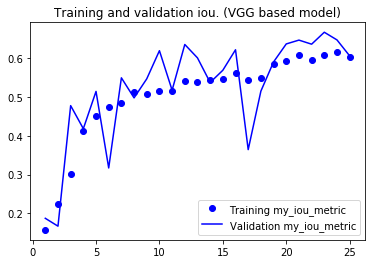
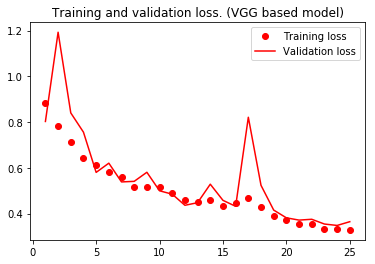

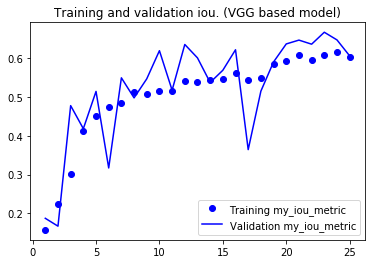

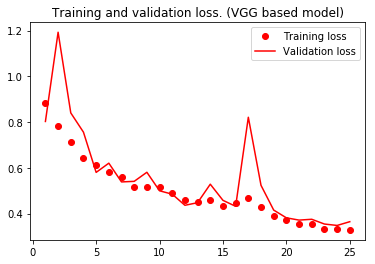

In [106]:
# VGG based model
iou = history_vgg.history["my_iou_metric"]
val_iou = history_vgg.history["val_my_iou_metric"]
loss = history_vgg.history["loss"]
val_loss = history_vgg.history["val_loss"]

epochs = range(1, len(iou)+1)


# IoUをプロット
plt.plot(epochs, iou, "bo", label="Training my_iou_metric")
plt.plot(epochs, val_iou, "b", label="Validation my_iou_metric")
plt.title("Training and validation iou. (VGG based model)")
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs,  loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss. (VGG based model)")
plt.legend()

plt.show()

#### 推定結果の比較

- 評価指標であるIoUの最高値をValidation dataで比較した場合、ResNet based modelで0.71625、VGG based modelで0.6637と、僅かながらResNetが上回った。

- 一方、Validation dataのIoUをトレンドで見た場合には、ResNet based modelも0.6〜0.7の間で推移しており、大きな差はないと思われる。

### 結果の可視化

参考として、VGG based modelによるテストデータに対する予測結果をグレイスケールで可視化すると以下の通り。

エポック数が少ないため、地面と塩堆積物と分離境界が不明瞭である。

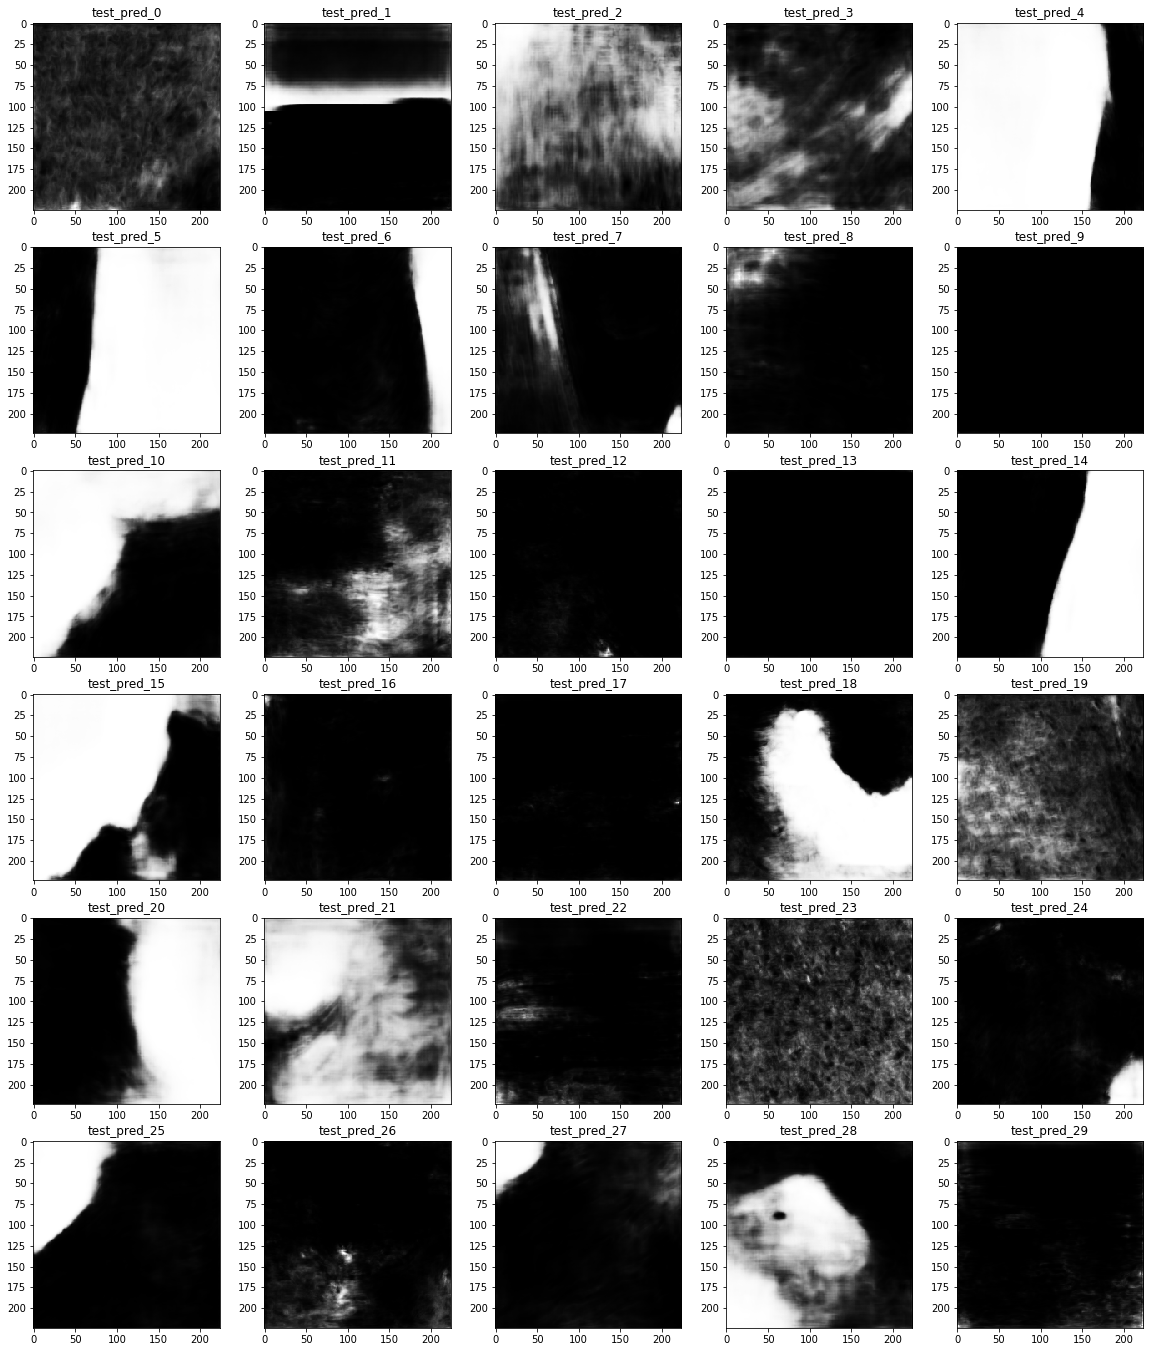

In [105]:
row = 6
column = 5

fig = plt.figure(figsize=(20, 24))

for i in range(row*column):
  ax = fig.add_subplot(row, column, i+1)
  ax.imshow(pred_vgg[i].reshape(224, 224), cmap=plt.cm.gray)
  ax.axis("image")
  ax.set_title("test_pred_{}".format(i))

### Take away

1. ResNetによるU-Net実装をVGGに書き換えることにより、フレームワーク（keras）に対する理解が深まった。今後、自分自身で論文実装する場合に有用だと思われるポイントは以下の通り。
  - レイヤーを所定の順序でaddする場合、関数化すると便利。（今回はupsamplingにおけるdecoderが関数化されていた）
  - kerasに用意されているResNetやVGGなどの既存モデルを応用する場合、アーキテクチャ、レイヤー名称が既定されいる。各レイヤーのoutputのshapeに注目し、参照するレイヤーを間違えないこと。

2. 大量の画像データを扱う際には、余裕を持ったスケジュール調整が重要になる。(GPUを用いても意外に時間がかかる印象)